https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 25 e top 75)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Oversample
        * Resample
        * ROS
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * KNN
        * Naive Bayes
    * Métricas de desempenho
        * F1-score positivo (iteração por iteração)
        * F1-score negativo (iteração por iteração)
        * curva ROC
        * curva Precision-Recall
        * matriz de confusão
        * avaliação de thresholds
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5         29.0   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN        404.0   
7            card3  float64     1565      114       150.0        150.0   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119       142.0        102.0   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332       315.0        325.0   
12           addr2  float64    65706       74        87.0         87.0   
13           dist1  float64   352271     2651        19.0          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657         1.0          1.0   
18              C2  float64        0     1216         1.0          1.0   
19              C3  float64        0       27         0.0          0.0   
20              C4  float64        0     1260         0.0          0.0   
21              C5  float64        0      319         0.0          0.0   
22              C6  float64        0     1328         1.0          1.0   
23              C7  float64        0     1103         0.0          0.0   
24              C8  float64        0     1253         0.0          0.0   

    Third Value             Entropy  
0       2987002  19.170000000000002  
1             0   0.220000000000000  
2         86469  19.109999999999999  
3          59.0   8.350000000000000  
4             W   1.280000000000000  
5          4663   9.970000000000001  
6         490.0   6.320000000000000  
7         150.0   0.680000000000000  
8          visa   1.090000000000000  
9         166.0   2.660000000000000  
10        debit   0.820000000000000  
11        330.0   5.060000000000000  
12         87.0   0.080000000000000  
13        287.0   6.340000000000000  
14          NaN   7.420000000000000  
15  outlook.com   2.680000000000000  
16          NaN   2.760000000000000  
17          1.0   2.720000000000000  
18          1.0   2.750000000000000  
19          0.0   0.040000000000000  
20          0.0   1.120000000000000  
21          0.0   2.060000000000000  
22          1.0   2.520000000000000  
23          0.0   0.710000000000000  
24          0.0   1.250000000000000

In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


Name   dtypes  Missing  Uniques         First Value  \
0    TransactionID    int64        0   506691             3663549   
1    TransactionDT    int64        0   494686            18403224   
2   TransactionAmt  float64        0    14119  31.949999999999999   
3        ProductCD   object        0        5                   W   
4            card1    int64        0    13244               10409   
5            card2  float64     8654      497               111.0   
6            card3  float64     3002      115               150.0   
7            card4   object     3086        4                visa   
8            card5  float64     4547      102               226.0   
9            card6   object     3007        3               debit   
10           addr1  float64    65609      292               170.0   
11           addr2  float64    65609       72                87.0   
12           dist1  float64   291217     1988                 1.0   
13           dist2  float64   470255     1814                 NaN   
14   P_emaildomain   object    69192       60           gmail.com   
15   R_emaildomain   object   370821       60                 NaN   
16              C1  float64        3     1174                 6.0   
17              C2  float64        3     1123                 6.0   
18              C3  float64        3       31                 0.0   
19              C4  float64        3      728                 0.0   
20              C5  float64        3      353                 3.0   
21              C6  float64        3      834                 4.0   
22              C7  float64        3      518                 0.0   
23              C8  float64        3      442                 0.0   
24              C9  float64        3      354                 6.0   

   Second Value  Third Value             Entropy  
0       3663550      3663551  18.949999999999999  
1      18403263     18403310  18.899999999999999  
2          49.0        171.0   8.080000000000000  
3             W            W   1.370000000000000  
4          4272         4476   9.949999999999999  
5         111.0        574.0   6.280000000000000  
6         150.0        150.0   0.810000000000000  
7          visa         visa   1.050000000000000  
8         226.0        226.0   2.630000000000000  
9         debit        debit   0.790000000000000  
10        299.0        472.0   5.100000000000000  
11         87.0         87.0   0.110000000000000  
12          4.0       2635.0   5.990000000000000  
13          NaN          NaN   7.900000000000000  
14      aol.com  hotmail.com   2.670000000000000  
15          NaN          NaN   2.690000000000000  
16          3.0          2.0   2.680000000000000  
17          2.0          2.0   2.760000000000000  
18          0.0          0.0   0.180000000000000  
19          0.0          0.0   1.210000000000000  
20          0.0          0.0   1.930000000000000  
21          1.0          5.0   2.470000000000000  
22          0.0          0.0   0.820000000000000  
23          0.0          0.0   1.360000000000000  
24          2.0          4.0   2.610000000000000

In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

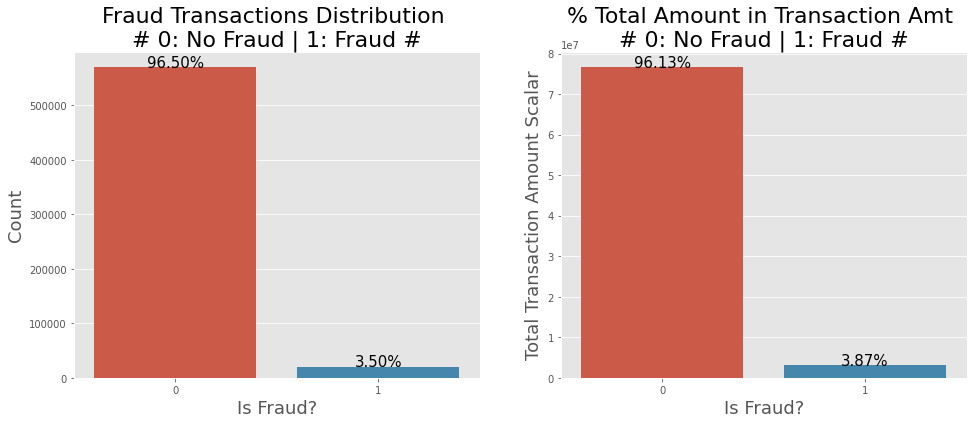

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_28: 76.12727334304196%
id_29: 76.12727334304196%
id_30: 86.86541131845429%
id_31: 76.24513157449114%
id_32: 86.86185525112609%
id_33: 87.58949436109323%
id_34: 86.82477054898906%
id_35: 76.12608798726589%
id_36: 76.12608798726589%
id_37: 76.12608798726589%
id_38: 76.12608798726589%
DeviceType: 76.15572188166763%
DeviceInfo: 79.90551021099333%
Date: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


Name   dtypes  Missing  Uniques First Value Second Value  \
0          isFraud    int64        0        2           0            0   
1   TransactionAmt  float64        0    20902        68.5         29.0   
2        ProductCD   object        0        5           W            W   
3            card1    int64        0    13553       13926         2755   
4            card2  float64     8933      500         NaN        404.0   
5            card4   object     1577        4    discover   mastercard   
6            card5  float64     4259      119       142.0        102.0   
7            addr1  float64    65706      332       315.0        325.0   
8            dist1  float64   352271     2651        19.0          NaN   
9    P_emaildomain   object    94456       59         NaN    gmail.com   
10              C1  float64        0     1657         1.0          1.0   
11              C2  float64        0     1216         1.0          1.0   
12              C5  float64        0      319         0.0          0.0   
13              C6  float64        0     1328         1.0          1.0   
14              C9  float64        0      205         1.0          0.0   
15             C11  float64        0     1476         2.0          1.0   
16             C13  float64        0     1597         1.0          1.0   
17             C14  float64        0     1108         1.0          1.0   
18              D1  float64     1269      641        14.0          0.0   
19              D2  float64   280797      641         NaN          NaN   
20              D3  float64   262878      649        13.0          NaN   
21              D4  float64   168922      808         NaN          0.0   
22              D5  float64   309841      688         NaN          NaN   
23             D10  float64    76022      818        13.0          0.0   
24             D11  float64   279287      676        13.0          NaN   
25             D15  float64    89113      859         0.0          0.0   
26              M1   object   271100        2           T          NaN   
27              M2   object   271100        2           T          NaN   
28              M3   object   271100        2           T          NaN   
29              M4   object   281444        3          M2           M0   
30              M5   object   350482        2           F            T   
31              M6   object   169360        2           T            T   
32              M7   object   346265        2         NaN          NaN   
33              M8   object   346252        2         NaN          NaN   
34              M9   object   346252        2         NaN          NaN   
35              V1  float64   279287        2         1.0          NaN   
36              V2  float64   279287        9         1.0          NaN   
37              V3  float64   279287       10         1.0          NaN   
38              V4  float64   279287        7         1.0          NaN   
39              V5  float64   279287        7         1.0          NaN   
40              V6  float64   279287       10         1.0          NaN   
41              V7  float64   279287       10         1.0          NaN   
42              V8  float64   279287        9         1.0          NaN   
43              V9  float64   279287        9         1.0          NaN   
44             V10  float64   279287        5         0.0          NaN   
45             V11  float64   279287        6         0.0          NaN   
46             V12  float64    76073        4         1.0          0.0   
47             V13  float64    76073        7         1.0          0.0   
48             V29  float64    76073        6         0.0          0.0   
49             V30  float64    76073        8         0.0          0.0   
50             V35  float64   168969        4         NaN          0.0   
51             V36  float64   168969        6         NaN          0.0   
52             V39  float64   168969       16         NaN          0.0   
53             V40

In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [58]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Balanceamento de Classes

### Oversampling com SMOTE

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
smote = SMOTE(random_state=42)

In [61]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.53 s, sys: 1.01 s, total: 7.54 s
Wall time: 2.65 s


In [62]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [63]:
from imblearn.over_sampling import BorderlineSMOTE

In [64]:
smote = BorderlineSMOTE(random_state=42)

In [65]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

CPU times: user 2min 4s, sys: 514 ms, total: 2min 5s
Wall time: 13.4 s


In [66]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [67]:
from imblearn.over_sampling import ADASYN

In [68]:
adasyn = ADASYN(random_state=42)

In [69]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 5s, sys: 463 ms, total: 2min 5s
Wall time: 13.3 s


In [70]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [71]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.1e+02 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [72]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Oversampling com SMOTE

In [73]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [74]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [75]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [76]:
oversample_with_smote_cols_50_chi2

Index(['card1', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'D1',
       'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V40', 'V52', 'V96',
       'V127', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [77]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93',
       'V96', 'V99', 'V127', 'V130', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_outlook.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

### Oversampling com Borderline-SMOTE

In [78]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [79]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [80]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [81]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V96', 'V127',
       'V130', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [82]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',
       'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91',
       'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282', 'V283', 'V285',
       'V307', 'V308', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W',
       'card4_discover', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_outlook.com', 'M4_M2',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

### Oversampling com AdaSyn

In [83]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 25)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [84]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 75)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [85]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [86]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11',
       'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V96', 'V127',
       'V130', 'V283', 'V307', 'V308', 'V310'],
      dtype='object')

In [87]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40',
       'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70',
       'V75', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V99', 'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308',
       'V310', '_Weekdays', '_Hours', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'card4_mastercard', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_outlook.com', 'M4_M2',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [89]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [90]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [91]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

## Validação Cruzada para Oversampling com SMOTE

### 50 Chi-Square

F1-Score Positivo (Teste): 0.5832675611681136
F1-Score Negativo (Teste): 0.9861425809442992
F1-Score Positivo Médio (Validação Cruzada): 0.48707366759087056
F1-Score Positivo Fold 1: 0.5244299674267101
F1-Score Positivo Fold 2: 0.4688524590163935
F1-Score Positivo Fold 3: 0.526148969889065
F1-Score Positivo Fold 4: 0.49427168576104746
F1-Score Positivo Fold 5: 0.5242718446601943
F1-Score Positivo Fold 6: 0.5008025682182985
F1-Score Positivo Fold 7: 0.45896147403685095
F1-Score Positivo Fold 8: 0.4433333333333334
F1-Score Positivo Fold 9: 0.47154471544715443
F1-Score Positivo Fold 10: 0.4581196581196581
F1-Score Negativo Médio (Validação Cruzada): 0.9864067866282362
F1-Score Negativo Fold 1: 0.9873087621696802
F1-Score Negativo Fold 2: 0.9859203893620719
F1-Score Negativo Fold 3: 0.9869949110521509
F1-Score Negativo Fold 4: 0.9865716396506018
F1-Score Negativo Fold 5: 0.9872196139801773
F1-Score Negativo Fold 6: 0.9864776729423018
F1-Score Negativo Fold 7: 0.9859717698154181
F1-Score Ne

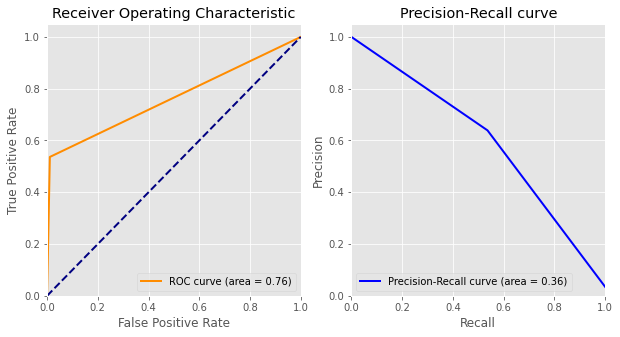

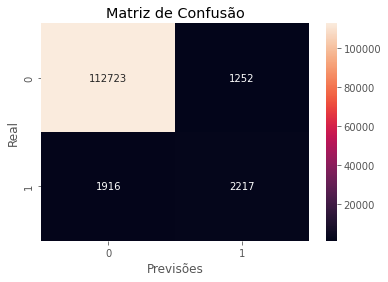

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.64      0.54      0.58      4133

    accuracy                           0.97    118108
   macro avg       0.81      0.76      0.78    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 4min 35s, sys: 394 ms, total: 4min 35s
Wall time: 4min 35s


In [92]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [93]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.5 s, sys: 4.03 ms, total: 53.5 s
Wall time: 53.5 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.583267561168114  0.986142580944299
Threshold: 0.05   0.17180311649765  0.828976535605202
Threshold: 0.1   0.261045933585206   0.91196801076415
Threshold: 0.15  0.358473105841527  0.949334478316874
Threshold: 0.2    0.42644937986732  0.964227247377984
Threshold: 0.25  0.472821977652693  0.972025696236955
Threshold: 0.3   0.507543810327055  0.976700880090448
Threshold: 0.35  0.549107142857143  0.981296956015661
Threshold: 0.4   0.566501896769744  0.983425414364641
Threshold: 0.45  0.577821249541509  0.984857720457645
Threshold: 0.5   0.582330875695253  0.985867781254787
Threshold: 0.55  0.580724538619276   0.98660119440282
Threshold: 0.6   0.574416961130742   0.98685961918644
Threshold: 0.65  0.563458448955747  0.986968596453749
Threshold: 0.7   0.552603286745508  0.987318517228619
Threshold: 0.75  0.533038952846554  0.987119086460033

In [94]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
18     V52  0.101481573838185
8      C13  0.069687616837461
2       C1  0.062133563211976
0    card1  0.060741420792097
17     V40  0.054283137105640
21    V283  0.050975958413563
15     D11  0.047557439885619
3       C2  0.045608289762278
10      D2  0.042085983152802
7      C11  0.039269932564540
9       D1  0.039178131054454
14     D10  0.037543179428115
5       C6  0.036676961278049
16     D15  0.034385389569019
13      D5  0.033709754658884
6       C9  0.031040515698700
19     V96  0.030412067591057
23    V308  0.029966815953565
4       C5  0.027692184969261
11      D3  0.025745745914956
12      D4  0.025379521387190
22    V307  0.020623329205430
1    dist1  0.018679223360885
20    V127  0.018010456717781
24    V310  0.017131807648494

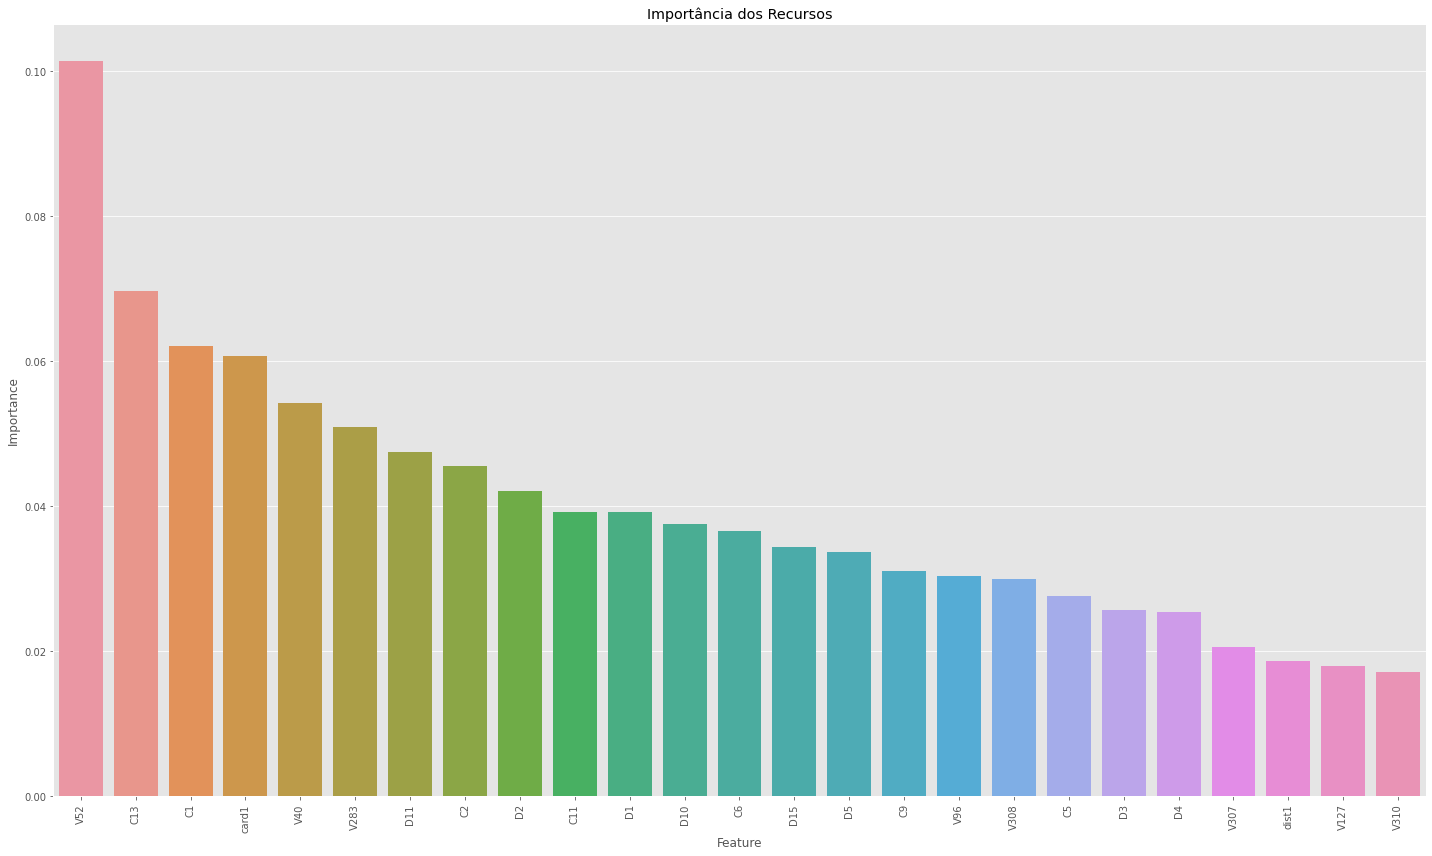

In [95]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4648370497427102
F1-Score Negativo (Teste): 0.9779979549381194
F1-Score Positivo Médio (Validação Cruzada): 0.40985601912873476
F1-Score Positivo Fold 1: 0.45700245700245695
F1-Score Positivo Fold 2: 0.40772014475271406
F1-Score Positivo Fold 3: 0.4250871080139373
F1-Score Positivo Fold 4: 0.38733252131546897
F1-Score Positivo Fold 5: 0.4430992736077482
F1-Score Positivo Fold 6: 0.3619047619047619
F1-Score Positivo Fold 7: 0.42280285035629456
F1-Score Positivo Fold 8: 0.3761904761904762
F1-Score Positivo Fold 9: 0.41204819277108434
F1-Score Positivo Fold 10: 0.4053724053724054
F1-Score Negativo Médio (Validação Cruzada): 0.978445791495357
F1-Score Negativo Fold 1: 0.9806208347948087
F1-Score Negativo Fold 2: 0.9784582986004474
F1-Score Negativo Fold 3: 0.9782522736259391
F1-Score Negativo Fold 4: 0.9779395640542082
F1-Score Negativo Fold 5: 0.979821021231795
F1-Score Negativo Fold 6: 0.9764726538495303
F1-Score Negativo Fold 7: 0.9786654960491661
F1-Score N

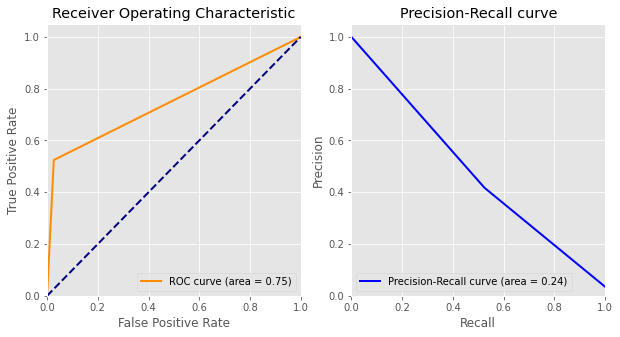

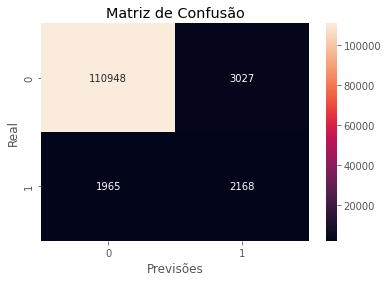

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.42      0.52      0.46      4133

    accuracy                           0.96    118108
   macro avg       0.70      0.75      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 35.6 s, sys: 304 ms, total: 35.9 s
Wall time: 35.6 s


In [96]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [97]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.46483704974271  0.977997954938119
Threshold: 0.05  0.316190995163817  0.954684361387591
Threshold: 0.1   0.335128055878929  0.958925168111043
Threshold: 0.15  0.392813747613262  0.968864322144784
Threshold: 0.2    0.40485393258427  0.970585229973655
Threshold: 0.25  0.413703703703704  0.971909713596195
Threshold: 0.3   0.419406500235516  0.972681858679704
Threshold: 0.35  0.440579710144928  0.975257613467073
Threshold: 0.4    0.44794952681388   0.97603682157702
Threshold: 0.45  0.455092304501141  0.976811108070652
Threshold: 0.5   0.460823653643083  0.977481410917943
Threshold: 0.55  0.467259323503903  0.978351659970395
Threshold: 0.6   0.468539081210538  0.978496233977889
Threshold: 0.65  0.469506186357166  0.978664188864864
Threshold: 0.7   0.472277889111556  0.979140445531919
Threshold: 0.75  0.472318146374067    0.9791541064694

In [98]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
18     V52  0.181567316932636
2       C1  0.141586801264087
8      C13  0.096239986656990
23    V308  0.079767922117186
4       C5  0.074635164700621
17     V40  0.058933519494690
21    V283  0.055613481124714
0    card1  0.055605209816133
11      D3  0.031373698389377
19     V96  0.028143413990747
3       C2  0.019522174522340
6       C9  0.019443964712708
7      C11  0.018653915360352
5       C6  0.018589861224549
12      D4  0.018552749447054
1    dist1  0.015749943336819
14     D10  0.013178149769088
20    V127  0.012853583029923
10      D2  0.012310138762016
9       D1  0.010043778625242
16     D15  0.009599722211142
24    V310  0.008504975119202
22    V307  0.007031248422637
15     D11  0.006889676217698
13      D5  0.005609604752050

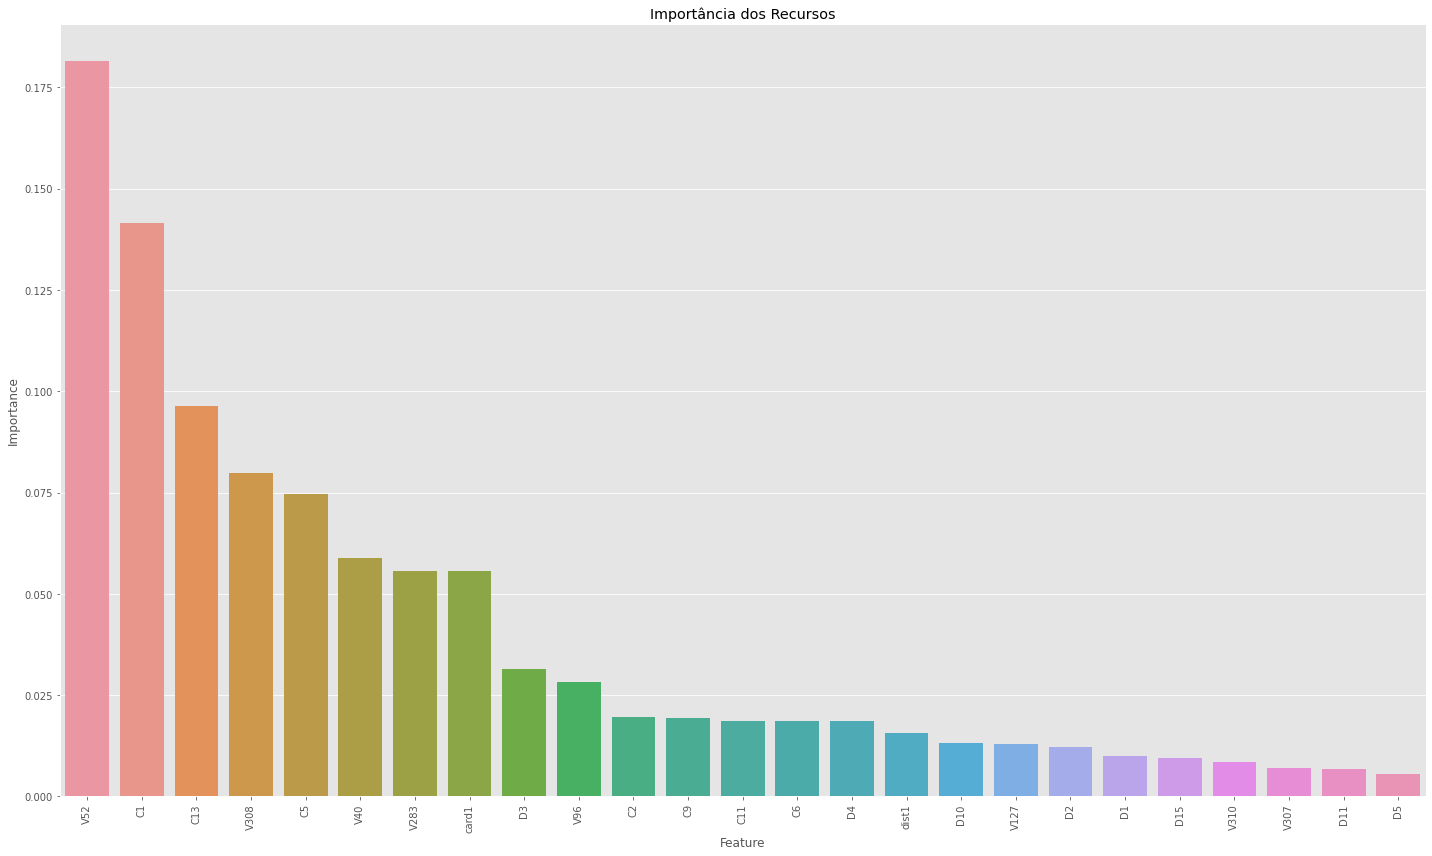

In [99]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6230502	total: 111ms	remaining: 443ms
1:	learn: 0.5579817	total: 174ms	remaining: 261ms
2:	learn: 0.5154798	total: 224ms	remaining: 149ms
3:	learn: 0.4716861	total: 275ms	remaining: 68.7ms
4:	learn: 0.4425450	total: 325ms	remaining: 0us
0:	learn: 0.5430453	total: 6.92ms	remaining: 27.7ms
1:	learn: 0.4361108	total: 13.4ms	remaining: 20.2ms
2:	learn: 0.3528608	total: 20ms	remaining: 13.3ms
3:	learn: 0.2965732	total: 25.9ms	remaining: 6.48ms
4:	learn: 0.2539016	total: 31.8ms	remaining: 0us
0:	learn: 0.5431114	total: 13ms	remaining: 52.2ms
1:	learn: 0.4359772	total: 21.2ms	remaining: 31.7ms
2:	learn: 0.3524977	total: 28.1ms	remaining: 18.7ms
3:	learn: 0.2961430	total: 34ms	remaining: 8.5ms
4:	learn: 0.2535590	total: 39.8ms	remaining: 0us
0:	learn: 0.5430867	total: 7.41ms	remaining: 29.6ms
1:	learn: 0.4361345	total: 14.4ms	remaining: 21.7ms
2:	learn: 0.3525476	total: 21.7ms	remaining: 14.4ms
3:	learn: 0.2963148	total: 27.9ms	remaining: 6.99ms
4:	learn: 0.2537228	total: 33.9ms	re

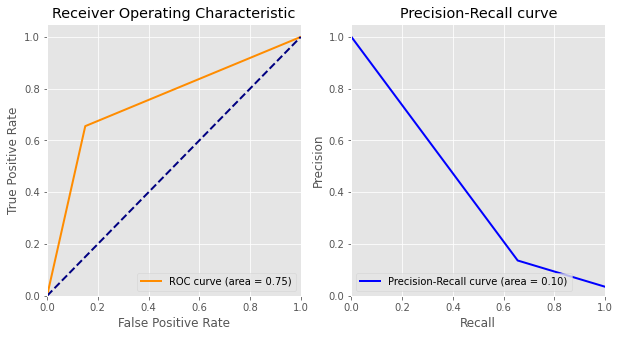

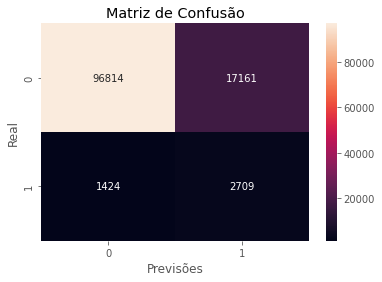

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.66      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.75      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 17.4 s, sys: 796 ms, total: 18.2 s
Wall time: 7.68 s


In [100]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [101]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.01 s, sys: 20.5 ms, total: 1.04 s
Wall time: 729 ms


Metrics          F1_score Positivo  F1_score Negativo
Original         0.225721784776903  0.912422895864061
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.073908316724044  0.187656950316285
Threshold: 0.3   0.081630145402417  0.352694939230347
Threshold: 0.35  0.122455211726384  0.708211110609685
Threshold: 0.4   0.150715220432291  0.803839619790092
Threshold: 0.45   0.18878858118824  0.869251037222015
Threshold: 0.5   0.225721784776903  0.912422895864061
Threshold: 0.55  0.299275160301087  0.954684767519426
Threshold: 0.6   0.345755237045204  0.973875833164573
Threshold: 0.65  0.355350742447517  0.977951349363409
Threshold: 0.7   0.354224320364643  0.982757646486115
Threshold: 0.75  0.237301587301587  0.983371976329723

In [102]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
18     V52  27.382494729488592
7      C11  21.723426952045987
6       C9  13.288194407018356
4       C5  11.818352746057437
8      C13   9.891535589091426
2       C1   7.619802879375403
23    V308   3.570669866037463
5       C6   1.989556687501910
21    V283   1.449115568700735
13      D5   1.266850574682688
0    card1   0.000000000000000
16     D15   0.000000000000000
22    V307   0.000000000000000
20    V127   0.000000000000000
19     V96   0.000000000000000
17     V40   0.000000000000000
12      D4   0.000000000000000
15     D11   0.000000000000000
14     D10   0.000000000000000
1    dist1   0.000000000000000
11      D3   0.000000000000000
10      D2   0.000000000000000
9       D1   0.000000000000000
3       C2   0.000000000000000
24    V310   0.000000000000000

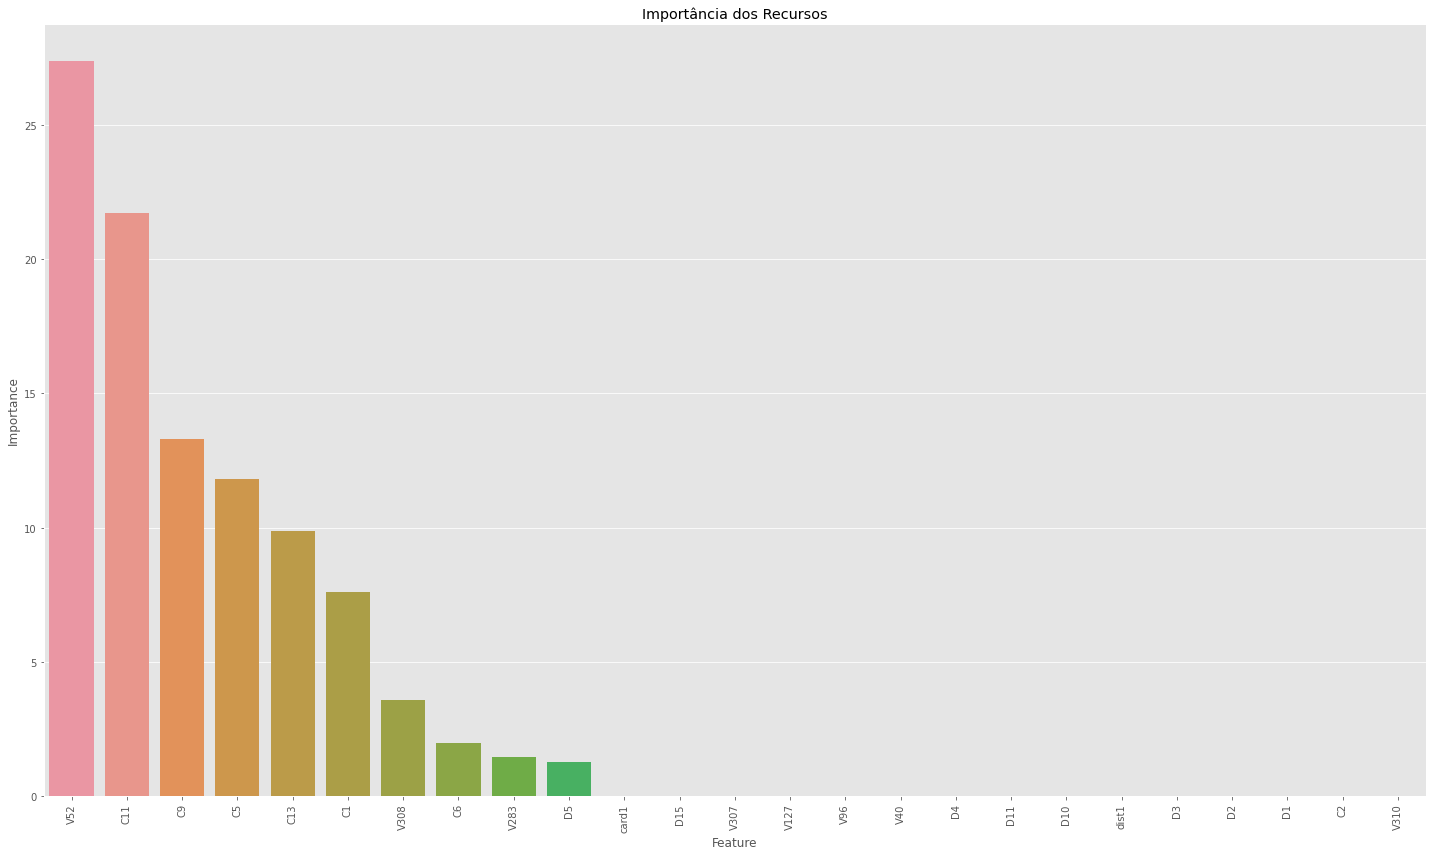

In [103]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.29791894852135814
F1-Score Negativo (Teste): 0.9537200823074979
F1-Score Positivo Médio (Validação Cruzada): 0.1584964919830097
F1-Score Positivo Fold 1: 0.17981651376146787
F1-Score Positivo Fold 2: 0.348968105065666
F1-Score Positivo Fold 3: 0.14035087719298242
F1-Score Positivo Fold 4: 0.14624505928853757
F1-Score Positivo Fold 5: 0.1417624521072797
F1-Score Positivo Fold 6: 0.15327102803738318
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.11306042884990254
F1-Score Positivo Fold 9: 0.11787072243346008
F1-Score Positivo Fold 10: 0.14615384615384613
F1-Score Negativo Médio (Validação Cruzada): 0.9809776702737588
F1-Score Negativo Fold 1: 0.9806300645664514
F1-Score Negativo Fold 2: 0.9849711984061673
F1-Score Negativo Fold 3: 0.98091652602882
F1-Score Negativo Fold 4: 0.9813116456134279
F1-Score Negativo Fold 5: 0.9806060606060606
F1-Score Negativo Fold 6: 0.9803785680252955
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score

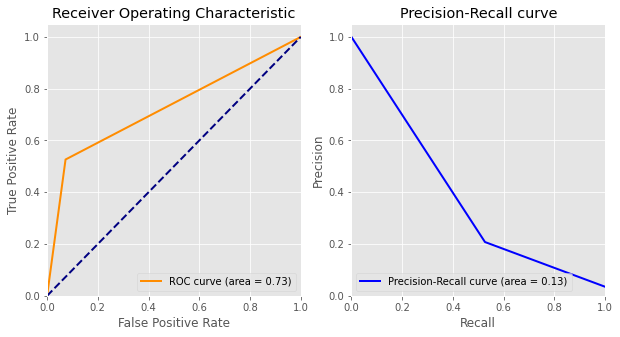

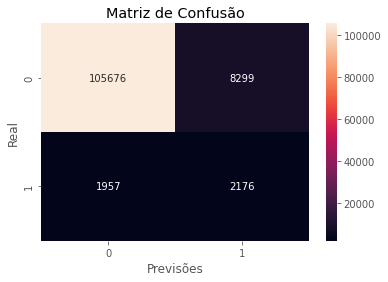

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.21      0.53      0.30      4133

    accuracy                           0.91    118108
   macro avg       0.59      0.73      0.63    118108
weighted avg       0.95      0.91      0.93    118108

CPU times: user 3min 31s, sys: 308 ms, total: 3min 31s
Wall time: 3min 31s


In [104]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [105]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.297918948521358  0.953720082307498
Threshold: 0.05  0.083532546310435  0.383933059132515
Threshold: 0.1   0.100745365013589  0.587139415652604
Threshold: 0.15  0.130416225945926  0.742983759947786
Threshold: 0.2   0.156773320031355  0.817125754055544
Threshold: 0.25  0.180271912062482  0.859466589964591
Threshold: 0.3   0.207601925254813  0.892335064435468
Threshold: 0.35  0.235787471358783  0.917042494779079
Threshold: 0.4   0.256321370309951  0.932650046168052
Threshold: 0.45  0.277122781945933  0.944672822232957
Threshold: 0.5   0.297918948521358  0.953720082307498
Threshold: 0.55  0.313077221575475  0.960368242653281
Threshold: 0.6   0.329775687409551  0.967090069284065
Threshold: 0.65  0.342138364779874  0.972312904762745
Threshold: 0.7   0.351957975167144  0.976176264044944
Threshold: 0.75  0.350810810810811  0.979004964687784

In [106]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
18     V52  0.256347698606954
8      C13  0.148011179450518
13      D5  0.135531063651684
4       C5  0.092396729446051
7      C11  0.084742626894985
5       C6  0.048374167243681
19     V96  0.043146863040439
23    V308  0.040974694998949
21    V283  0.029673619198923
11      D3  0.026635363825611
2       C1  0.022726497024377
1    dist1  0.015788820376586
12      D4  0.015100936469398
15     D11  0.014708950062712
3       C2  0.007317746964248
6       C9  0.005117446171277
20    V127  0.003191993586924
0    card1  0.002942184240812
14     D10  0.001997735575199
17     V40  0.001870562416951
10      D2  0.001558896152882
24    V310  0.001061465222375
16     D15  0.000782759378464
22    V307  0.000000000000000
9       D1  0.000000000000000

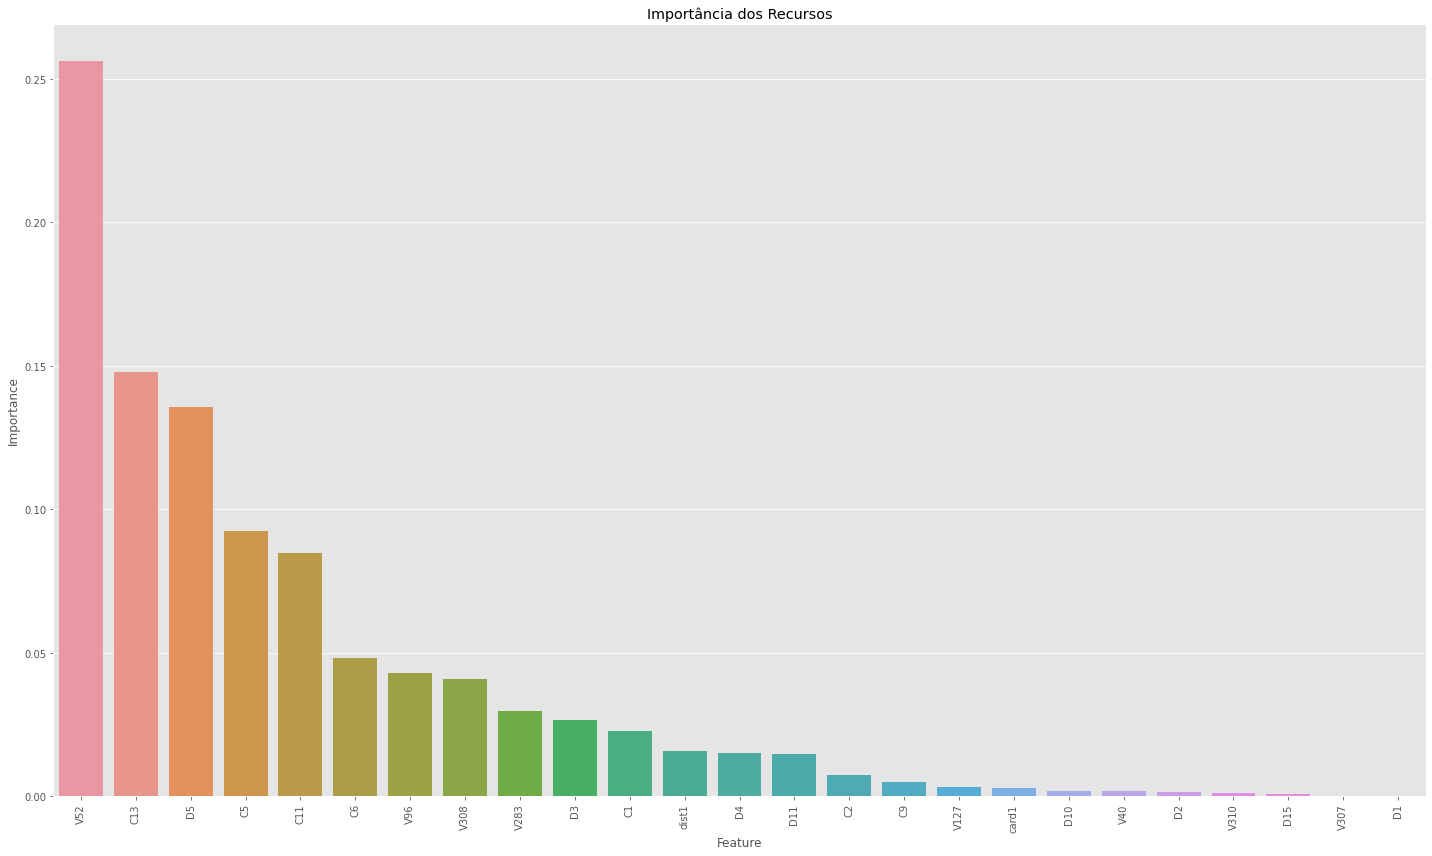

In [107]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.28659318123558064
F1-Score Negativo (Teste): 0.949540369517524
F1-Score Positivo Médio (Validação Cruzada): 0.2933440343970588
F1-Score Positivo Fold 1: 0.35067437379576105
F1-Score Positivo Fold 2: 0.2901960784313725
F1-Score Positivo Fold 3: 0.31287128712871287
F1-Score Positivo Fold 4: 0.30919765166340507
F1-Score Positivo Fold 5: 0.30120481927710846
F1-Score Positivo Fold 6: 0.3115384615384616
F1-Score Positivo Fold 7: 0.25948103792415167
F1-Score Positivo Fold 8: 0.2217741935483871
F1-Score Positivo Fold 9: 0.2930693069306931
F1-Score Positivo Fold 10: 0.2834331337325349
F1-Score Negativo Médio (Validação Cruzada): 0.9845209728559017
F1-Score Negativo Fold 1: 0.9854131498073845
F1-Score Negativo Fold 2: 0.9843371408791969
F1-Score Negativo Fold 3: 0.98498940173898
F1-Score Negativo Fold 4: 0.9847258881052313
F1-Score Negativo Fold 5: 0.9849507005708354
F1-Score Negativo Fold 6: 0.9845035061899402
F1-Score Negativo Fold 7: 0.9839539812291855
F1-Score Ne

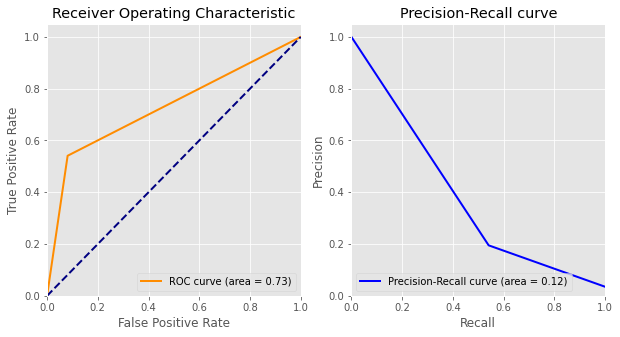

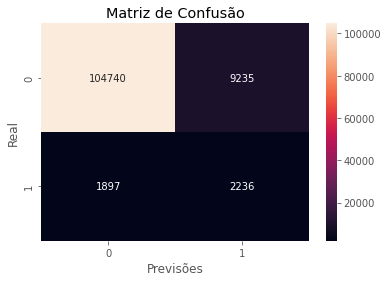

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.19      0.54      0.29      4133

    accuracy                           0.91    118108
   macro avg       0.59      0.73      0.62    118108
weighted avg       0.95      0.91      0.93    118108

CPU times: user 4min 16s, sys: 340 ms, total: 4min 16s
Wall time: 4min 16s


In [108]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [109]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 13.3 s, sys: 0 ns, total: 13.3 s
Wall time: 13.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.286593181235581  0.949540369517524
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.286593181235581  0.949540369517524
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [110]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
2       C1        0.15
8      C13        0.12
5       C6        0.11
19     V96        0.10
11      D3        0.07
7      C11        0.05
18     V52        0.05
21    V283        0.04
20    V127        0.04
1    dist1        0.04
13      D5        0.04
23    V308        0.04
4       C5        0.03
6       C9        0.02
17     V40        0.02
15     D11        0.02
0    card1        0.02
12      D4        0.01
14     D10        0.01
3       C2        0.01
24    V310        0.01
16     D15        0.00
10      D2        0.00
9       D1        0.00
22    V307        0.00

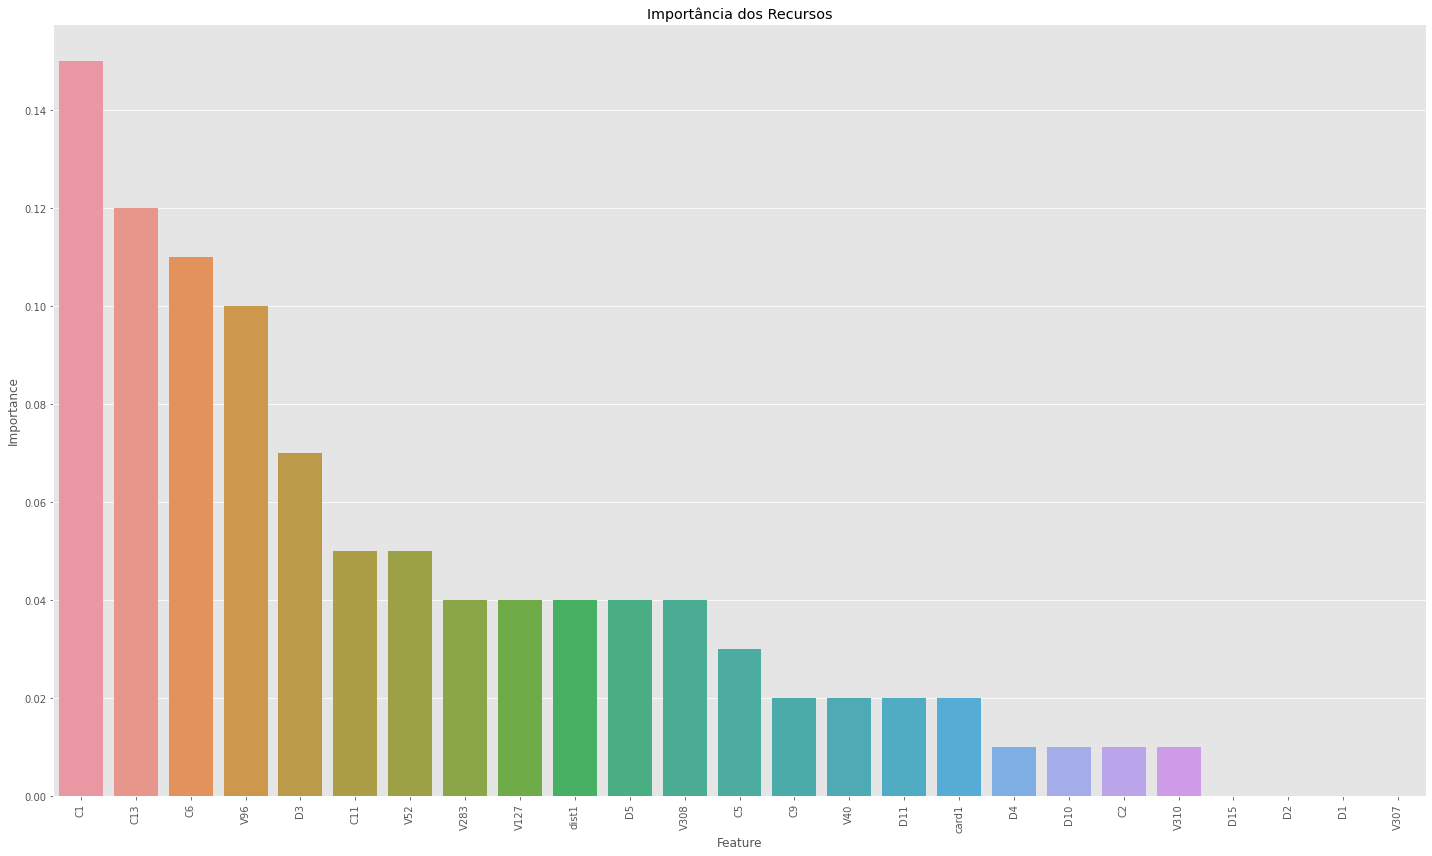

In [111]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.32883229552928006
F1-Score Negativo (Teste): 0.9567732952420435
F1-Score Positivo Médio (Validação Cruzada): 0.263685734999047
F1-Score Positivo Fold 1: 0.2821869488536155
F1-Score Positivo Fold 2: 0.22654867256637165
F1-Score Positivo Fold 3: 0.24956063268892795
F1-Score Positivo Fold 4: 0.24295774647887325
F1-Score Positivo Fold 5: 0.3079584775086505
F1-Score Positivo Fold 6: 0.27739726027397266
F1-Score Positivo Fold 7: 0.2582897033158813
F1-Score Positivo Fold 8: 0.2456140350877193
F1-Score Positivo Fold 9: 0.2495479204339964
F1-Score Positivo Fold 10: 0.296795952782462
F1-Score Negativo Médio (Validação Cruzada): 0.9817350774803405
F1-Score Negativo Fold 1: 0.9823465625677726
F1-Score Negativo Fold 2: 0.9810469705512425
F1-Score Negativo Fold 3: 0.981477464972021
F1-Score Negativo Fold 4: 0.9813481391515573
F1-Score Negativo Fold 5: 0.9826419024474917
F1-Score Negativo Fold 6: 0.9816824377116069
F1-Score Negativo Fold 7: 0.9815610221701592
F1-Score Neg

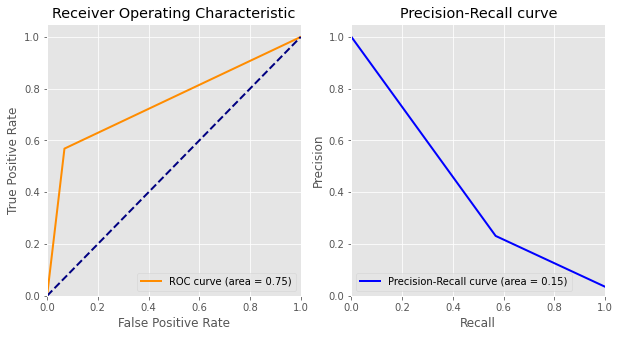

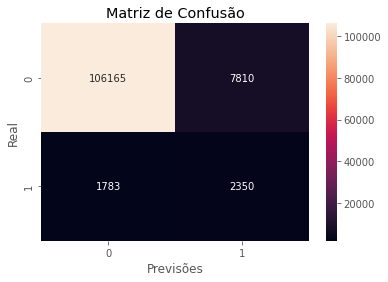

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.23      0.57      0.33      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.75      0.64    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 13min 16s, sys: 404 ms, total: 13min 16s
Wall time: 1min 13s


In [112]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [113]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2h 51min 34s, sys: 1.15 s, total: 2h 51min 35s
Wall time: 14min 26s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.32883229552928  0.956773295242043
Threshold: 0.05  0.259059441394128   0.92790947224661
Threshold: 0.1   0.259059441394128   0.92790947224661
Threshold: 0.15  0.259059441394128   0.92790947224661
Threshold: 0.2   0.259059441394128   0.92790947224661
Threshold: 0.25  0.259059441394128   0.92790947224661
Threshold: 0.3   0.259059441394128   0.92790947224661
Threshold: 0.35   0.32883229552928  0.956773295242043
Threshold: 0.4    0.32883229552928  0.956773295242043
Threshold: 0.45   0.32883229552928  0.956773295242043
Threshold: 0.5    0.32883229552928  0.956773295242043
Threshold: 0.55   0.32883229552928  0.956773295242043
Threshold: 0.6    0.32883229552928  0.956773295242043
Threshold: 0.65   0.32883229552928  0.956773295242043
Threshold: 0.7    0.40607447472436  0.974801634583984
Threshold: 0.75   0.40607447472436  0.974801634583984

### 100 Chi-Square

In [114]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6707512764405544
F1-Score Negativo (Teste): 0.9901596173717415
F1-Score Positivo Médio (Validação Cruzada): 0.5076123453351182
F1-Score Positivo Fold 1: 0.5466893039049237
F1-Score Positivo Fold 2: 0.4816753926701571
F1-Score Positivo Fold 3: 0.5212947189097104
F1-Score Positivo Fold 4: 0.5299145299145299
F1-Score Positivo Fold 5: 0.5531197301854974
F1-Score Positivo Fold 6: 0.5186440677966101
F1-Score Positivo Fold 7: 0.4862068965517241
F1-Score Positivo Fold 8: 0.4693140794223827
F1-Score Positivo Fold 9: 0.48516579406631766
F1-Score Positivo Fold 10: 0.4840989399293286
F1-Score Negativo Médio (Validação Cruzada): 0.9876404619835446
F1-Score Negativo Fold 1: 0.9884079364390222
F1-Score Negativo Fold 2: 0.9871144084342053
F1-Score Negativo Fold 3: 0.9878011721293684
F1-Score Negativo Fold 4: 0.9880626817728003
F1-Score Negativo Fold 5: 0.9884927699856703
F1-Score Negativo Fold 6: 0.9876693296283432
F1-Score Negativo Fold 7: 0.987067094870237
F1-Score Negat

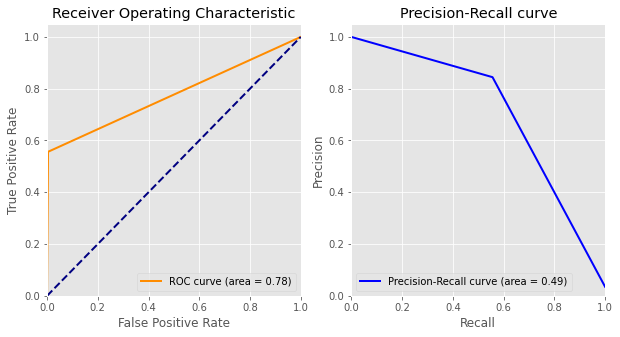

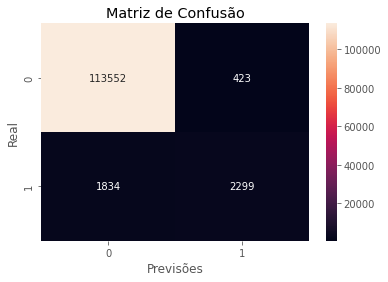

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.84      0.56      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.91      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 6min 14s, sys: 360 ms, total: 6min 15s
Wall time: 6min 14s


In [115]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [116]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 51.2 s, sys: 9 µs, total: 51.2 s
Wall time: 51.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.670751276440554  0.990159617371742
Threshold: 0.05  0.244103381835094   0.88960478181977
Threshold: 0.1   0.392463079273468  0.950870080487593
Threshold: 0.15  0.506468355410954  0.971469770316202
Threshold: 0.2   0.587935909519321  0.980621082772621
Threshold: 0.25  0.645223961144091  0.985516697436892
Threshold: 0.3   0.672950047125354  0.987810018969999
Threshold: 0.35  0.687894869850897  0.989180997100332
Threshold: 0.4    0.69172331067573  0.989886888808244
Threshold: 0.45  0.688066992323796  0.990242347774076
Threshold: 0.5   0.674381599884276  0.990183294592744
Threshold: 0.55  0.659868026394721  0.990119713523969
Threshold: 0.6    0.63809967396367   0.98985529322163
Threshold: 0.65  0.613333333333333  0.989534373084164
Threshold: 0.7   0.582585576603523  0.989087654975282
Threshold: 0.75  0.543732782369146   0.98849866324086

In [117]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
67    P_emaildomain_gmail.com  0.047694561694954
61                ProductCD_C  0.042054042890606
71                      M4_M2  0.037463381606358
73                       M6_F  0.034799363251613
74                       M6_T  0.032500060824373
72                       M5_T  0.023827089080303
2                       card2  0.022503473247245
0              TransactionAmt  0.022218639900928
1                       card1  0.021104229134427
12                        C14  0.019996182682238
5                          C1  0.018783771163253
65                ProductCD_W  0.018444568964223
14                         D2  0.017904385329963
59                  _Weekdays  0.017607431562332
3                       card5  0.016905761042886
6                          C2  0.016868963387811
62                ProductCD_H  0.016838875289257
60                     _Hours  0.016805557541898
54                       V283  0.016469272958652
11                        C13  0.016387193093688
34                        V51  0.015849129354221
45                        V90  0.015537356881434
63                ProductCD_R  0.015279401142926
36                        V53  0.015191362760300
53                       V282  0.015027046232042
10                        C11  0.014973640930768
70                      M4_M0  0.014804435246432
68  P_emaildomain_hotmail.com  0.013479528651436
31                        V48  0.013301770235023
37                        V69  0.013151515898396
21                        V12  0.012983818110106
49                        V96  0.012616504975037
23                        V29  0.012448835936951
13                         D1  0.012355096031115
38                        V70  0.011988480542450
8                          C6  0.011694583838111
32                        V49  0.011260647932455
39                        V75  0.011086966947488
35                        V52  0.010859674274745
57                       V308  0.010820536949964
25                        V35  0.010818847155135
33                        V50  0.010233449281645
55                       V285  0.010017699176379
18                        D10  0.009839935472083
56                       V307  0.009785530716324
51                       V127  0.009373213313619
40                        V76  0.009358572536182
29                        V42  0.009358263767217
30                        V43  0.009165466973743
22                        V13  0.009104666309058
20                        D15  0.009019065810437
26                        V36  0.008904220099986
58                       V310  0.008818262115609
27                        V39  0.008704619369673
17                         D5  0.008586154910030
28                        V40  0.008264811328224
16                         D4  0.007846420925132
24                        V30  0.007466623055806
50                        V99  0.006932402536243
46                        V91  0.006854900717155
15                         D3  0.006678947902041
47                        V92  0.006666134520807
44                        V85  0.006468158296254
42                        V81  0.006232286213939
64                ProductCD_S  0.006085562653096
66             card4_discover  0.006007034407554
19                        D11  0.005780097244042
4                       dist1  0.005507256115891
52                       V130  0.005231258971908
43                        V84  0.005151226433813
41                        V80  0.004898759491725
69  P_emaildomain_outlook.com  0.004721825364549
9                          C9  0.004535862197322
48                        V93  0.003672371234259
7                          C5  0.002022955864713

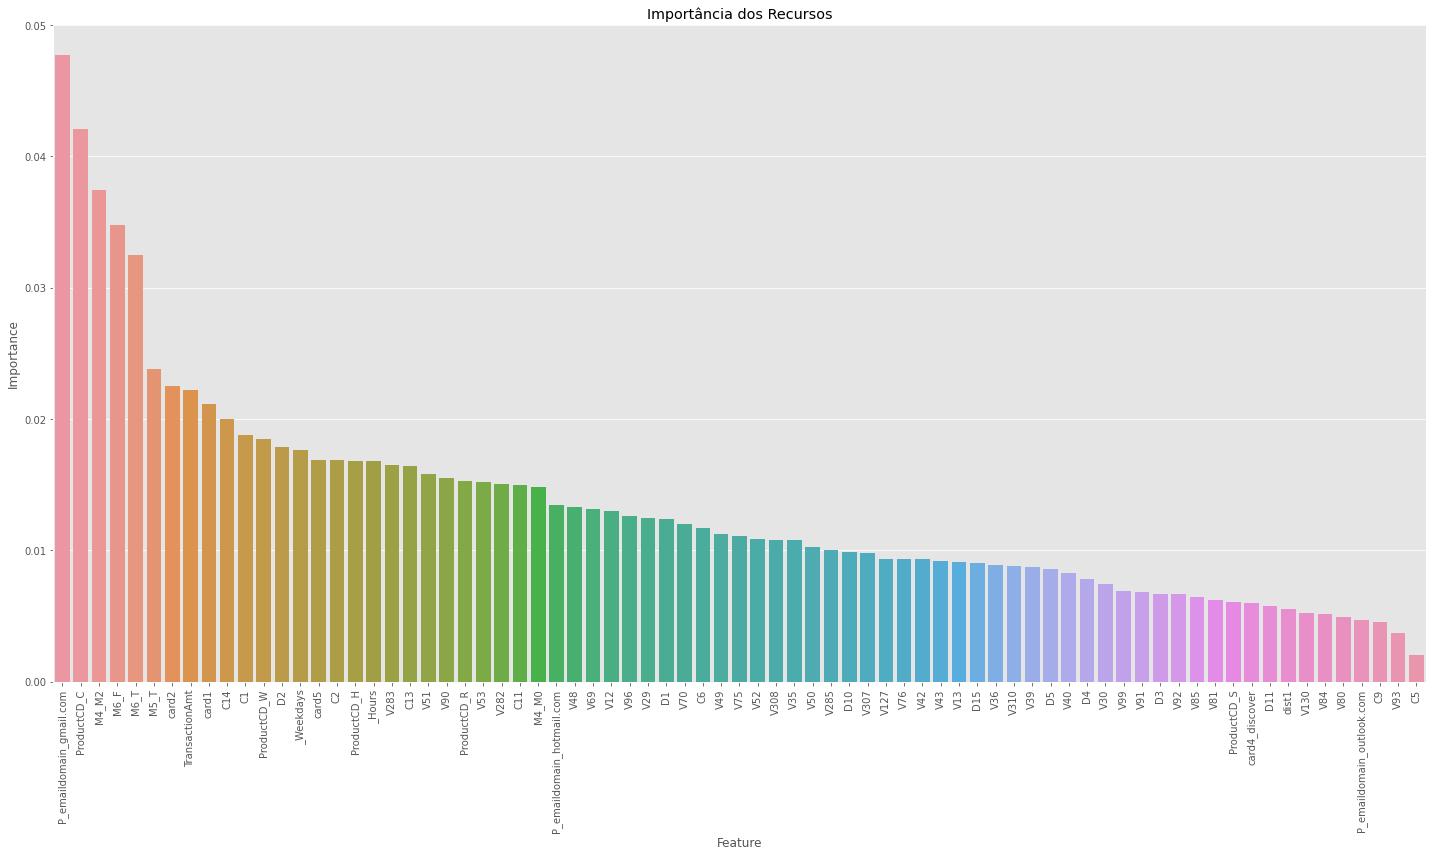

In [118]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.49414545063916643
F1-Score Negativo (Teste): 0.9792470042792863
F1-Score Positivo Médio (Validação Cruzada): 0.4172929882480217
F1-Score Positivo Fold 1: 0.43080357142857145
F1-Score Positivo Fold 2: 0.4232081911262799
F1-Score Positivo Fold 3: 0.4314606741573034
F1-Score Positivo Fold 4: 0.4279176201372998
F1-Score Positivo Fold 5: 0.4313725490196078
F1-Score Positivo Fold 6: 0.41797752808988764
F1-Score Positivo Fold 7: 0.407744874715262
F1-Score Positivo Fold 8: 0.3791907514450867
F1-Score Positivo Fold 9: 0.4163969795037756
F1-Score Positivo Fold 10: 0.40685714285714286
F1-Score Negativo Médio (Validação Cruzada): 0.9773455557060344
F1-Score Negativo Fold 1: 0.9775587432896242
F1-Score Negativo Fold 2: 0.977707426460889
F1-Score Negativo Fold 3: 0.9777406299489707
F1-Score Negativo Fold 4: 0.9780200457183049
F1-Score Negativo Fold 5: 0.9783344319929685
F1-Score Negativo Fold 6: 0.9772127397501319
F1-Score Negativo Fold 7: 0.9771368272951108
F1-Score Neg

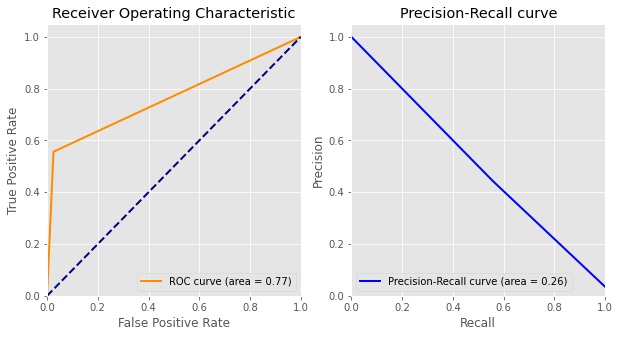

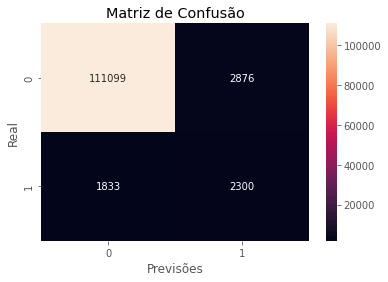

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.56      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.77      0.74    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 15s, sys: 288 ms, total: 1min 15s
Wall time: 1min 15s


In [119]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [120]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.17 s, sys: 3 µs, total: 1.17 s
Wall time: 1.17 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.494145450639166  0.979247004279286
Threshold: 0.05  0.493880180373631   0.97922451102238
Threshold: 0.1   0.493880180373631   0.97922451102238
Threshold: 0.15  0.493880180373631   0.97922451102238
Threshold: 0.2   0.493880180373631   0.97922451102238
Threshold: 0.25  0.493880180373631   0.97922451102238
Threshold: 0.3   0.493880180373631   0.97922451102238
Threshold: 0.35  0.493933211639643  0.979229009753066
Threshold: 0.4   0.493933211639643  0.979229009753066
Threshold: 0.45  0.493933211639643  0.979229009753066
Threshold: 0.5   0.493933211639643  0.979229009753066
Threshold: 0.55  0.494145450639166  0.979247004279286
Threshold: 0.6   0.494145450639166  0.979247004279286
Threshold: 0.65  0.494145450639166  0.979247004279286
Threshold: 0.7   0.494145450639166  0.979247004279286
Threshold: 0.75  0.494145450639166  0.979247004279286

In [121]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
42                        V81  0.186844165922082
5                          C1  0.134864269662945
57                       V308  0.099446969217980
12                        C14  0.086619756346828
54                       V283  0.043111940950772
45                        V90  0.034682271330284
1                       card1  0.023821239601157
15                         D3  0.023797913365707
2                       card2  0.022833245352262
11                        C13  0.020783774437123
0              TransactionAmt  0.020357805881379
31                        V48  0.019053427362099
49                        V96  0.013252959922416
67    P_emaildomain_gmail.com  0.012427584483259
6                          C2  0.012045659948431
74                       M6_T  0.011343052554738
71                      M4_M2  0.011254527854659
3                       card5  0.010777847509677
37                        V69  0.009667591048975
70                      M4_M0  0.009308305556057
8                          C6  0.009032610058804
9                          C9  0.008885158789767
72                       M5_T  0.007941867310427
53                       V282  0.007471610508344
60                     _Hours  0.007050741951647
26                        V36  0.006891229283758
14                         D2  0.006865659294405
58                       V310  0.006643022013977
10                        C11  0.006589954707894
13                         D1  0.006203505578934
4                       dist1  0.006105217305320
55                       V285  0.005816681184381
56                       V307  0.005695426103078
59                  _Weekdays  0.005636489469308
20                        D15  0.005535704737072
25                        V35  0.005511383751523
68  P_emaildomain_hotmail.com  0.005382882957822
18                        D10  0.005319394333861
16                         D4  0.005031024662868
40                        V76  0.004524907906847
39                        V75  0.004427633502345
17                         D5  0.004248876727924
36                        V53  0.003830996816336
73                       M6_F  0.003794879259358
41                        V80  0.003527131515504
34                        V51  0.003372813737487
7                          C5  0.003173891905847
19                        D11  0.002854951921435
33                        V50  0.002734181074764
63                ProductCD_R  0.002353320272576
51                       V127  0.002185208842529
62                ProductCD_H  0.002069883007971
32                        V49  0.002043780276544
50                        V99  0.001999127658466
46                        V91  0.001945887493362
52                       V130  0.001795476171999
66             card4_discover  0.001786329335353
23                        V29  0.001691428432990
43                        V84  0.001566436379996
69  P_emaildomain_outlook.com  0.001540705206535
35                        V52  0.001453891128047
22                        V13  0.001359951382020
48                        V93  0.001053221959009
30                        V43  0.001051947226227
44                        V85  0.001034851233515
38                        V70  0.001022284384361
64                ProductCD_S  0.000819530578923
21                        V12  0.000796948253113
65                ProductCD_W  0.000792449628572
28                        V40  0.000726867072441
47                        V92  0.000660820422677
24                        V30  0.000621339753200
29                        V42  0.000497495424391
61                ProductCD_C  0.000427324912479
27                        V39  0.000309356882835

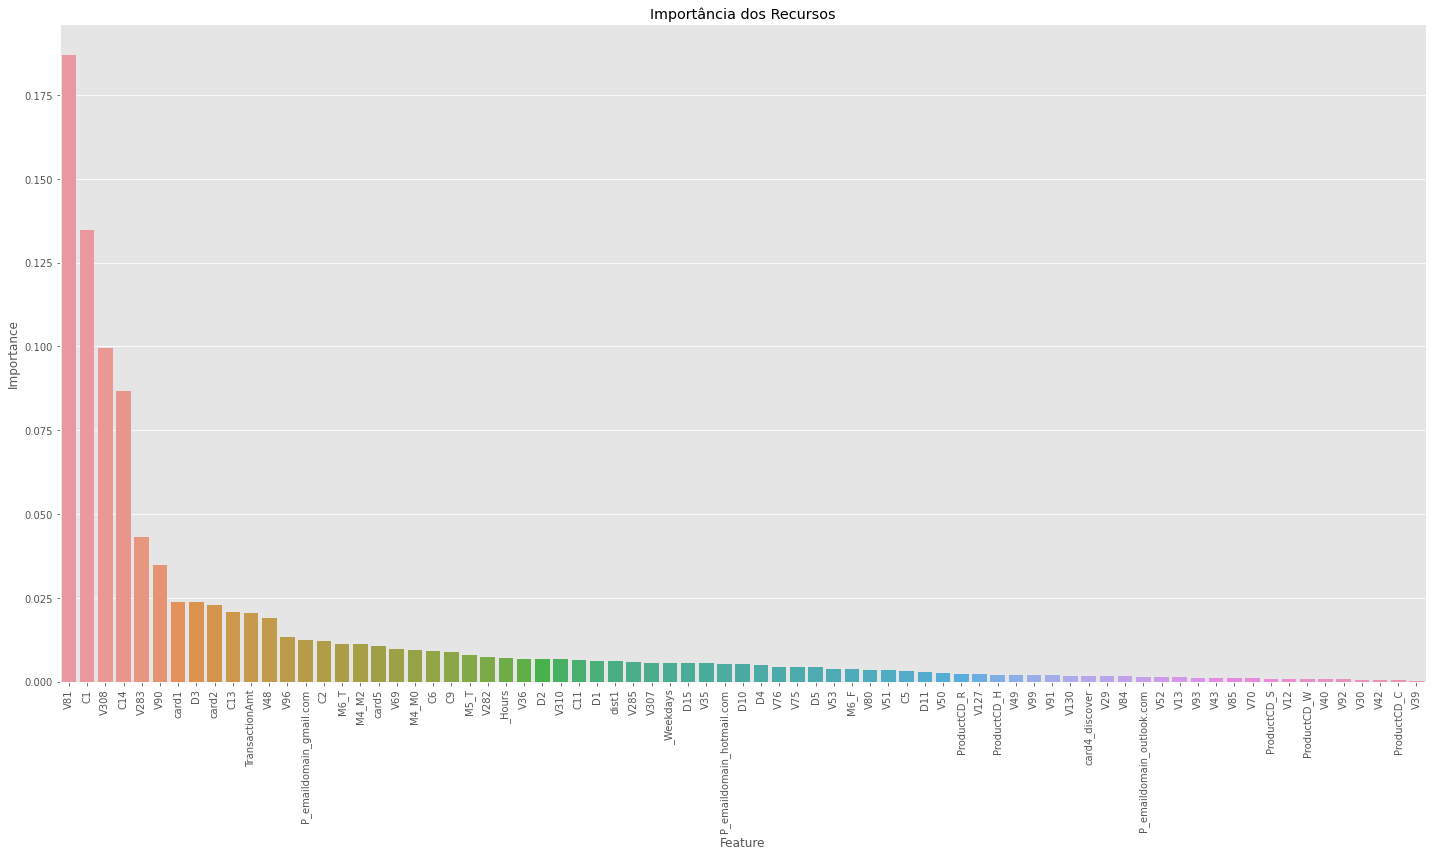

In [122]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6197319	total: 65.8ms	remaining: 263ms
1:	learn: 0.5528627	total: 134ms	remaining: 201ms
2:	learn: 0.5110298	total: 199ms	remaining: 133ms
3:	learn: 0.4778530	total: 266ms	remaining: 66.4ms
4:	learn: 0.4468749	total: 334ms	remaining: 0us
0:	learn: 0.5390765	total: 7.39ms	remaining: 29.6ms
1:	learn: 0.4295084	total: 14.6ms	remaining: 21.9ms
2:	learn: 0.3517191	total: 21.3ms	remaining: 14.2ms
3:	learn: 0.2959920	total: 28.8ms	remaining: 7.2ms
4:	learn: 0.2519843	total: 36.3ms	remaining: 0us
0:	learn: 0.5390158	total: 7.45ms	remaining: 29.8ms
1:	learn: 0.4297227	total: 15.3ms	remaining: 23ms
2:	learn: 0.3516299	total: 22.1ms	remaining: 14.8ms
3:	learn: 0.2972926	total: 29.2ms	remaining: 7.3ms
4:	learn: 0.2528231	total: 36.8ms	remaining: 0us
0:	learn: 0.5387900	total: 7.17ms	remaining: 28.7ms
1:	learn: 0.4292383	total: 14.2ms	remaining: 21.3ms
2:	learn: 0.3512399	total: 21.1ms	remaining: 14.1ms
3:	learn: 0.2970327	total: 28.2ms	remaining: 7.04ms
4:	learn: 0.2526928	total: 37.3m

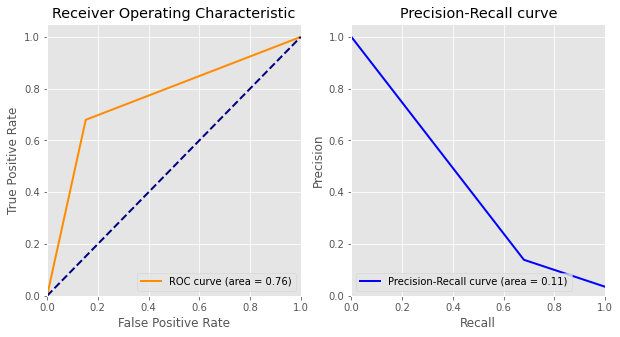

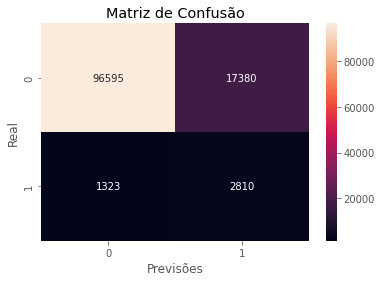

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 38 s, sys: 756 ms, total: 38.8 s
Wall time: 21.5 s


In [123]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [124]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8.17 s, sys: 116 ms, total: 8.29 s
Wall time: 7.78 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.231057024215763  0.911733752412774
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.069924243068368  0.077687748201985
Threshold: 0.25  0.079847682513239  0.314565573891589
Threshold: 0.3   0.098012433460561  0.552448394023271
Threshold: 0.35  0.130782723087042  0.737861188865134
Threshold: 0.4   0.156091253348111  0.810541812677546
Threshold: 0.45  0.184510718160758  0.862410014100883
Threshold: 0.5   0.231057024215763  0.911733752412774
Threshold: 0.55  0.303241062734734  0.954840919950595
Threshold: 0.6   0.346501572327044  0.970580428242789
Threshold: 0.65  0.368331367151658   0.97891831119005
Threshold: 0.7   0.320515051331129  0.983056289566059
Threshold: 0.75  0.213875205254516  0.983444567397469

In [125]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
32                        V49  17.375176629419375
31                        V48  13.389057540856545
12                        C14  11.755936850767034
36                        V53  11.164196530524995
44                        V85   7.327124880831308
5                          C1   6.707384032362660
23                        V29   6.374144411260289
57                       V308   5.245047363209657
35                        V52   5.161335389218374
10                        C11   2.904489401635414
8                          C6   2.402213352382027
45                        V90   1.743706314332613
54                       V283   1.729635023756261
49                        V96   1.593221432073412
6                          C2   1.543815187196176
17                         D5   1.343522639672367
71                      M4_M2   1.159436564549530
67    P_emaildomain_gmail.com   1.080556455951967
50                        V99   0.000000000000000
48                        V93   0.000000000000000
51                       V127   0.000000000000000
46                        V91   0.000000000000000
52                       V130   0.000000000000000
53                       V282   0.000000000000000
55                       V285   0.000000000000000
47                        V92   0.000000000000000
0              TransactionAmt   0.000000000000000
56                       V307   0.000000000000000
58                       V310   0.000000000000000
59                  _Weekdays   0.000000000000000
43                        V84   0.000000000000000
61                ProductCD_C   0.000000000000000
62                ProductCD_H   0.000000000000000
63                ProductCD_R   0.000000000000000
64                ProductCD_S   0.000000000000000
65                ProductCD_W   0.000000000000000
66             card4_discover   0.000000000000000
68  P_emaildomain_hotmail.com   0.000000000000000
69  P_emaildomain_outlook.com   0.000000000000000
70                      M4_M0   0.000000000000000
72                       M5_T   0.000000000000000
73                       M6_F   0.000000000000000
60                     _Hours   0.000000000000000
37                        V69   0.000000000000000
42                        V81   0.000000000000000
21                        V12   0.000000000000000
2                       card2   0.000000000000000
3                       card5   0.000000000000000
4                       dist1   0.000000000000000
7                          C5   0.000000000000000
9                          C9   0.000000000000000
11                        C13   0.000000000000000
13                         D1   0.000000000000000
14                         D2   0.000000000000000
15                         D3   0.000000000000000
16                         D4   0.000000000000000
18                        D10   0.000000000000000
19                        D11   0.000000000000000
20                        D15   0.000000000000000
22                        V13   0.000000000000000
41                        V80   0.000000000000000
24                        V30   0.000000000000000
25                        V35   0.000000000000000
26                        V36   0.000000000000000
27                        V39   0.000000000000000
28                        V40   0.000000000000000
29                        V42   0.000000000000000
30                        V43   0.000000000000000
33                        V50   0.000000000000000
34                        V51   0.000000000000000
1                       card1   0.000000000000000
38                        V70   0.000000000000000
39                        V75   0.000000000000000
40                        V76   0.000000000000000
74                       M6_T   0.000000000000000

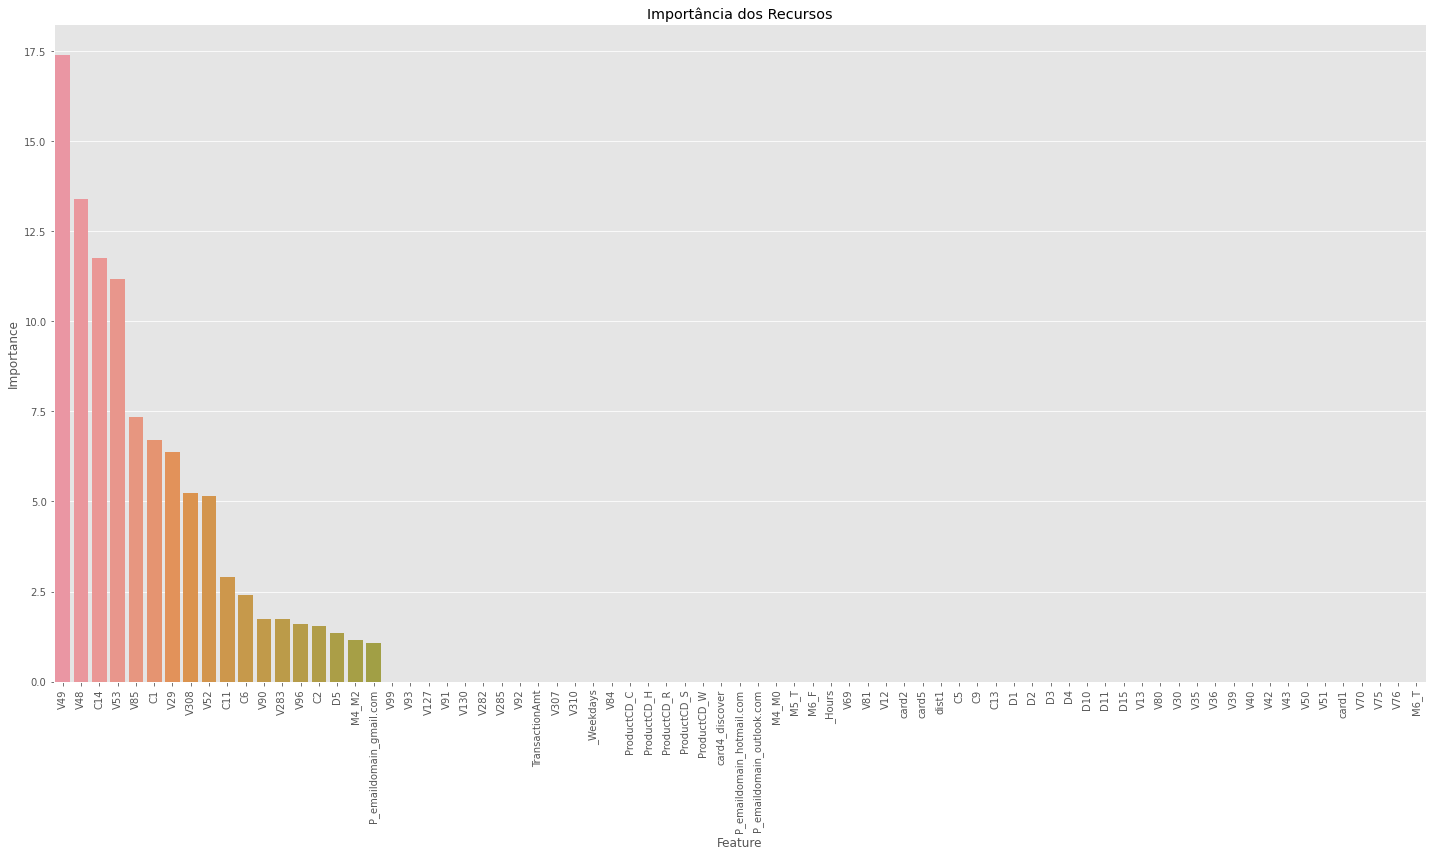

In [126]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3139791059626182
F1-Score Negativo (Teste): 0.9565463998739561
F1-Score Positivo Médio (Validação Cruzada): 0.3218858482918533
F1-Score Positivo Fold 1: 0.4555160142348754
F1-Score Positivo Fold 2: 0.3800738007380074
F1-Score Positivo Fold 3: 0.38888888888888884
F1-Score Positivo Fold 4: 0.3747680890538034
F1-Score Positivo Fold 5: 0.36882129277566544
F1-Score Positivo Fold 6: 0.39272727272727276
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.3155893536121673
F1-Score Positivo Fold 9: 0.33904761904761904
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9846295402617529
F1-Score Negativo Fold 1: 0.9867302688638335
F1-Score Negativo Fold 2: 0.9854419410745233
F1-Score Negativo Fold 3: 0.9857031453080323
F1-Score Negativo Fold 4: 0.9854005111987176
F1-Score Negativo Fold 5: 0.9856252164877036
F1-Score Negativo Fold 6: 0.9855235783633842
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score

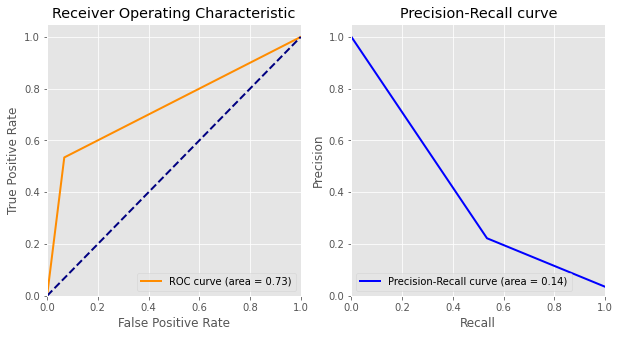

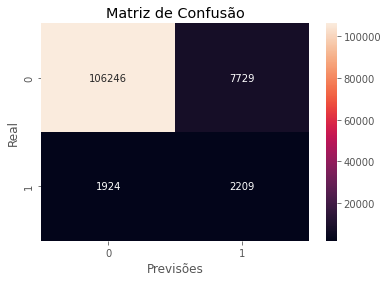

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.53      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.64    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 6min 35s, sys: 312 ms, total: 6min 35s
Wall time: 6min 35s


In [127]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [128]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.6 s, sys: 4 ms, total: 2.61 s
Wall time: 2.61 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.313979105962618  0.956546399873956
Threshold: 0.05  0.099245155767684  0.563520494739621
Threshold: 0.1   0.127985887350818  0.731859871694813
Threshold: 0.15  0.152783552783553  0.809896022309072
Threshold: 0.2   0.178439296488133  0.856433821701031
Threshold: 0.25  0.201925722145805   0.88795767032288
Threshold: 0.3   0.225540721503064  0.909794728060764
Threshold: 0.35  0.249399349884581  0.925889231542079
Threshold: 0.4   0.273665714913244  0.939322214271298
Threshold: 0.45   0.29209557676711  0.948466530721614
Threshold: 0.5   0.313979105962618  0.956546399873956
Threshold: 0.55  0.335699306339732  0.963202244680946
Threshold: 0.6   0.351779017652977  0.968541789660116
Threshold: 0.65  0.363955771416761   0.97283028529304
Threshold: 0.7   0.368200836820084  0.976117252165967
Threshold: 0.75  0.370409372120574  0.979078729239477

In [129]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
42                        V81  0.262546208756841
12                        C14  0.123502808438239
57                       V308  0.119740802871017
10                        C11  0.086153443846116
32                        V49  0.073431358638792
67    P_emaildomain_gmail.com  0.043866195008137
49                        V96  0.037246819365345
5                          C1  0.032264590009271
53                       V282  0.021590178804936
72                       M5_T  0.019891379581660
15                         D3  0.017725356725078
60                     _Hours  0.014459010238472
59                  _Weekdays  0.013106774641228
0              TransactionAmt  0.012777147979361
36                        V53  0.012020635494890
73                       M6_F  0.009997025116516
74                       M6_T  0.009715220081755
11                        C13  0.008876819117770
8                          C6  0.008061351337490
35                        V52  0.007044736452848
21                        V12  0.006909654548270
54                       V283  0.006185155018421
51                       V127  0.005181049979761
9                          C9  0.005135568661867
28                        V40  0.004703100867645
18                        D10  0.004504971813326
25                        V35  0.004329218098743
71                      M4_M2  0.004105247492102
4                       dist1  0.003853658725611
19                        D11  0.003064050647929
70                      M4_M0  0.002748000728689
52                       V130  0.002464836510791
1                       card1  0.002450653007856
68  P_emaildomain_hotmail.com  0.002230114111030
55                       V285  0.002018927963511
50                        V99  0.001940069938996
69  P_emaildomain_outlook.com  0.001368113903769
66             card4_discover  0.001082568609570
3                       card5  0.000872682252133
2                       card2  0.000834494614222
56                       V307  0.000000000000000
17                         D5  0.000000000000000
58                       V310  0.000000000000000
7                          C5  0.000000000000000
6                          C2  0.000000000000000
61                ProductCD_C  0.000000000000000
62                ProductCD_H  0.000000000000000
64                ProductCD_S  0.000000000000000
65                ProductCD_W  0.000000000000000
63                ProductCD_R  0.000000000000000
46                        V91  0.000000000000000
48                        V93  0.000000000000000
47                        V92  0.000000000000000
20                        D15  0.000000000000000
22                        V13  0.000000000000000
23                        V29  0.000000000000000
24                        V30  0.000000000000000
26                        V36  0.000000000000000
27                        V39  0.000000000000000
29                        V42  0.000000000000000
30                        V43  0.000000000000000
31                        V48  0.000000000000000
16                         D4  0.000000000000000
33                        V50  0.000000000000000
34                        V51  0.000000000000000
14                         D2  0.000000000000000
38                        V70  0.000000000000000
39                        V75  0.000000000000000
40                        V76  0.000000000000000
41                        V80  0.000000000000000
13                         D1  0.000000000000000
43                        V84  0.000000000000000
44                        V85  0.000000000000000
45                        V90  0.000000000000000
37                        V69  0.000000000000000

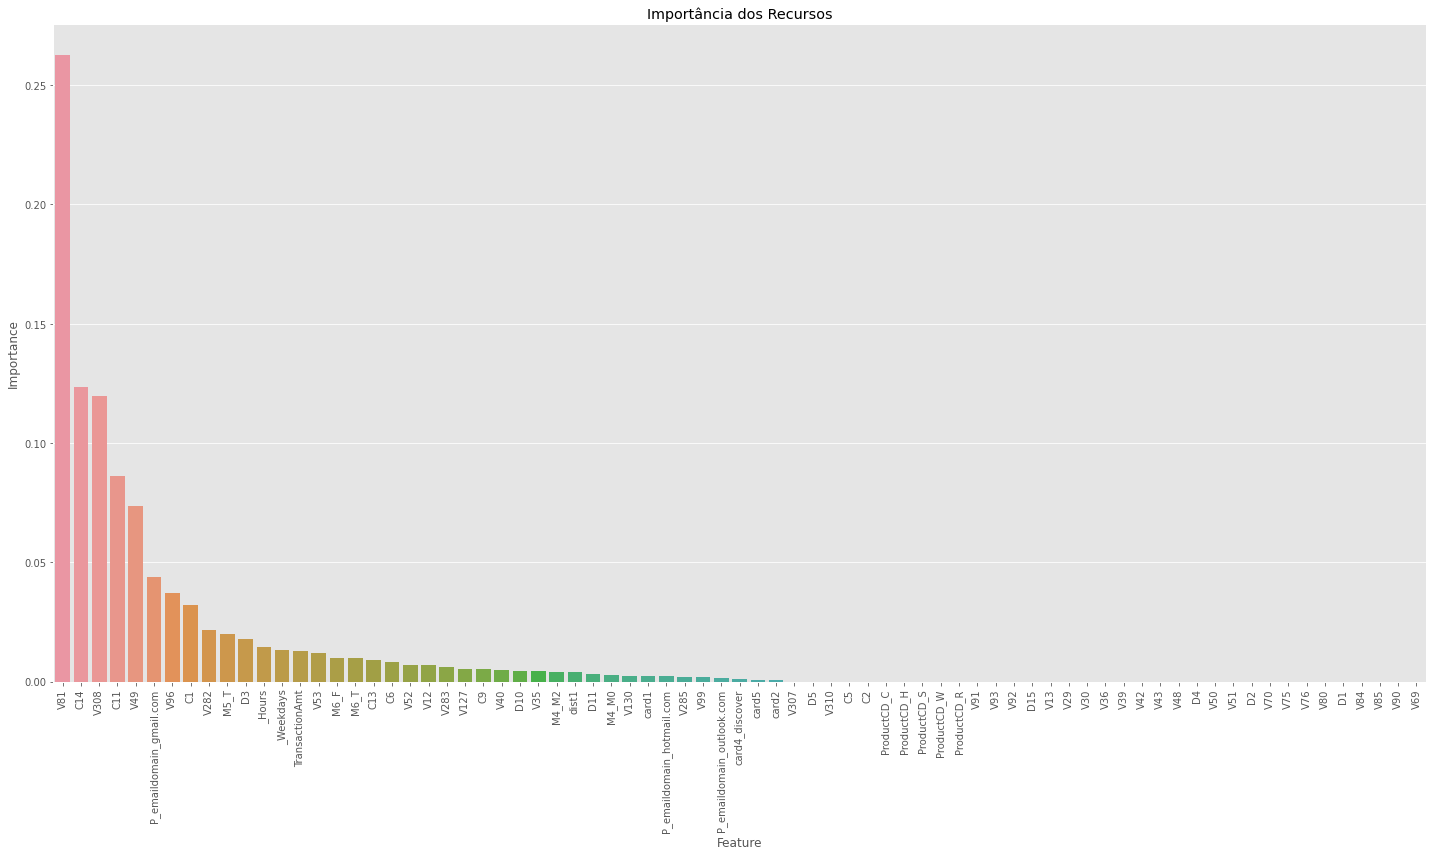

In [130]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3049321236100689
F1-Score Negativo (Teste): 0.9540118344263553
F1-Score Positivo Médio (Validação Cruzada): 0.33437990629974634
F1-Score Positivo Fold 1: 0.3849056603773585
F1-Score Positivo Fold 2: 0.3529411764705882
F1-Score Positivo Fold 3: 0.36466165413533835
F1-Score Positivo Fold 4: 0.3109404990403071
F1-Score Positivo Fold 5: 0.35067437379576105
F1-Score Positivo Fold 6: 0.37064220183486235
F1-Score Positivo Fold 7: 0.324853228962818
F1-Score Positivo Fold 8: 0.2862669245647969
F1-Score Positivo Fold 9: 0.289628180039139
F1-Score Positivo Fold 10: 0.30828516377649323
F1-Score Negativo Médio (Validação Cruzada): 0.9849341353723826
F1-Score Negativo Fold 1: 0.9858825567296035
F1-Score Negativo Fold 2: 0.985234899328859
F1-Score Negativo Fold 3: 0.9853616284105673
F1-Score Negativo Fold 4: 0.9844595472057486
F1-Score Negativo Fold 5: 0.9854131498073845
F1-Score Negativo Fold 6: 0.985136716210946
F1-Score Negativo Fold 7: 0.9850720436155943
F1-Score Nega

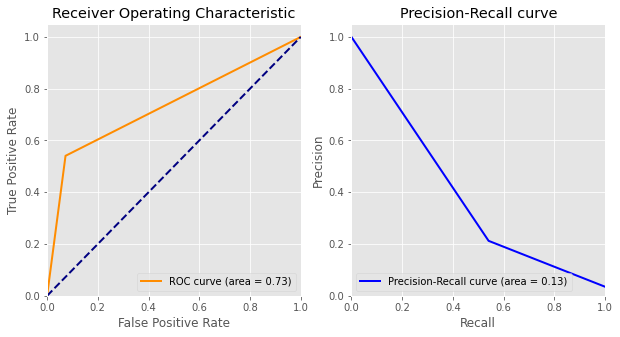

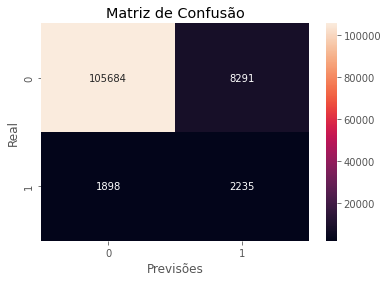

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.21      0.54      0.30      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 8min 6s, sys: 340 ms, total: 8min 7s
Wall time: 8min 6s


In [131]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [132]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 21.1 s, sys: 7 µs, total: 21.1 s
Wall time: 21.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.304932123610069  0.954011834426355
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.304932123610069  0.954011834426355
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [133]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
12                        C14        0.09
5                          C1        0.07
4                       dist1        0.06
49                        V96        0.05
60                     _Hours        0.04
10                        C11        0.04
0              TransactionAmt        0.03
73                       M6_F        0.03
36                        V53        0.03
25                        V35        0.03
15                         D3        0.03
74                       M6_T        0.03
8                          C6        0.03
19                        D11        0.02
35                        V52        0.02
32                        V49        0.02
53                       V282        0.02
54                       V283        0.02
42                        V81        0.02
37                        V69        0.02
1                       card1        0.02
71                      M4_M2        0.02
67    P_emaildomain_gmail.com        0.01
6                          C2        0.01
2                       card2        0.01
51                       V127        0.01
52                       V130        0.01
72                       M5_T        0.01
70                      M4_M0        0.01
68  P_emaildomain_hotmail.com        0.01
57                       V308        0.01
58                       V310        0.01
59                  _Weekdays        0.01
69  P_emaildomain_outlook.com        0.01
3                       card5        0.01
62                ProductCD_H        0.01
66             card4_discover        0.01
55                       V285        0.01
11                        C13        0.01
7                          C5        0.01
33                        V50        0.01
9                          C9        0.01
16                         D4        0.01
18                        D10        0.01
21                        V12        0.01
22                        V13        0.01
30                        V43        0.01
34                        V51        0.01
61                ProductCD_C        0.00
23                        V29        0.00
63                ProductCD_R        0.00
64                ProductCD_S        0.00
39                        V75        0.00
65                ProductCD_W        0.00
26                        V36        0.00
20                        D15        0.00
17                         D5        0.00
14                         D2        0.00
24                        V30        0.00
28                        V40        0.00
27                        V39        0.00
40                        V76        0.00
56                       V307        0.00
29                        V42        0.00
31                        V48        0.00
50                        V99        0.00
48                        V93        0.00
47                        V92        0.00
46                        V91        0.00
45                        V90        0.00
44                        V85        0.00
13                         D1        0.00
38                        V70        0.00
41                        V80        0.00
43                        V84        0.00

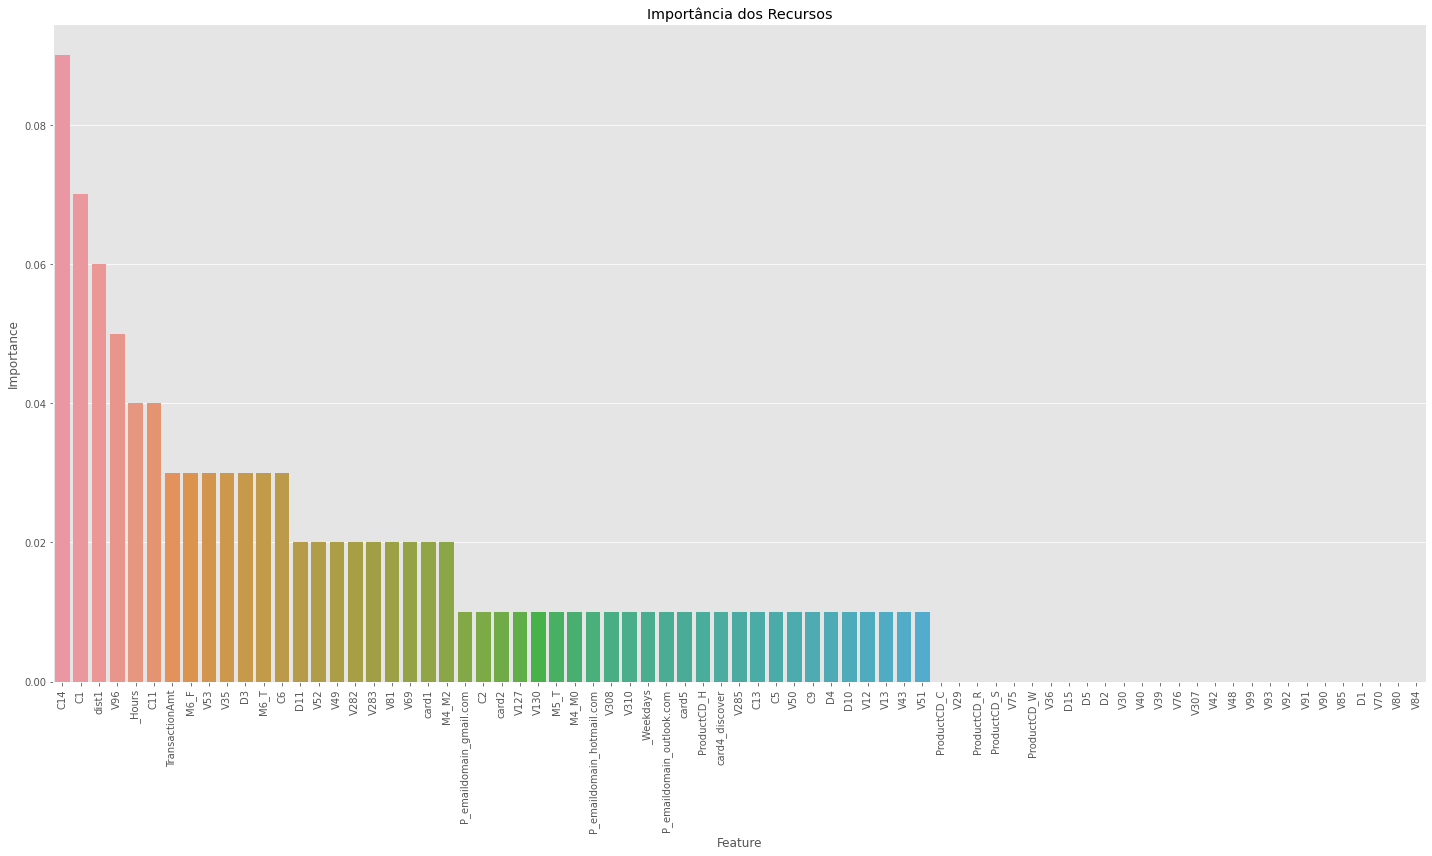

In [134]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.32383748081926744
F1-Score Negativo (Teste): 0.9541873279482161
F1-Score Positivo Médio (Validação Cruzada): 0.2578600872425979
F1-Score Positivo Fold 1: 0.25614035087719306
F1-Score Positivo Fold 2: 0.2416812609457093
F1-Score Positivo Fold 3: 0.2601054481546573
F1-Score Positivo Fold 4: 0.23049645390070922
F1-Score Positivo Fold 5: 0.2727272727272727
F1-Score Positivo Fold 6: 0.23569023569023567
F1-Score Positivo Fold 7: 0.27586206896551724
F1-Score Positivo Fold 8: 0.2384341637010676
F1-Score Positivo Fold 9: 0.27692307692307694
F1-Score Positivo Fold 10: 0.2905405405405405
F1-Score Negativo Médio (Validação Cruzada): 0.9814585261719418
F1-Score Negativo Fold 1: 0.9816068020128406
F1-Score Negativo Fold 2: 0.9812155654852284
F1-Score Negativo Fold 3: 0.9817377347850605
F1-Score Negativo Fold 4: 0.981177899210686
F1-Score Negativo Fold 5: 0.9819522776572669
F1-Score Negativo Fold 6: 0.9802848705923225
F1-Score Negativo Fold 7: 0.9817724155889246
F1-Score 

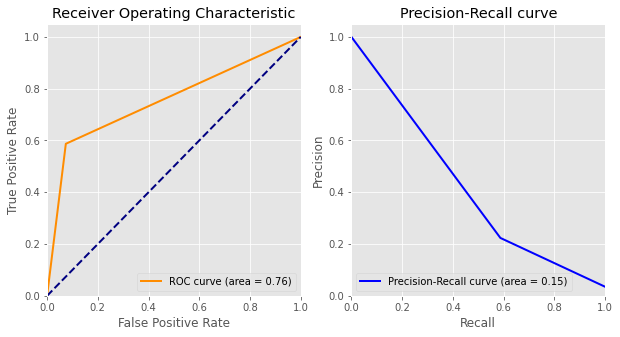

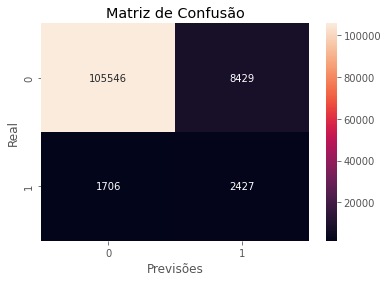

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 22min 28s, sys: 864 ms, total: 22min 29s
Wall time: 2min


In [135]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [136]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4h 40min 11s, sys: 1.16 s, total: 4h 40min 12s
Wall time: 23min 41s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.323837480819267  0.954187327948216
Threshold: 0.05  0.267993497216612  0.931181889337106
Threshold: 0.1   0.267993497216612  0.931181889337106
Threshold: 0.15  0.267993497216612  0.931181889337106
Threshold: 0.2   0.267993497216612  0.931181889337106
Threshold: 0.25  0.267993497216612  0.931181889337106
Threshold: 0.3   0.267993497216612  0.931181889337106
Threshold: 0.35  0.323837480819267  0.954187327948216
Threshold: 0.4   0.323837480819267  0.954187327948216
Threshold: 0.45  0.323837480819267  0.954187327948216
Threshold: 0.5   0.323837480819267  0.954187327948216
Threshold: 0.55  0.323837480819267  0.954187327948216
Threshold: 0.6   0.323837480819267  0.954187327948216
Threshold: 0.65  0.323837480819267  0.954187327948216
Threshold: 0.7   0.401281537845415   0.97356649044327
Threshold: 0.75  0.401281537845415   0.97356649044327

### Todas as colunas

In [137]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6750037667620913
F1-Score Negativo (Teste): 0.9906045413561345
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Nega

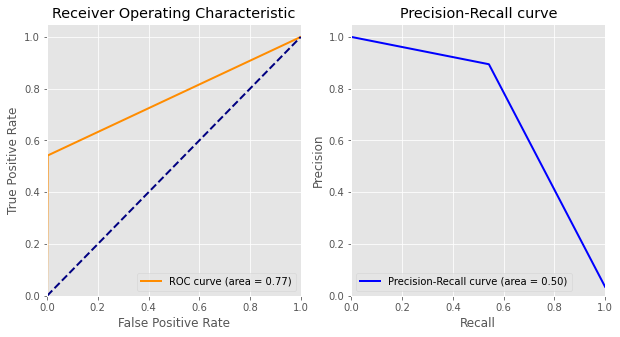

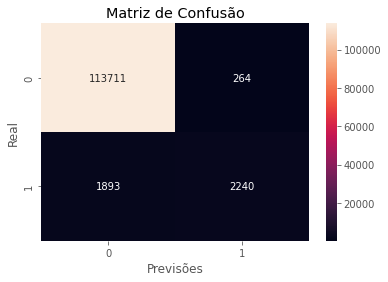

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 44s, sys: 320 ms, total: 8min 44s
Wall time: 8min 44s


In [138]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [139]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.8 s, sys: 4 µs, total: 53.8 s
Wall time: 53.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675003766762091  0.990604541356135
Threshold: 0.05  0.271667773106144  0.905558053007623
Threshold: 0.1   0.442991732359162  0.960605222720329
Threshold: 0.15  0.565966241818808  0.977560506491425
Threshold: 0.2    0.64401894173358  0.984733026639941
Threshold: 0.25  0.683997689196996  0.987981244589363
Threshold: 0.3   0.708504544888557  0.989740780507045
Threshold: 0.35   0.71462388216728  0.990507934841566
Threshold: 0.4   0.707976814794369  0.990758614665677
Threshold: 0.45  0.697017720789512  0.990827608766765
Threshold: 0.5    0.67941440095608  0.990650133756241
Threshold: 0.55  0.659133126934984  0.990415919497206
Threshold: 0.6   0.632134292565947  0.989993955496802
Threshold: 0.65   0.59973492379059   0.98950386653923
Threshold: 0.7   0.559807791316286  0.988866655960137
Threshold: 0.75  0.522324592487597  0.988307340006592

In [140]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
101         P_emaildomain_gmail.com  0.047850098816486
152                           M4_M2  0.030930370213672
155                            M6_F  0.028689090800970
76                      ProductCD_C  0.027734409165166
156                            M6_T  0.022642930448220
154                            M5_T  0.022241503266376
80                      ProductCD_W  0.017043099041214
138         P_emaildomain_yahoo.com  0.016619039817943
153                            M5_F  0.016174366469425
2                             card2  0.014665757622277
6                                C1  0.014267631674927
0                    TransactionAmt  0.013839602313863
13                              C14  0.013769663986621
77                      ProductCD_H  0.013517683059351
68                             V283  0.013505547231746
159                            M8_F  0.013485065094913
1                             card1  0.013483620669755
150                           M4_M0  0.012675725832661
45                              V50  0.012662511494651
104       P_emaildomain_hotmail.com  0.012546609060189
15                               D2  0.012324116575368
83                 card4_mastercard  0.012302562458096
7                                C2  0.012247814339430
78                      ProductCD_R  0.012053840326024
46                              V51  0.011633972093166
74                           _Hours  0.011540623031827
84                       card4_visa  0.011367388171397
73                        _Weekdays  0.011134479699164
50                              V69  0.011115116838556
67                             V282  0.011049592078888
12                              C13  0.010927780089497
51                              V70  0.010872629980188
58                              V90  0.010574252946746
66                             V280  0.010539237776673
11                              C11  0.010499143050742
3                             card5  0.010477557412124
149                            M3_T  0.010415892542082
75                            _Days  0.010206062667896
160                            M8_T  0.010158127568603
148                            M3_F  0.009698462643829
35                              V29  0.009602908098125
48                              V53  0.009566526303396
14                               D1  0.009069325358819
9                                C6  0.008853781096100
62                              V96  0.008849682388522
47                              V52  0.008812666883661
4                             addr1  0.008807852665637
59                              V91  0.008335274343730
44                              V49  0.008249858271812
52                              V75  0.008161805223816
33                              V12  0.008047607327482
86      P_emaildomain_anonymous.com  0.007993016280241
34                              V13  0.007965112903094
43                              V48  0.007895946037602
151                           M4_M1  0.007712793198402
61                              V93  0.007667770966125
41                              V42  0.007646734288150
53                              V76  0.007614622093601
49                              V54  0.007535619827734
71                             V308  0.007163233993361
69                             V285  0.007125423124996
70                             V307  0.007094002802662
37                              V35  0.007034496290634
31                              V10  0.006789525961801
39                              V39  0.006731225857240
64                             V127  0.006728155593058
22                               V1  0.006426113452049
42                              V43  0.006400008092551
19                              D10  0.006251383499767
18                               D5  0.006204125017769
38                              V36  0.006021320494049
56                              V84  0.005876480336809
40           

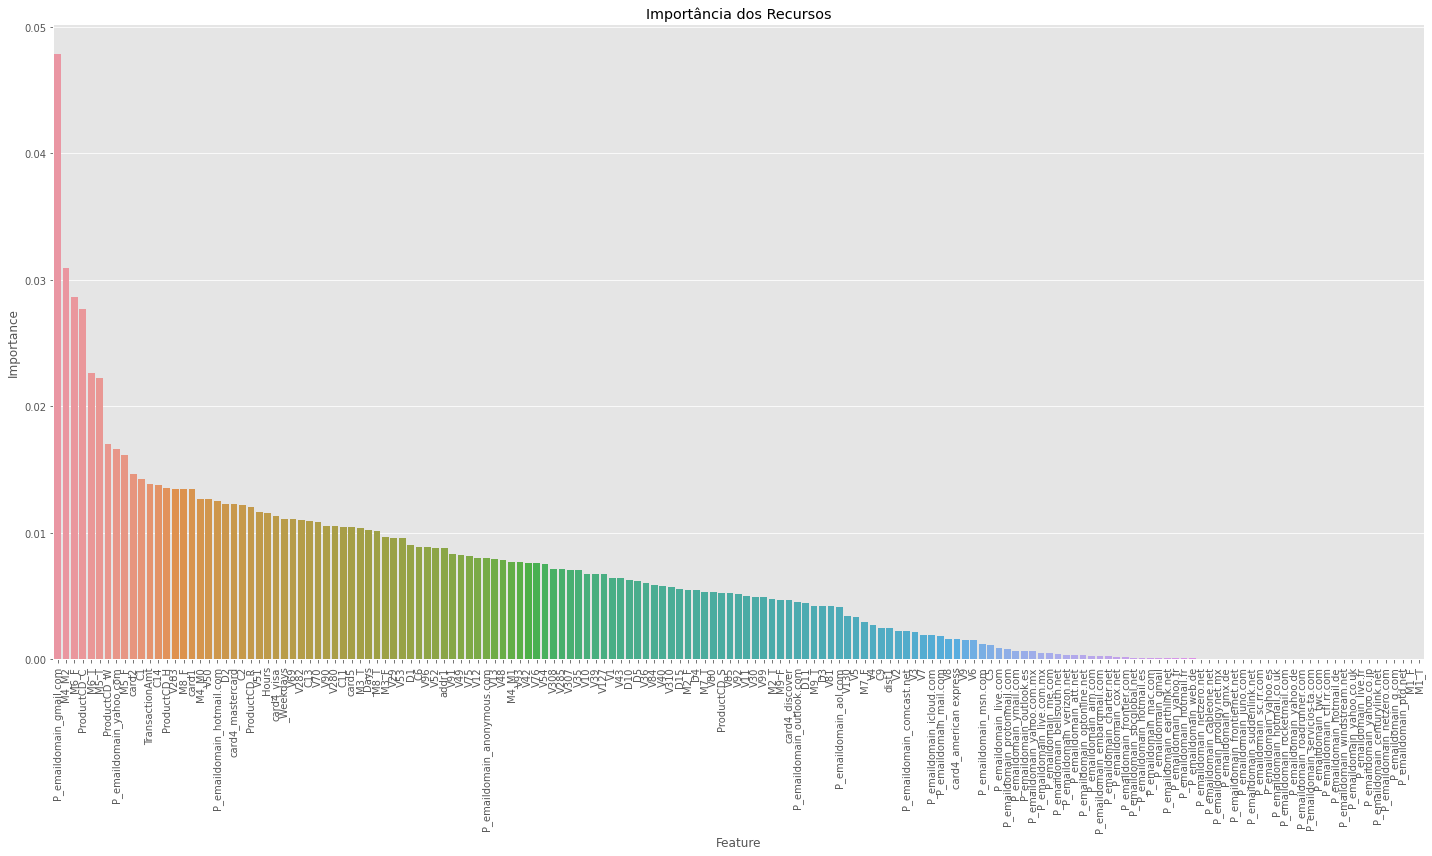

In [141]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score 

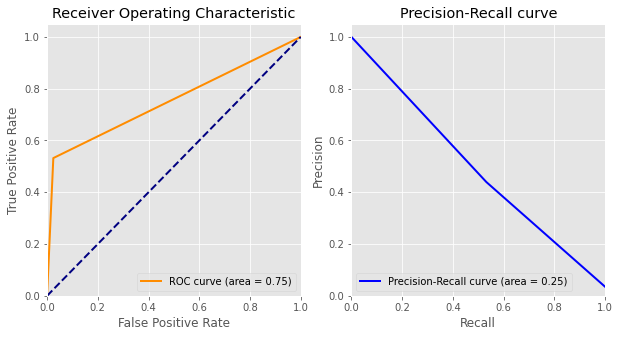

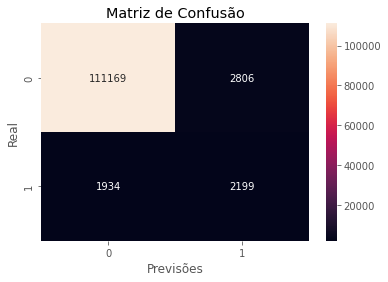

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.53      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 55s, sys: 312 ms, total: 1min 55s
Wall time: 1min 55s


In [142]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [143]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.23 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.481286933683519  0.979126115255551
Threshold: 0.05  0.481234270707955  0.979121619538747
Threshold: 0.1   0.481234270707955  0.979121619538747
Threshold: 0.15  0.481234270707955  0.979121619538747
Threshold: 0.2   0.481234270707955  0.979121619538747
Threshold: 0.25  0.481234270707955  0.979121619538747
Threshold: 0.3   0.481234270707955  0.979121619538747
Threshold: 0.35  0.481234270707955  0.979121619538747
Threshold: 0.4   0.481234270707955  0.979121619538747
Threshold: 0.45  0.481234270707955  0.979121619538747
Threshold: 0.5   0.481234270707955  0.979121619538747
Threshold: 0.55  0.481286933683519  0.979126115255551
Threshold: 0.6   0.481286933683519  0.979126115255551
Threshold: 0.65  0.481286933683519  0.979126115255551
Threshold: 0.7   0.481286933683519  0.979126115255551
Threshold: 0.75  0.481286933683519  0.979126115255551

In [144]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
66                             V280  0.208198604944897
55                              V81  0.185117347358276
6                                C1  0.131671978201993
13                              C14  0.078444949023061
58                              V90  0.052892001355413
12                              C13  0.020738491109903
71                             V308  0.017123024151449
153                            M5_F  0.015357663646515
2                             card2  0.013115476083717
101         P_emaildomain_gmail.com  0.011916699208126
0                    TransactionAmt  0.011849291269278
150                           M4_M0  0.011571783370837
1                             card1  0.011362159294202
152                           M4_M2  0.011199525730038
68                             V283  0.010446563612269
67                             V282  0.009212345604611
62                              V96  0.008042720291277
69                             V285  0.007415668378566
4                             addr1  0.006887898546261
7                                C2  0.006314209006563
3                             card5  0.005817076528772
104       P_emaildomain_hotmail.com  0.005686881739781
156                            M6_T  0.005587349909007
75                            _Days  0.005585199015516
16                               D3  0.005087703274241
54                              V80  0.004704655207980
74                           _Hours  0.004575553896435
11                              C11  0.004381530538412
43                              V48  0.004370350212046
9                                C6  0.003876649935316
72                             V310  0.003827250133241
64                             V127  0.003522457125256
14                               D1  0.003436274848548
138         P_emaildomain_yahoo.com  0.003358807982225
21                              D15  0.003340925368771
70                             V307  0.003327914494774
15                               D2  0.003242119220599
46                              V51  0.003172317070004
19                              D10  0.003126408837577
17                               D4  0.003106996642566
73                        _Weekdays  0.003061042993206
86      P_emaildomain_anonymous.com  0.002909400760667
149                            M3_T  0.002895830274075
5                             dist1  0.002838469207835
10                               C9  0.002632666579298
155                            M6_F  0.002628512335412
82                   card4_discover  0.002341852838579
154                            M5_T  0.002327929615698
18                               D5  0.002319396510100
59                              V91  0.002174182708043
78                      ProductCD_R  0.002087881611569
57                              V85  0.001994341160646
48                              V53  0.001947909644035
38                              V36  0.001920574607838
26                               V5  0.001886184220543
53                              V76  0.001857598077776
84                       card4_visa  0.001830874313174
35                              V29  0.001795529575165
162                            M9_T  0.001759382316377
47                              V52  0.001604465586711
77                      ProductCD_H  0.001589957847354
52                              V75  0.001569443801364
120       P_emaildomain_outlook.com  0.001556694669075
33                              V12  0.001547932430889
63                              V99  0.001498326257177
34                              V13  0.001438615644475
65                             V130  0.001378374156193
37                              V35  0.001263327740354
83                 card4_mastercard  0.001246481329986
20                              D11  0.001222380053129
39                              V39  0.001215651146946
25                               V4  0.001202208308953
8            

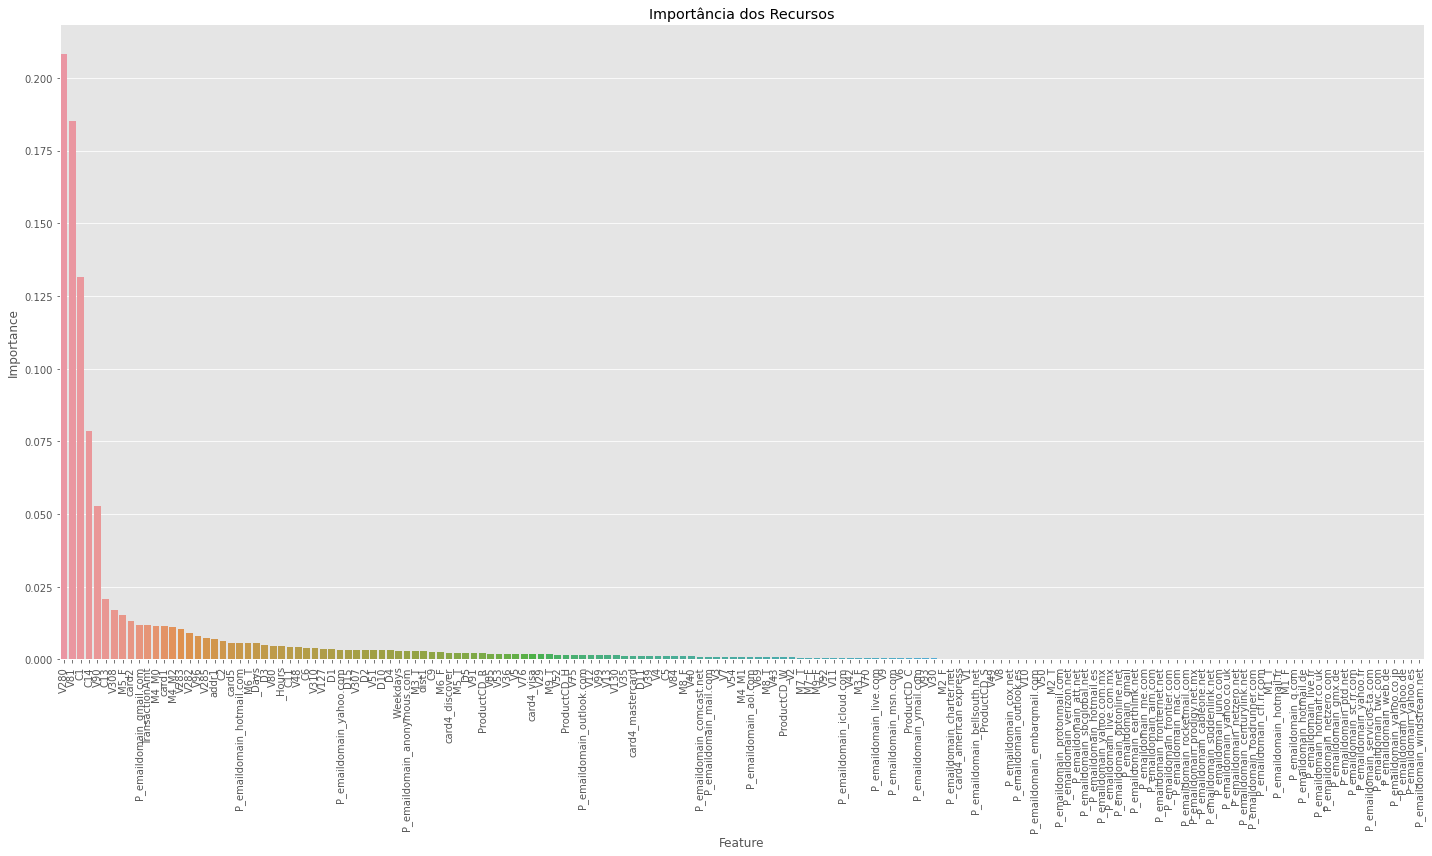

In [145]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6057922	total: 75.9ms	remaining: 304ms
1:	learn: 0.5400358	total: 151ms	remaining: 227ms
2:	learn: 0.4834998	total: 225ms	remaining: 150ms
3:	learn: 0.4519096	total: 298ms	remaining: 74.4ms
4:	learn: 0.4196478	total: 371ms	remaining: 0us
0:	learn: 0.5336608	total: 12.9ms	remaining: 51.5ms
1:	learn: 0.4271318	total: 22.6ms	remaining: 33.9ms
2:	learn: 0.3416706	total: 31.2ms	remaining: 20.8ms
3:	learn: 0.2888256	total: 39ms	remaining: 9.76ms
4:	learn: 0.2438958	total: 47.6ms	remaining: 0us
0:	learn: 0.5331992	total: 7.82ms	remaining: 31.3ms
1:	learn: 0.4266171	total: 16.3ms	remaining: 24.5ms
2:	learn: 0.3413103	total: 24.8ms	remaining: 16.5ms
3:	learn: 0.2883925	total: 32.6ms	remaining: 8.16ms
4:	learn: 0.2434156	total: 41.3ms	remaining: 0us
0:	learn: 0.5334749	total: 8.5ms	remaining: 34ms
1:	learn: 0.4268605	total: 17.2ms	remaining: 25.8ms
2:	learn: 0.3408881	total: 25.4ms	remaining: 16.9ms
3:	learn: 0.2880311	total: 33.2ms	remaining: 8.3ms
4:	learn: 0.2431527	total: 41.8ms	

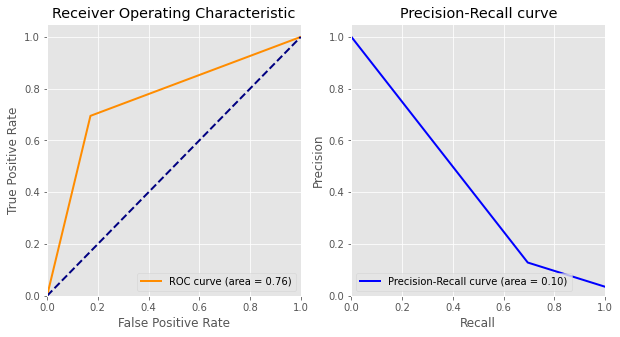

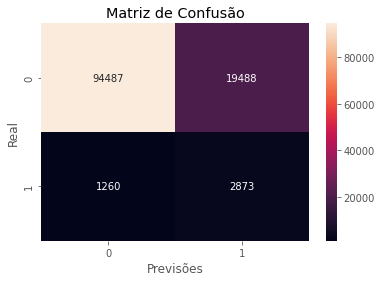

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.13      0.70      0.22      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.76      0.56    118108
weighted avg       0.96      0.82      0.88    118108

CPU times: user 1min 55s, sys: 764 ms, total: 1min 56s
Wall time: 1min 31s


In [146]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [147]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 44.2 s, sys: 43.9 ms, total: 44.2 s
Wall time: 43.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.216879293424926  0.901069034245334
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.073116393926651   0.16757065143151
Threshold: 0.3   0.090246314482188  0.469937154113123
Threshold: 0.35  0.149614721355133   0.79539928048108
Threshold: 0.4   0.184414814814815  0.864046309009908
Threshold: 0.45  0.197506496924241  0.881472375945622
Threshold: 0.5   0.216879293424926  0.901069034245334
Threshold: 0.55  0.289447109315829  0.948913655092298
Threshold: 0.6    0.34407908875994  0.973099466748931
Threshold: 0.65  0.331574740207834  0.981818656206922
Threshold: 0.7   0.219689526429554  0.982818969657374
Threshold: 0.75  0.193589202867988  0.983479786066686

In [148]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
13                              C14  22.464625283874742
66                             V280  18.867186197340700
6                                C1  17.415390672437603
44                              V49  10.546679357165191
43                              V48   9.370930743297997
152                           M4_M2   8.068349941340877
150                           M4_M0   5.166838606092198
57                              V85   2.388736413276762
11                              C11   1.697020995465045
55                              V81   1.337908028331158
51                              V70   0.983038753184622
35                              V29   0.844333828507700
101         P_emaildomain_gmail.com   0.441178249764267
68                             V283   0.407782929921138
116           P_emaildomain_msn.com   0.000000000000000
115            P_emaildomain_me.com   0.000000000000000
108        P_emaildomain_icloud.com   0.000000000000000
119     P_emaildomain_optonline.net   0.000000000000000
117       P_emaildomain_netzero.com   0.000000000000000
118       P_emaildomain_netzero.net   0.000000000000000
114          P_emaildomain_mail.com   0.000000000000000
113           P_emaildomain_mac.com   0.000000000000000
112           P_emaildomain_live.fr   0.000000000000000
111       P_emaildomain_live.com.mx   0.000000000000000
110          P_emaildomain_live.com   0.000000000000000
109          P_emaildomain_juno.com   0.000000000000000
120       P_emaildomain_outlook.com   0.000000000000000
105        P_emaildomain_hotmail.de   0.000000000000000
107        P_emaildomain_hotmail.fr   0.000000000000000
96      P_emaildomain_earthlink.net   0.000000000000000
89      P_emaildomain_bellsouth.net   0.000000000000000
90       P_emaildomain_cableone.net   0.000000000000000
91    P_emaildomain_centurylink.net   0.000000000000000
92         P_emaildomain_cfl.rr.com   0.000000000000000
93        P_emaildomain_charter.net   0.000000000000000
94        P_emaildomain_comcast.net   0.000000000000000
95            P_emaildomain_cox.net   0.000000000000000
97     P_emaildomain_embarqmail.com   0.000000000000000
106        P_emaildomain_hotmail.es   0.000000000000000
98       P_emaildomain_frontier.com   0.000000000000000
99    P_emaildomain_frontiernet.net   0.000000000000000
100             P_emaildomain_gmail   0.000000000000000
102            P_emaildomain_gmx.de   0.000000000000000
103     P_emaildomain_hotmail.co.uk   0.000000000000000
104       P_emaildomain_hotmail.com   0.000000000000000
122    P_emaildomain_prodigy.net.mx   0.000000000000000
121        P_emaildomain_outlook.es   0.000000000000000
0                    TransactionAmt   0.000000000000000
123    P_emaildomain_protonmail.com   0.000000000000000
153                            M5_F   0.000000000000000
144                            M1_F   0.000000000000000
145                            M1_T   0.000000000000000
146                            M2_F   0.000000000000000
147                            M2_T   0.000000000000000
148                            M3_F   0.000000000000000
149                            M3_T   0.000000000000000
151                           M4_M1   0.000000000000000
154                            M5_T   0.000000000000000
142          P_emaildomain_yahoo.fr   0.000000000000000
155                            M6_F   0.000000000000000
156                            M6_T   0.000000000000000
157                            M7_F   0.000000000000000
158                            M7_T   0.000000000000000
159                            M8_F   0.000000000000000
160                            M8_T   0.000000000000000
161                            M9_F   0.000000000000000
143         P_emaildomain_ymail.com   0.000000000000000
141          P_emaildomain_yahoo.es   0.000000000000000
124           P_emaildomain_ptd.net   0.000000000000000
131    P_emaildomain_suddenlink.net   0.000000000000000
87            P_emaildomain_aol.com   0.000000000000

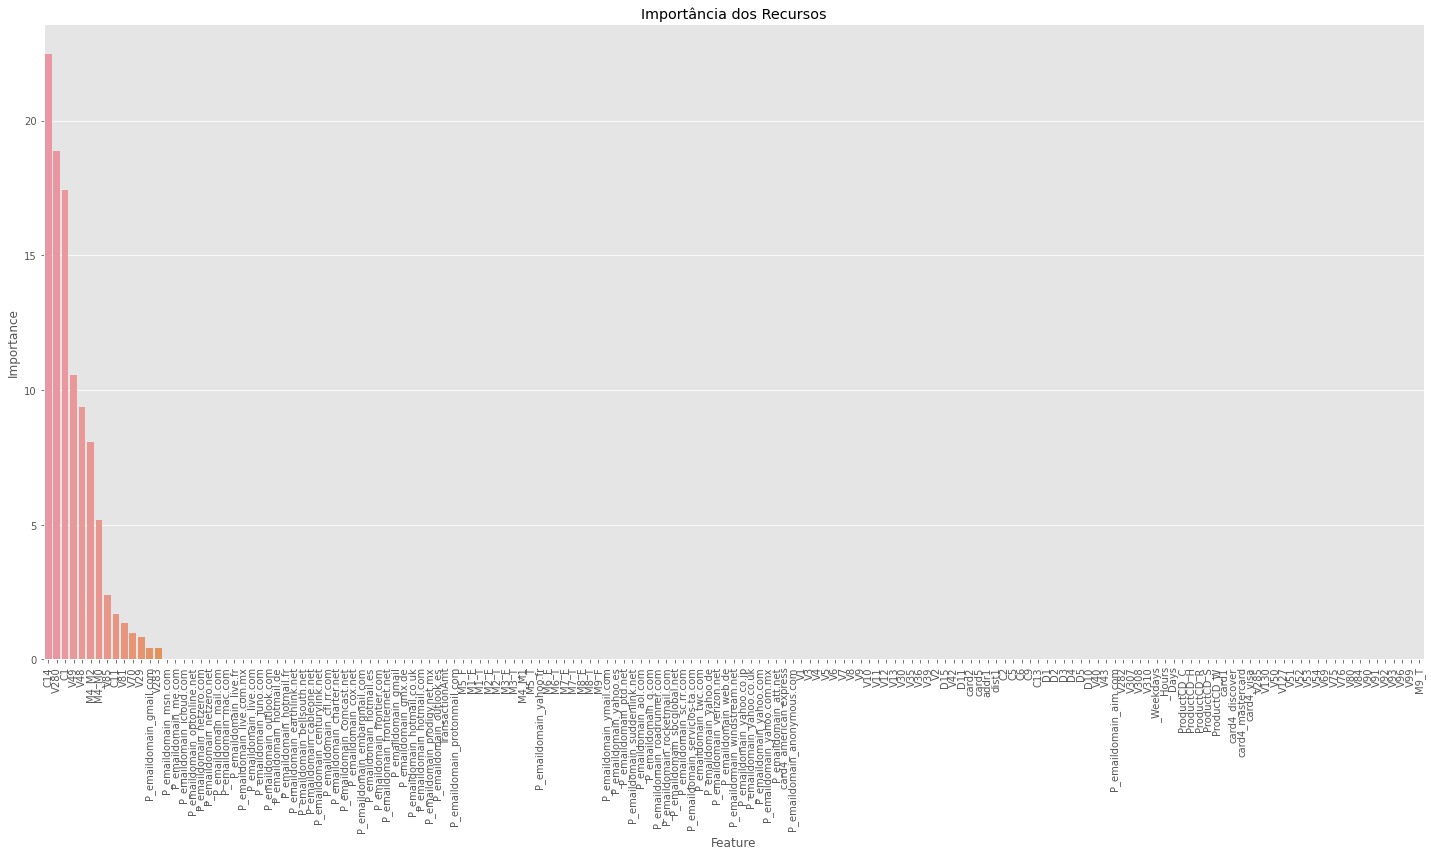

In [149]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3295090923281043
F1-Score Negativo (Teste): 0.9615448315376247
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

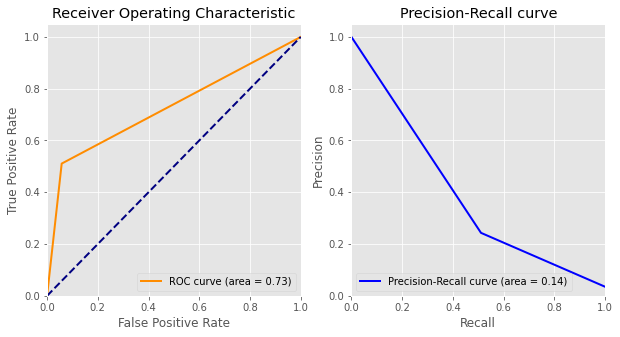

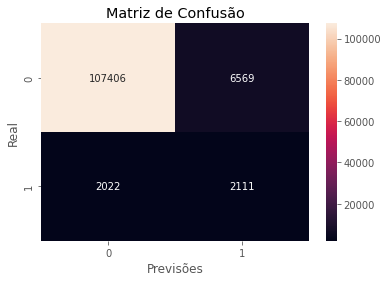

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.51      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.73      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 8min 47s, sys: 336 ms, total: 8min 47s
Wall time: 8min 47s


In [150]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [151]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.77 s, sys: 0 ns, total: 2.77 s
Wall time: 2.77 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.329509092328104  0.961544831537625
Threshold: 0.05  0.101978875804298  0.589265993349087
Threshold: 0.1   0.135356754235971  0.759147397592448
Threshold: 0.15  0.165249150767502  0.834149485190015
Threshold: 0.2    0.19301494062061  0.876627686781329
Threshold: 0.25  0.221078298564075  0.904339311433175
Threshold: 0.3   0.245376023153801  0.922060877241328
Threshold: 0.35  0.269615587151132   0.93614944804029
Threshold: 0.4   0.290394459500151   0.94634603913283
Threshold: 0.45  0.311019567456231  0.954726123500458
Threshold: 0.5   0.329509092328104  0.961544831537625
Threshold: 0.55  0.342626687708224  0.966647391130288
Threshold: 0.6     0.3524557956778   0.97083650391973
Threshold: 0.65  0.357784103350121  0.974167921719907
Threshold: 0.7   0.361552680221811  0.977286377525745
Threshold: 0.75  0.353623188405797  0.979547628302274

In [152]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
55                              V81  0.255192156037216
71                             V308  0.116386802137201
13                              C14  0.113734467138426
11                              C11  0.084151862802664
44                              V49  0.071374508968945
101         P_emaildomain_gmail.com  0.044299900994525
66                             V280  0.030574942999793
6                                C1  0.027113784285385
154                            M5_T  0.021277174906376
67                             V282  0.019297868601863
62                              V96  0.017382893729091
32                              V11  0.015259197970741
16                               D3  0.014544811043682
73                        _Weekdays  0.012739647223350
47                              V52  0.012572704704407
138         P_emaildomain_yahoo.com  0.012155363335544
74                           _Hours  0.011753662063350
0                    TransactionAmt  0.011587256173072
49                              V54  0.009293041512449
153                            M5_F  0.007726663336790
9                                C6  0.007256887449541
12                              C13  0.005845387194043
29                               V8  0.004829702115616
159                            M8_F  0.004612005026599
24                               V3  0.004491903900255
160                            M8_T  0.003965570199225
149                            M3_T  0.003946912904007
10                               C9  0.003915429675968
155                            M6_F  0.003855608916673
84                       card4_visa  0.003840809061493
148                            M3_F  0.003576434274401
156                            M6_T  0.003401420209156
104       P_emaildomain_hotmail.com  0.003309128693254
64                             V127  0.003045827388937
86      P_emaildomain_anonymous.com  0.002789086690812
161                            M9_F  0.002670869777095
87            P_emaildomain_aol.com  0.001929032568599
68                             V283  0.001857654223498
82                   card4_discover  0.001814511492385
83                 card4_mastercard  0.001659442843628
72                             V310  0.001611884209088
7                                C2  0.001568394762198
1                             card1  0.001518840524028
28                               V7  0.001430134939201
120       P_emaildomain_outlook.com  0.001426188975017
162                            M9_T  0.001313428548613
56                              V84  0.001253285879078
75                            _Days  0.001154977628889
2                             card2  0.001120853827561
65                             V130  0.001012096583082
69                             V285  0.000932275821692
5                             dist1  0.000925141655111
94        P_emaildomain_comcast.net  0.000816450610665
110          P_emaildomain_live.com  0.000766497309858
152                           M4_M2  0.000761105704379
114          P_emaildomain_mail.com  0.000743291942969
116           P_emaildomain_msn.com  0.000612816508517
129         P_emaildomain_sc.rr.com  0.000000000000000
130  P_emaildomain_servicios-ta.com  0.000000000000000
122    P_emaildomain_prodigy.net.mx  0.000000000000000
128     P_emaildomain_sbcglobal.net  0.000000000000000
127    P_emaildomain_rocketmail.com  0.000000000000000
126    P_emaildomain_roadrunner.com  0.000000000000000
125             P_emaildomain_q.com  0.000000000000000
124           P_emaildomain_ptd.net  0.000000000000000
131    P_emaildomain_suddenlink.net  0.000000000000000
123    P_emaildomain_protonmail.com  0.000000000000000
46                              V51  0.000000000000000
121        P_emaildomain_outlook.es  0.000000000000000
20                              D11  0.000000000000000
133       P_emaildomain_verizon.net  0.000000000000000
119     P_emaildomain_optonline.net  0.000000000000000
118       P_e

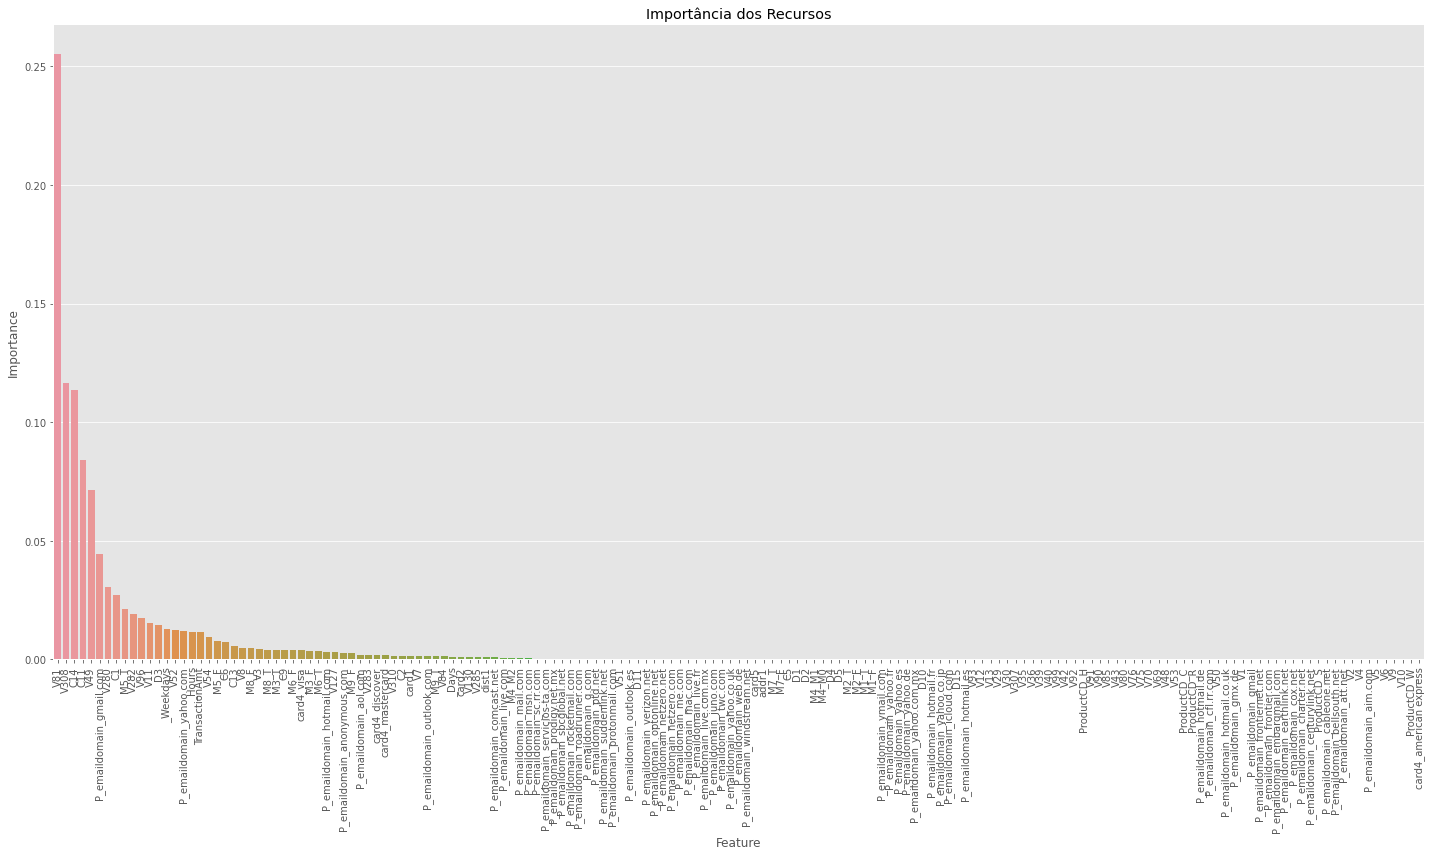

In [153]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3212565755353042
F1-Score Negativo (Teste): 0.9588674518114754
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Neg

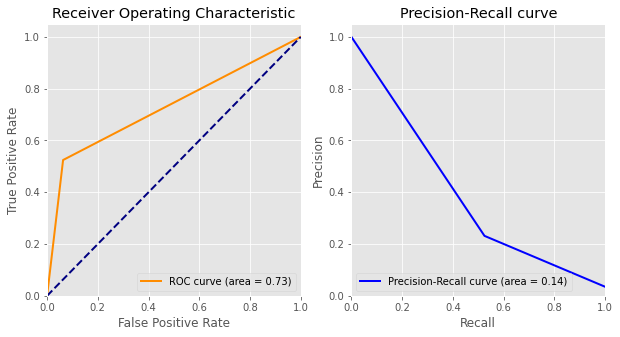

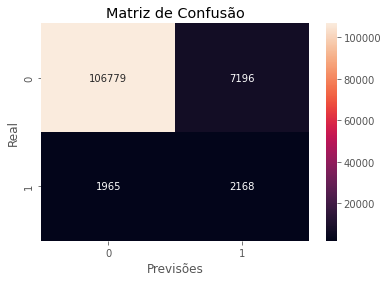

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.52      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 10min 50s, sys: 7.74 s, total: 10min 58s
Wall time: 10min 58s


In [154]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [155]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 33.6 s, sys: 3 µs, total: 33.6 s
Wall time: 33.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.321256575535304  0.958867451811475
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.321256575535304  0.958867451811475
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [156]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
62                              V96        0.07
66                             V280        0.07
6                                C1        0.06
13                              C14        0.06
0                    TransactionAmt        0.03
148                            M3_F        0.03
74                           _Hours        0.03
11                              C11        0.03
155                            M6_F        0.02
101         P_emaildomain_gmail.com        0.02
31                              V10        0.02
67                             V282        0.02
149                            M3_T        0.02
152                           M4_M2        0.02
16                               D3        0.02
44                              V49        0.02
156                            M6_T        0.02
159                            M8_F        0.02
2                             card2        0.02
84                       card4_visa        0.02
9                                C6        0.02
47                              V52        0.01
48                              V53        0.01
55                              V81        0.01
56                              V84        0.01
104       P_emaildomain_hotmail.com        0.01
63                              V99        0.01
110          P_emaildomain_live.com        0.01
64                             V127        0.01
87            P_emaildomain_aol.com        0.01
83                 card4_mastercard        0.01
69                             V285        0.01
86      P_emaildomain_anonymous.com        0.01
120       P_emaildomain_outlook.com        0.01
73                        _Weekdays        0.01
114          P_emaildomain_mail.com        0.01
138         P_emaildomain_yahoo.com        0.01
1                             card1        0.01
82                   card4_discover        0.01
75                            _Days        0.01
50                              V69        0.01
150                           M4_M0        0.01
33                              V12        0.01
18                               D5        0.01
154                            M5_T        0.01
12                              C13        0.01
151                           M4_M1        0.01
8                                C5        0.01
158                            M7_T        0.01
32                              V11        0.01
160                            M8_T        0.01
29                               V8        0.01
37                              V35        0.01
27                               V6        0.01
153                            M5_F        0.01
24                               V3        0.01
19                              D10        0.01
116           P_emaildomain_msn.com        0.00
115            P_emaildomain_me.com        0.00
117       P_emaildomain_netzero.com        0.00
118       P_emaildomain_netzero.net        0.00
119     P_emaildomain_optonline.net        0.00
139      P_emaildomain_yahoo.com.mx        0.00
113           P_emaildomain_mac.com        0.00
112           P_emaildomain_live.fr        0.00
111       P_emaildomain_live.com.mx        0.00
109          P_emaildomain_juno.com        0.00
108        P_emaildomain_icloud.com        0.00
107        P_emaildomain_hotmail.fr        0.00
106        P_emaildomain_hotmail.es        0.00
105        P_emaildomain_hotmail.de        0.00
161                            M9_F        0.00
103     P_emaildomain_hotmail.co.uk        0.00
157                            M7_F        0.00
122    P_emaildomain_prodigy.net.mx        0.00
121        P_emaildomain_outlook.es        0.00
130  P_emaildomain_servicios-ta.com        0.00
137       P_emaildomain_yahoo.co.uk        0.00
141          P_emaildomain_yahoo.es        0.00
136       P_emaildomain_yahoo.co.jp        0.00
135    P_emaildomain_windstream.net        0.00
142          P_emaildomain_yahoo.fr        0.00
134            P_emaildomain_web.de        0

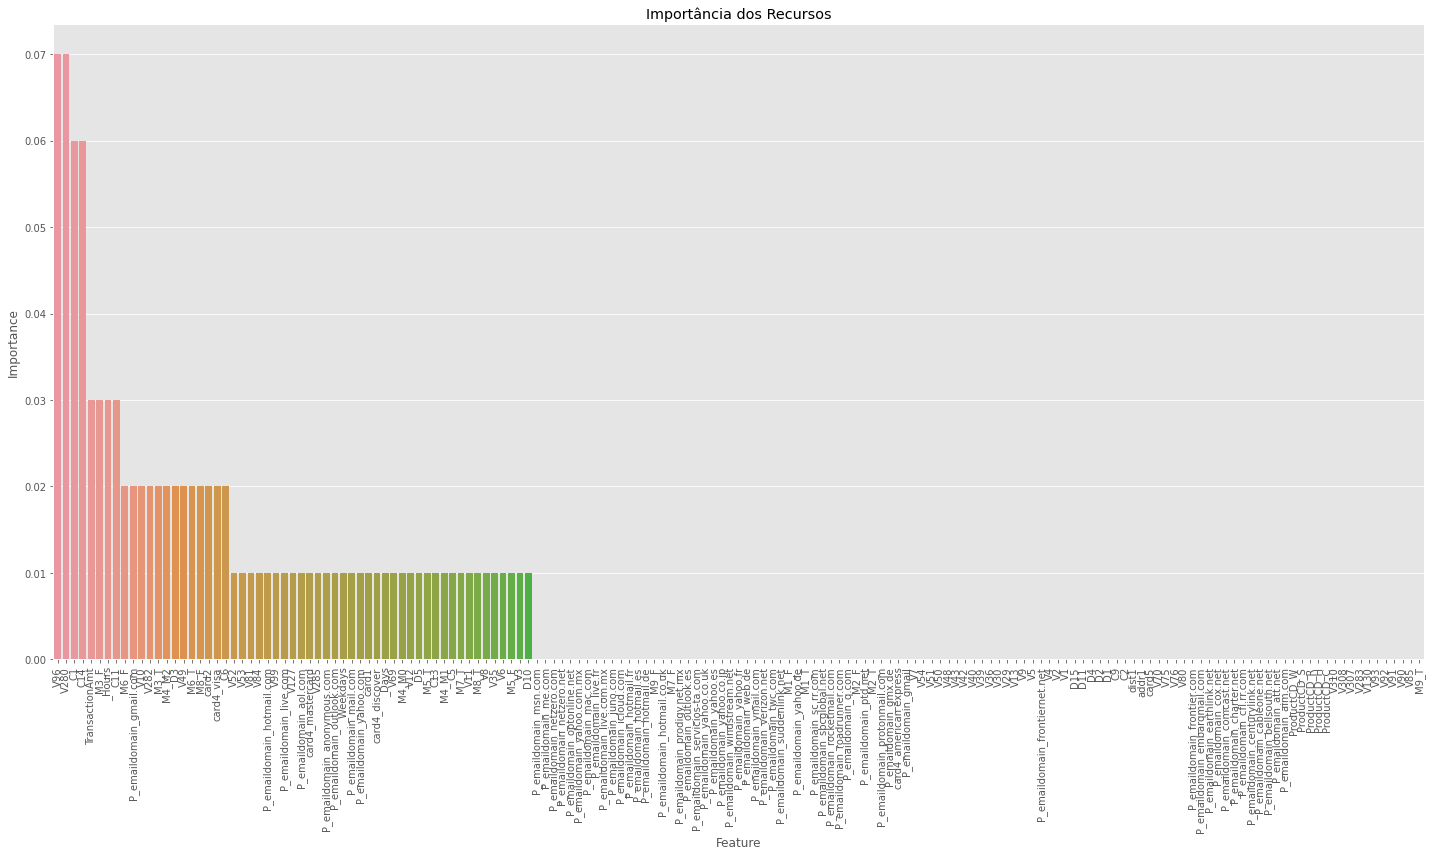

In [157]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3245492371705964
F1-Score Negativo (Teste): 0.9537396811036978
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

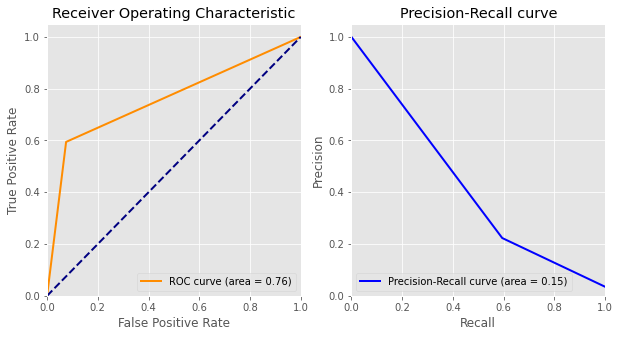

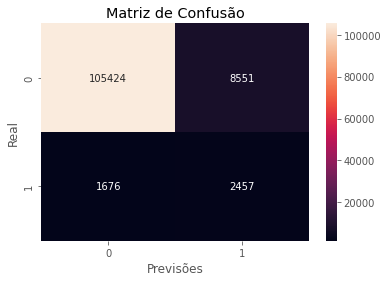

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 39min 33s, sys: 896 ms, total: 39min 34s
Wall time: 3min 28s


In [158]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [159]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8h 7min 16s, sys: 1.73 s, total: 8h 7min 17s
Wall time: 41min 6s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.324549237170596  0.953739681103698
Threshold: 0.05  0.268078639015542  0.930826294255835
Threshold: 0.1   0.268078639015542  0.930826294255835
Threshold: 0.15  0.268078639015542  0.930826294255835
Threshold: 0.2   0.268078639015542  0.930826294255835
Threshold: 0.25  0.268078639015542  0.930826294255835
Threshold: 0.3   0.268078639015542  0.930826294255835
Threshold: 0.35  0.324549237170596  0.953739681103698
Threshold: 0.4   0.324549237170596  0.953739681103698
Threshold: 0.45  0.324549237170596  0.953739681103698
Threshold: 0.5   0.324549237170596  0.953739681103698
Threshold: 0.55  0.324549237170596  0.953739681103698
Threshold: 0.6   0.324549237170596  0.953739681103698
Threshold: 0.65  0.324549237170596  0.953739681103698
Threshold: 0.7    0.40290737648561  0.973105934921583
Threshold: 0.75   0.40290737648561  0.973105934921583

In [160]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 9.6e+03 s


## Validação Cruzada para Oversample com Borderline SMOTE

### 50 Chi-Square

In [161]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.5939230249831196
F1-Score Negativo (Teste): 0.9868581493022626
F1-Score Positivo Médio (Validação Cruzada): 0.4923117310728058
F1-Score Positivo Fold 1: 0.5362776025236593
F1-Score Positivo Fold 2: 0.46753246753246747
F1-Score Positivo Fold 3: 0.5365079365079366
F1-Score Positivo Fold 4: 0.4868421052631579
F1-Score Positivo Fold 5: 0.5316045380875203
F1-Score Positivo Fold 6: 0.4968553459119496
F1-Score Positivo Fold 7: 0.4827586206896552
F1-Score Positivo Fold 8: 0.4433333333333334
F1-Score Positivo Fold 9: 0.48445171849427165
F1-Score Positivo Fold 10: 0.45695364238410596
F1-Score Negativo Médio (Validação Cruzada): 0.9864075501021201
F1-Score Negativo Fold 1: 0.98721071863581
F1-Score Negativo Fold 2: 0.9857428496913848
F1-Score Negativo Fold 3: 0.9872999304105775
F1-Score Negativo Fold 4: 0.9864430346745459
F1-Score Negativo Fold 5: 0.9874375135840034
F1-Score Negativo Fold 6: 0.9860784825545985
F1-Score Negativo Fold 7: 0.986312084473993
F1-Score Negat

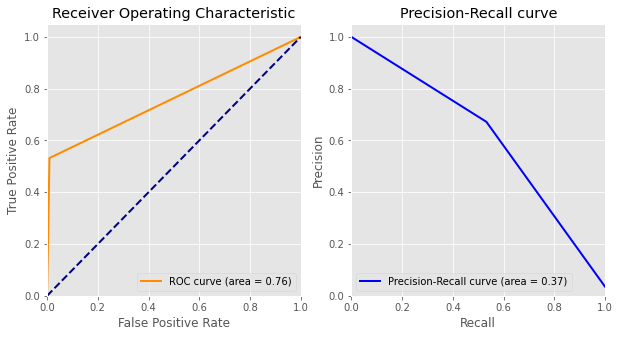

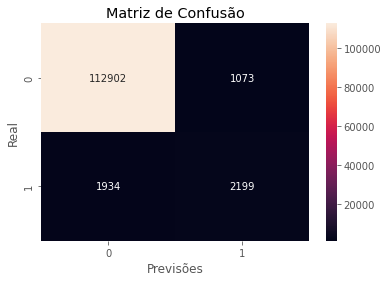

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.67      0.53      0.59      4133

    accuracy                           0.97    118108
   macro avg       0.83      0.76      0.79    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 4min 28s, sys: 304 ms, total: 4min 29s
Wall time: 4min 28s


In [162]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [163]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 48.3 s, sys: 4 µs, total: 48.3 s
Wall time: 48.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.59392302498312  0.986858149302263
Threshold: 0.05  0.195547721263469  0.859258964500132
Threshold: 0.1   0.305911144578313  0.931394440102713
Threshold: 0.15  0.392925552292172   0.95689037605303
Threshold: 0.2   0.467584122185984  0.970073106932862
Threshold: 0.25  0.521522261222982  0.977017613913661
Threshold: 0.3   0.558052434456929  0.981253640712432
Threshold: 0.35  0.581950443282564  0.983827137693586
Threshold: 0.4    0.59121171770972  0.985185672610822
Threshold: 0.45  0.595365418894831  0.986083499005964
Threshold: 0.5   0.590987637910408  0.986545281228547
Threshold: 0.55  0.587957168683076  0.987062547756795
Threshold: 0.6   0.581896551724138  0.987306766235126
Threshold: 0.65  0.568840041586217  0.987349825477269
Threshold: 0.7   0.549146285186894  0.987240711316196
Threshold: 0.75  0.526734563971992  0.987065741175652

In [164]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
9              C14  0.073967613247933
2               C1  0.061525444144353
16             D11  0.061196967385110
21            V283  0.057261804654728
1            card1  0.057238715075223
0   TransactionAmt  0.050672102706809
10              D1  0.050471992064140
11              D2  0.048808688339274
14              D5  0.047650166416477
3               C2  0.045728858448032
7              C11  0.044621785141946
15             D10  0.040025030867444
8              C13  0.038528195269213
5               C6  0.035804724172015
6               C9  0.035487106268073
4               C5  0.032268503089971
23            V308  0.031916426442946
17             D15  0.030608639180397
12              D3  0.029052904122583
13              D4  0.028986221049641
18             V96  0.027294017573125
22            V307  0.021097571351913
19            V127  0.018323257393257
24            V310  0.017713815114877
20            V130  0.013749450480522

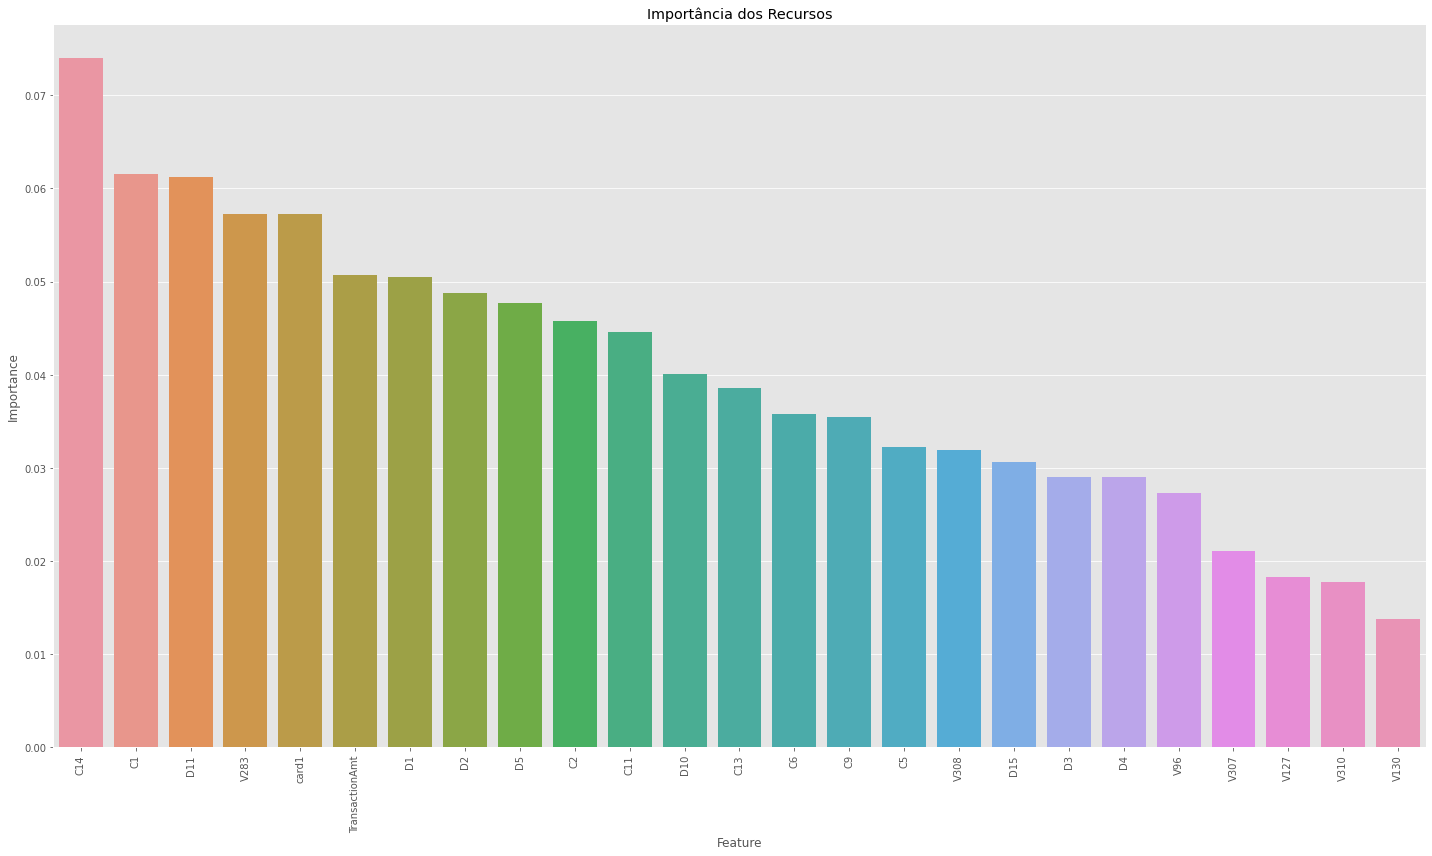

In [165]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4711661683041435
F1-Score Negativo (Teste): 0.978170789766015
F1-Score Positivo Médio (Validação Cruzada): 0.39965690519303787
F1-Score Positivo Fold 1: 0.41954707985697265
F1-Score Positivo Fold 2: 0.39856801909307876
F1-Score Positivo Fold 3: 0.40503432494279173
F1-Score Positivo Fold 4: 0.3900709219858156
F1-Score Positivo Fold 5: 0.40391676866585063
F1-Score Positivo Fold 6: 0.38029782359679265
F1-Score Positivo Fold 7: 0.3896713615023474
F1-Score Positivo Fold 8: 0.39443155452436196
F1-Score Positivo Fold 9: 0.4084507042253521
F1-Score Positivo Fold 10: 0.40658049353701525
F1-Score Negativo Médio (Validação Cruzada): 0.9775765165586924
F1-Score Negativo Fold 1: 0.9786244129394723
F1-Score Negativo Fold 2: 0.977879213483146
F1-Score Negativo Fold 3: 0.9771408475470371
F1-Score Negativo Fold 4: 0.9773445732349841
F1-Score Negativo Fold 5: 0.9786450339837754
F1-Score Negativo Fold 6: 0.9762187348894458
F1-Score Negativo Fold 7: 0.9771629336846728
F1-Score

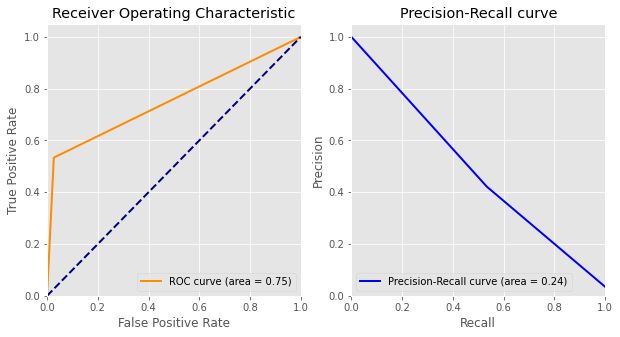

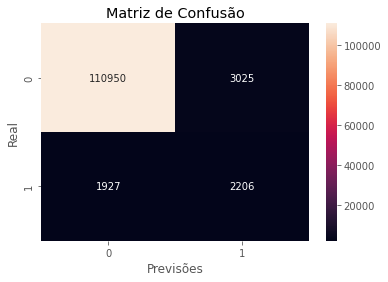

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.42      0.53      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.70      0.75      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 37.2 s, sys: 304 ms, total: 37.5 s
Wall time: 37.2 s


In [166]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [167]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 989 ms, sys: 1e+03 ns, total: 989 ms
Wall time: 988 ms


Metrics          F1_score Positivo  F1_score Negativo
Original         0.471166168304143  0.978170789766015
Threshold: 0.05  0.443628423977769  0.975210046873618
Threshold: 0.1   0.450186736650853  0.975931138399268
Threshold: 0.15   0.45811895451739  0.976750346581427
Threshold: 0.2   0.459741602067183  0.976926913891967
Threshold: 0.25  0.462018730489074  0.977185070121709
Threshold: 0.3   0.464065278794853   0.97739756548441
Threshold: 0.35  0.467151745228303  0.977713874910137
Threshold: 0.4   0.467151745228303  0.977713874910137
Threshold: 0.45  0.467694256756757  0.977763468934128
Threshold: 0.5   0.467694256756757  0.977763468934128
Threshold: 0.55  0.471468262449241  0.978197815373494
Threshold: 0.6   0.471720303645889  0.978220335621058
Threshold: 0.65  0.471720303645889  0.978220335621058
Threshold: 0.7   0.472162740899358  0.978270068231104
Threshold: 0.75  0.472162740899358  0.978270068231104

In [168]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
7              C11  0.168990897240239
4               C5  0.145279661277447
23            V308  0.118411290782352
21            V283  0.099116623936615
9              C14  0.081703318034113
1            card1  0.055119022767294
2               C1  0.045477791532913
0   TransactionAmt  0.037197514907979
8              C13  0.028818233085320
12              D3  0.028338531401377
3               C2  0.027037001826726
5               C6  0.023743566070853
6               C9  0.017617347361931
11              D2  0.016612182300400
10              D1  0.014679999237351
13              D4  0.011434459199203
15             D10  0.011426916775025
22            V307  0.011344103164270
18             V96  0.011250014313505
14              D5  0.010718555113064
17             D15  0.009542746883763
16             D11  0.008652086971916
24            V310  0.008212674819509
20            V130  0.004943122900610
19            V127  0.004332338096228

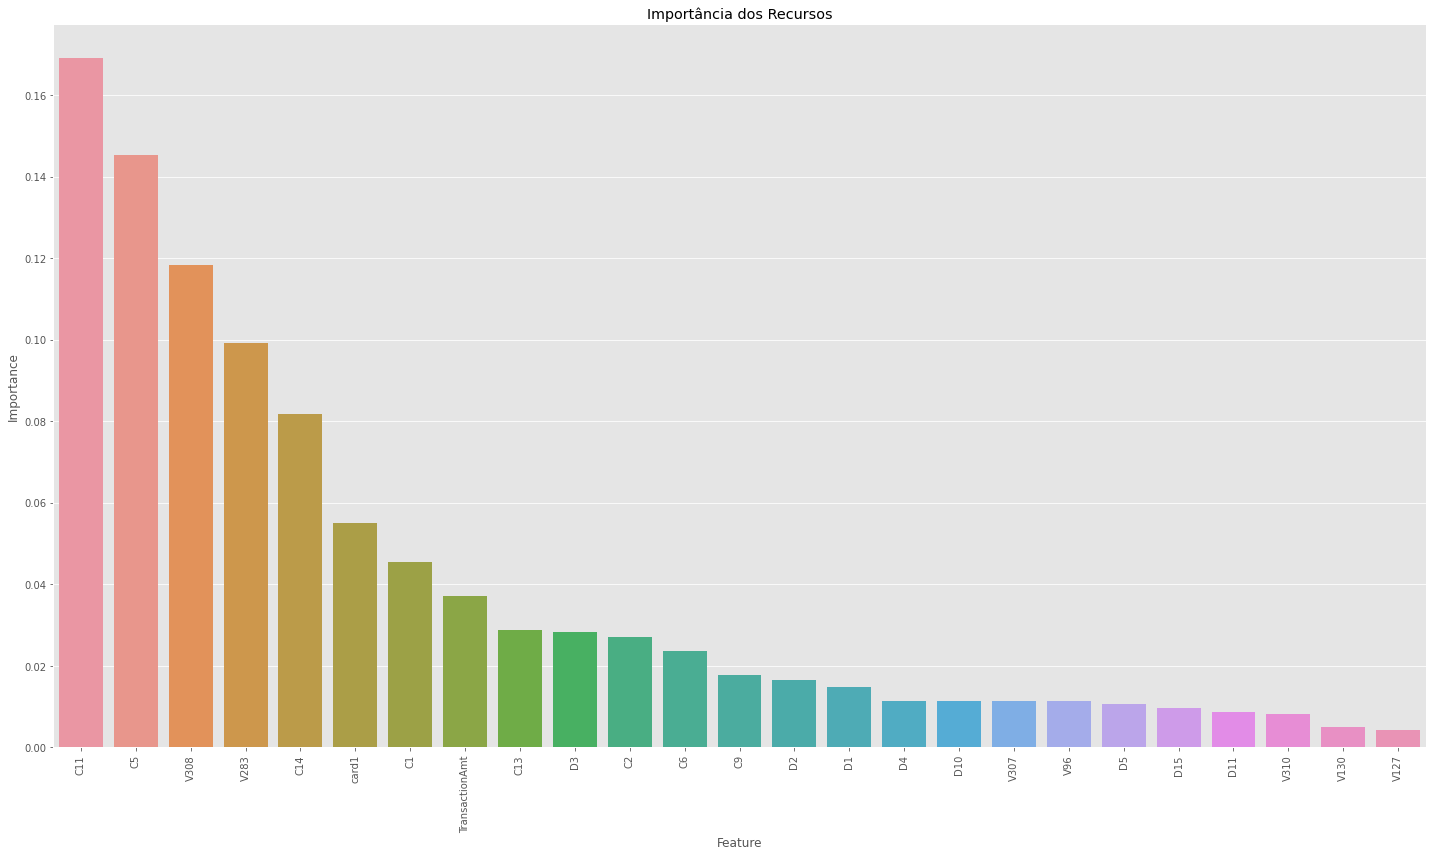

In [169]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6173081	total: 49.4ms	remaining: 198ms
1:	learn: 0.5569825	total: 99.2ms	remaining: 149ms
2:	learn: 0.5165885	total: 148ms	remaining: 98.9ms
3:	learn: 0.4715486	total: 200ms	remaining: 50ms
4:	learn: 0.4411289	total: 248ms	remaining: 0us
0:	learn: 0.5422213	total: 6.8ms	remaining: 27.2ms
1:	learn: 0.4385304	total: 13.3ms	remaining: 19.9ms
2:	learn: 0.3500857	total: 20.1ms	remaining: 13.4ms
3:	learn: 0.2917572	total: 26.5ms	remaining: 6.61ms
4:	learn: 0.2498716	total: 32.5ms	remaining: 0us
0:	learn: 0.5423905	total: 6.59ms	remaining: 26.4ms
1:	learn: 0.4384672	total: 12.9ms	remaining: 19.4ms
2:	learn: 0.3498205	total: 19.4ms	remaining: 12.9ms
3:	learn: 0.2912848	total: 25.6ms	remaining: 6.41ms
4:	learn: 0.2494877	total: 31.7ms	remaining: 0us
0:	learn: 0.5421929	total: 11.5ms	remaining: 46.1ms
1:	learn: 0.4383655	total: 19.6ms	remaining: 29.4ms
2:	learn: 0.3498947	total: 26.8ms	remaining: 17.9ms
3:	learn: 0.2914306	total: 33.2ms	remaining: 8.29ms
4:	learn: 0.2496523	total: 39

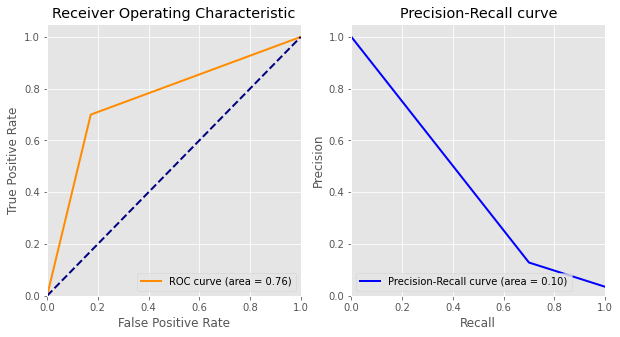

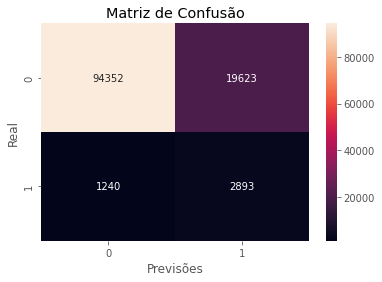

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.13      0.70      0.22      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.76      0.56    118108
weighted avg       0.96      0.82      0.88    118108

CPU times: user 17.7 s, sys: 728 ms, total: 18.4 s
Wall time: 7.85 s


In [170]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [171]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.09 s, sys: 8 ms, total: 1.09 s
Wall time: 734 ms


Metrics          F1_score Positivo  F1_score Negativo
Original         0.217118841232316  0.900447112379335
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.068236869734873  0.022107500759186
Threshold: 0.25  0.076080420894401  0.242217359141906
Threshold: 0.3    0.11529302712119   0.68120590860664
Threshold: 0.35  0.137598213217405  0.767582092760789
Threshold: 0.4   0.159996172340375  0.819391507856904
Threshold: 0.45  0.194352055224349   0.87435036653519
Threshold: 0.5   0.217118841232316  0.900447112379335
Threshold: 0.55  0.255949794834661  0.928478290123944
Threshold: 0.6   0.315139192993431  0.960801690029898
Threshold: 0.65  0.370976541189307   0.97985005504972
Threshold: 0.7   0.267566048341765  0.983069053486891
Threshold: 0.75   0.18706842435656  0.983213574320442

In [172]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
5               C6  25.349930810577725
18             V96  18.211222802933570
9              C14  14.711429984435124
3               C2   8.465228499085411
4               C5   7.594316103848696
23            V308   6.960113554731243
7              C11   5.779626165039686
21            V283   4.668743066204654
2               C1   3.714814272240438
6               C9   1.731290417623972
12              D3   1.669765924108379
24            V310   1.143518399171097
1            card1   0.000000000000000
13              D4   0.000000000000000
14              D5   0.000000000000000
15             D10   0.000000000000000
16             D11   0.000000000000000
17             D15   0.000000000000000
11              D2   0.000000000000000
19            V127   0.000000000000000
20            V130   0.000000000000000
10              D1   0.000000000000000
22            V307   0.000000000000000
8              C13   0.000000000000000
0   TransactionAmt   0.000000000000000

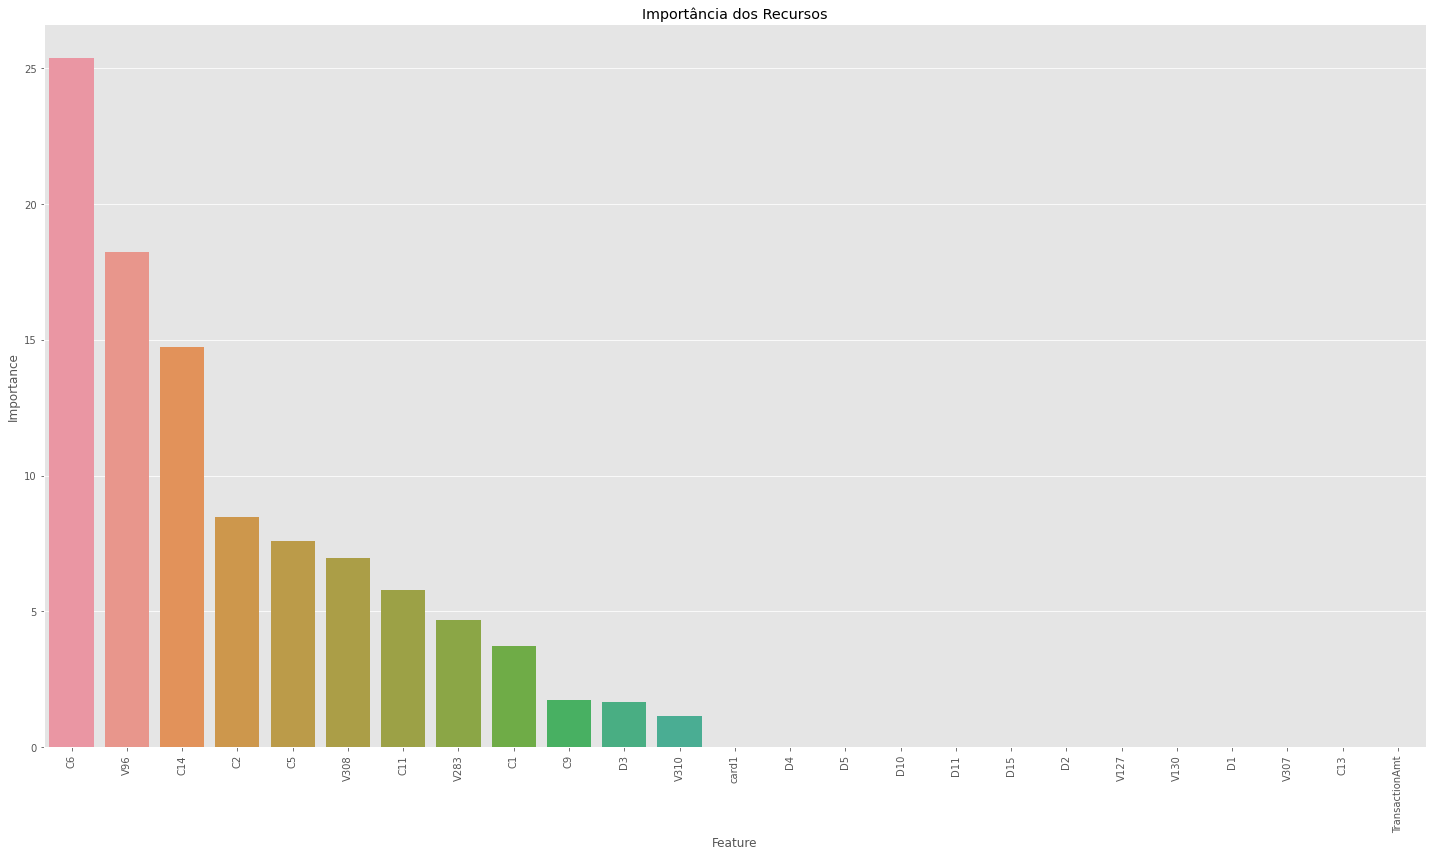

In [173]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.31162070906021383
F1-Score Negativo (Teste): 0.9559189189189189
F1-Score Positivo Médio (Validação Cruzada): 0.36509461410501814
F1-Score Positivo Fold 1: 0.4329159212880143
F1-Score Positivo Fold 2: 0.36802973977695164
F1-Score Positivo Fold 3: 0.3941068139963167
F1-Score Positivo Fold 4: 0.3626168224299066
F1-Score Positivo Fold 5: 0.42490842490842484
F1-Score Positivo Fold 6: 0.3779816513761468
F1-Score Positivo Fold 7: 0.332688588007737
F1-Score Positivo Fold 8: 0.29277566539923955
F1-Score Positivo Fold 9: 0.31417624521072796
F1-Score Positivo Fold 10: 0.3507462686567164
F1-Score Negativo Médio (Validação Cruzada): 0.9852590388989617
F1-Score Negativo Fold 1: 0.9862550405411266
F1-Score Negativo Fold 2: 0.9852711835037256
F1-Score Negativo Fold 3: 0.9857446163178647
F1-Score Negativo Fold 4: 0.9852297829947589
F1-Score Negativo Fold 5: 0.9863927890448951
F1-Score Negativo Fold 6: 0.9853100489665034
F1-Score Negativo Fold 7: 0.9850681670634063
F1-Score 

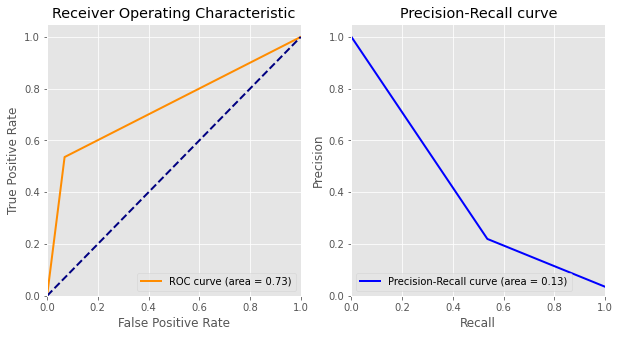

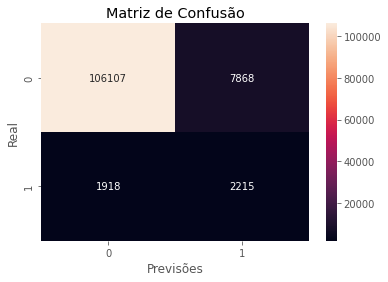

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.54      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 3min 48s, sys: 324 ms, total: 3min 48s
Wall time: 3min 48s


In [174]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [175]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.76 s, sys: 1e+03 ns, total: 1.76 s
Wall time: 1.76 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.311620709060214  0.955918918918919
Threshold: 0.05  0.082157480476567  0.355468440357717
Threshold: 0.1   0.111928299190091  0.647141640244191
Threshold: 0.15    0.1419092810037  0.771138996138996
Threshold: 0.2    0.17515634186755  0.844746929043552
Threshold: 0.25  0.195878863565407  0.873860107940799
Threshold: 0.3   0.219197336785648  0.899087393214489
Threshold: 0.35  0.242185811248973  0.917737053288594
Threshold: 0.4   0.268542979069295  0.933506363955443
Threshold: 0.45  0.288894179264373  0.945545863071636
Threshold: 0.5   0.311620709060214  0.955918918918919
Threshold: 0.55   0.33293046491016  0.963007975693126
Threshold: 0.6   0.350175179789784   0.96872698229578
Threshold: 0.65  0.360726178966591  0.973773396149083
Threshold: 0.7   0.367491166077739  0.977233354823713
Threshold: 0.75  0.355384403795902  0.979527834195986

In [176]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
7              C11  0.230436582020143
4               C5  0.210276720245266
9              C14  0.158529920883070
21            V283  0.123319519756600
18             V96  0.074759758081937
2               C1  0.058366620335485
6               C9  0.032777083881137
5               C6  0.019216404074180
23            V308  0.012722558985411
16             D11  0.011869037478985
3               C2  0.010542488327605
15             D10  0.009253826801132
8              C13  0.007661959642805
12              D3  0.007616163082225
11              D2  0.007423061294447
0   TransactionAmt  0.007412123473402
13              D4  0.005996203566953
14              D5  0.005590183156067
19            V127  0.002597091525738
20            V130  0.002268515281287
1            card1  0.001364178106127
17             D15  0.000000000000000
22            V307  0.000000000000000
10              D1  0.000000000000000
24            V310  0.000000000000000

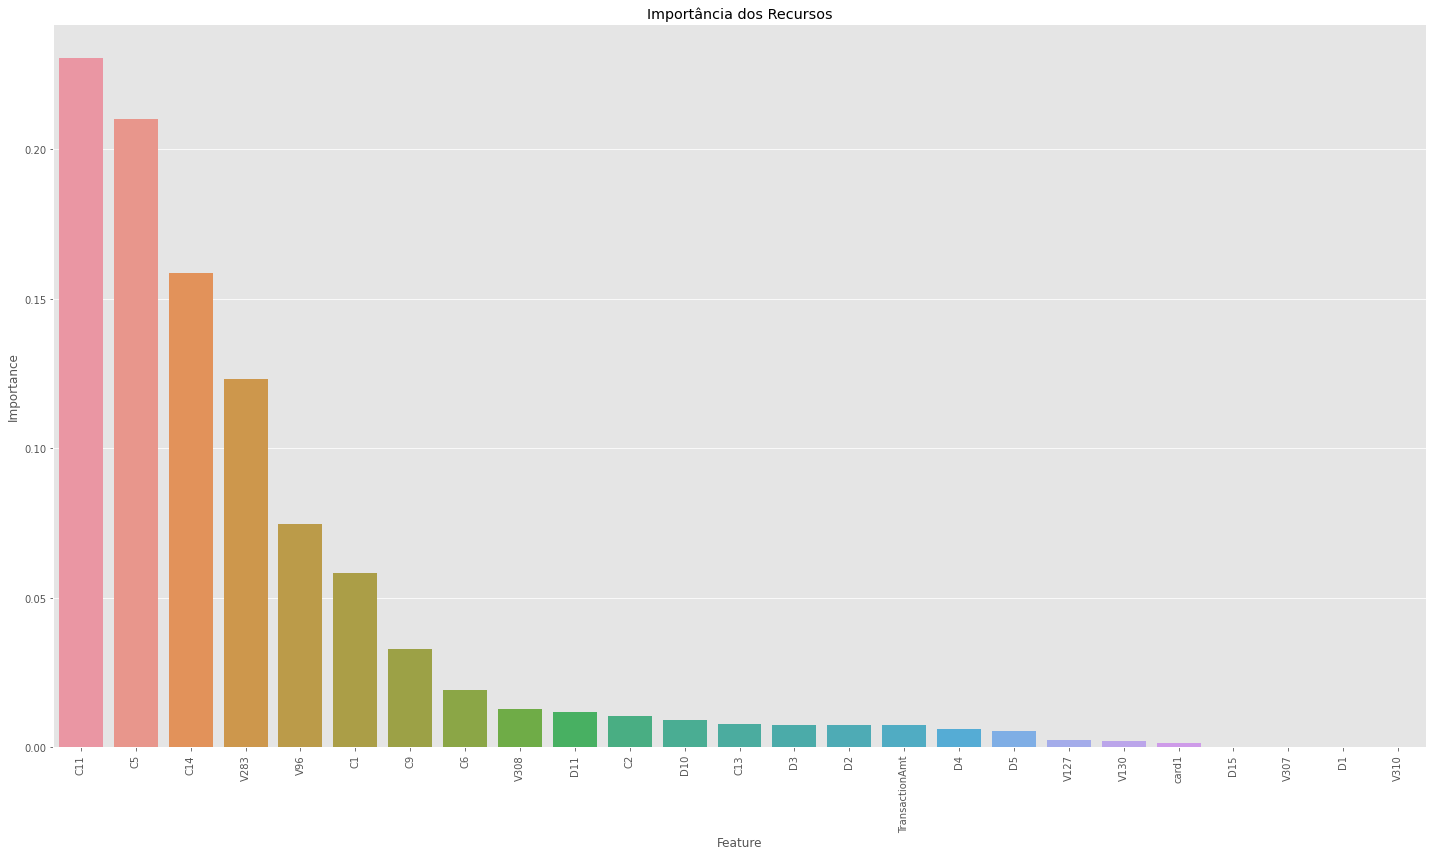

In [177]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.29291595951976873
F1-Score Negativo (Teste): 0.9489394345163794
F1-Score Positivo Médio (Validação Cruzada): 0.3276645415404055
F1-Score Positivo Fold 1: 0.3677298311444653
F1-Score Positivo Fold 2: 0.3415559772296015
F1-Score Positivo Fold 3: 0.349146110056926
F1-Score Positivo Fold 4: 0.3145631067961165
F1-Score Positivo Fold 5: 0.3719165085388994
F1-Score Positivo Fold 6: 0.3435114503816794
F1-Score Positivo Fold 7: 0.30708661417322836
F1-Score Positivo Fold 8: 0.277992277992278
F1-Score Positivo Fold 9: 0.2879684418145957
F1-Score Positivo Fold 10: 0.3151750972762646
F1-Score Negativo Médio (Validação Cruzada): 0.9848756188768357
F1-Score Negativo Fold 1: 0.9854043050803413
F1-Score Negativo Fold 2: 0.9849751028361117
F1-Score Negativo Fold 3: 0.9851483004979432
F1-Score Negativo Fold 4: 0.984723244038603
F1-Score Negativo Fold 5: 0.9856678934834381
F1-Score Negativo Fold 6: 0.9851069356654255
F1-Score Negativo Fold 7: 0.9847711343774336
F1-Score Negati

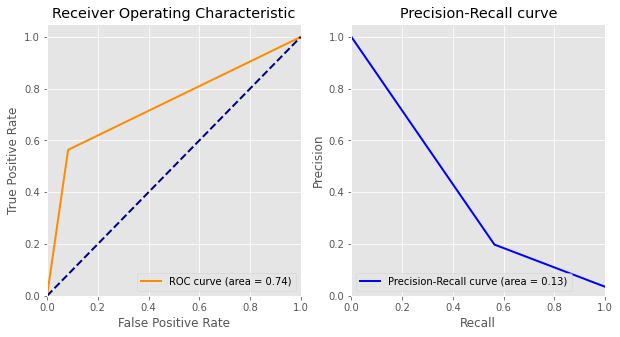

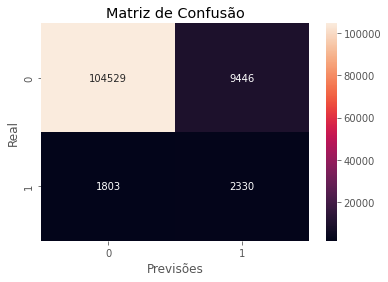

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.20      0.56      0.29      4133

    accuracy                           0.90    118108
   macro avg       0.59      0.74      0.62    118108
weighted avg       0.96      0.90      0.93    118108

CPU times: user 4min 29s, sys: 280 ms, total: 4min 30s
Wall time: 4min 29s


In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [179]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 13.1 s, sys: 4 ms, total: 13.1 s
Wall time: 13.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.292915959519769  0.948939434516379
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.292915959519769  0.948939434516379
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [180]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
18             V96        0.18
9              C14        0.13
5               C6        0.11
2               C1        0.07
21            V283        0.07
3               C2        0.06
12              D3        0.05
7              C11        0.05
16             D11        0.04
0   TransactionAmt        0.04
4               C5        0.03
10              D1        0.02
14              D5        0.02
15             D10        0.02
8              C13        0.02
6               C9        0.02
11              D2        0.01
1            card1        0.01
17             D15        0.01
19            V127        0.01
20            V130        0.01
23            V308        0.01
24            V310        0.01
13              D4        0.00
22            V307        0.00

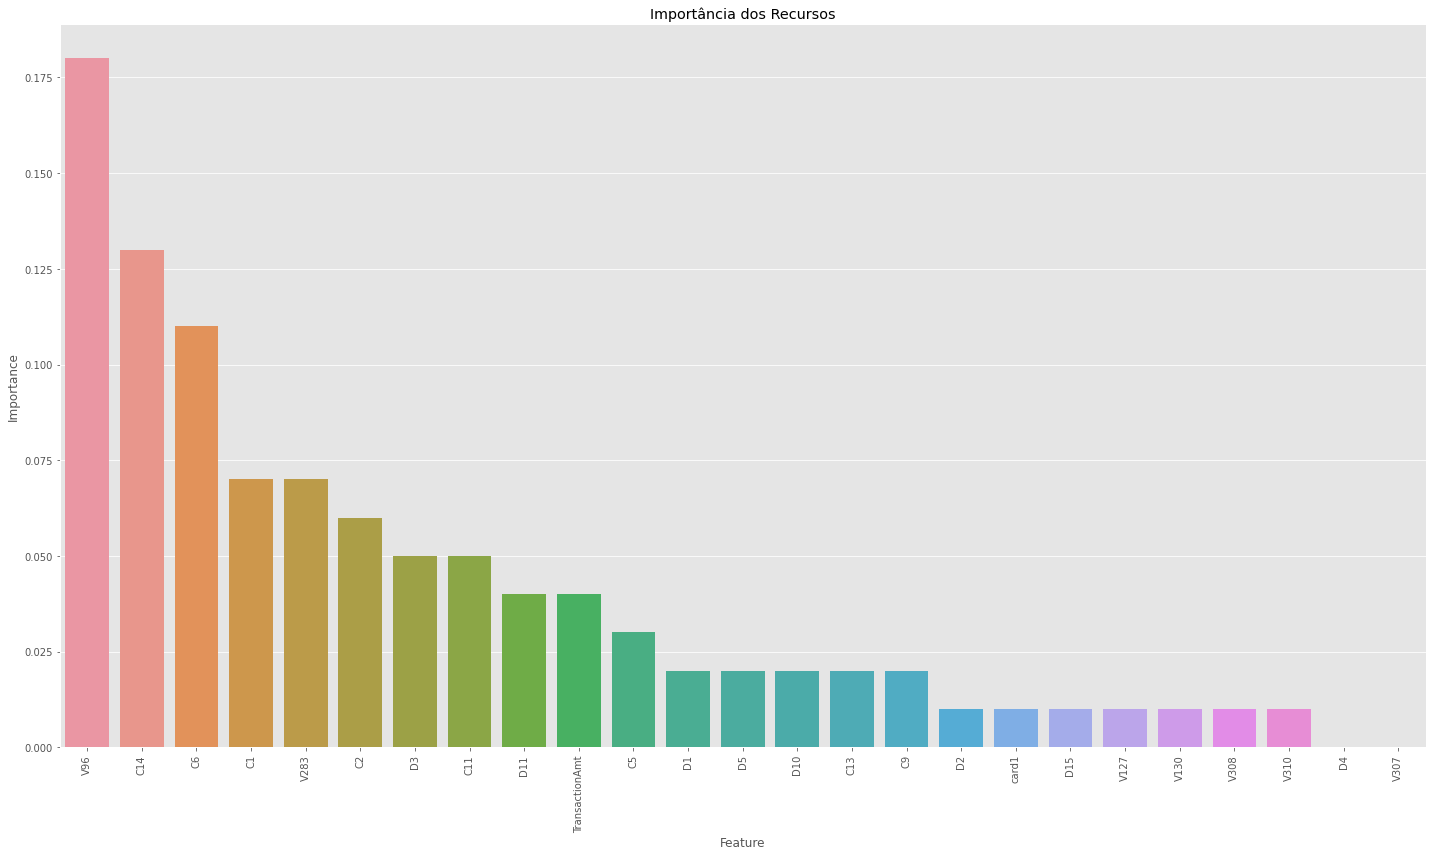

In [181]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.33952336737852057
F1-Score Negativo (Teste): 0.9617720294502267
F1-Score Positivo Médio (Validação Cruzada): 0.25211365169610284
F1-Score Positivo Fold 1: 0.2654545454545455
F1-Score Positivo Fold 2: 0.22459893048128343
F1-Score Positivo Fold 3: 0.24872231686541738
F1-Score Positivo Fold 4: 0.23971377459749552
F1-Score Positivo Fold 5: 0.2852112676056338
F1-Score Positivo Fold 6: 0.23834196891191706
F1-Score Positivo Fold 7: 0.24825174825174826
F1-Score Positivo Fold 8: 0.23633156966490299
F1-Score Positivo Fold 9: 0.2579505300353357
F1-Score Positivo Fold 10: 0.2765598650927487
F1-Score Negativo Médio (Validação Cruzada): 0.9815020384780192
F1-Score Negativo Fold 1: 0.98248959778086
F1-Score Negativo Fold 2: 0.9811369845193182
F1-Score Negativo Fold 3: 0.9808552203169091
F1-Score Negativo Fold 4: 0.981572215236526
F1-Score Negativo Fold 5: 0.9823891732454239
F1-Score Negativo Fold 6: 0.9808618669444084
F1-Score Negativo Fold 7: 0.9813449023861172
F1-Score 

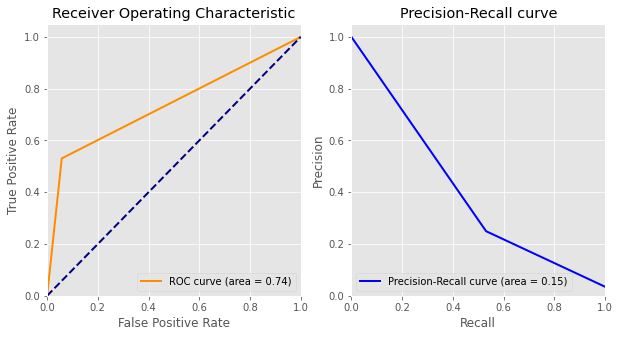

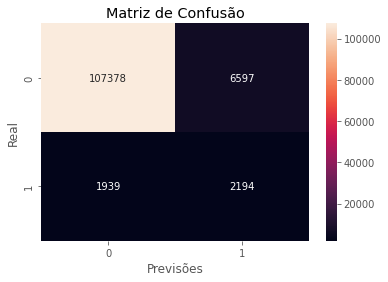

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.25      0.53      0.34      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.74      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 13min 16s, sys: 608 ms, total: 13min 16s
Wall time: 1min 13s


In [182]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [183]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2h 51min 22s, sys: 1.01 s, total: 2h 51min 23s
Wall time: 14min 26s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.339523367378521  0.961772029450227
Threshold: 0.05  0.286227208976157  0.941742104757064
Threshold: 0.1   0.286227208976157  0.941742104757064
Threshold: 0.15  0.286227208976157  0.941742104757064
Threshold: 0.2   0.286227208976157  0.941742104757064
Threshold: 0.25  0.286227208976157  0.941742104757064
Threshold: 0.3   0.286227208976157  0.941742104757064
Threshold: 0.35  0.339523367378521  0.961772029450227
Threshold: 0.4   0.339523367378521  0.961772029450227
Threshold: 0.45  0.339523367378521  0.961772029450227
Threshold: 0.5   0.339523367378521  0.961772029450227
Threshold: 0.55  0.339523367378521  0.961772029450227
Threshold: 0.6   0.339523367378521  0.961772029450227
Threshold: 0.65  0.339523367378521  0.961772029450227
Threshold: 0.7   0.394811423588402  0.975546374679575
Threshold: 0.75  0.394811423588402  0.975546374679575

### 100 Chi-Square

In [184]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6769276306052983
F1-Score Negativo (Teste): 0.9904863178171264
F1-Score Positivo Médio (Validação Cruzada): 0.5139275346650243
F1-Score Positivo Fold 1: 0.5582191780821919
F1-Score Positivo Fold 2: 0.46785714285714286
F1-Score Positivo Fold 3: 0.535593220338983
F1-Score Positivo Fold 4: 0.5268630849220105
F1-Score Positivo Fold 5: 0.5695142378559465
F1-Score Positivo Fold 6: 0.5093378607809848
F1-Score Positivo Fold 7: 0.4844290657439446
F1-Score Positivo Fold 8: 0.4831261101243339
F1-Score Positivo Fold 9: 0.4947368421052632
F1-Score Positivo Fold 10: 0.5095986038394416
F1-Score Negativo Médio (Validação Cruzada): 0.9878188909663093
F1-Score Negativo Fold 1: 0.98880111120757
F1-Score Negativo Fold 2: 0.9870783106408811
F1-Score Negativo Fold 3: 0.9881035081625563
F1-Score Negativo Fold 4: 0.988153612497288
F1-Score Negativo Fold 5: 0.9888382193268186
F1-Score Negativo Fold 6: 0.9874527851343724
F1-Score Negativo Fold 7: 0.9870682173233815
F1-Score Negativo

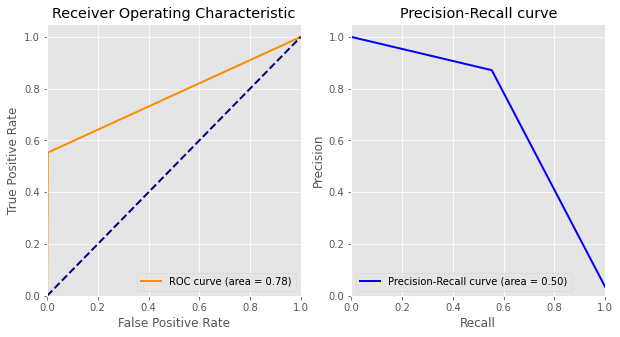

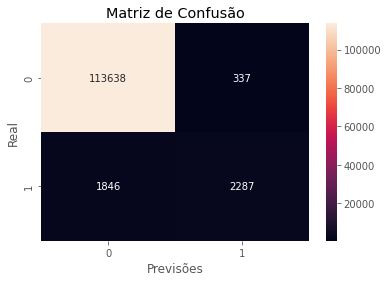

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.87      0.55      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 6min 6s, sys: 316 ms, total: 6min 7s
Wall time: 6min 6s


In [185]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [186]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
68    P_emaildomain_gmail.com  0.050602937418508
71                      M4_M2  0.043354689641241
62                ProductCD_C  0.034871691304494
73                       M6_F  0.031518278483886
74                       M6_T  0.029952543273815
15                         D2  0.024232877370838
72                       M5_T  0.023296411088433
0              TransactionAmt  0.023045137520797
2                       card2  0.022503160198127
55                       V283  0.022489006061834
1                       card1  0.020305707270267
13                        C14  0.018765235938353
6                          C1  0.018235251191251
54                       V282  0.017813431407006
61                     _Hours  0.016856043218244
3                       card5  0.016416365227045
14                         D1  0.016313766993711
60                  _Weekdays  0.016254336234676
7                          C2  0.016184298975926
12                        C13  0.015983463735464
66                ProductCD_W  0.015971810800152
64                ProductCD_R  0.014816622830113
58                       V308  0.014454419232553
11                        C11  0.014339814688989
4                       addr1  0.013779015967820
63                ProductCD_H  0.013544856713742
37                        V53  0.013334581536472
22                        V12  0.013276702240329
38                        V69  0.013143705626488
34                        V50  0.012993284696456
39                        V70  0.012974284445262
9                          C6  0.012437072452343
69  P_emaildomain_hotmail.com  0.012149670532271
50                        V96  0.012113220892944
57                       V307  0.012019295166169
36                        V52  0.011963500838515
32                        V48  0.011955014793884
18                         D5  0.011610161849367
24                        V29  0.010997077737481
56                       V285  0.010738376720140
40                        V75  0.010378005755692
16                         D3  0.010335857315183
21                        D15  0.010293022157703
26                        V35  0.010232816289703
23                        V13  0.010213355889103
46                        V90  0.010002605522402
31                        V43  0.009670175036375
35                        V51  0.009634728999017
30                        V42  0.009398510182258
52                       V127  0.009273261823473
29                        V40  0.009186679870724
59                       V310  0.008985037156592
27                        V36  0.008949540351513
28                        V39  0.008899779106155
19                        D10  0.008756072496825
17                         D4  0.008554227230572
41                        V76  0.007834752380326
20                        D11  0.007737273929429
67             card4_discover  0.007475752477577
51                        V99  0.007286194013641
44                        V84  0.007241781531712
33                        V49  0.007071703113206
47                        V91  0.006886639906330
45                        V85  0.006811024380050
53                       V130  0.006319952634800
42                        V80  0.005793702173302
25                        V30  0.005409420196141
65                ProductCD_S  0.005241905762442
10                         C9  0.004983719540512
49                        V93  0.004850014909093
70  P_emaildomain_outlook.com  0.004753445305537
5                       dist1  0.004406244992017
43                        V81  0.004106404786016
48                        V92  0.003177828634988
8                          C5  0.002241441834188

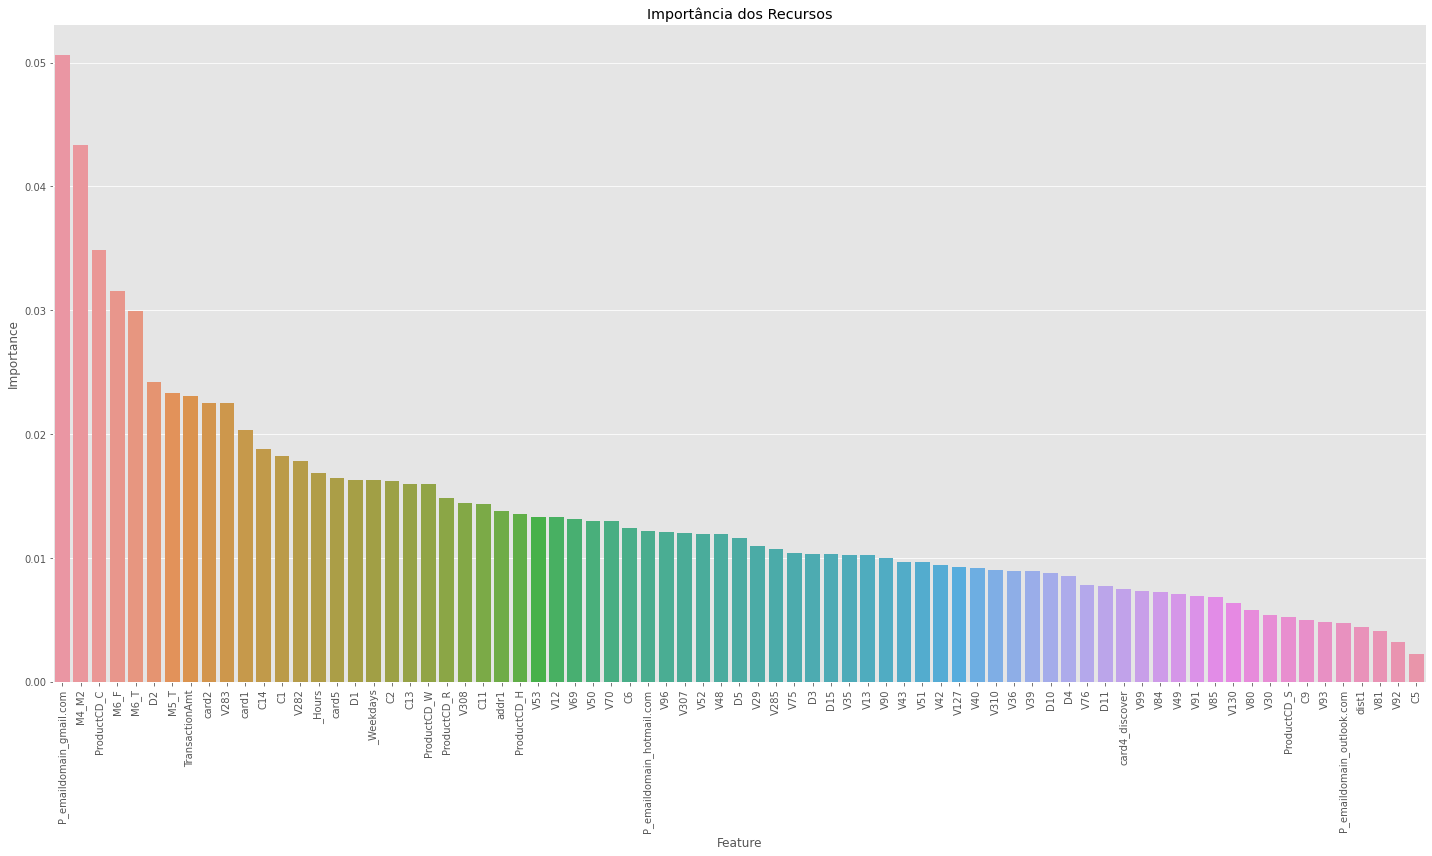

In [187]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [188]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 48.2 s, sys: 4 ms, total: 48.2 s
Wall time: 48.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.676927630605298  0.990486317817126
Threshold: 0.05  0.259060402684564  0.899108250844131
Threshold: 0.1   0.415495082362879  0.955896614050983
Threshold: 0.15  0.531748616085965  0.974313630923673
Threshold: 0.2   0.611248393792626  0.982604965081668
Threshold: 0.25  0.663178984861977  0.986683213631883
Threshold: 0.3   0.691563935218758   0.98880416948171
Threshold: 0.35  0.703489120638599  0.989918975351172
Threshold: 0.4   0.703502579418952  0.990456630980992
Threshold: 0.45  0.695898161244696  0.990617335672453
Threshold: 0.5   0.678928781636257    0.9904890593671
Threshold: 0.55  0.658862876254181  0.990228098137068
Threshold: 0.6   0.636091410559496  0.989955235762667
Threshold: 0.65  0.613013142949862  0.989632823740616
Threshold: 0.7     0.5785318326894  0.989103763956867
Threshold: 0.75  0.534960767218832  0.988428547255522

F1-Score Positivo (Teste): 0.4891187244128421
F1-Score Negativo (Teste): 0.979104056686085
F1-Score Positivo Médio (Validação Cruzada): 0.4265379302823337
F1-Score Positivo Fold 1: 0.4641638225255973
F1-Score Positivo Fold 2: 0.42921348314606744
F1-Score Positivo Fold 3: 0.4364454443194601
F1-Score Positivo Fold 4: 0.4556962025316456
F1-Score Positivo Fold 5: 0.4393592677345538
F1-Score Positivo Fold 6: 0.40222222222222226
F1-Score Positivo Fold 7: 0.40765765765765766
F1-Score Positivo Fold 8: 0.39627039627039623
F1-Score Positivo Fold 9: 0.4258210645526614
F1-Score Positivo Fold 10: 0.40852974186307517
F1-Score Negativo Médio (Validação Cruzada): 0.9777521144137096
F1-Score Negativo Fold 1: 0.9792903310908849
F1-Score Negativo Fold 2: 0.9776526482491643
F1-Score Negativo Fold 3: 0.9779615536884705
F1-Score Negativo Fold 4: 0.9792115325451588
F1-Score Negativo Fold 5: 0.9784596448039388
F1-Score Negativo Fold 6: 0.9763225068215825
F1-Score Negativo Fold 7: 0.9768628485968153
F1-Score N

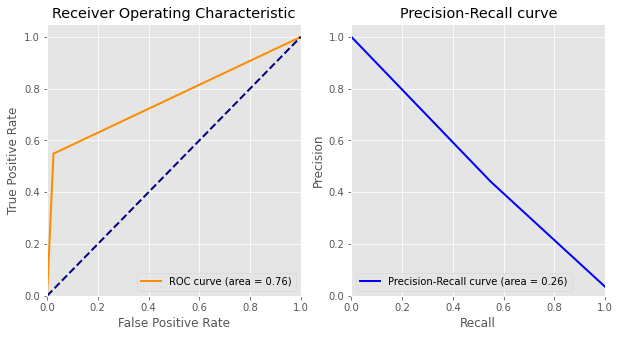

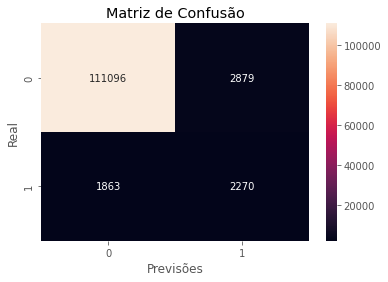

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.55      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 16s, sys: 304 ms, total: 1min 17s
Wall time: 1min 16s


In [189]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [190]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
36                        V52  0.171677570349477
6                          C1  0.133262271123337
58                       V308  0.107307398927752
13                        C14  0.063425070200740
24                        V29  0.059721339114381
34                        V50  0.044225890414631
55                       V283  0.037829650049434
54                       V282  0.028689873168780
16                         D3  0.023657733958010
1                       card1  0.022759983641439
50                        V96  0.017365586867168
18                         D5  0.017240977087022
2                       card2  0.016874646150942
12                        C13  0.016388746802478
0              TransactionAmt  0.015429104057704
4                       addr1  0.011161762500129
7                          C2  0.011094767670466
15                         D2  0.010064820916957
19                        D10  0.010044559286840
68    P_emaildomain_gmail.com  0.009954613663538
9                          C6  0.009347690348000
37                        V53  0.008025361602431
25                        V30  0.007727040935479
3                       card5  0.007591934723272
11                        C11  0.007073408793087
61                     _Hours  0.006622075031735
71                      M4_M2  0.006446165962028
5                       dist1  0.006077388133636
57                       V307  0.005980272454454
56                       V285  0.005533051665956
14                         D1  0.005222530368771
27                        V36  0.005132335837773
10                         C9  0.005123010094187
21                        D15  0.004991473732197
69  P_emaildomain_hotmail.com  0.004942237475029
51                        V99  0.004862612698756
17                         D4  0.004826681533498
46                        V90  0.004704553315457
60                  _Weekdays  0.004412573734462
22                        V12  0.004100142429136
59                       V310  0.003885858864848
74                       M6_T  0.003200541846421
20                        D11  0.003178851479732
52                       V127  0.003129740114467
72                       M5_T  0.002765397655225
53                       V130  0.002737821908625
64                ProductCD_R  0.002268033183090
26                        V35  0.002258853251452
32                        V48  0.002080429160447
63                ProductCD_H  0.002002424329406
70  P_emaildomain_outlook.com  0.001868012724482
73                       M6_F  0.001693988238263
40                        V75  0.001621438050334
67             card4_discover  0.001615766139982
8                          C5  0.001575607143790
41                        V76  0.001505521688520
42                        V80  0.001320539452462
35                        V51  0.001294105863487
33                        V49  0.001241500399812
43                        V81  0.001207188728416
38                        V69  0.001173645030552
23                        V13  0.001055187653499
47                        V91  0.001037369744879
30                        V42  0.000895731786617
45                        V85  0.000893571633487
49                        V93  0.000757243794895
65                ProductCD_S  0.000743000929036
44                        V84  0.000692735213278
39                        V70  0.000689481336732
31                        V43  0.000688009622584
48                        V92  0.000571545453416
29                        V40  0.000449362123492
66                ProductCD_W  0.000369069517910
28                        V39  0.000330770045969
62                ProductCD_C  0.000282749069823

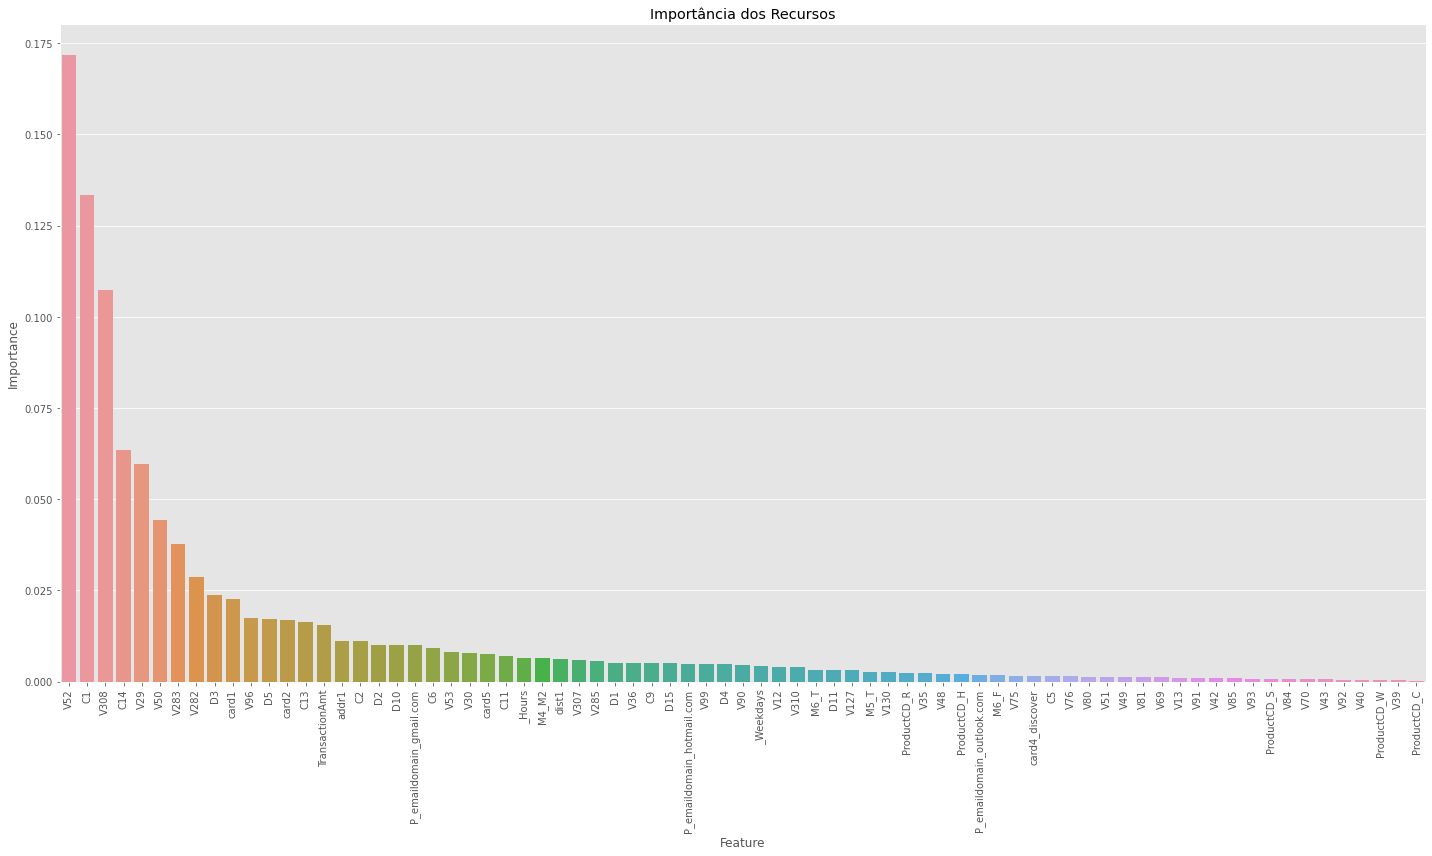

In [191]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [192]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.23 s, sys: 4 ms, total: 1.23 s
Wall time: 1.23 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.489118724412842  0.979104056686085
Threshold: 0.05  0.489013356311935  0.979095059312922
Threshold: 0.1   0.489013356311935  0.979095059312922
Threshold: 0.15  0.489013356311935  0.979095059312922
Threshold: 0.2   0.489013356311935  0.979095059312922
Threshold: 0.25  0.489013356311935  0.979095059312922
Threshold: 0.3   0.489013356311935  0.979095059312922
Threshold: 0.35  0.489013356311935  0.979095059312922
Threshold: 0.4   0.489013356311935  0.979095059312922
Threshold: 0.45  0.489013356311935  0.979095059312922
Threshold: 0.5   0.489013356311935  0.979095059312922
Threshold: 0.55  0.489118724412842  0.979104056686085
Threshold: 0.6   0.489118724412842  0.979104056686085
Threshold: 0.65  0.489118724412842  0.979104056686085
Threshold: 0.7   0.489118724412842  0.979104056686085
Threshold: 0.75  0.489118724412842  0.979104056686085

0:	learn: 0.6123758	total: 73.8ms	remaining: 295ms
1:	learn: 0.5528831	total: 141ms	remaining: 212ms
2:	learn: 0.4933096	total: 209ms	remaining: 139ms
3:	learn: 0.4473632	total: 276ms	remaining: 68.9ms
4:	learn: 0.4194792	total: 338ms	remaining: 0us
0:	learn: 0.5379329	total: 7.75ms	remaining: 31ms
1:	learn: 0.4310106	total: 15ms	remaining: 22.4ms
2:	learn: 0.3575041	total: 21.7ms	remaining: 14.5ms
3:	learn: 0.2951044	total: 29ms	remaining: 7.25ms
4:	learn: 0.2560908	total: 36.1ms	remaining: 0us
0:	learn: 0.5374922	total: 7.95ms	remaining: 31.8ms
1:	learn: 0.4304224	total: 15ms	remaining: 22.5ms
2:	learn: 0.3570376	total: 21.8ms	remaining: 14.5ms
3:	learn: 0.2949381	total: 29.1ms	remaining: 7.27ms
4:	learn: 0.2558987	total: 36.1ms	remaining: 0us
0:	learn: 0.5378241	total: 7.93ms	remaining: 31.7ms
1:	learn: 0.4306608	total: 15.2ms	remaining: 22.7ms
2:	learn: 0.3572683	total: 22ms	remaining: 14.7ms
3:	learn: 0.2950001	total: 29.3ms	remaining: 7.32ms
4:	learn: 0.2560835	total: 36.3ms	rema

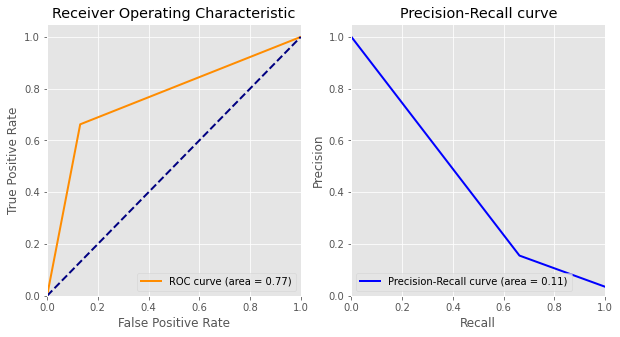

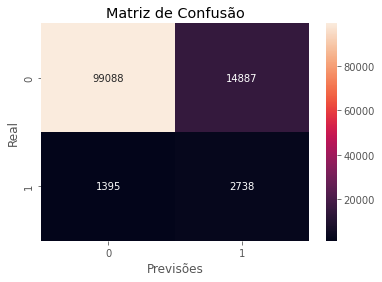

              precision    recall  f1-score   support

           0       0.99      0.87      0.92    113975
           1       0.16      0.66      0.25      4133

    accuracy                           0.86    118108
   macro avg       0.57      0.77      0.59    118108
weighted avg       0.96      0.86      0.90    118108

CPU times: user 37.5 s, sys: 660 ms, total: 38.2 s
Wall time: 20.9 s


In [193]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [194]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 7.74 s, sys: 7.97 ms, total: 7.75 s
Wall time: 7.25 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.251677543891902   0.92407837432038
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.069055188786082  0.051535378225234
Threshold: 0.25  0.078075290340673  0.282102060947418
Threshold: 0.3    0.11457308407128  0.670747501263162
Threshold: 0.35  0.140579621844473  0.773678045962872
Threshold: 0.4   0.163317636036391  0.826558722662619
Threshold: 0.45  0.196044011159525  0.874473239850231
Threshold: 0.5   0.251677543891902   0.92407837432038
Threshold: 0.55  0.299520663298355   0.95101867033853
Threshold: 0.6   0.364365632256702   0.97344117984317
Threshold: 0.65  0.376220562894888   0.98105141939874
Threshold: 0.7   0.298817106460419  0.983300176403535
Threshold: 0.75  0.209527737677872  0.983433246746511

In [195]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
36                        V52  27.310442688872254
50                        V96  22.307871424017105
33                        V49  13.432594859198847
13                        C14   9.430536106853769
6                          C1   5.834437236787070
58                       V308   5.162886451700887
11                        C11   2.459746596842626
43                        V81   2.379571024544928
9                          C6   2.124235815473219
24                        V29   1.720317083306174
55                       V283   1.610034815676040
18                         D5   1.450471279036441
16                         D3   1.349933066484306
39                        V70   1.075707444311364
68    P_emaildomain_gmail.com   0.718457205867748
54                       V282   0.665178399153162
71                      M4_M2   0.507706143595233
44                        V84   0.459872358278847
49                        V93   0.000000000000000
48                        V92   0.000000000000000
47                        V91   0.000000000000000
51                        V99   0.000000000000000
52                       V127   0.000000000000000
46                        V90   0.000000000000000
53                       V130   0.000000000000000
45                        V85   0.000000000000000
0              TransactionAmt   0.000000000000000
56                       V285   0.000000000000000
57                       V307   0.000000000000000
59                       V310   0.000000000000000
61                     _Hours   0.000000000000000
62                ProductCD_C   0.000000000000000
63                ProductCD_H   0.000000000000000
64                ProductCD_R   0.000000000000000
65                ProductCD_S   0.000000000000000
66                ProductCD_W   0.000000000000000
67             card4_discover   0.000000000000000
69  P_emaildomain_hotmail.com   0.000000000000000
70  P_emaildomain_outlook.com   0.000000000000000
72                       M5_T   0.000000000000000
73                       M6_F   0.000000000000000
60                  _Weekdays   0.000000000000000
37                        V53   0.000000000000000
42                        V80   0.000000000000000
41                        V76   0.000000000000000
2                       card2   0.000000000000000
3                       card5   0.000000000000000
4                       addr1   0.000000000000000
5                       dist1   0.000000000000000
7                          C2   0.000000000000000
8                          C5   0.000000000000000
10                         C9   0.000000000000000
12                        C13   0.000000000000000
14                         D1   0.000000000000000
15                         D2   0.000000000000000
17                         D4   0.000000000000000
19                        D10   0.000000000000000
20                        D11   0.000000000000000
21                        D15   0.000000000000000
22                        V12   0.000000000000000
23                        V13   0.000000000000000
25                        V30   0.000000000000000
26                        V35   0.000000000000000
27                        V36   0.000000000000000
28                        V39   0.000000000000000
29                        V40   0.000000000000000
30                        V42   0.000000000000000
31                        V43   0.000000000000000
32                        V48   0.000000000000000
34                        V50   0.000000000000000
35                        V51   0.000000000000000
1                       card1   0.000000000000000
38                        V69   0.000000000000000
40                        V75   0.000000000000000
74                       M6_T   0.000000000000000

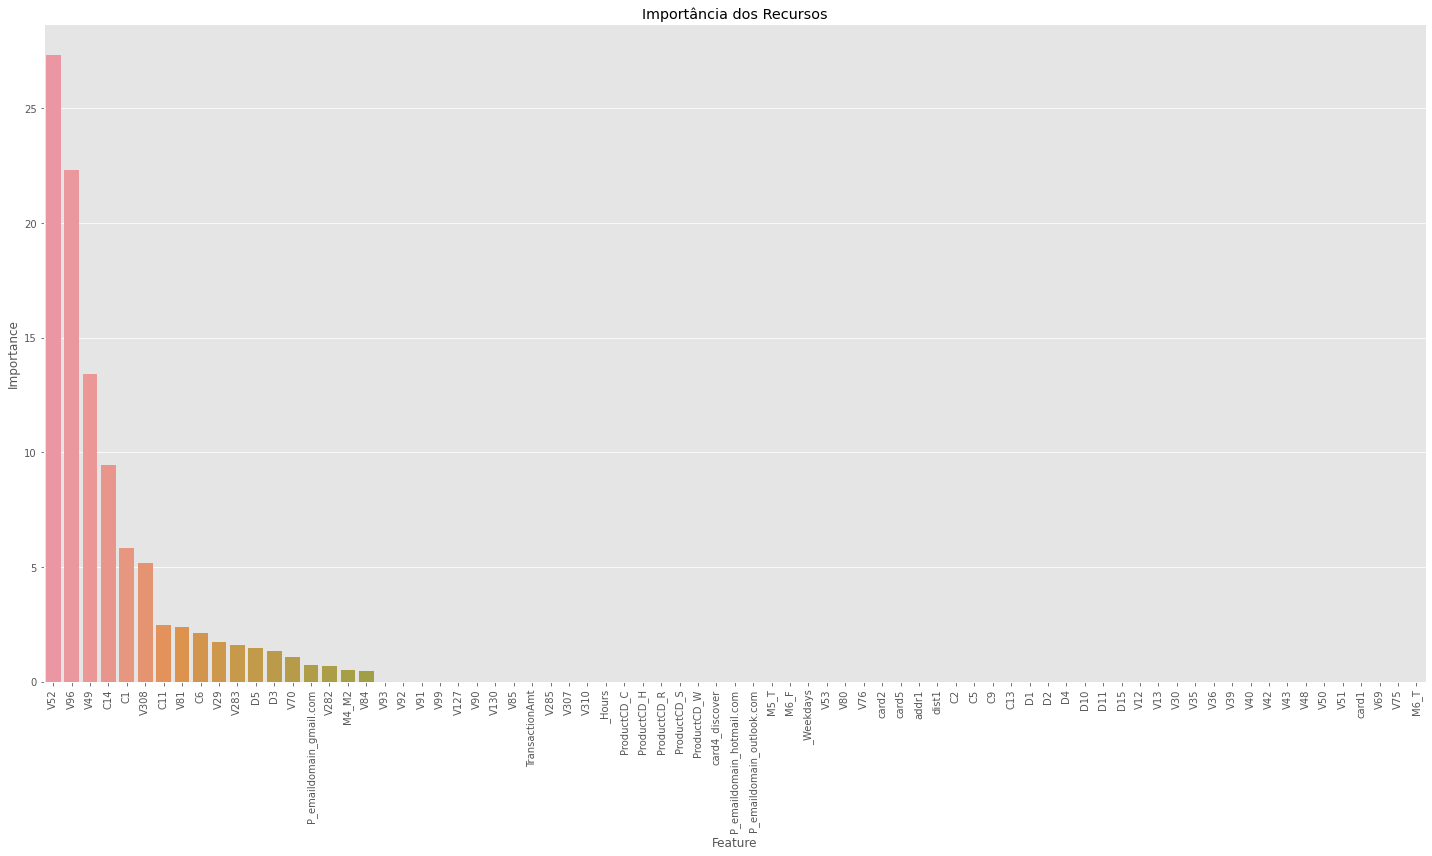

In [196]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3150096310564528
F1-Score Negativo (Teste): 0.958485618584937
F1-Score Positivo Médio (Validação Cruzada): 0.3218858482918533
F1-Score Positivo Fold 1: 0.4555160142348754
F1-Score Positivo Fold 2: 0.3800738007380074
F1-Score Positivo Fold 3: 0.38888888888888884
F1-Score Positivo Fold 4: 0.3747680890538034
F1-Score Positivo Fold 5: 0.36882129277566544
F1-Score Positivo Fold 6: 0.39272727272727276
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.3155893536121673
F1-Score Positivo Fold 9: 0.33904761904761904
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9846295402617529
F1-Score Negativo Fold 1: 0.9867302688638335
F1-Score Negativo Fold 2: 0.9854419410745233
F1-Score Negativo Fold 3: 0.9857031453080323
F1-Score Negativo Fold 4: 0.9854005111987176
F1-Score Negativo Fold 5: 0.9856252164877036
F1-Score Negativo Fold 6: 0.9855235783633842
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score 

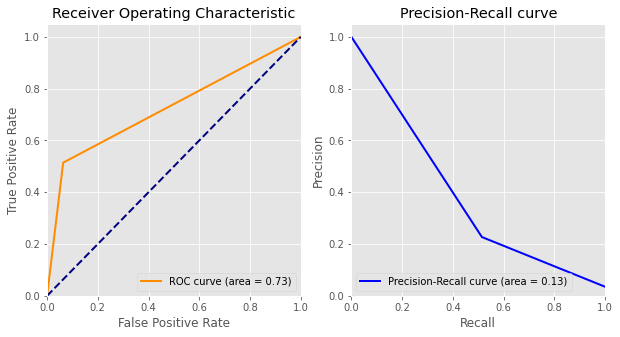

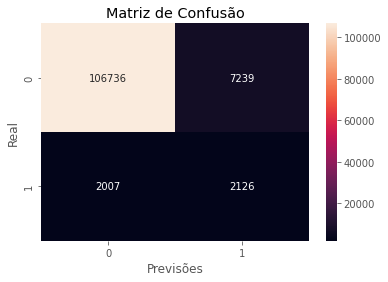

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.51      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 6min 55s, sys: 320 ms, total: 6min 55s
Wall time: 6min 55s


In [197]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [198]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.315009631056453  0.958485618584937
Threshold: 0.05  0.100770677189544  0.577418511742523
Threshold: 0.1   0.132426440193905  0.747674787151491
Threshold: 0.15  0.159949191460257  0.823892092299184
Threshold: 0.2    0.18551268851069  0.867633886827367
Threshold: 0.25  0.209933100639907  0.895885238989613
Threshold: 0.3    0.23572201775276  0.917178504229991
Threshold: 0.35  0.258756611116655  0.931277581947875
Threshold: 0.4   0.278203223225511  0.942254409787946
Threshold: 0.45  0.296714712375016  0.950945139348049
Threshold: 0.5   0.315009631056453  0.958485618584937
Threshold: 0.55  0.333864876206462  0.964614513533154
Threshold: 0.6   0.351516307457562  0.969875514995791
Threshold: 0.65  0.364104213573496  0.973859464319557
Threshold: 0.7   0.367593712212817   0.97705596939626
Threshold: 0.75   0.37125748502994  0.979813691734974

In [199]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
36                        V52  0.250586072904563
18                         D5  0.172499580962333
13                        C14  0.132803674523909
58                       V308  0.078991490417168
11                        C11  0.061288711224886
24                        V29  0.050671835747077
54                       V282  0.032976598309679
50                        V96  0.031552610434247
16                         D3  0.020970364882178
68    P_emaildomain_gmail.com  0.020217171927487
6                          C1  0.018558249771980
9                          C6  0.017874099569158
0              TransactionAmt  0.015503991128385
61                     _Hours  0.011137641392247
60                  _Weekdays  0.009103467569322
55                       V283  0.008455426466238
33                        V49  0.007955856193894
12                        C13  0.007620153611044
5                       dist1  0.006438416937352
73                       M6_F  0.005800142496330
74                       M6_T  0.004812439129134
67             card4_discover  0.003227295250651
40                        V75  0.003079555428367
52                       V127  0.002831349462191
53                       V130  0.002544839618612
17                         D4  0.002444795737922
71                      M4_M2  0.002411750826247
51                        V99  0.002098308633054
72                       M5_T  0.002079916052101
26                        V35  0.002060861555571
69  P_emaildomain_hotmail.com  0.001929612798296
38                        V69  0.001865412743535
56                       V285  0.001738765204611
1                       card1  0.001145244643319
34                        V50  0.000985864371439
70  P_emaildomain_outlook.com  0.000896342055762
10                         C9  0.000849636356318
46                        V90  0.000844593024210
15                         D2  0.000592892094756
22                        V12  0.000554968544428
63                ProductCD_H  0.000000000000000
2                       card2  0.000000000000000
3                       card5  0.000000000000000
57                       V307  0.000000000000000
8                          C5  0.000000000000000
59                       V310  0.000000000000000
7                          C2  0.000000000000000
4                       addr1  0.000000000000000
66                ProductCD_W  0.000000000000000
62                ProductCD_C  0.000000000000000
65                ProductCD_S  0.000000000000000
14                         D1  0.000000000000000
64                ProductCD_R  0.000000000000000
21                        D15  0.000000000000000
48                        V92  0.000000000000000
49                        V93  0.000000000000000
47                        V91  0.000000000000000
23                        V13  0.000000000000000
20                        D11  0.000000000000000
25                        V30  0.000000000000000
27                        V36  0.000000000000000
28                        V39  0.000000000000000
29                        V40  0.000000000000000
30                        V42  0.000000000000000
31                        V43  0.000000000000000
32                        V48  0.000000000000000
19                        D10  0.000000000000000
35                        V51  0.000000000000000
39                        V70  0.000000000000000
41                        V76  0.000000000000000
42                        V80  0.000000000000000
43                        V81  0.000000000000000
44                        V84  0.000000000000000
45                        V85  0.000000000000000
37                        V53  0.000000000000000

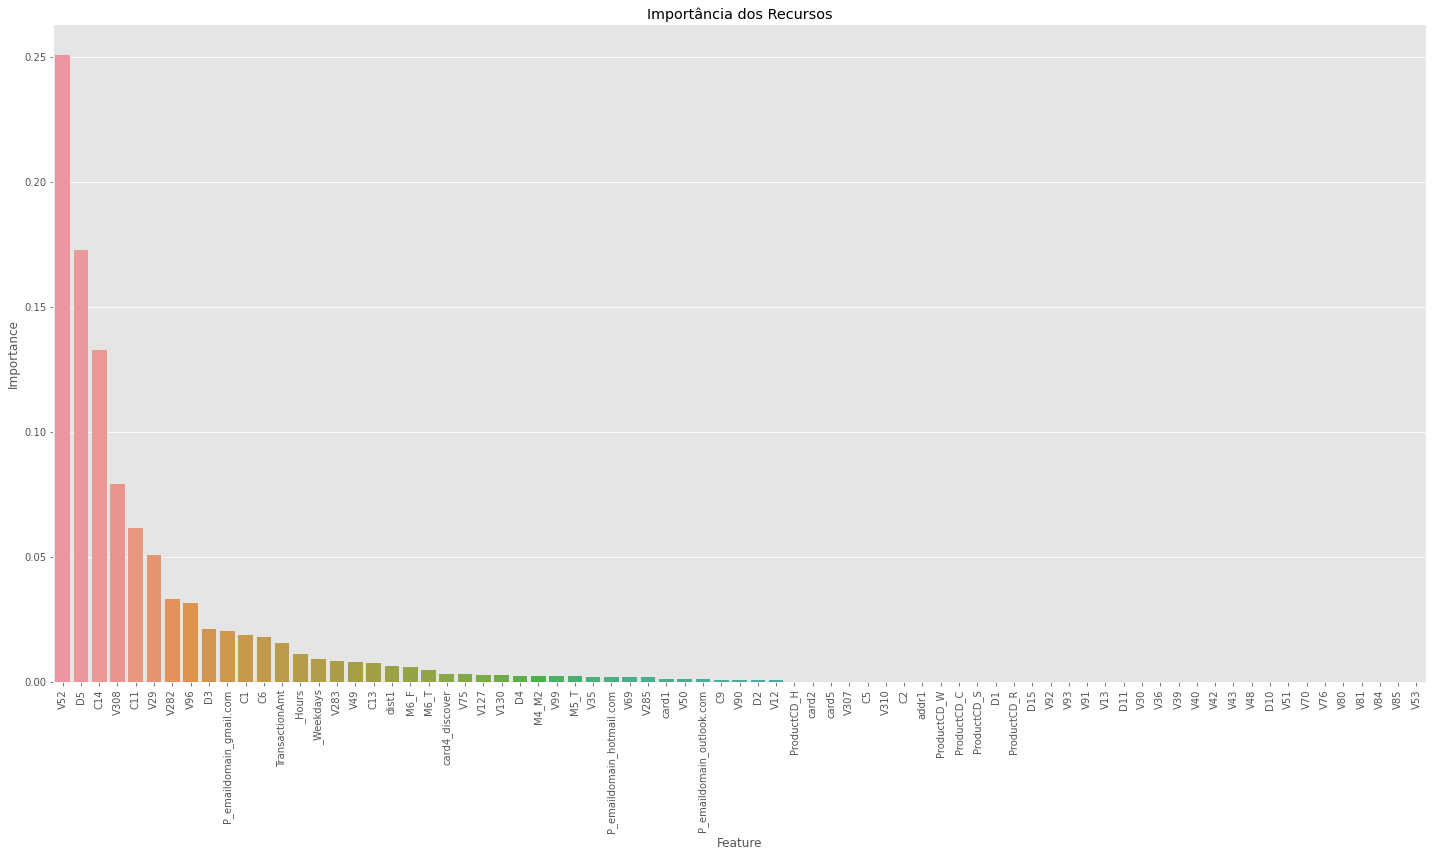

In [200]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.30032733224222585
F1-Score Negativo (Teste): 0.9536903300353867
F1-Score Positivo Médio (Validação Cruzada): 0.33175691446239075
F1-Score Positivo Fold 1: 0.3849056603773585
F1-Score Positivo Fold 2: 0.33396584440227706
F1-Score Positivo Fold 3: 0.35471698113207545
F1-Score Positivo Fold 4: 0.3109404990403071
F1-Score Positivo Fold 5: 0.35067437379576105
F1-Score Positivo Fold 6: 0.37064220183486235
F1-Score Positivo Fold 7: 0.3209393346379647
F1-Score Positivo Fold 8: 0.2928709055876686
F1-Score Positivo Fold 9: 0.289628180039139
F1-Score Positivo Fold 10: 0.30828516377649323
F1-Score Negativo Médio (Validação Cruzada): 0.9848735054649552
F1-Score Negativo Fold 1: 0.9858825567296035
F1-Score Negativo Fold 2: 0.9848019051742802
F1-Score Negativo Fold 3: 0.9851896760782954
F1-Score Negativo Fold 4: 0.9844595472057486
F1-Score Negativo Fold 5: 0.9854131498073845
F1-Score Negativo Fold 6: 0.985136716210946
F1-Score Negativo Fold 7: 0.9849855047380035
F1-Score 

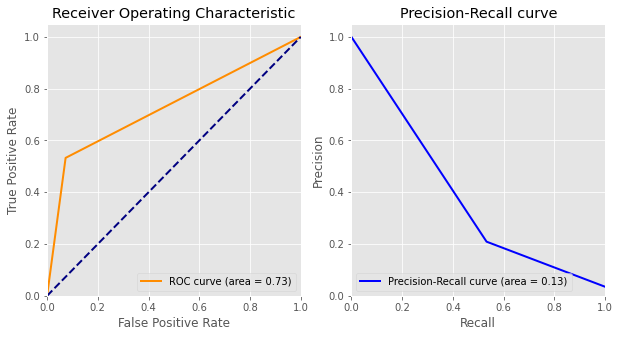

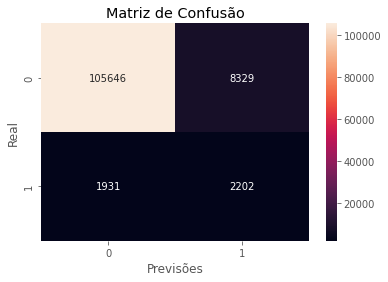

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.21      0.53      0.30      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 8min 6s, sys: 2 s, total: 8min 8s
Wall time: 8min 8s


In [201]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [202]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 21 s, sys: 1e+03 ns, total: 21 s
Wall time: 21 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.300327332242226  0.953690330035387
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.300327332242226  0.953690330035387
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [203]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
50                        V96        0.14
13                        C14        0.08
6                          C1        0.06
61                     _Hours        0.04
5                       dist1        0.04
9                          C6        0.04
18                         D5        0.04
0              TransactionAmt        0.03
73                       M6_F        0.03
55                       V283        0.03
54                       V282        0.03
38                        V69        0.03
36                        V52        0.03
74                       M6_T        0.03
11                        C11        0.03
16                         D3        0.02
12                        C13        0.02
19                        D10        0.02
20                        D11        0.02
56                       V285        0.02
1                       card1        0.02
37                        V53        0.01
60                  _Weekdays        0.01
62                ProductCD_C        0.01
10                         C9        0.01
15                         D2        0.01
41                        V76        0.01
58                       V308        0.01
51                        V99        0.01
46                        V90        0.01
4                       addr1        0.01
33                        V49        0.01
52                       V127        0.01
71                      M4_M2        0.01
72                       M5_T        0.01
67             card4_discover        0.01
68    P_emaildomain_gmail.com        0.01
69  P_emaildomain_hotmail.com        0.01
17                         D4        0.01
70  P_emaildomain_outlook.com        0.01
22                        V12        0.01
53                       V130        0.00
7                          C2        0.00
2                       card2        0.00
64                ProductCD_R        0.00
57                       V307        0.00
65                ProductCD_S        0.00
59                       V310        0.00
66                ProductCD_W        0.00
3                       card5        0.00
63                ProductCD_H        0.00
14                         D1        0.00
8                          C5        0.00
31                        V43        0.00
21                        D15        0.00
23                        V13        0.00
24                        V29        0.00
25                        V30        0.00
26                        V35        0.00
27                        V36        0.00
28                        V39        0.00
29                        V40        0.00
30                        V42        0.00
32                        V48        0.00
49                        V93        0.00
34                        V50        0.00
35                        V51        0.00
39                        V70        0.00
40                        V75        0.00
42                        V80        0.00
43                        V81        0.00
45                        V85        0.00
47                        V91        0.00
48                        V92        0.00
44                        V84        0.00

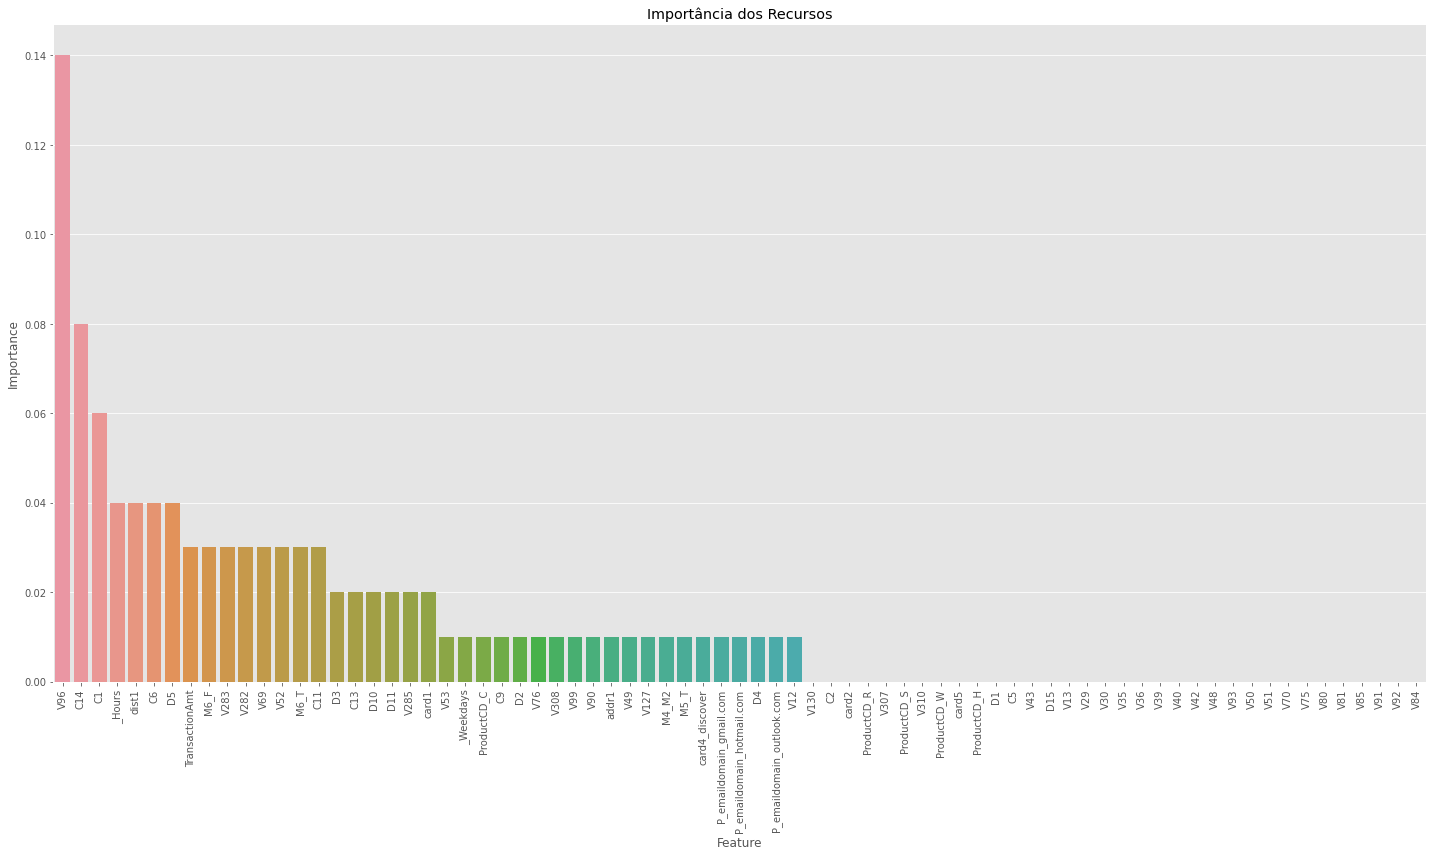

In [204]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.36806231742940604
F1-Score Negativo (Teste): 0.9652153716970683
F1-Score Positivo Médio (Validação Cruzada): 0.2653264413655786
F1-Score Positivo Fold 1: 0.2596491228070176
F1-Score Positivo Fold 2: 0.24956672443674174
F1-Score Positivo Fold 3: 0.2578397212543554
F1-Score Positivo Fold 4: 0.2300884955752212
F1-Score Positivo Fold 5: 0.2857142857142857
F1-Score Positivo Fold 6: 0.2495840266222962
F1-Score Positivo Fold 7: 0.2659758203799654
F1-Score Positivo Fold 8: 0.25569176882662
F1-Score Positivo Fold 9: 0.2842465753424657
F1-Score Positivo Fold 10: 0.31490787269681747
F1-Score Negativo Médio (Validação Cruzada): 0.9815383500891415
F1-Score Negativo Fold 1: 0.9816935623807045
F1-Score Negativo Fold 2: 0.9812106747667607
F1-Score Negativo Fold 3: 0.9815168344324887
F1-Score Negativo Fold 4: 0.981133712104784
F1-Score Negativo Fold 5: 0.9822110378340854
F1-Score Negativo Fold 6: 0.9804091916076626
F1-Score Negativo Fold 7: 0.9815562209781713
F1-Score Negat

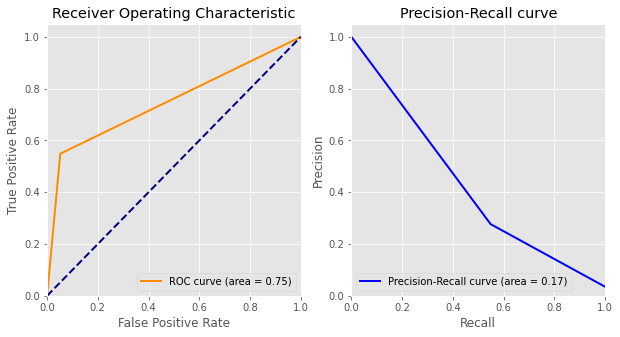

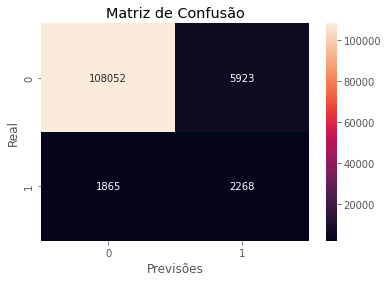

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.28      0.55      0.37      4133

    accuracy                           0.93    118108
   macro avg       0.63      0.75      0.67    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 22min 16s, sys: 664 ms, total: 22min 16s
Wall time: 1min 59s


In [205]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [206]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4h 39min 54s, sys: 1.42 s, total: 4h 39min 55s
Wall time: 23min 36s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.368062317429406  0.965215371697068
Threshold: 0.05  0.308599626888127  0.947681911119814
Threshold: 0.1   0.308599626888127  0.947681911119814
Threshold: 0.15  0.308599626888127  0.947681911119814
Threshold: 0.2   0.308599626888127  0.947681911119814
Threshold: 0.25  0.308599626888127  0.947681911119814
Threshold: 0.3   0.308599626888127  0.947681911119814
Threshold: 0.35  0.368062317429406  0.965215371697068
Threshold: 0.4   0.368062317429406  0.965215371697068
Threshold: 0.45  0.368062317429406  0.965215371697068
Threshold: 0.5   0.368062317429406  0.965215371697068
Threshold: 0.55  0.368062317429406  0.965215371697068
Threshold: 0.6   0.368062317429406  0.965215371697068
Threshold: 0.65  0.368062317429406  0.965215371697068
Threshold: 0.7   0.424749163879599  0.977293329695572
Threshold: 0.75  0.424749163879599  0.977293329695572

### Todas as colunas

In [207]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.663093415007657
F1-Score Negativo (Teste): 0.9904217061553598
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Negat

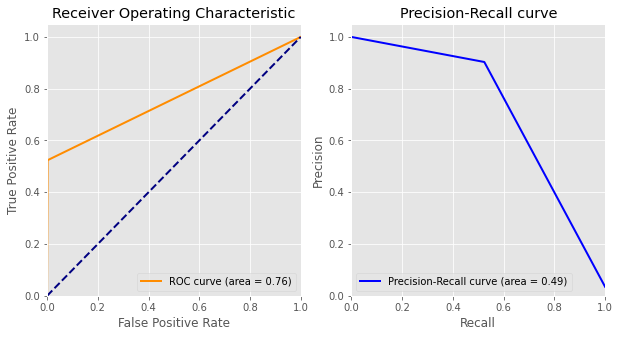

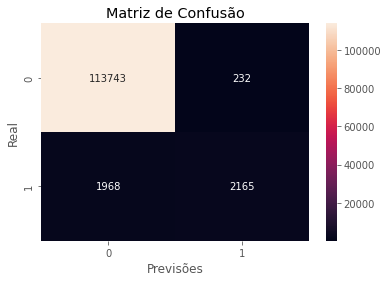

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.52      0.66      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 37s, sys: 328 ms, total: 8min 38s
Wall time: 8min 37s


In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [209]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 52.5 s, sys: 2 µs, total: 52.5 s
Wall time: 52.5 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.663093415007657   0.99042170615536
Threshold: 0.05  0.281888001234997  0.911523739330972
Threshold: 0.1   0.455616967436905  0.963042328401123
Threshold: 0.15  0.579092772480171  0.979008422409387
Threshold: 0.2   0.651985177342509  0.985505201282351
Threshold: 0.25  0.693607467801016  0.988614859079792
Threshold: 0.3   0.710958381061474  0.990055132488757
Threshold: 0.35  0.716161886893594  0.990741145510024
Threshold: 0.4   0.703766160764474  0.990798777826277
Threshold: 0.45  0.693150284796261  0.990840087370133
Threshold: 0.5   0.668896321070234  0.990515507015389
Threshold: 0.55  0.641990864703103  0.990111673271935
Threshold: 0.6   0.615309446254072  0.989733827083225
Threshold: 0.65  0.585546218487395  0.989290646469735
Threshold: 0.7   0.545580830005209  0.988644302407825
Threshold: 0.75  0.498378378378378  0.987930600955494

In [210]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
101         P_emaildomain_gmail.com  0.050761430995628
152                           M4_M2  0.038324227962835
76                      ProductCD_C  0.024760379218867
155                            M6_F  0.023949352800273
154                            M5_T  0.019525219108063
156                            M6_T  0.019376707612568
15                               D2  0.018585252152797
80                      ProductCD_W  0.017595812780659
138         P_emaildomain_yahoo.com  0.016062519883689
68                             V283  0.015263922231222
67                             V282  0.015212807269739
0                    TransactionAmt  0.014975616933843
2                             card2  0.014927452907548
6                                C1  0.013838964348162
1                             card1  0.013789041988151
153                            M5_F  0.013520504189319
104       P_emaildomain_hotmail.com  0.013268485575598
150                           M4_M0  0.012910088074430
78                      ProductCD_R  0.012783465967353
46                              V51  0.012708999295655
13                              C14  0.012555812954292
45                              V50  0.012323402130631
7                                C2  0.012259780899250
66                             V280  0.011947521867027
77                      ProductCD_H  0.011848785385735
73                        _Weekdays  0.011707412343691
159                            M8_F  0.011706784862169
74                           _Hours  0.011339872023055
84                       card4_visa  0.010945514103148
3                             card5  0.010858047566159
160                            M8_T  0.010727536387693
83                 card4_mastercard  0.010668963578999
44                              V49  0.010390930206575
75                            _Days  0.010333048862187
11                              C11  0.010299494737831
12                              C13  0.010274525481085
43                              V48  0.010026246681540
14                               D1  0.009964967431676
148                            M3_F  0.009816132036996
149                            M3_T  0.009798791293605
48                              V53  0.009578642067806
71                             V308  0.009357223617987
62                              V96  0.009235707862239
4                             addr1  0.009231108464204
50                              V69  0.009036913920160
58                              V90  0.009000886304792
51                              V70  0.008814911135390
9                                C6  0.008761222793612
59                              V91  0.008672366540683
49                              V54  0.008497460936151
33                              V12  0.008454401015246
35                              V29  0.008268146732560
70                             V307  0.007946942856903
47                              V52  0.007679522039341
52                              V75  0.007601837413423
18                               D5  0.007394646164101
19                              D10  0.007328510284457
64                             V127  0.007200188761556
36                              V30  0.007073062366953
61                              V93  0.007048420016129
69                             V285  0.006950061322465
72                             V310  0.006702752455274
21                              D15  0.006665000667865
34                              V13  0.006549048554360
16                               D3  0.006488941479630
22                               V1  0.006455564930697
42                              V43  0.006450230397543
151                           M4_M1  0.006441927628272
41                              V42  0.006313436431870
53                              V76  0.006253493274601
86      P_emaildomain_anonymous.com  0.006253100995111
37                              V35  0.006202079284188
40           

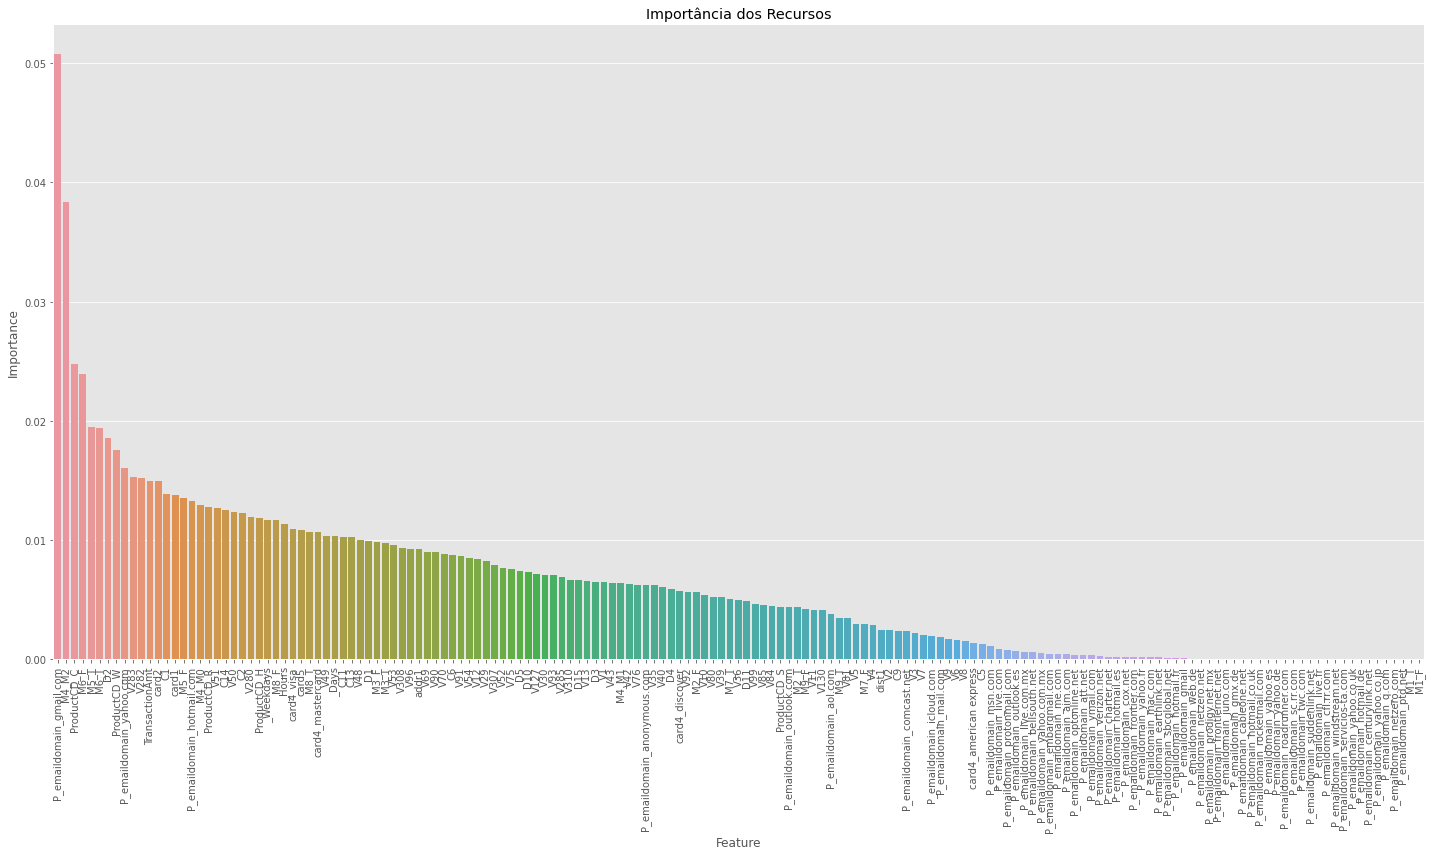

In [211]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.470433062211475
F1-Score Negativo (Teste): 0.9787863577523578
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score N

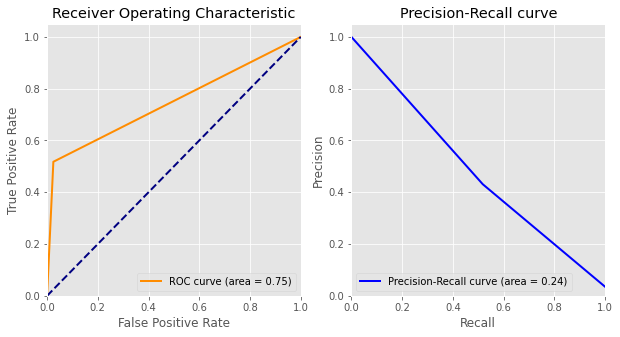

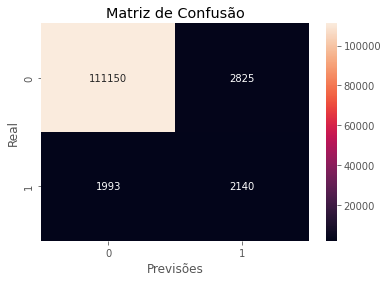

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.43      0.52      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 52s, sys: 320 ms, total: 1min 53s
Wall time: 1min 52s


In [212]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [213]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.26 s, sys: 4 ms, total: 1.27 s
Wall time: 1.27 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.470433062211475  0.978786357752358
Threshold: 0.05  0.470433062211475  0.978786357752358
Threshold: 0.1   0.470433062211475  0.978786357752358
Threshold: 0.15  0.470433062211475  0.978786357752358
Threshold: 0.2   0.470433062211475  0.978786357752358
Threshold: 0.25  0.470433062211475  0.978786357752358
Threshold: 0.3   0.470433062211475  0.978786357752358
Threshold: 0.35  0.470433062211475  0.978786357752358
Threshold: 0.4   0.470433062211475  0.978786357752358
Threshold: 0.45  0.470433062211475  0.978786357752358
Threshold: 0.5   0.470433062211475  0.978786357752358
Threshold: 0.55  0.470433062211475  0.978786357752358
Threshold: 0.6   0.470433062211475  0.978786357752358
Threshold: 0.65  0.470433062211475  0.978786357752358
Threshold: 0.7   0.470433062211475  0.978786357752358
Threshold: 0.75  0.470433062211475  0.978786357752358

In [214]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
66                             V280  0.214865545628497
47                              V52  0.171655105122362
6                                C1  0.129861657939414
13                              C14  0.062623768879648
35                              V29  0.050896398197038
45                              V50  0.044204790246066
67                             V282  0.032853376974826
71                             V308  0.025936343978702
12                              C13  0.015700891422297
1                             card1  0.013858659101766
0                    TransactionAmt  0.012734504087163
2                             card2  0.012445823534857
18                               D5  0.010025651507220
4                             addr1  0.008990669646874
101         P_emaildomain_gmail.com  0.008221858568744
9                                C6  0.007731848231247
7                                C2  0.007139667431481
15                               D2  0.006944287407881
153                            M5_F  0.006104208144507
48                              V53  0.005974921237643
152                           M4_M2  0.005601254212148
75                            _Days  0.005588315014431
11                              C11  0.005384336019567
62                              V96  0.005038672019973
3                             card5  0.004788999394378
104       P_emaildomain_hotmail.com  0.004720808735009
19                              D10  0.004657174588526
10                               C9  0.004235092363000
17                               D4  0.003840151739607
5                             dist1  0.003809306960412
74                           _Hours  0.003765274302698
69                             V285  0.003713977206659
21                              D15  0.003608267404962
68                             V283  0.003507056464511
16                               D3  0.003245000748972
70                             V307  0.003149101876239
73                        _Weekdays  0.002989400280816
72                             V310  0.002914492475126
64                             V127  0.002910313209936
138         P_emaildomain_yahoo.com  0.002903930234484
58                              V90  0.002827048749163
38                              V36  0.002717195624768
82                   card4_discover  0.002470974244740
14                               D1  0.002389015097742
26                               V5  0.002270879901796
36                              V30  0.002140837782007
78                      ProductCD_R  0.002125232358172
77                      ProductCD_H  0.002048943551336
159                            M8_F  0.001905077431206
20                              D11  0.001754857197932
154                            M5_T  0.001692228614555
46                              V51  0.001668584963190
49                              V54  0.001625799991533
53                              V76  0.001533106182432
150                           M4_M0  0.001526516351512
84                       card4_visa  0.001398478570541
120       P_emaildomain_outlook.com  0.001388157154684
86      P_emaildomain_anonymous.com  0.001352036319477
155                            M6_F  0.001335417043062
63                              V99  0.001235120240699
52                              V75  0.001174474218955
25                               V4  0.001123405831855
55                              V81  0.001123398638008
149                            M3_T  0.001060333864251
83                 card4_mastercard  0.001027817442314
65                             V130  0.001022464419274
27                               V6  0.001017001314638
160                            M8_T  0.000999386336231
33                              V12  0.000979565996128
94        P_emaildomain_comcast.net  0.000959877886294
22                               V1  0.000944243708864
156                            M6_T  0.000864236043888
41           

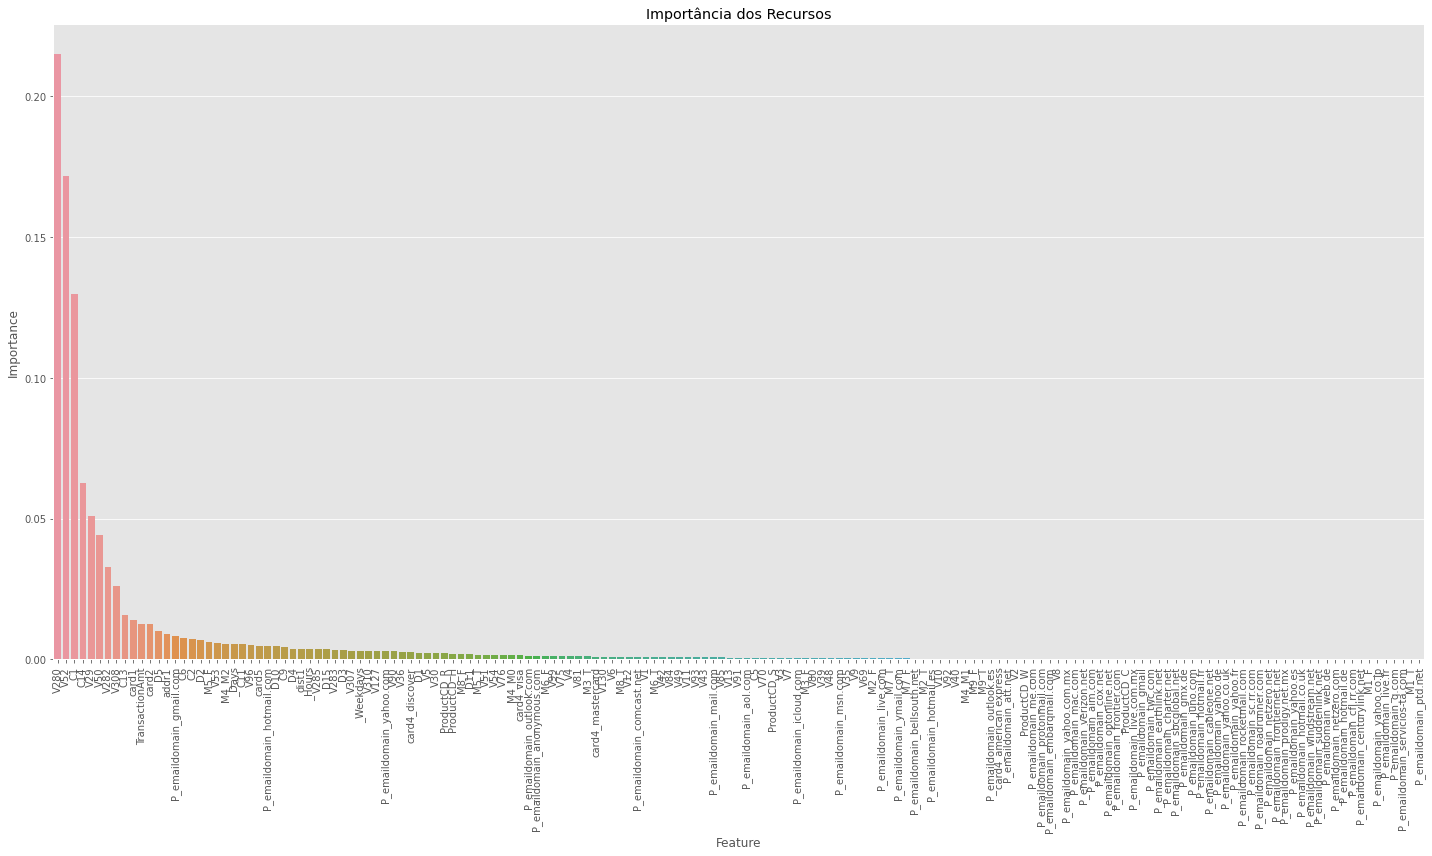

In [215]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6171329	total: 79ms	remaining: 316ms
1:	learn: 0.5462051	total: 152ms	remaining: 227ms
2:	learn: 0.4978456	total: 226ms	remaining: 150ms
3:	learn: 0.4484678	total: 300ms	remaining: 75.1ms
4:	learn: 0.4161525	total: 373ms	remaining: 0us
0:	learn: 0.5336608	total: 13ms	remaining: 52.1ms
1:	learn: 0.4271318	total: 23ms	remaining: 34.5ms
2:	learn: 0.3416706	total: 31.6ms	remaining: 21.1ms
3:	learn: 0.2888256	total: 39.5ms	remaining: 9.87ms
4:	learn: 0.2438958	total: 47.9ms	remaining: 0us
0:	learn: 0.5331992	total: 8.01ms	remaining: 32ms
1:	learn: 0.4266171	total: 16.2ms	remaining: 24.3ms
2:	learn: 0.3413103	total: 24.6ms	remaining: 16.4ms
3:	learn: 0.2883925	total: 32.4ms	remaining: 8.1ms
4:	learn: 0.2434156	total: 41ms	remaining: 0us
0:	learn: 0.5334749	total: 8.14ms	remaining: 32.6ms
1:	learn: 0.4268605	total: 16.5ms	remaining: 24.7ms
2:	learn: 0.3408881	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.2880311	total: 32.4ms	remaining: 8.11ms
4:	learn: 0.2431527	total: 41ms	remaini

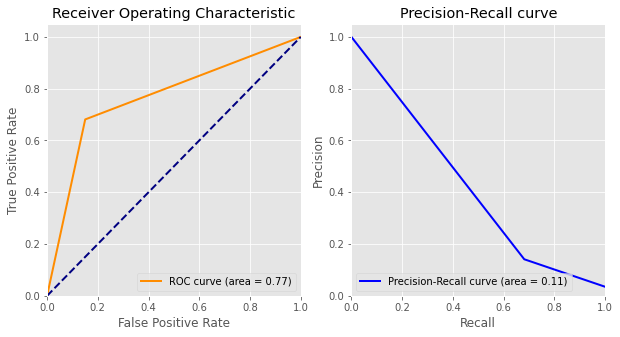

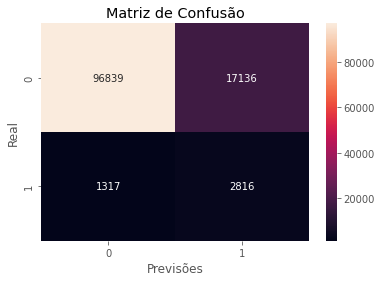

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.77      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 1min 56s, sys: 740 ms, total: 1min 56s
Wall time: 1min 31s


In [216]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [217]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 44.1 s, sys: 36 ms, total: 44.1 s
Wall time: 43.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.233838488685904   0.91301129962146
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.068132502784539  0.017946109502569
Threshold: 0.25  0.075451400803109  0.223468473731355
Threshold: 0.3   0.114250500693268  0.664378363863496
Threshold: 0.35   0.15027437737442  0.799968620067467
Threshold: 0.4   0.178932907169092  0.853975836329276
Threshold: 0.45  0.207168581718402   0.88836623024133
Threshold: 0.5   0.233838488685904   0.91301129962146
Threshold: 0.55  0.280751506557958   0.94448447261617
Threshold: 0.6   0.343003899933416  0.969397836980457
Threshold: 0.65  0.349465558194774  0.980904654000349
Threshold: 0.7   0.236005461283402  0.983049820631878
Threshold: 0.75  0.193371332066709  0.983493103046065

In [218]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
66                             V280  27.124065005569381
24                               V3  21.979038082937500
13                              C14  10.733099182846935
138         P_emaildomain_yahoo.com   6.891637485986405
101         P_emaildomain_gmail.com   6.012051417086734
6                                C1   5.084605163901112
47                              V52   4.420182689317677
11                              C11   3.948009387535451
7                                C2   3.184196596433307
58                              V90   1.846264148086088
44                              V49   1.756896134624492
68                             V283   1.573543873213223
18                               D5   1.358029568517351
51                              V70   1.333217888482947
54                              V80   1.036273866456614
10                               C9   0.984610029425918
67                             V282   0.734279479578871
116           P_emaildomain_msn.com   0.000000000000000
112           P_emaildomain_live.fr   0.000000000000000
113           P_emaildomain_mac.com   0.000000000000000
114          P_emaildomain_mail.com   0.000000000000000
115            P_emaildomain_me.com   0.000000000000000
117       P_emaildomain_netzero.com   0.000000000000000
92         P_emaildomain_cfl.rr.com   0.000000000000000
93        P_emaildomain_charter.net   0.000000000000000
118       P_emaildomain_netzero.net   0.000000000000000
119     P_emaildomain_optonline.net   0.000000000000000
120       P_emaildomain_outlook.com   0.000000000000000
121        P_emaildomain_outlook.es   0.000000000000000
91    P_emaildomain_centurylink.net   0.000000000000000
111       P_emaildomain_live.com.mx   0.000000000000000
94        P_emaildomain_comcast.net   0.000000000000000
110          P_emaildomain_live.com   0.000000000000000
103     P_emaildomain_hotmail.co.uk   0.000000000000000
96      P_emaildomain_earthlink.net   0.000000000000000
98       P_emaildomain_frontier.com   0.000000000000000
99    P_emaildomain_frontiernet.net   0.000000000000000
100             P_emaildomain_gmail   0.000000000000000
95            P_emaildomain_cox.net   0.000000000000000
102            P_emaildomain_gmx.de   0.000000000000000
104       P_emaildomain_hotmail.com   0.000000000000000
97     P_emaildomain_embarqmail.com   0.000000000000000
105        P_emaildomain_hotmail.de   0.000000000000000
106        P_emaildomain_hotmail.es   0.000000000000000
123    P_emaildomain_protonmail.com   0.000000000000000
107        P_emaildomain_hotmail.fr   0.000000000000000
108        P_emaildomain_icloud.com   0.000000000000000
109          P_emaildomain_juno.com   0.000000000000000
122    P_emaildomain_prodigy.net.mx   0.000000000000000
0                    TransactionAmt   0.000000000000000
124           P_emaildomain_ptd.net   0.000000000000000
153                            M5_F   0.000000000000000
146                            M2_F   0.000000000000000
147                            M2_T   0.000000000000000
148                            M3_F   0.000000000000000
149                            M3_T   0.000000000000000
150                           M4_M0   0.000000000000000
151                           M4_M1   0.000000000000000
152                           M4_M2   0.000000000000000
154                            M5_T   0.000000000000000
144                            M1_F   0.000000000000000
155                            M6_F   0.000000000000000
156                            M6_T   0.000000000000000
157                            M7_F   0.000000000000000
158                            M7_T   0.000000000000000
159                            M8_F   0.000000000000000
160                            M8_T   0.000000000000000
161                            M9_F   0.000000000000000
145                            M1_T   0.000000000000000
143         P_emaildomain_ymail.com   0.000000000000000
125             P_emaildomain_q.com   0.000000000000

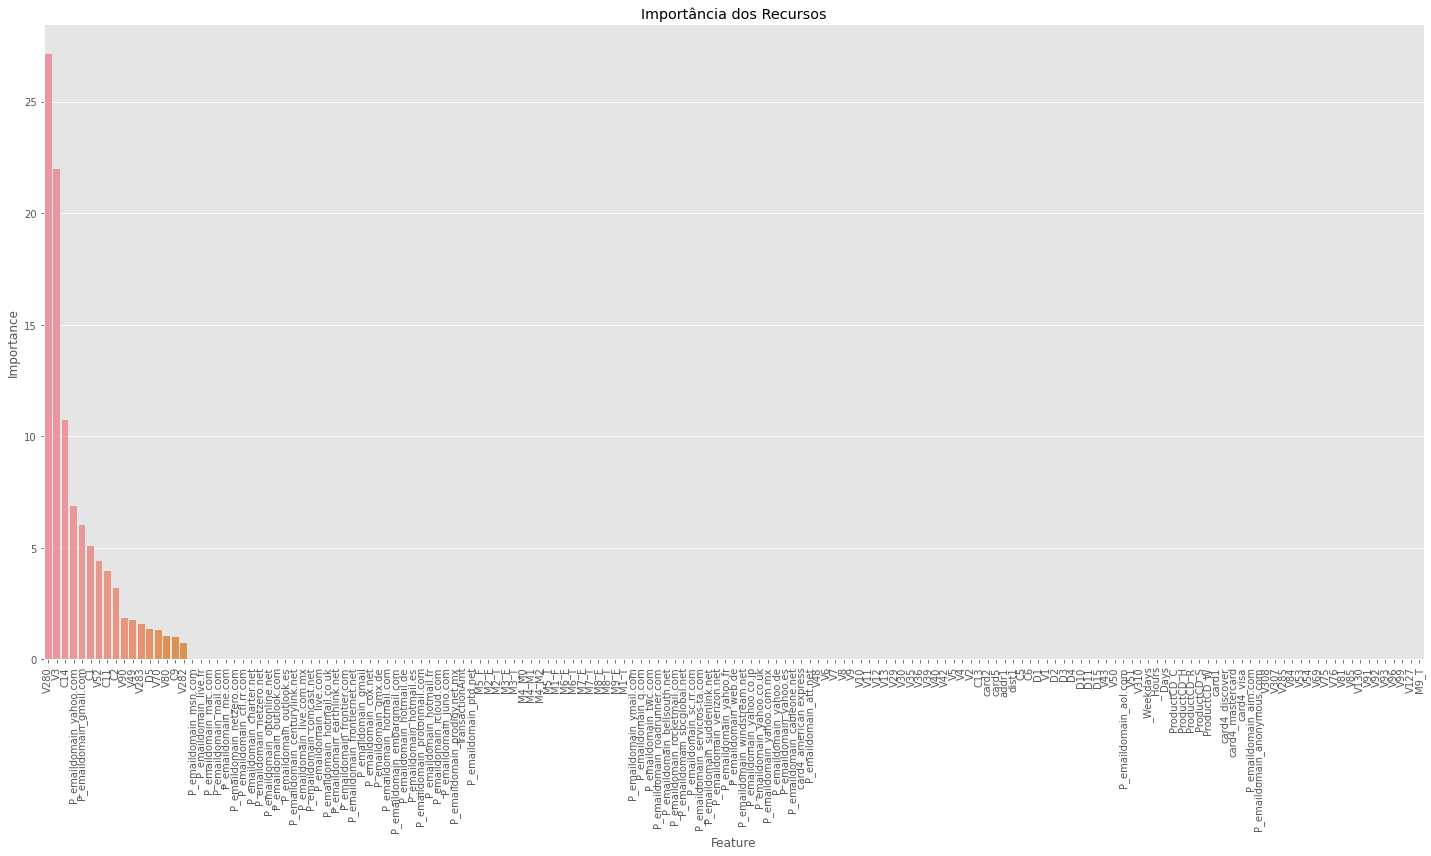

In [219]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3341184114350687
F1-Score Negativo (Teste): 0.9633814642948061
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

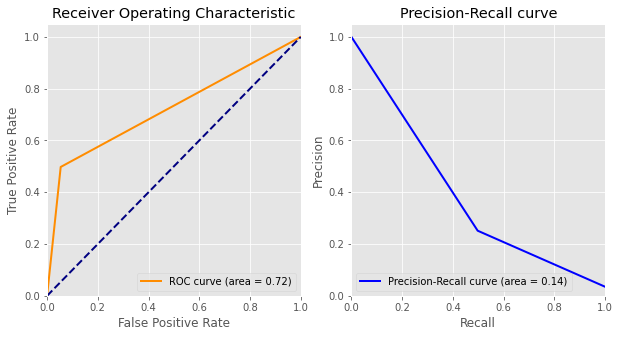

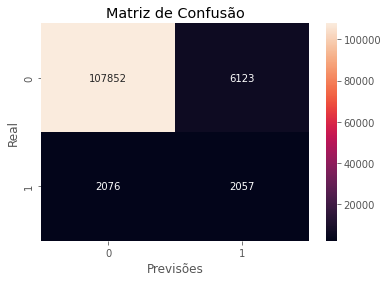

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    113975
           1       0.25      0.50      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 8min 52s, sys: 352 ms, total: 8min 52s
Wall time: 8min 52s


In [220]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [221]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.74 s, sys: 1e+03 ns, total: 2.74 s
Wall time: 2.74 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334118411435069  0.963381464294806
Threshold: 0.05  0.103403374590512  0.599329899117353
Threshold: 0.1   0.135176291437273  0.760543585197358
Threshold: 0.15  0.167628096369189  0.838867133220485
Threshold: 0.2   0.200477960701009  0.883117891386204
Threshold: 0.25  0.225302318106946  0.908751922394416
Threshold: 0.3   0.249187125960134   0.92589129979767
Threshold: 0.35  0.274617067833698  0.939156449599882
Threshold: 0.4   0.292371288989102  0.948703745743473
Threshold: 0.45  0.312777221347832  0.956776068899108
Threshold: 0.5   0.334118411435069  0.963381464294806
Threshold: 0.55  0.352703199705774  0.968758320759741
Threshold: 0.6   0.367837529789659  0.973071745415223
Threshold: 0.65  0.373172429798097  0.976265169289713
Threshold: 0.7   0.373426754898145  0.978867353145828
Threshold: 0.75  0.363451776649746  0.980860889321083

In [222]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
47                              V52  0.242312674020157
18                               D5  0.164748081327512
13                              C14  0.127206595446301
66                             V280  0.122121958559161
50                              V69  0.057259476517966
11                              C11  0.055667063585214
101         P_emaildomain_gmail.com  0.024415758726895
9                                C6  0.022902908209655
67                             V282  0.021431284816865
16                               D3  0.014133432137099
6                                C1  0.014072335821916
0                    TransactionAmt  0.011541596510742
138         P_emaildomain_yahoo.com  0.011274094860435
74                           _Hours  0.009413692743820
73                        _Weekdays  0.009408734549578
64                             V127  0.007383292506070
152                           M4_M2  0.007145596575132
12                              C13  0.006165316087527
62                              V96  0.005863103863372
31                              V10  0.005355092947739
71                             V308  0.004884908835994
69                             V285  0.004579186428000
32                              V11  0.004430224156999
82                   card4_discover  0.004153527131173
154                            M5_T  0.003976101383948
49                              V54  0.003847978290908
153                            M5_F  0.003263914962509
155                            M6_F  0.003145559648268
17                               D4  0.002864077964837
104       P_emaildomain_hotmail.com  0.002846924309476
150                           M4_M0  0.002623419359260
27                               V6  0.002253680905884
156                            M6_T  0.001714975231655
24                               V3  0.001658959384040
148                            M3_F  0.001645361242134
149                            M3_T  0.001637630126559
84                       card4_visa  0.001512604605871
94        P_emaildomain_comcast.net  0.001350830306264
1                             card1  0.001148837026289
120       P_emaildomain_outlook.com  0.001132657500799
44                              V49  0.001095117844743
83                 card4_mastercard  0.000830509999101
25                               V4  0.000673966643763
114          P_emaildomain_mail.com  0.000665816264502
30                               V9  0.000630621728129
87            P_emaildomain_aol.com  0.000557185986445
38                              V36  0.000551800579910
10                               C9  0.000501532339386
105        P_emaildomain_hotmail.de  0.000000000000000
113           P_emaildomain_mac.com  0.000000000000000
117       P_emaildomain_netzero.com  0.000000000000000
161                            M9_F  0.000000000000000
158                            M7_T  0.000000000000000
159                            M8_F  0.000000000000000
116           P_emaildomain_msn.com  0.000000000000000
115            P_emaildomain_me.com  0.000000000000000
102            P_emaildomain_gmx.de  0.000000000000000
112           P_emaildomain_live.fr  0.000000000000000
106        P_emaildomain_hotmail.es  0.000000000000000
111       P_emaildomain_live.com.mx  0.000000000000000
103     P_emaildomain_hotmail.co.uk  0.000000000000000
160                            M8_T  0.000000000000000
147                            M2_T  0.000000000000000
118       P_emaildomain_netzero.net  0.000000000000000
110          P_emaildomain_live.com  0.000000000000000
109          P_emaildomain_juno.com  0.000000000000000
108        P_emaildomain_icloud.com  0.000000000000000
107        P_emaildomain_hotmail.fr  0.000000000000000
157                            M7_F  0.000000000000000
143         P_emaildomain_ymail.com  0.000000000000000
146                            M2_F  0.000000000000000
119     P_emaildomain_optonline.net  0.000000000000000
141          

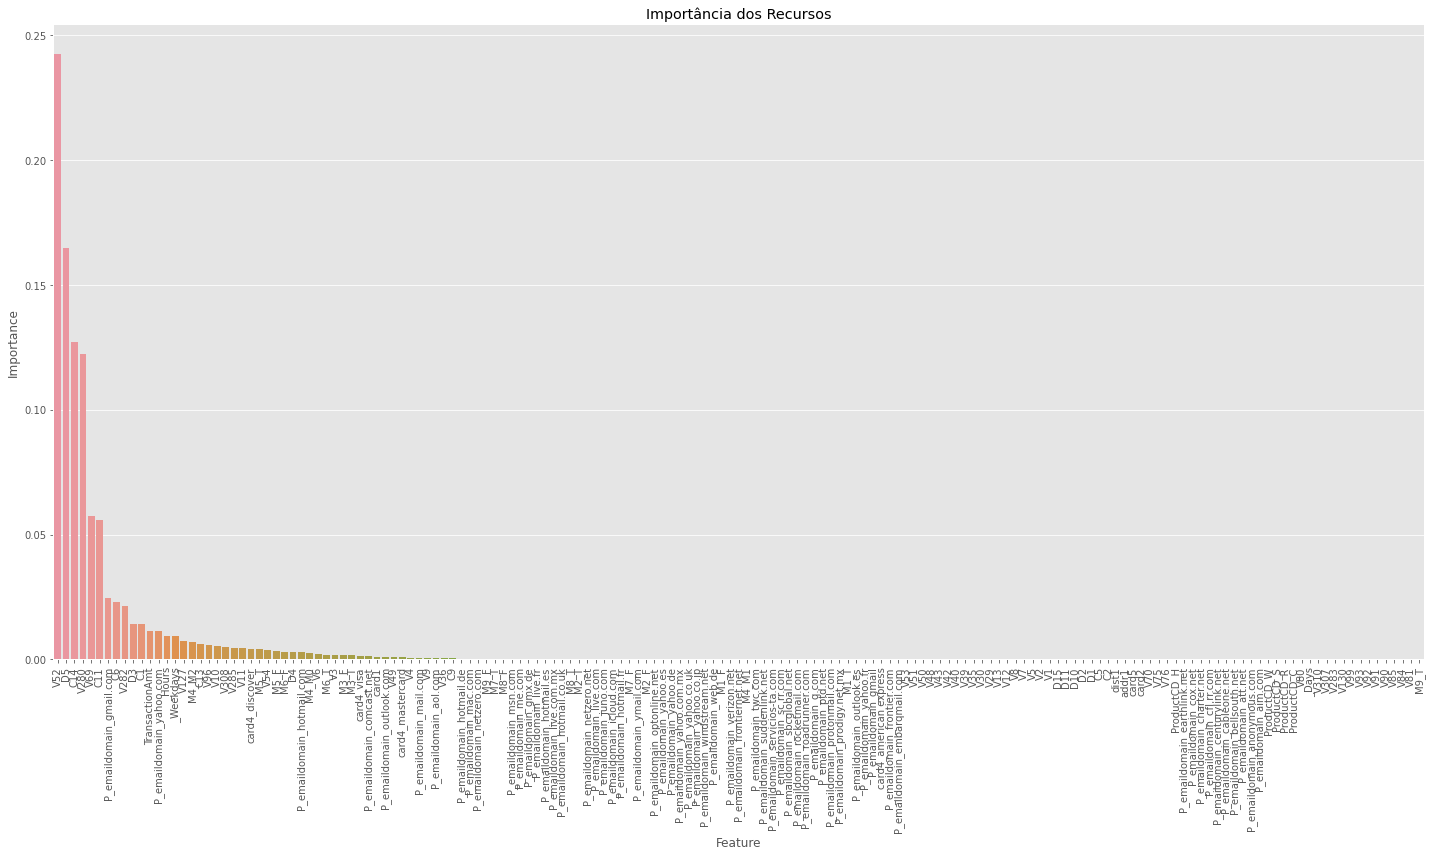

In [223]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3185745966200199
F1-Score Negativo (Teste): 0.9600652508077925
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Neg

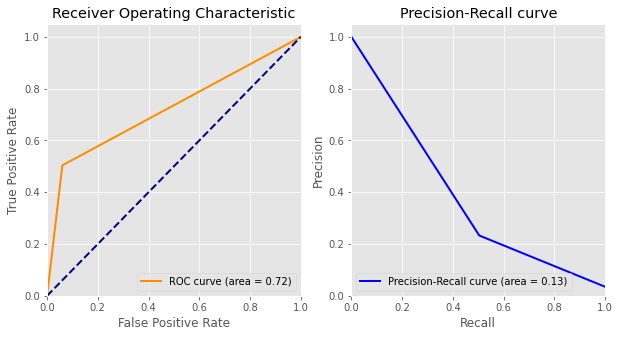

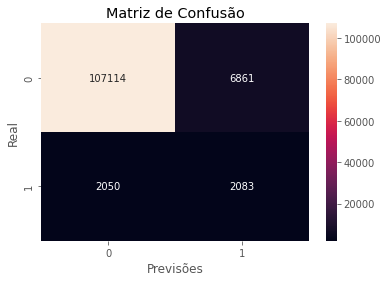

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.50      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.72      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 10min 52s, sys: 7.96 s, total: 11min
Wall time: 11min


In [224]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [225]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 33.7 s, sys: 4 ms, total: 33.7 s
Wall time: 33.7 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.31857459662002  0.960065250807792
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5    0.31857459662002  0.960065250807792
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [226]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
66                             V280        0.10
62                              V96        0.07
6                                C1        0.07
13                              C14        0.06
18                               D5        0.04
71                             V308        0.04
74                           _Hours        0.04
50                              V69        0.03
9                                C6        0.03
16                               D3        0.02
31                              V10        0.02
148                            M3_F        0.02
69                             V285        0.02
152                           M4_M2        0.02
20                              D11        0.02
138         P_emaildomain_yahoo.com        0.02
0                    TransactionAmt        0.02
156                            M6_T        0.02
12                              C13        0.02
101         P_emaildomain_gmail.com        0.02
11                              C11        0.02
155                            M6_F        0.02
84                       card4_visa        0.02
1                             card1        0.01
87            P_emaildomain_aol.com        0.01
47                              V52        0.01
94        P_emaildomain_comcast.net        0.01
104       P_emaildomain_hotmail.com        0.01
120       P_emaildomain_outlook.com        0.01
68                             V283        0.01
67                             V282        0.01
83                 card4_mastercard        0.01
82                   card4_discover        0.01
73                        _Weekdays        0.01
114          P_emaildomain_mail.com        0.01
43                              V48        0.01
49                              V54        0.01
149                            M3_T        0.01
5                             dist1        0.01
24                               V3        0.01
30                               V9        0.01
32                              V11        0.01
19                              D10        0.01
17                               D4        0.01
151                           M4_M1        0.01
10                               C9        0.01
150                           M4_M0        0.01
103     P_emaildomain_hotmail.co.uk        0.00
118       P_emaildomain_netzero.net        0.00
161                            M9_F        0.00
117       P_emaildomain_netzero.com        0.00
102            P_emaildomain_gmx.de        0.00
153                            M5_F        0.00
160                            M8_T        0.00
154                            M5_T        0.00
116           P_emaildomain_msn.com        0.00
115            P_emaildomain_me.com        0.00
107        P_emaildomain_hotmail.fr        0.00
108        P_emaildomain_icloud.com        0.00
112           P_emaildomain_live.fr        0.00
111       P_emaildomain_live.com.mx        0.00
159                            M8_F        0.00
105        P_emaildomain_hotmail.de        0.00
157                            M7_F        0.00
158                            M7_T        0.00
110          P_emaildomain_live.com        0.00
109          P_emaildomain_juno.com        0.00
106        P_emaildomain_hotmail.es        0.00
113           P_emaildomain_mac.com        0.00
142          P_emaildomain_yahoo.fr        0.00
141          P_emaildomain_yahoo.es        0.00
147                            M2_T        0.00
140          P_emaildomain_yahoo.de        0.00
139      P_emaildomain_yahoo.com.mx        0.00
143         P_emaildomain_ymail.com        0.00
137       P_emaildomain_yahoo.co.uk        0.00
144                            M1_F        0.00
136       P_emaildomain_yahoo.co.jp        0.00
135    P_emaildomain_windstream.net        0.00
134            P_emaildomain_web.de        0.00
145                            M1_T        0.00
133       P_emaildomain_verizon.net        0.00
99    P_emaildomain_frontiernet.net        0

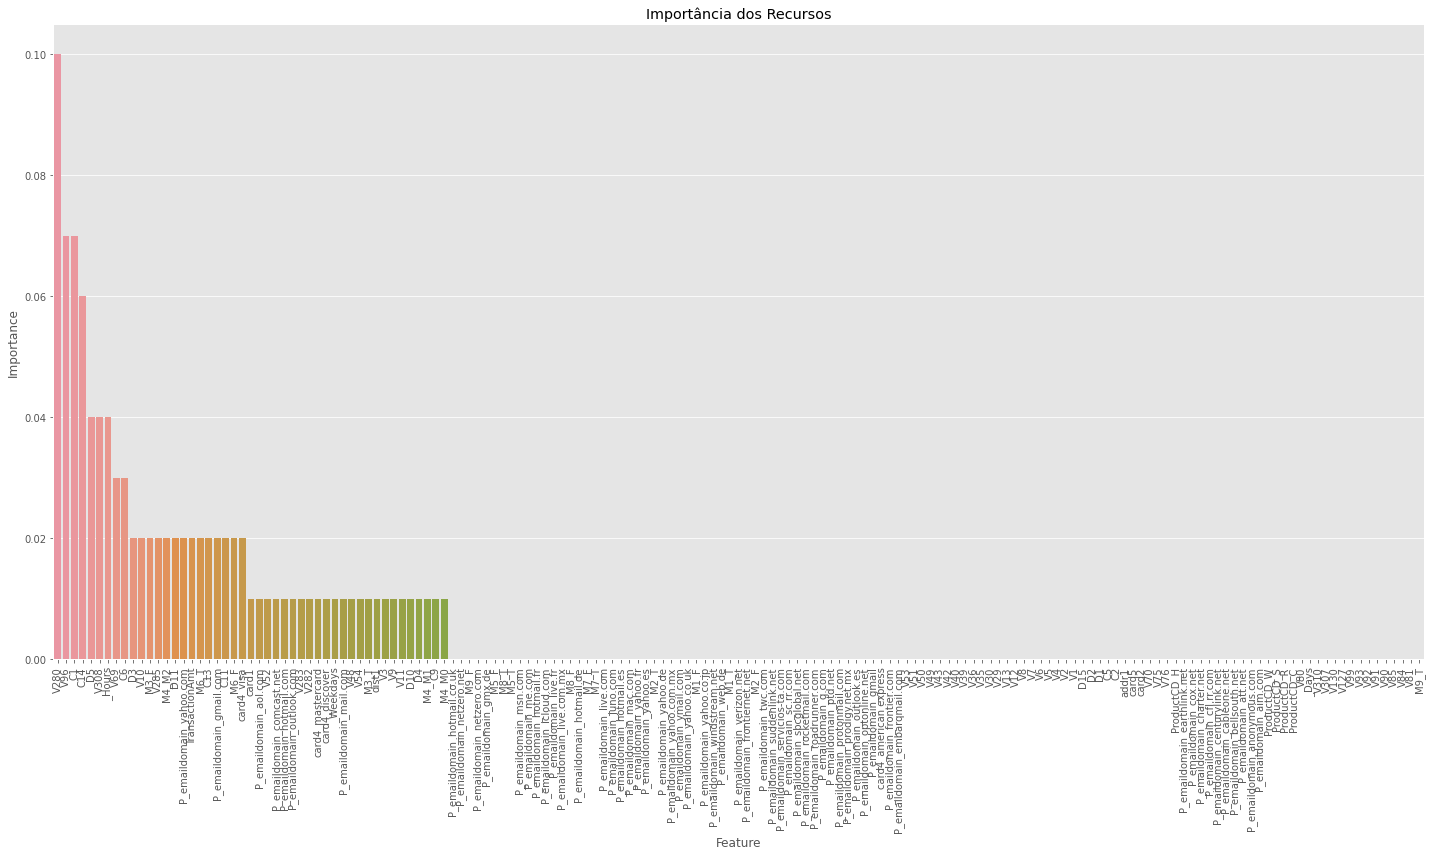

In [227]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3693854386249392
F1-Score Negativo (Teste): 0.9652584843801646
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

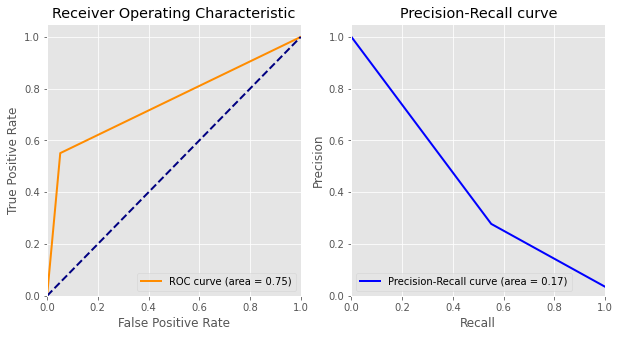

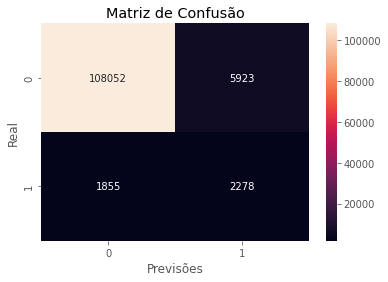

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.28      0.55      0.37      4133

    accuracy                           0.93    118108
   macro avg       0.63      0.75      0.67    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 39min 35s, sys: 900 ms, total: 39min 36s
Wall time: 3min 27s


In [228]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [229]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 7h 59min 53s, sys: 1.41 s, total: 7h 59min 54s
Wall time: 43min 10s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.369385438624939  0.965258484380165
Threshold: 0.05  0.309615849238947  0.947965036875171
Threshold: 0.1   0.309615849238947  0.947965036875171
Threshold: 0.15  0.309615849238947  0.947965036875171
Threshold: 0.2   0.309615849238947  0.947965036875171
Threshold: 0.25  0.309615849238947  0.947965036875171
Threshold: 0.3   0.309615849238947  0.947965036875171
Threshold: 0.35  0.369385438624939  0.965258484380165
Threshold: 0.4   0.369385438624939  0.965258484380165
Threshold: 0.45  0.369385438624939  0.965258484380165
Threshold: 0.5   0.369385438624939  0.965258484380165
Threshold: 0.55  0.369385438624939  0.965258484380165
Threshold: 0.6   0.369385438624939  0.965258484380165
Threshold: 0.65  0.369385438624939  0.965258484380165
Threshold: 0.7   0.423213493120284  0.977121881657013
Threshold: 0.75  0.423213493120284  0.977121881657013

In [230]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.9e+04 s


## Validação Cruzada para Oversample com AdaSyn

### 50 Chi-Square

In [231]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.5705986360191968
F1-Score Negativo (Teste): 0.9851071844694216
F1-Score Positivo Médio (Validação Cruzada): 0.48560085938136555
F1-Score Positivo Fold 1: 0.5152
F1-Score Positivo Fold 2: 0.46766169154228854
F1-Score Positivo Fold 3: 0.5352564102564102
F1-Score Positivo Fold 4: 0.4758735440931781
F1-Score Positivo Fold 5: 0.5252854812398042
F1-Score Positivo Fold 6: 0.49201277955271566
F1-Score Positivo Fold 7: 0.4547008547008547
F1-Score Positivo Fold 8: 0.431239388794567
F1-Score Positivo Fold 9: 0.4901315789473684
F1-Score Positivo Fold 10: 0.46864686468646855
F1-Score Negativo Médio (Validação Cruzada): 0.986425634411901
F1-Score Negativo Fold 1: 0.9868243683958776
F1-Score Negativo Fold 2: 0.9860549980450931
F1-Score Negativo Fold 3: 0.9873902078441603
F1-Score Negativo Fold 4: 0.9863168411450415
F1-Score Negativo Fold 5: 0.9873527750010866
F1-Score Negativo Fold 6: 0.9861715080883632
F1-Score Negativo Fold 7: 0.9861527108564483
F1-Score Negativo Fold 8

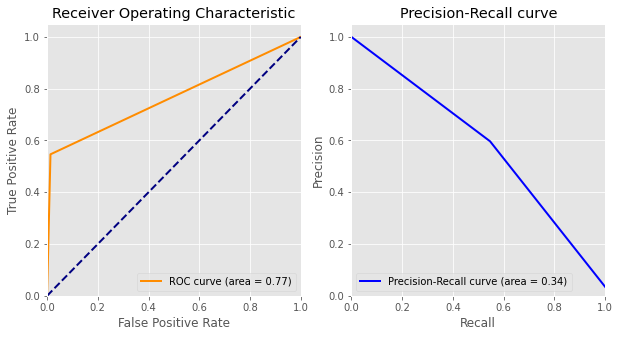

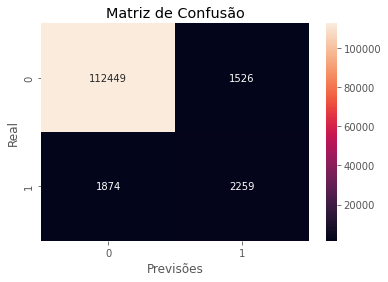

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.60      0.55      0.57      4133

    accuracy                           0.97    118108
   macro avg       0.79      0.77      0.78    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 4min 18s, sys: 332 ms, total: 4min 18s
Wall time: 4min 18s


In [232]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [233]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53 s, sys: 3 µs, total: 53 s
Wall time: 53 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.570598636019197  0.985107184469422
Threshold: 0.05  0.161694198913859  0.808055898068229
Threshold: 0.1   0.250639193863739  0.904923194351684
Threshold: 0.15  0.337989271867863   0.94265986466532
Threshold: 0.2   0.415120087336245  0.961310705903593
Threshold: 0.25  0.472969677262011  0.971047049103455
Threshold: 0.3   0.514512848955445  0.976698994667211
Threshold: 0.35  0.542541093766153  0.980467284356612
Threshold: 0.4   0.563804845372334  0.982808161612961
Threshold: 0.45  0.569907735982967  0.984035967369447
Threshold: 0.5   0.568941937088151  0.984805388893515
Threshold: 0.55  0.568004168837936   0.98549050494443
Threshold: 0.6   0.561627118644068  0.985872286871671
Threshold: 0.65  0.549950821975551  0.986019144561958
Threshold: 0.7   0.537562116340251  0.986205934412793
Threshold: 0.75  0.514008783886112  0.986024310470226

In [234]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
9              C13  0.080221449258098
0   TransactionAmt  0.067991210185370
3               C1  0.062455869408160
16             D11  0.062251079639848
1            card1  0.058424309687335
10              D1  0.057829688504704
4               C2  0.049393277098878
21            V283  0.049352779892186
7               C9  0.046208014409038
11              D2  0.044171124337164
8              C11  0.044087342949063
15             D10  0.041715031143088
5               C5  0.040330271509954
6               C6  0.039688062205978
14              D5  0.037363552308099
17             D15  0.035422408577013
13              D4  0.034675193361301
23            V308  0.024421325205295
12              D3  0.024029373817613
18             V96  0.022217020979003
2            dist1  0.019190076690659
22            V307  0.016938932293669
19            V127  0.015460922536538
24            V310  0.014605404689199
20            V130  0.011556279312745

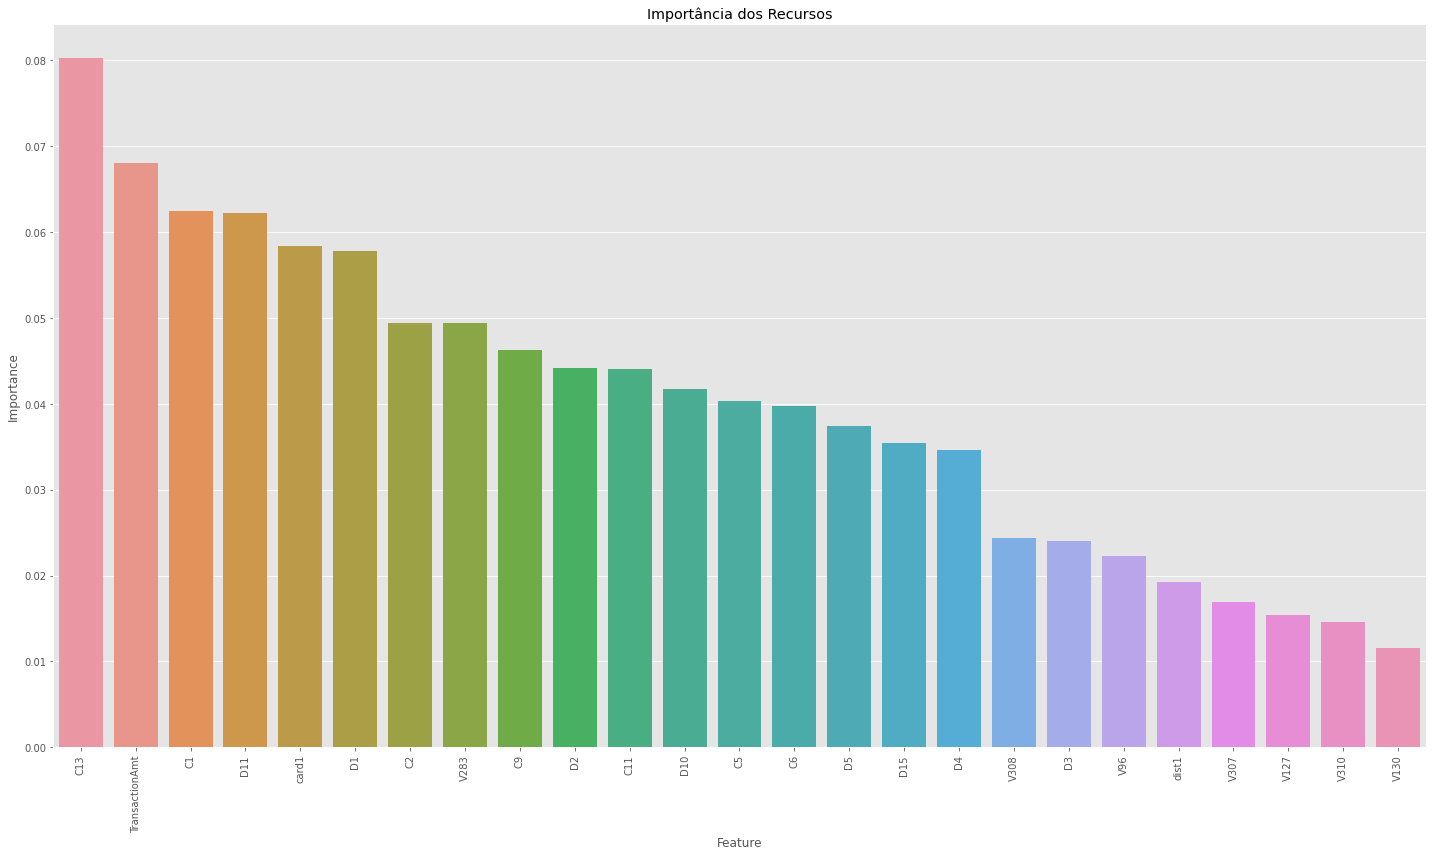

In [235]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.43824946192477193
F1-Score Negativo (Teste): 0.9757969433760636
F1-Score Positivo Médio (Validação Cruzada): 0.4009967209424364
F1-Score Positivo Fold 1: 0.43058823529411766
F1-Score Positivo Fold 2: 0.38390804597701145
F1-Score Positivo Fold 3: 0.4287369640787949
F1-Score Positivo Fold 4: 0.40338164251207725
F1-Score Positivo Fold 5: 0.4014084507042253
F1-Score Positivo Fold 6: 0.3874709976798144
F1-Score Positivo Fold 7: 0.3856812933025404
F1-Score Positivo Fold 8: 0.39488966318234614
F1-Score Positivo Fold 9: 0.3863636363636364
F1-Score Positivo Fold 10: 0.4075382803297998
F1-Score Negativo Médio (Validação Cruzada): 0.9774152161139888
F1-Score Negativo Fold 1: 0.9787458282100826
F1-Score Negativo Fold 2: 0.9764416315049227
F1-Score Negativo Fold 3: 0.9783382398172152
F1-Score Negativo Fold 4: 0.9783276300780906
F1-Score Negativo Fold 5: 0.9776021080368907
F1-Score Negativo Fold 6: 0.9768014059753956
F1-Score Negativo Fold 7: 0.9766215503603445
F1-Score 

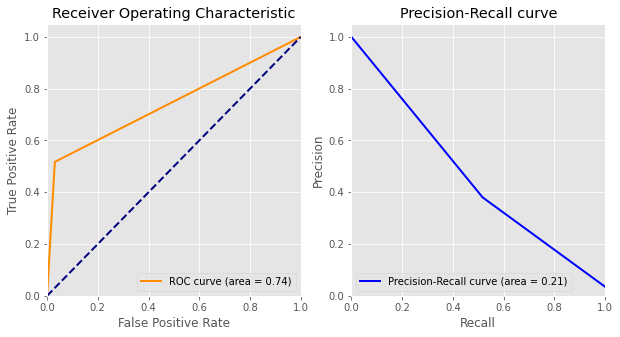

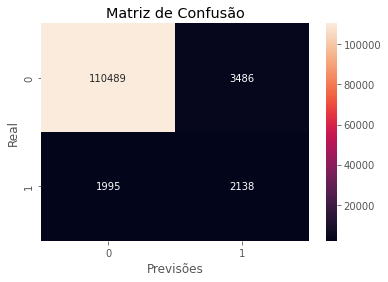

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.38      0.52      0.44      4133

    accuracy                           0.95    118108
   macro avg       0.68      0.74      0.71    118108
weighted avg       0.96      0.95      0.96    118108

CPU times: user 34.8 s, sys: 300 ms, total: 35.1 s
Wall time: 34.7 s


In [236]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [237]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1 s, sys: 0 ns, total: 1 s
Wall time: 1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.438249461924772  0.975796943376064
Threshold: 0.05  0.414360938247966  0.972906174840879
Threshold: 0.1   0.419132628310857  0.973498178470092
Threshold: 0.15   0.42439744220364  0.974116460444767
Threshold: 0.2   0.430268543476091  0.974770003404082
Threshold: 0.25  0.431781701444623  0.974965524557123
Threshold: 0.3   0.433434038267875  0.975137657654473
Threshold: 0.35   0.43490585138692  0.975337769177071
Threshold: 0.4   0.435302462255548  0.975378511754077
Threshold: 0.45  0.435743990262704  0.975423777484239
Threshold: 0.5   0.436097858085474  0.975459987188832
Threshold: 0.55  0.438474159146842   0.97581955630917
Threshold: 0.6   0.439284980480789  0.975900954601249
Threshold: 0.65  0.439465570400822  0.975919041353549
Threshold: 0.7   0.439757176664266  0.975959946489358
Threshold: 0.75  0.439847689616137  0.975968988825558

In [238]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
21            V283  0.200915798956471
9              C13  0.190230104591444
8              C11  0.117385077474816
7               C9  0.105317172877306
3               C1  0.054592925993161
0   TransactionAmt  0.050646205369947
1            card1  0.049998805417449
5               C5  0.034403604514130
4               C2  0.027785581924303
6               C6  0.022714259287382
12              D3  0.021756091549111
23            V308  0.015761072770492
2            dist1  0.013837094425576
13              D4  0.013685053505907
10              D1  0.010125707412060
11              D2  0.009147579003192
18             V96  0.009079122488126
17             D15  0.009067827949218
15             D10  0.008985041575982
14              D5  0.008372433960141
22            V307  0.008202660949855
19            V127  0.005312017401614
24            V310  0.004792166032891
16             D11  0.004314879920578
20            V130  0.003571714648846

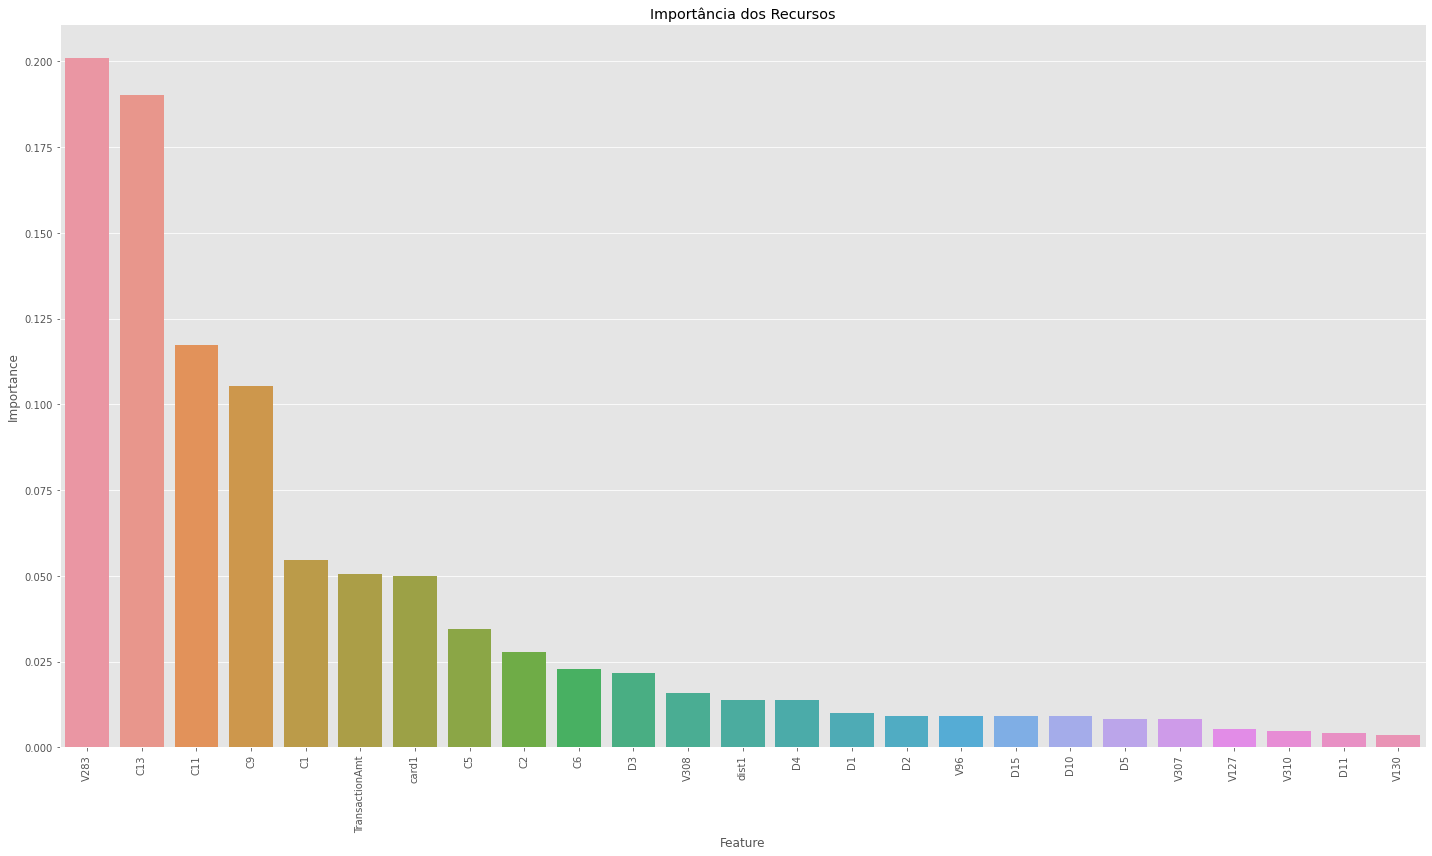

In [239]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6231130	total: 49.6ms	remaining: 198ms
1:	learn: 0.5575658	total: 98ms	remaining: 147ms
2:	learn: 0.5009682	total: 151ms	remaining: 100ms
3:	learn: 0.4714994	total: 201ms	remaining: 50.2ms
4:	learn: 0.4463710	total: 251ms	remaining: 0us
0:	learn: 0.5415766	total: 6.58ms	remaining: 26.3ms
1:	learn: 0.4379163	total: 12.3ms	remaining: 18.5ms
2:	learn: 0.3596978	total: 18.2ms	remaining: 12.2ms
3:	learn: 0.3046115	total: 24ms	remaining: 6.01ms
4:	learn: 0.2560968	total: 30.3ms	remaining: 0us
0:	learn: 0.5416318	total: 12.3ms	remaining: 49.2ms
1:	learn: 0.4377430	total: 20.3ms	remaining: 30.5ms
2:	learn: 0.3594770	total: 27.1ms	remaining: 18.1ms
3:	learn: 0.3044866	total: 33.1ms	remaining: 8.28ms
4:	learn: 0.2561173	total: 39.4ms	remaining: 0us
0:	learn: 0.5413918	total: 6.59ms	remaining: 26.4ms
1:	learn: 0.4376359	total: 12.4ms	remaining: 18.7ms
2:	learn: 0.3595318	total: 18.5ms	remaining: 12.3ms
3:	learn: 0.3046201	total: 24.3ms	remaining: 6.08ms
4:	learn: 0.2562576	total: 30.6

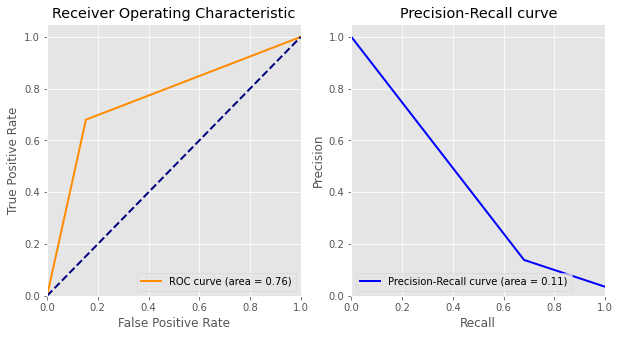

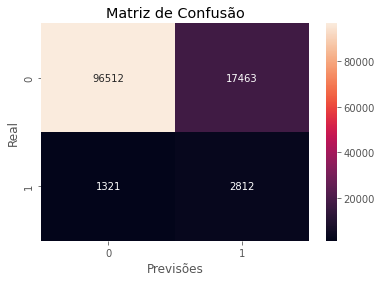

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 17.7 s, sys: 840 ms, total: 18.6 s
Wall time: 7.5 s


In [240]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [241]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1 s, sys: 3.97 ms, total: 1.01 s
Wall time: 721 ms


Metrics          F1_score Positivo  F1_score Negativo
Original          0.23041625696493  0.911315908747545
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2     0.0676553880404  0.001104894859608
Threshold: 0.25  0.074752939877436  0.211576157694177
Threshold: 0.3   0.081794759514038  0.346720379078243
Threshold: 0.35   0.12456616611113  0.713775321042165
Threshold: 0.4    0.17635848851138  0.848338713881815
Threshold: 0.45  0.197493378125202  0.878962086739616
Threshold: 0.5    0.23041625696493  0.911315908747545
Threshold: 0.55  0.289943174309502  0.951393600564496
Threshold: 0.6    0.30518697225573  0.964097769467076
Threshold: 0.65   0.36693489392831  0.981136188263195
Threshold: 0.7   0.268366958507804  0.983356569478962
Threshold: 0.75  0.163600952174854  0.983311384097239

In [242]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
8              C11  30.732447968142733
3               C1  22.843331924387670
7               C9  16.392972833311958
5               C5  15.396464693298924
9              C13   9.151104500243941
21            V283   2.910794749691646
23            V308   1.644602126693765
4               C2   0.569685601246404
0   TransactionAmt   0.358595602982948
16             D11   0.000000000000000
22            V307   0.000000000000000
20            V130   0.000000000000000
19            V127   0.000000000000000
18             V96   0.000000000000000
17             D15   0.000000000000000
12              D3   0.000000000000000
15             D10   0.000000000000000
14              D5   0.000000000000000
13              D4   0.000000000000000
1            card1   0.000000000000000
11              D2   0.000000000000000
10              D1   0.000000000000000
6               C6   0.000000000000000
2            dist1   0.000000000000000
24            V310   0.000000000000000

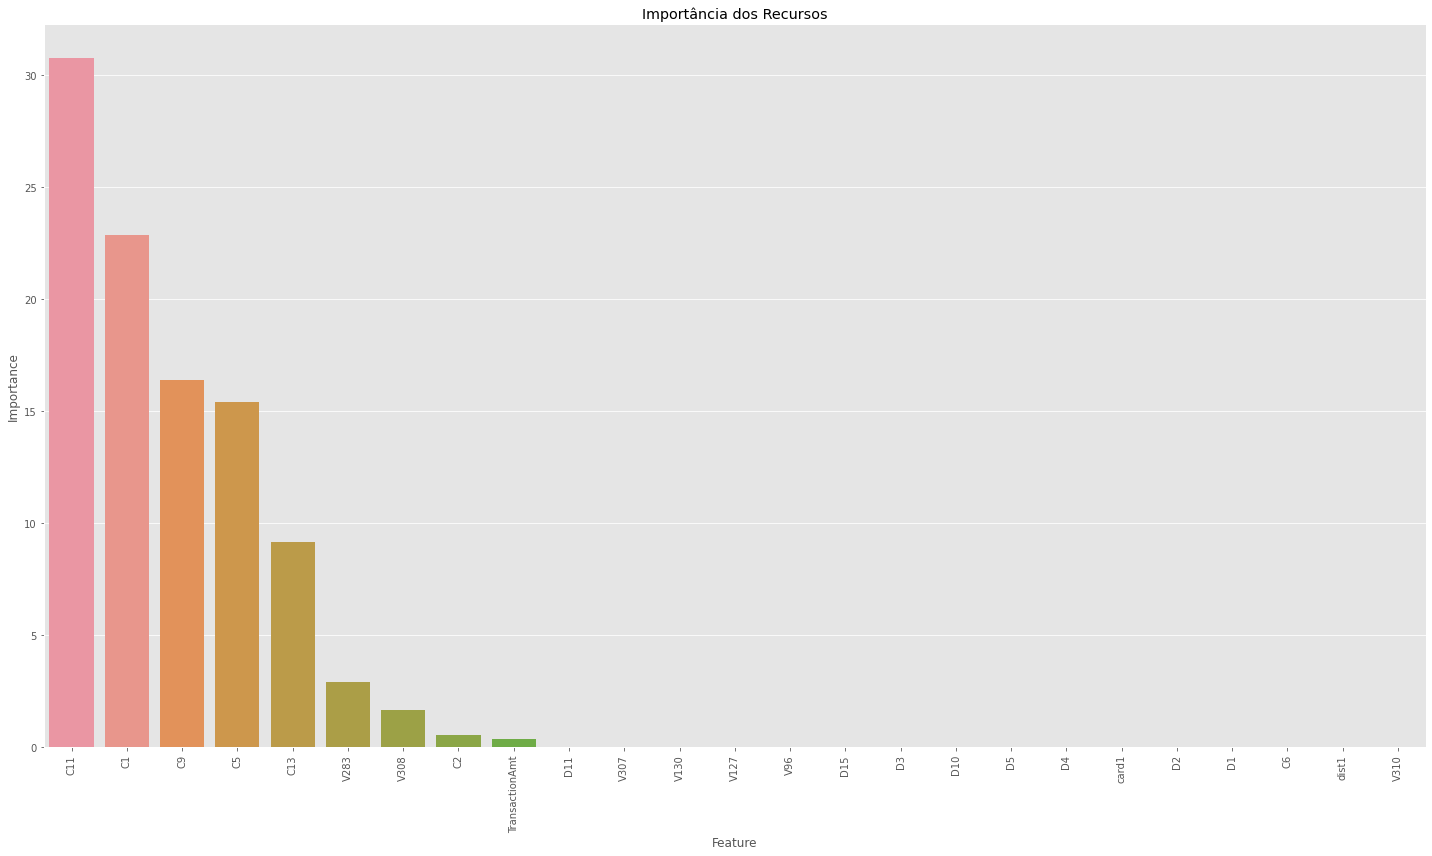

In [243]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.31027565198008766
F1-Score Negativo (Teste): 0.9583267865880758
F1-Score Positivo Médio (Validação Cruzada): 0.348234254434782
F1-Score Positivo Fold 1: 0.40590405904059046
F1-Score Positivo Fold 2: 0.35404896421845566
F1-Score Positivo Fold 3: 0.36015325670498083
F1-Score Positivo Fold 4: 0.36226415094339626
F1-Score Positivo Fold 5: 0.4037037037037037
F1-Score Positivo Fold 6: 0.3502824858757062
F1-Score Positivo Fold 7: 0.3043478260869565
F1-Score Positivo Fold 8: 0.29672447013487474
F1-Score Positivo Fold 9: 0.3109404990403071
F1-Score Positivo Fold 10: 0.3339731285988484
F1-Score Negativo Médio (Validação Cruzada): 0.9851616670374124
F1-Score Negativo Fold 1: 0.986048526863085
F1-Score Negativo Fold 2: 0.9851457277727254
F1-Score Negativo Fold 3: 0.9855411255411255
F1-Score Negativo Fold 4: 0.9853628962411225
F1-Score Negativo Fold 5: 0.9860497357248073
F1-Score Negativo Fold 6: 0.9850591139404962
F1-Score Negativo Fold 7: 0.9847724519813116
F1-Score N

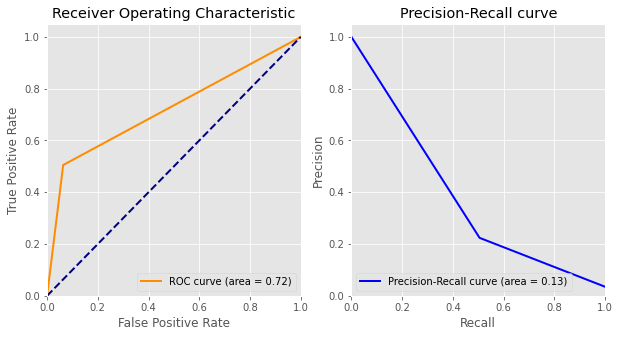

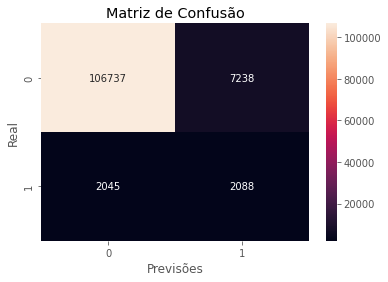

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.22      0.51      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.72      0.63    118108
weighted avg       0.95      0.92      0.94    118108

CPU times: user 3min 37s, sys: 312 ms, total: 3min 38s
Wall time: 3min 37s


In [244]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [245]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.310275651980088  0.958326786588076
Threshold: 0.05  0.080663863597407  0.334663854815053
Threshold: 0.1   0.096635269228832  0.542498915843984
Threshold: 0.15  0.130372859073148  0.737525489115459
Threshold: 0.2   0.163145774929916   0.82964782130192
Threshold: 0.25  0.185473968565815  0.869701433902966
Threshold: 0.3   0.211876094978939  0.899025259206549
Threshold: 0.35  0.238123009286259  0.920612364146313
Threshold: 0.4   0.264884439237405  0.936515236527194
Threshold: 0.45   0.28776254559175  0.948591555688699
Threshold: 0.5   0.310275651980088  0.958326786588076
Threshold: 0.55  0.326747323526852  0.965580459846836
Threshold: 0.6   0.340247266782467  0.971483334731859
Threshold: 0.65  0.356430944470812  0.976188385691959
Threshold: 0.7   0.356957531066503  0.979427068542944
Threshold: 0.75   0.35330836454432  0.981967555524612

In [246]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
9              C13  0.265882580898307
5               C5  0.179777662460113
8              C11  0.147210623765301
21            V283  0.110676622345796
3               C1  0.053555436152977
18             V96  0.051967204026947
6               C6  0.041545425835616
4               C2  0.021264407608448
2            dist1  0.021065339287610
7               C9  0.018351518192278
0   TransactionAmt  0.016566697071183
12              D3  0.015928157267229
16             D11  0.013179006717042
13              D4  0.013027314237790
15             D10  0.012682948085059
23            V308  0.009324592254926
14              D5  0.003284211531385
11              D2  0.002463921956866
20            V130  0.002246330305127
1            card1  0.000000000000000
17             D15  0.000000000000000
19            V127  0.000000000000000
10              D1  0.000000000000000
22            V307  0.000000000000000
24            V310  0.000000000000000

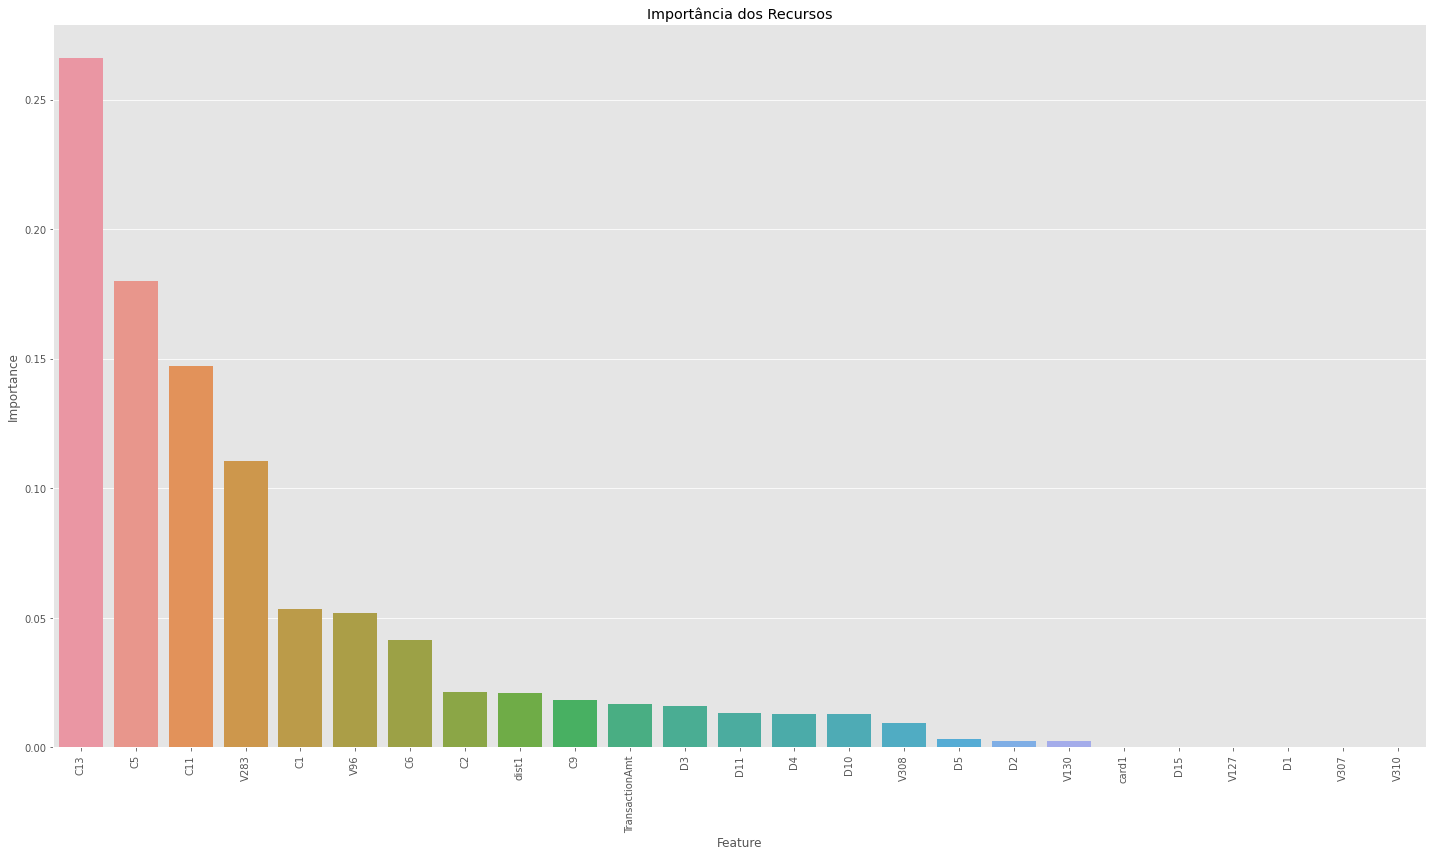

In [247]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


F1-Score Positivo (Teste): 0.2940336077284169
F1-Score Negativo (Teste): 0.9531548368748224
F1-Score Positivo Médio (Validação Cruzada): 0.28649705209021414
F1-Score Positivo Fold 1: 0.3229571984435798
F1-Score Positivo Fold 2: 0.29469548133595286
F1-Score Positivo Fold 3: 0.3021868787276342
F1-Score Positivo Fold 4: 0.2729044834307992
F1-Score Positivo Fold 5: 0.32495164410058025
F1-Score Positivo Fold 6: 0.29862475442043224
F1-Score Positivo Fold 7: 0.26122448979591834
F1-Score Positivo Fold 8: 0.22845691382765532
F1-Score Positivo Fold 9: 0.27944111776447106
F1-Score Positivo Fold 10: 0.2795275590551181
F1-Score Negativo Médio (Validação Cruzada): 0.9843783675127652
F1-Score Negativo Fold 1: 0.9849402804223646
F1-Score Negativo Fold 2: 0.9844676156275688
F1-Score Negativo Fold 3: 0.9848176824257105
F1-Score Negativo Fold 4: 0.9838591025141719
F1-Score Negativo Fold 5: 0.984895044362692
F1-Score Negativo Fold 6: 0.9845541470168304
F1-Score Negativo Fold 7: 0.9843506830364862
F1-Score

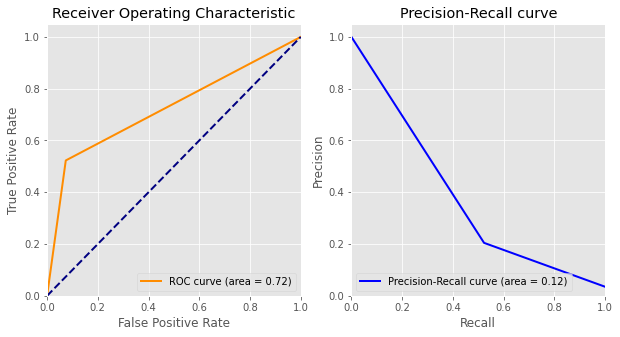

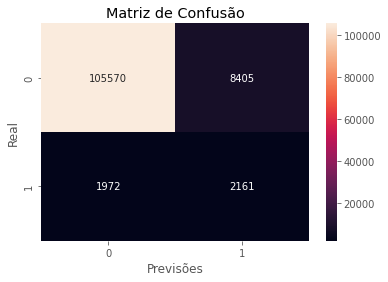

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.20      0.52      0.29      4133

    accuracy                           0.91    118108
   macro avg       0.59      0.72      0.62    118108
weighted avg       0.95      0.91      0.93    118108

CPU times: user 4min 17s, sys: 288 ms, total: 4min 18s
Wall time: 4min 17s


In [248]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [249]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 13.1 s, sys: 4 ms, total: 13.1 s
Wall time: 13.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.294033607728417  0.953154836874822
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.294033607728417  0.953154836874822
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [250]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
9              C13        0.13
18             V96        0.11
3               C1        0.10
6               C6        0.10
4               C2        0.09
12              D3        0.08
2            dist1        0.07
21            V283        0.07
8              C11        0.04
14              D5        0.02
23            V308        0.02
16             D11        0.02
15             D10        0.02
0   TransactionAmt        0.02
13              D4        0.02
7               C9        0.02
5               C5        0.02
1            card1        0.01
11              D2        0.01
17             D15        0.01
19            V127        0.01
20            V130        0.01
10              D1        0.00
22            V307        0.00
24            V310        0.00

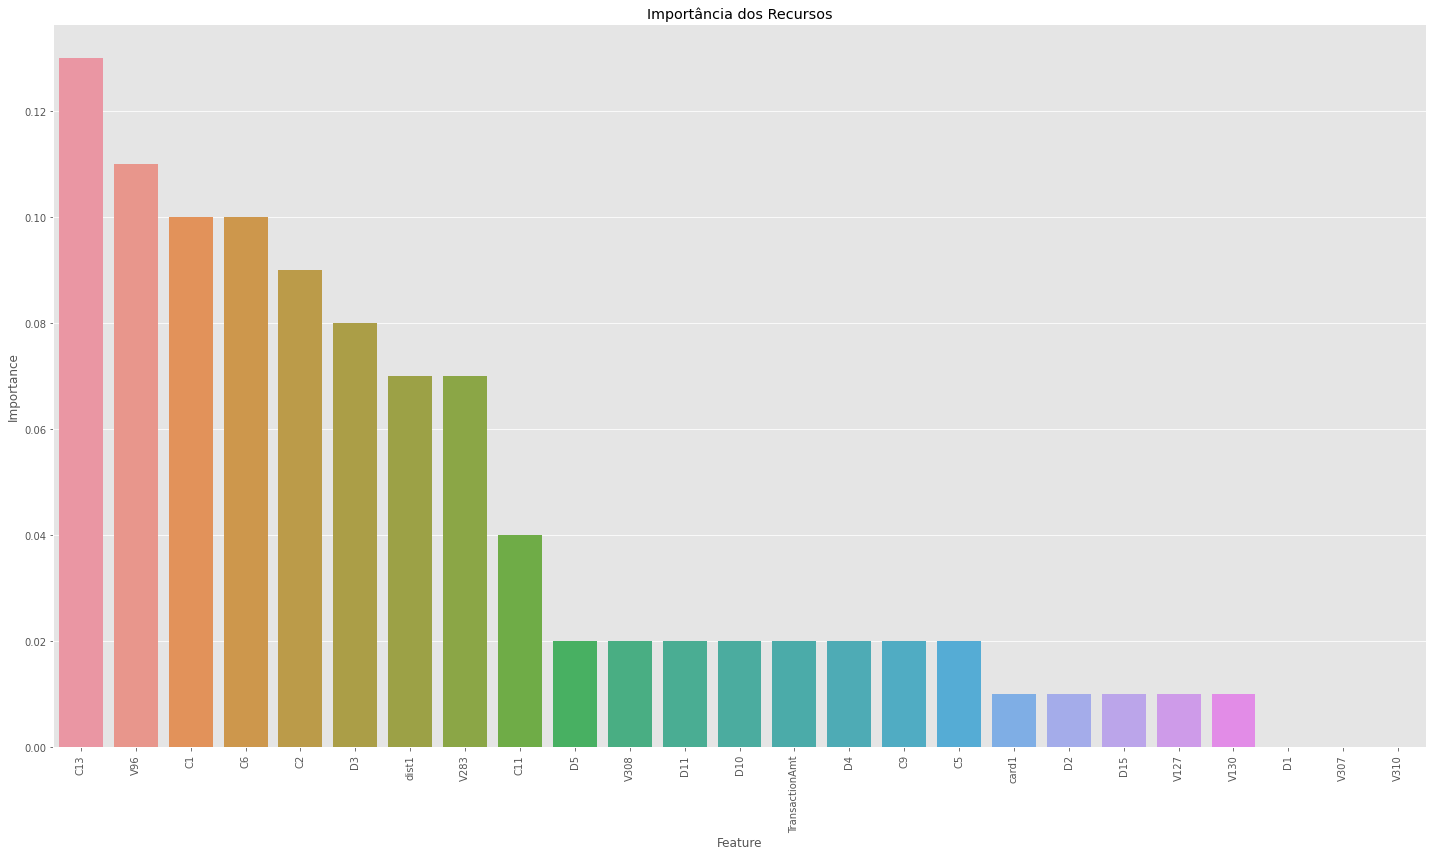

In [251]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.2989779583795099
F1-Score Negativo (Teste): 0.9482393373762354
F1-Score Positivo Médio (Validação Cruzada): 0.2541988436306501
F1-Score Positivo Fold 1: 0.2540834845735027
F1-Score Positivo Fold 2: 0.22614840989399296
F1-Score Positivo Fold 3: 0.2542372881355932
F1-Score Positivo Fold 4: 0.24956063268892795
F1-Score Positivo Fold 5: 0.2817391304347826
F1-Score Positivo Fold 6: 0.24432809773123912
F1-Score Positivo Fold 7: 0.2613240418118467
F1-Score Positivo Fold 8: 0.23529411764705882
F1-Score Positivo Fold 9: 0.2601054481546573
F1-Score Positivo Fold 10: 0.2751677852348993
F1-Score Negativo Médio (Validação Cruzada): 0.9814829739925666
F1-Score Negativo Fold 1: 0.9821854275930822
F1-Score Negativo Fold 2: 0.981002775850104
F1-Score Negativo Fold 3: 0.9808961444946162
F1-Score Negativo Fold 4: 0.981477464972021
F1-Score Negativo Fold 5: 0.9820800971926932
F1-Score Negativo Fold 6: 0.9812139355286562
F1-Score Negativo Fold 7: 0.9816036098576882
F1-Score Neg

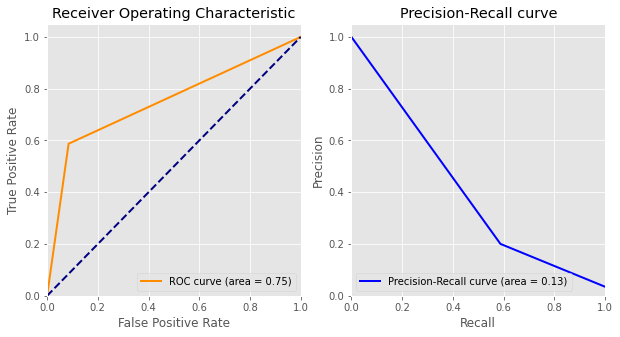

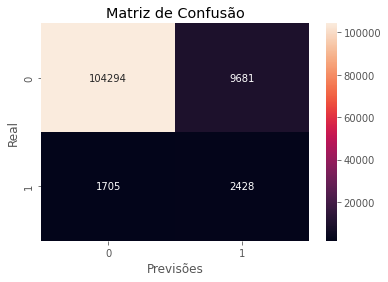

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.20      0.59      0.30      4133

    accuracy                           0.90    118108
   macro avg       0.59      0.75      0.62    118108
weighted avg       0.96      0.90      0.93    118108

CPU times: user 13min 17s, sys: 456 ms, total: 13min 18s
Wall time: 1min 13s


In [252]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [253]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2h 51min 25s, sys: 1.1 s, total: 2h 51min 26s
Wall time: 14min 26s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.29897795837951  0.948239337376235
Threshold: 0.05  0.244930701011632  0.920744514143243
Threshold: 0.1   0.244930701011632  0.920744514143243
Threshold: 0.15  0.244930701011632  0.920744514143243
Threshold: 0.2   0.244930701011632  0.920744514143243
Threshold: 0.25  0.244930701011632  0.920744514143243
Threshold: 0.3   0.244930701011632  0.920744514143243
Threshold: 0.35   0.29897795837951  0.948239337376235
Threshold: 0.4    0.29897795837951  0.948239337376235
Threshold: 0.45   0.29897795837951  0.948239337376235
Threshold: 0.5    0.29897795837951  0.948239337376235
Threshold: 0.55   0.29897795837951  0.948239337376235
Threshold: 0.6    0.29897795837951  0.948239337376235
Threshold: 0.65   0.29897795837951  0.948239337376235
Threshold: 0.7   0.369848868863231   0.97023891329695
Threshold: 0.75  0.369848868863231   0.97023891329695

### 100 Chi-Square

In [254]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6708038678019916
F1-Score Negativo (Teste): 0.9900517691801105
F1-Score Positivo Médio (Validação Cruzada): 0.5042339395377303
F1-Score Positivo Fold 1: 0.5476190476190477
F1-Score Positivo Fold 2: 0.4626334519572954
F1-Score Positivo Fold 3: 0.5180102915951972
F1-Score Positivo Fold 4: 0.5232358003442341
F1-Score Positivo Fold 5: 0.5380710659898478
F1-Score Positivo Fold 6: 0.5119453924914675
F1-Score Positivo Fold 7: 0.4844290657439446
F1-Score Positivo Fold 8: 0.4767025089605734
F1-Score Positivo Fold 9: 0.48056537102473507
F1-Score Positivo Fold 10: 0.49912739965095987
F1-Score Negativo Médio (Validação Cruzada): 0.9876070199761531
F1-Score Negativo Fold 1: 0.9884518537813667
F1-Score Negativo Fold 2: 0.9869037294015611
F1-Score Negativo Fold 3: 0.9878032900733539
F1-Score Negativo Fold 4: 0.9879779523458183
F1-Score Negativo Fold 5: 0.9881464113586036
F1-Score Negativo Fold 6: 0.9875846501128668
F1-Score Negativo Fold 7: 0.9870682173233815
F1-Score Neg

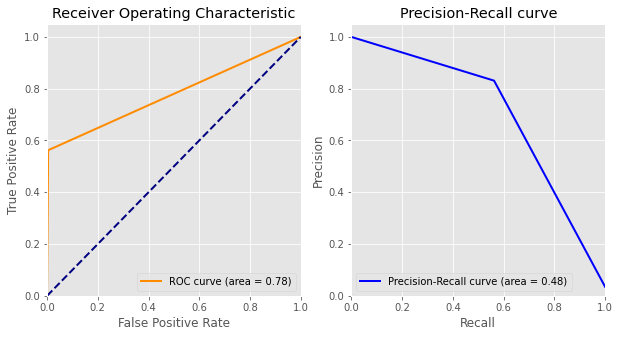

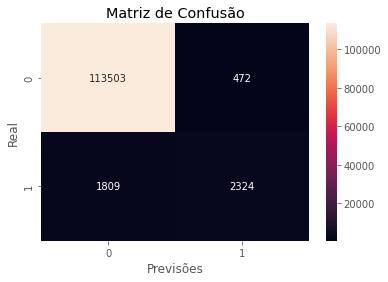

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.83      0.56      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.91      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 5min 43s, sys: 332 ms, total: 5min 44s
Wall time: 5min 43s


In [255]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [256]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 49.6 s, sys: 32 ms, total: 49.6 s
Wall time: 49.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.670803867801992  0.990051769180111
Threshold: 0.05  0.236406164888333   0.88375518884721
Threshold: 0.1   0.376504885817632  0.946948225252994
Threshold: 0.15  0.494238346591332  0.969461091284538
Threshold: 0.2   0.571998911169585  0.979053709007749
Threshold: 0.25  0.628601252609603  0.984300817169382
Threshold: 0.3   0.657943067033976  0.986901329207398
Threshold: 0.35  0.677730988357691  0.988594822522815
Threshold: 0.4   0.685003274394237  0.989478565585066
Threshold: 0.45  0.682792743265531   0.98991875600594
Threshold: 0.5   0.672576494137832  0.990009684934256
Threshold: 0.55  0.658641700104027  0.989990718428495
Threshold: 0.6    0.63313792039494  0.989648898291067
Threshold: 0.65            0.60768   0.98933755424715
Threshold: 0.7   0.574850299401198  0.988896804573335
Threshold: 0.75  0.541831300463838  0.988424227956336

In [257]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
68    P_emaildomain_gmail.com  0.059028737630695
74                       M6_T  0.043319300733396
73                       M6_F  0.040288293534666
61                ProductCD_C  0.035565245785141
71                      M4_M2  0.033234519265861
72                       M5_T  0.025849542099450
0              TransactionAmt  0.024506431500525
62                ProductCD_H  0.023399282256717
12                        C14  0.021190227455656
2                       card2  0.020316516275988
60                     _Hours  0.020028022196002
1                       card1  0.019877969345191
63                ProductCD_R  0.019793086836538
59                  _Weekdays  0.019588280597339
65                ProductCD_W  0.017695240870206
5                          C1  0.017358015845020
11                        C13  0.016877929204464
14                         D2  0.016036786692497
6                          C2  0.015161007613325
13                         D1  0.015089707322209
37                        V69  0.015062222412526
3                       card5  0.014776371462500
53                       V282  0.014538327341562
36                        V53  0.014375631886855
34                        V51  0.013761858929855
21                        V12  0.013621942347808
69  P_emaildomain_hotmail.com  0.013400753050360
54                       V283  0.013220288357128
10                        C11  0.013178004749112
23                        V29  0.012978525330404
38                        V70  0.012677088091385
44                        V90  0.012618772800845
8                          C6  0.011539447648666
39                        V75  0.011070187723572
31                        V48  0.011049103521586
22                        V13  0.010957040981118
52                       V280  0.010749008012766
25                        V35  0.010742756595018
30                        V43  0.010621261969526
29                        V42  0.010215579030872
18                        D10  0.009983728701722
32                        V49  0.009976517562062
33                        V50  0.009696161235133
20                        D15  0.009620089353400
67           card4_mastercard  0.009161877990435
35                        V52  0.008859510460685
45                        V91  0.008827393803388
28                        V40  0.008754372905365
26                        V36  0.008408573480532
57                       V308  0.008399474655912
27                        V39  0.008138448768382
16                         D4  0.007736235918448
48                        V96  0.007678308371093
55                       V285  0.007503000058788
56                       V307  0.007436119739247
24                        V30  0.007375599164877
17                         D5  0.007315677669436
50                       V127  0.007106022571175
66             card4_discover  0.006933710721034
42                        V84  0.006788106891218
58                       V310  0.006574975142661
43                        V85  0.006358455582553
4                       dist1  0.006179318162927
64                ProductCD_S  0.006171038289219
15                         D3  0.006167314616811
46                        V92  0.006135359838297
19                        D11  0.006115802497559
70  P_emaildomain_outlook.com  0.006050310524237
47                        V93  0.005462255536409
49                        V99  0.005183579783489
51                       V130  0.004365262087464
9                          C9  0.004250824552539
41                        V81  0.004158812575778
40                        V80  0.003889766225690
7                          C5  0.001879679257684

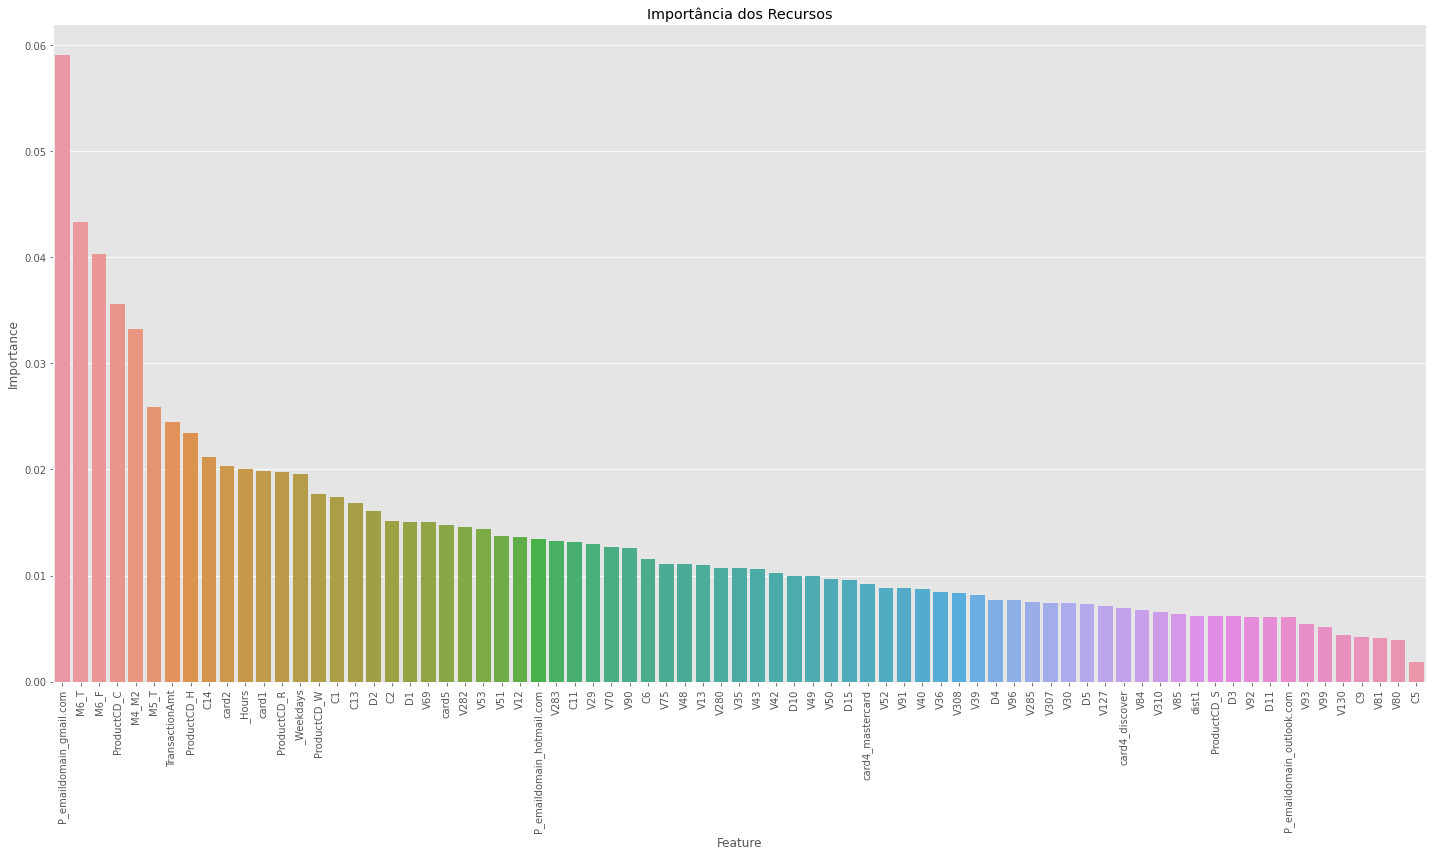

In [258]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.48311464831146483
F1-Score Negativo (Teste): 0.9788205431036762
F1-Score Positivo Médio (Validação Cruzada): 0.4197646618531989
F1-Score Positivo Fold 1: 0.4399092970521542
F1-Score Positivo Fold 2: 0.4459613196814562
F1-Score Positivo Fold 3: 0.419672131147541
F1-Score Positivo Fold 4: 0.42519685039370075
F1-Score Positivo Fold 5: 0.42227378190255216
F1-Score Positivo Fold 6: 0.4098544232922733
F1-Score Positivo Fold 7: 0.4282511210762332
F1-Score Positivo Fold 8: 0.3757159221076747
F1-Score Positivo Fold 9: 0.43400447427293065
F1-Score Positivo Fold 10: 0.39680729760547323
F1-Score Negativo Médio (Validação Cruzada): 0.9774013503039631
F1-Score Negativo Fold 1: 0.9782761653474055
F1-Score Negativo Fold 2: 0.978586817921998
F1-Score Negativo Fold 3: 0.9766151407055094
F1-Score Negativo Fold 4: 0.9775216645405358
F1-Score Negativo Fold 5: 0.9781195079086116
F1-Score Negativo Fold 6: 0.9768137621540762
F1-Score Negativo Fold 7: 0.9775626924769029
F1-Score Ne

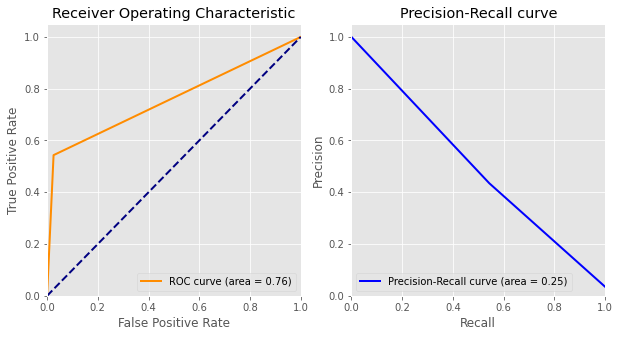

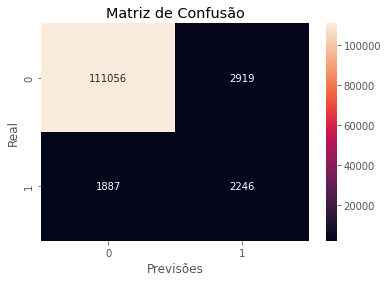

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.43      0.54      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 11s, sys: 320 ms, total: 1min 11s
Wall time: 1min 11s


In [259]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [260]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.14 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.483114648311465  0.978820543103676
Threshold: 0.05   0.48280309544282  0.978793541108447
Threshold: 0.1    0.48280309544282  0.978793541108447
Threshold: 0.15   0.48280309544282  0.978793541108447
Threshold: 0.2    0.48280309544282  0.978793541108447
Threshold: 0.25   0.48280309544282  0.978793541108447
Threshold: 0.3    0.48280309544282  0.978793541108447
Threshold: 0.35  0.482906901741561  0.978802541932186
Threshold: 0.4   0.482906901741561  0.978802541932186
Threshold: 0.45  0.482906901741561  0.978802541932186
Threshold: 0.5   0.482906901741561  0.978802541932186
Threshold: 0.55  0.483114648311465  0.978820543103676
Threshold: 0.6   0.483114648311465  0.978820543103676
Threshold: 0.65  0.483114648311465  0.978820543103676
Threshold: 0.7   0.483166612885877  0.978825043297388
Threshold: 0.75  0.483166612885877  0.978825043297388

In [261]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
41                        V81  0.195637673823100
5                          C1  0.133485083651132
54                       V283  0.112244958708812
12                        C14  0.086968904107977
37                        V69  0.043431335903076
52                       V280  0.040124620015938
0              TransactionAmt  0.025886481529194
44                        V90  0.023497077214889
72                       M5_T  0.022424549330528
1                       card1  0.020929504339488
11                        C13  0.019673554196440
9                          C9  0.018925581101961
68    P_emaildomain_gmail.com  0.016299933779452
2                       card2  0.016077988271178
74                       M6_T  0.013116052414788
40                        V80  0.009834984614427
3                       card5  0.008855063859921
60                     _Hours  0.008116675529433
4                       dist1  0.007713752371298
71                      M4_M2  0.007668448347657
8                          C6  0.007292197918470
69  P_emaildomain_hotmail.com  0.006523168197452
59                  _Weekdays  0.006272825592421
57                       V308  0.006210264676191
55                       V285  0.006105922199025
14                         D2  0.005990659994713
6                          C2  0.005814266607371
36                        V53  0.005748199347088
27                        V39  0.005729622302924
10                        C11  0.005716319692648
20                        D15  0.005100197011905
15                         D3  0.004885552115087
53                       V282  0.004623950886053
49                        V99  0.004610911444753
16                         D4  0.004393882268627
18                        D10  0.004337077984771
39                        V75  0.004288612583637
19                        D11  0.004280989256629
56                       V307  0.004109883795057
13                         D1  0.004001778366879
73                       M6_F  0.003937982867489
45                        V91  0.003646909187938
65                ProductCD_W  0.003616214697445
58                       V310  0.003534902140362
17                         D5  0.003339957686474
63                ProductCD_R  0.003285664779273
48                        V96  0.003127064985495
66             card4_discover  0.002936109916330
62                ProductCD_H  0.002848239824968
34                        V51  0.002759639129018
22                        V13  0.002737981679523
35                        V52  0.002456128289571
51                       V130  0.002389819081217
70  P_emaildomain_outlook.com  0.001871497953840
21                        V12  0.001695845654778
7                          C5  0.001677533325744
50                       V127  0.001640993023618
25                        V35  0.001599945705021
23                        V29  0.001592107578820
29                        V42  0.001428698924184
33                        V50  0.001373652603920
67           card4_mastercard  0.001235712051492
26                        V36  0.001126057322693
32                        V49  0.001024796309767
30                        V43  0.000940197166933
43                        V85  0.000891799076019
46                        V92  0.000771820155097
24                        V30  0.000746939278024
42                        V84  0.000564230442891
61                ProductCD_C  0.000502701278643
28                        V40  0.000492964876385
47                        V93  0.000466629476626
64                ProductCD_S  0.000348168602402
31                        V48  0.000232910660841
38                        V70  0.000209678914769

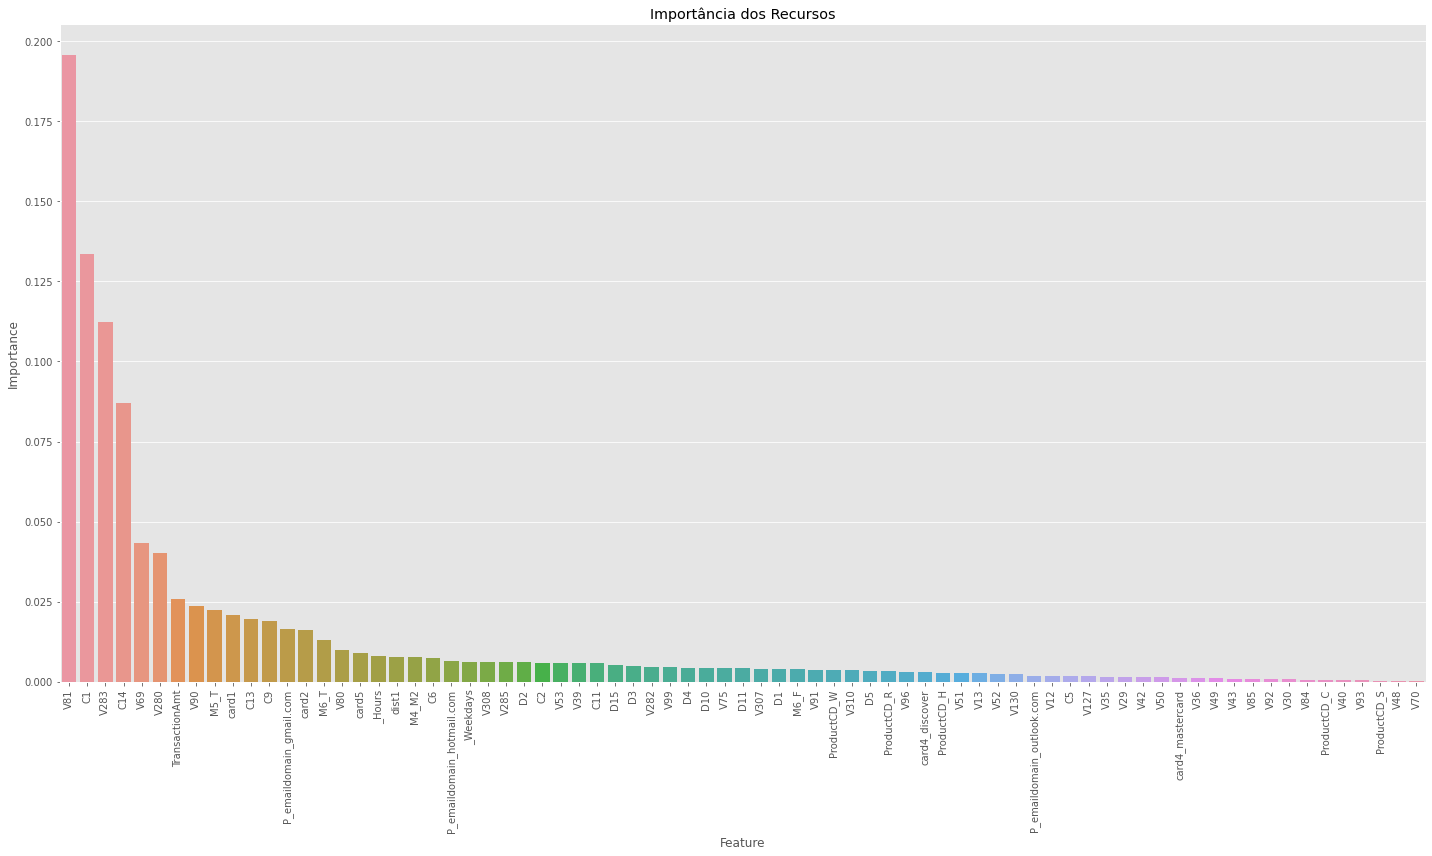

In [262]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6205931	total: 68.6ms	remaining: 274ms
1:	learn: 0.5571825	total: 135ms	remaining: 202ms
2:	learn: 0.5056703	total: 203ms	remaining: 136ms
3:	learn: 0.4683129	total: 271ms	remaining: 67.8ms
4:	learn: 0.4402896	total: 337ms	remaining: 0us
0:	learn: 0.5357342	total: 14ms	remaining: 56.1ms
1:	learn: 0.4277430	total: 23.9ms	remaining: 35.8ms
2:	learn: 0.3475287	total: 32.1ms	remaining: 21.4ms
3:	learn: 0.2886913	total: 39.4ms	remaining: 9.85ms
4:	learn: 0.2453530	total: 46.7ms	remaining: 0us
0:	learn: 0.5361293	total: 7.68ms	remaining: 30.7ms
1:	learn: 0.4282710	total: 15.4ms	remaining: 23ms
2:	learn: 0.3479982	total: 22.8ms	remaining: 15.2ms
3:	learn: 0.2929269	total: 30.3ms	remaining: 7.58ms
4:	learn: 0.2476118	total: 37.9ms	remaining: 0us
0:	learn: 0.5358835	total: 7.69ms	remaining: 30.7ms
1:	learn: 0.4277835	total: 15.4ms	remaining: 23.1ms
2:	learn: 0.3474310	total: 23ms	remaining: 15.3ms
3:	learn: 0.2885865	total: 30.2ms	remaining: 7.55ms
4:	learn: 0.2450182	total: 37.7ms	

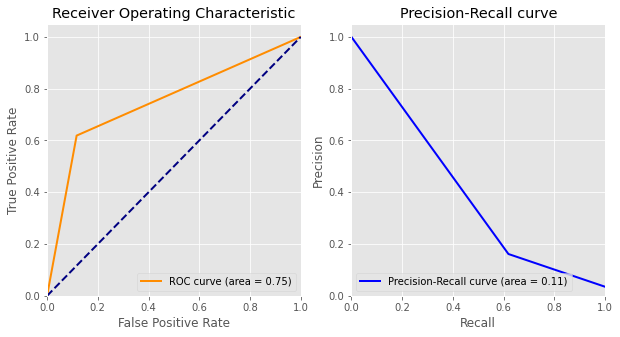

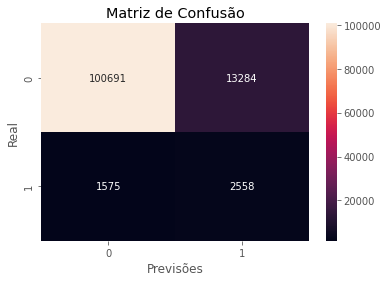

              precision    recall  f1-score   support

           0       0.98      0.88      0.93    113975
           1       0.16      0.62      0.26      4133

    accuracy                           0.87    118108
   macro avg       0.57      0.75      0.59    118108
weighted avg       0.96      0.87      0.91    118108

CPU times: user 38.3 s, sys: 704 ms, total: 39 s
Wall time: 22.1 s


In [263]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [264]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8.17 s, sys: 40 ms, total: 8.21 s
Wall time: 7.73 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.256120150187735  0.931285001456708
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.073825685336997  0.183998662175398
Threshold: 0.3   0.091484918793503  0.477962350682594
Threshold: 0.35  0.128358102314947  0.729248967996804
Threshold: 0.4    0.16697681436403  0.831376940697378
Threshold: 0.45  0.214094880496787  0.895606134722182
Threshold: 0.5   0.256120150187735  0.931285001456708
Threshold: 0.55  0.299577464788732  0.955201426924186
Threshold: 0.6   0.351630038537652  0.972530503276482
Threshold: 0.65  0.344956772334294  0.980172368673564
Threshold: 0.7   0.273928571428571  0.982368959655878
Threshold: 0.75  0.196830692243536  0.983354939071817

In [265]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
5                          C1  35.970358094879053
12                        C14  13.460490621627756
39                        V75  10.355185079594715
32                        V49   9.826089220921425
23                        V29   5.625914688089463
35                        V52   3.843133541698742
41                        V81   2.927086439200163
43                        V85   2.624773166227229
10                        C11   2.601520466088757
8                          C6   2.560031477452315
68    P_emaildomain_gmail.com   2.090013937110807
57                       V308   1.897121017788543
53                       V282   1.771967212234252
37                        V69   1.481956743797006
72                       M5_T   1.364681739955940
54                       V283   0.935511377485815
52                       V280   0.664165175848016
51                       V130   0.000000000000000
73                       M6_F   0.000000000000000
44                        V90   0.000000000000000
45                        V91   0.000000000000000
46                        V92   0.000000000000000
71                      M4_M2   0.000000000000000
47                        V93   0.000000000000000
48                        V96   0.000000000000000
70  P_emaildomain_outlook.com   0.000000000000000
49                        V99   0.000000000000000
50                       V127   0.000000000000000
65                ProductCD_W   0.000000000000000
64                ProductCD_S   0.000000000000000
69  P_emaildomain_hotmail.com   0.000000000000000
55                       V285   0.000000000000000
56                       V307   0.000000000000000
67           card4_mastercard   0.000000000000000
66             card4_discover   0.000000000000000
42                        V84   0.000000000000000
59                  _Weekdays   0.000000000000000
60                     _Hours   0.000000000000000
61                ProductCD_C   0.000000000000000
62                ProductCD_H   0.000000000000000
63                ProductCD_R   0.000000000000000
58                       V310   0.000000000000000
0              TransactionAmt   0.000000000000000
40                        V80   0.000000000000000
38                        V70   0.000000000000000
2                       card2   0.000000000000000
3                       card5   0.000000000000000
4                       dist1   0.000000000000000
6                          C2   0.000000000000000
7                          C5   0.000000000000000
9                          C9   0.000000000000000
11                        C13   0.000000000000000
13                         D1   0.000000000000000
14                         D2   0.000000000000000
15                         D3   0.000000000000000
16                         D4   0.000000000000000
17                         D5   0.000000000000000
18                        D10   0.000000000000000
19                        D11   0.000000000000000
20                        D15   0.000000000000000
21                        V12   0.000000000000000
22                        V13   0.000000000000000
24                        V30   0.000000000000000
25                        V35   0.000000000000000
26                        V36   0.000000000000000
27                        V39   0.000000000000000
28                        V40   0.000000000000000
29                        V42   0.000000000000000
30                        V43   0.000000000000000
31                        V48   0.000000000000000
33                        V50   0.000000000000000
34                        V51   0.000000000000000
36                        V53   0.000000000000000
1                       card1   0.000000000000000
74                       M6_T   0.000000000000000

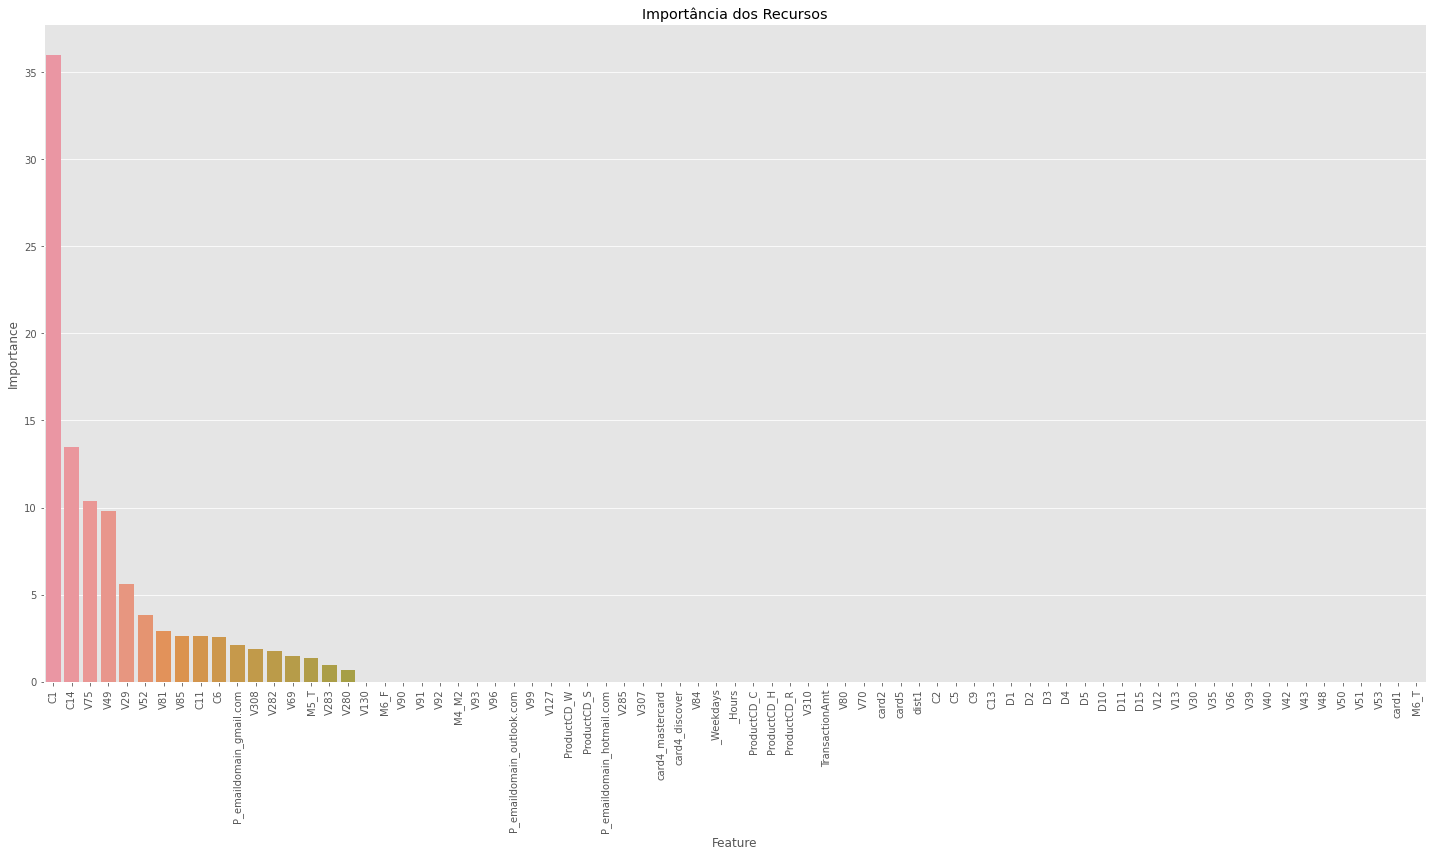

In [266]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.33882312575055756
F1-Score Negativo (Teste): 0.9656747922585702
F1-Score Positivo Médio (Validação Cruzada): 0.32606446840252584
F1-Score Positivo Fold 1: 0.45884413309982486
F1-Score Positivo Fold 2: 0.3800738007380074
F1-Score Positivo Fold 3: 0.3880597014925373
F1-Score Positivo Fold 4: 0.3761638733705773
F1-Score Positivo Fold 5: 0.3818525519848771
F1-Score Positivo Fold 6: 0.39344262295081966
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.3289719626168224
F1-Score Positivo Fold 9: 0.34980988593155893
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9846848796811789
F1-Score Negativo Fold 1: 0.9865949416511214
F1-Score Negativo Fold 2: 0.9854419410745233
F1-Score Negativo Fold 3: 0.9857922550463485
F1-Score Negativo Fold 4: 0.9854884123889972
F1-Score Negativo Fold 5: 0.9858398648941237
F1-Score Negativo Fold 6: 0.9855675464829021
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Scor

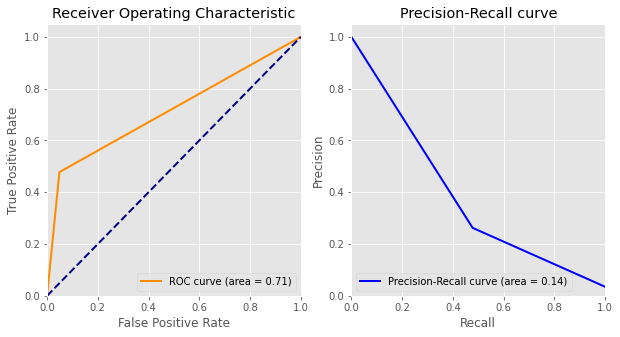

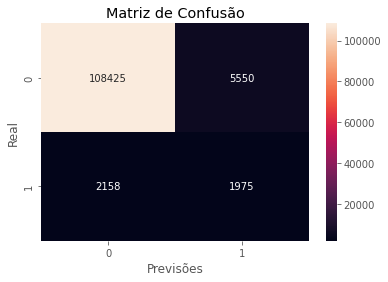

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.26      0.48      0.34      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.71      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 6min 33s, sys: 324 ms, total: 6min 33s
Wall time: 6min 33s


In [267]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [268]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.338823125750558   0.96567479225857
Threshold: 0.05   0.09896579571209  0.566136902447285
Threshold: 0.1   0.129780225915105  0.743734895522224
Threshold: 0.15    0.1570724085738  0.823163673983632
Threshold: 0.2   0.185990635781173  0.870303113589069
Threshold: 0.25  0.221959765363568   0.90625429879278
Threshold: 0.3   0.248966165413534  0.925642982096996
Threshold: 0.35  0.276706940151728  0.941072515921088
Threshold: 0.4   0.297121514585614  0.950540811194135
Threshold: 0.45  0.320071524362986  0.959038394211693
Threshold: 0.5   0.338823125750558   0.96567479225857
Threshold: 0.55    0.3549614596546   0.97074351564609
Threshold: 0.6    0.36401766004415  0.974634172110796
Threshold: 0.65  0.374750996015936  0.977991445500123
Threshold: 0.7   0.372791765196828  0.980312364917673
Threshold: 0.75  0.359950479727638  0.981998137137982

In [269]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
41                        V81  0.271832586305682
12                        C14  0.116951936347651
57                       V308  0.104354018373923
31                        V48  0.067051653148615
68    P_emaildomain_gmail.com  0.064492832646401
10                        C11  0.053329735074380
53                       V282  0.037403211728806
0              TransactionAmt  0.026682639541615
52                       V280  0.026262503352290
5                          C1  0.022018338340423
15                         D3  0.021962787888437
72                       M5_T  0.021265503501704
8                          C6  0.019586543173571
48                        V96  0.017684303535083
73                       M6_F  0.017665505025839
19                        D11  0.014888832199874
60                     _Hours  0.014710623787276
74                       M6_T  0.013848626508310
59                  _Weekdays  0.012371783371510
35                        V52  0.008237902697765
36                        V53  0.007249081400229
4                       dist1  0.005797867605858
11                        C13  0.005287807273905
69  P_emaildomain_hotmail.com  0.003852705555119
71                      M4_M2  0.003181339733472
51                       V130  0.002833248614192
70  P_emaildomain_outlook.com  0.002768486737962
18                        D10  0.002463908046002
25                        V35  0.002366147363937
42                        V84  0.002048892551158
33                        V50  0.001834248479180
6                          C2  0.001535598410951
66             card4_discover  0.001430956965686
9                          C9  0.001205907845073
17                         D5  0.001150430043719
21                        V12  0.000931800945416
16                         D4  0.000747859040251
58                       V310  0.000711846838737
54                       V283  0.000000000000000
55                       V285  0.000000000000000
56                       V307  0.000000000000000
7                          C5  0.000000000000000
67           card4_mastercard  0.000000000000000
2                       card2  0.000000000000000
61                ProductCD_C  0.000000000000000
62                ProductCD_H  0.000000000000000
3                       card5  0.000000000000000
64                ProductCD_S  0.000000000000000
65                ProductCD_W  0.000000000000000
63                ProductCD_R  0.000000000000000
46                        V92  0.000000000000000
50                       V127  0.000000000000000
49                        V99  0.000000000000000
20                        D15  0.000000000000000
22                        V13  0.000000000000000
23                        V29  0.000000000000000
24                        V30  0.000000000000000
26                        V36  0.000000000000000
27                        V39  0.000000000000000
28                        V40  0.000000000000000
29                        V42  0.000000000000000
30                        V43  0.000000000000000
32                        V49  0.000000000000000
34                        V51  0.000000000000000
1                       card1  0.000000000000000
38                        V70  0.000000000000000
39                        V75  0.000000000000000
40                        V80  0.000000000000000
14                         D2  0.000000000000000
43                        V85  0.000000000000000
44                        V90  0.000000000000000
45                        V91  0.000000000000000
47                        V93  0.000000000000000
13                         D1  0.000000000000000
37                        V69  0.000000000000000

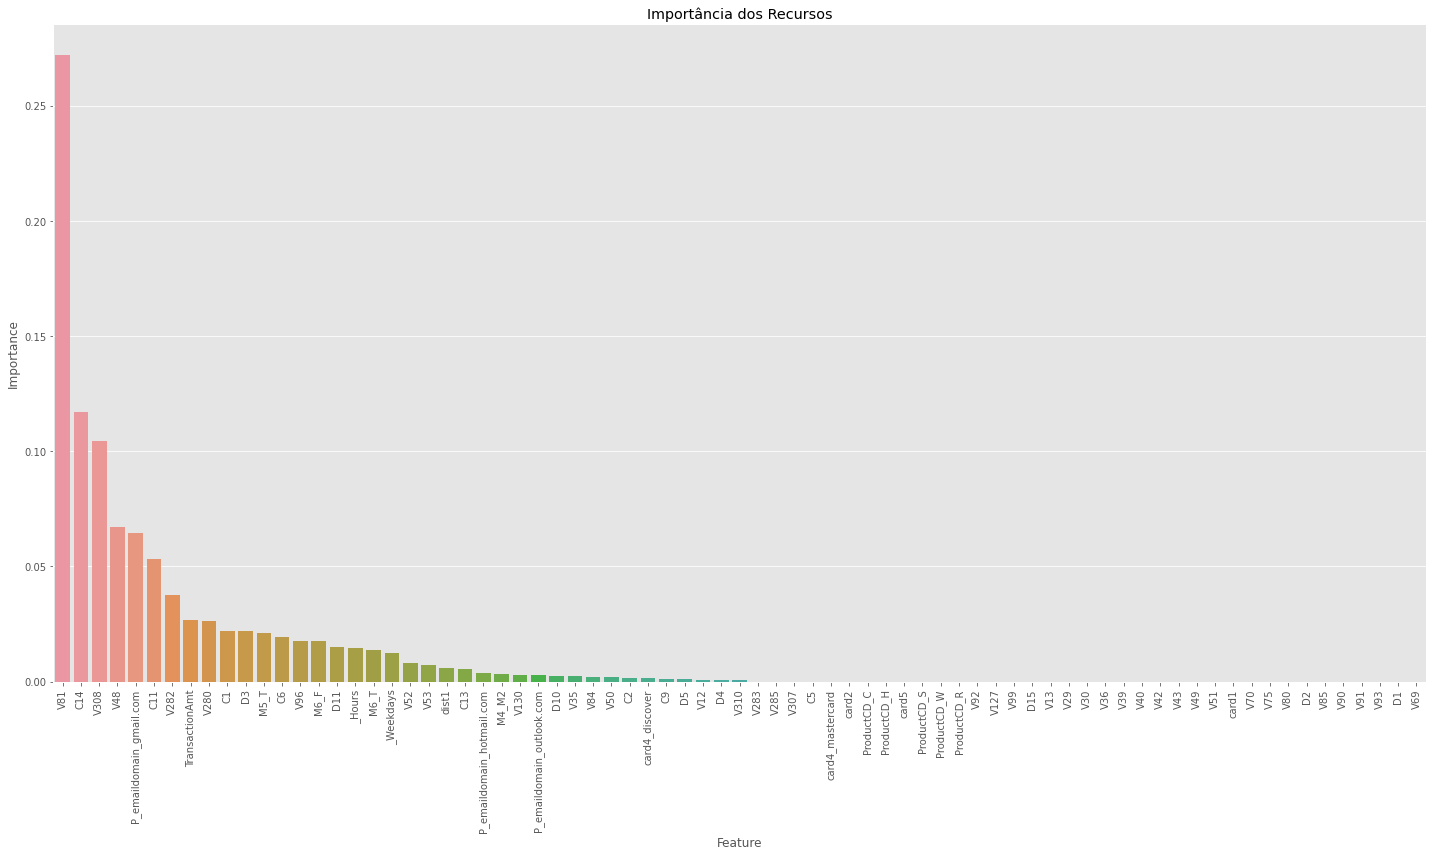

In [270]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.31947585991732314
F1-Score Negativo (Teste): 0.9609436200452114
F1-Score Positivo Médio (Validação Cruzada): 0.336144617289693
F1-Score Positivo Fold 1: 0.3849056603773585
F1-Score Positivo Fold 2: 0.3602251407129456
F1-Score Positivo Fold 3: 0.36158192090395486
F1-Score Positivo Fold 4: 0.3109404990403071
F1-Score Positivo Fold 5: 0.3520309477756286
F1-Score Positivo Fold 6: 0.37064220183486235
F1-Score Positivo Fold 7: 0.32358674463937626
F1-Score Positivo Fold 8: 0.2868217054263566
F1-Score Positivo Fold 9: 0.289628180039139
F1-Score Positivo Fold 10: 0.3210831721470019
F1-Score Negativo Médio (Validação Cruzada): 0.984968642019612
F1-Score Negativo Fold 1: 0.9858825567296035
F1-Score Negativo Fold 2: 0.9852310624106717
F1-Score Negativo Fold 3: 0.9853189554371833
F1-Score Negativo Fold 4: 0.9844595472057486
F1-Score Negativo Fold 5: 0.9855009738151915
F1-Score Negativo Fold 6: 0.985136716210946
F1-Score Negativo Fold 7: 0.984984205287983
F1-Score Negati

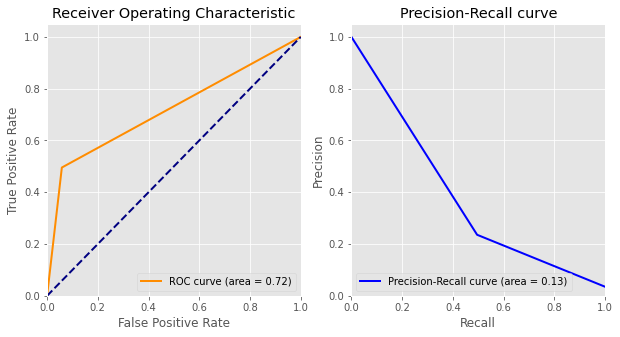

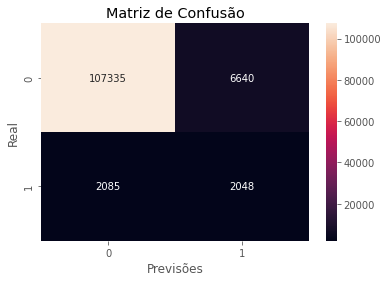

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.50      0.32      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.72      0.64    118108
weighted avg       0.95      0.93      0.94    118108

CPU times: user 7min 44s, sys: 436 ms, total: 7min 44s
Wall time: 7min 44s


In [271]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [272]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 20.8 s, sys: 2 µs, total: 20.8 s
Wall time: 20.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.319475859917323  0.960943620045211
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.319475859917323  0.960943620045211
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [273]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
12                        C14        0.10
52                       V280        0.08
5                          C1        0.06
8                          C6        0.05
48                        V96        0.05
74                       M6_T        0.04
60                     _Hours        0.04
4                       dist1        0.04
73                       M6_F        0.03
54                       V283        0.03
36                        V53        0.03
25                        V35        0.03
0              TransactionAmt        0.03
10                        C11        0.03
6                          C2        0.02
31                        V48        0.02
50                       V127        0.02
19                        D11        0.02
57                       V308        0.02
49                        V99        0.01
9                          C9        0.01
55                       V285        0.01
45                        V91        0.01
58                       V310        0.01
59                  _Weekdays        0.01
41                        V81        0.01
3                       card5        0.01
35                        V52        0.01
53                       V282        0.01
44                        V90        0.01
71                      M4_M2        0.01
68    P_emaildomain_gmail.com        0.01
15                         D3        0.01
16                         D4        0.01
17                         D5        0.01
18                        D10        0.01
2                       card2        0.01
21                        V12        0.01
22                        V13        0.01
72                       M5_T        0.01
66             card4_discover        0.01
11                        C13        0.01
70  P_emaildomain_outlook.com        0.01
69  P_emaildomain_hotmail.com        0.01
28                        V40        0.01
61                ProductCD_C        0.00
62                ProductCD_H        0.00
63                ProductCD_R        0.00
56                       V307        0.00
64                ProductCD_S        0.00
65                ProductCD_W        0.00
67           card4_mastercard        0.00
13                         D1        0.00
7                          C5        0.00
51                       V130        0.00
20                        D15        0.00
23                        V29        0.00
24                        V30        0.00
26                        V36        0.00
27                        V39        0.00
29                        V42        0.00
30                        V43        0.00
32                        V49        0.00
33                        V50        0.00
34                        V51        0.00
1                       card1        0.00
38                        V70        0.00
39                        V75        0.00
40                        V80        0.00
42                        V84        0.00
43                        V85        0.00
14                         D2        0.00
46                        V92        0.00
47                        V93        0.00
37                        V69        0.00

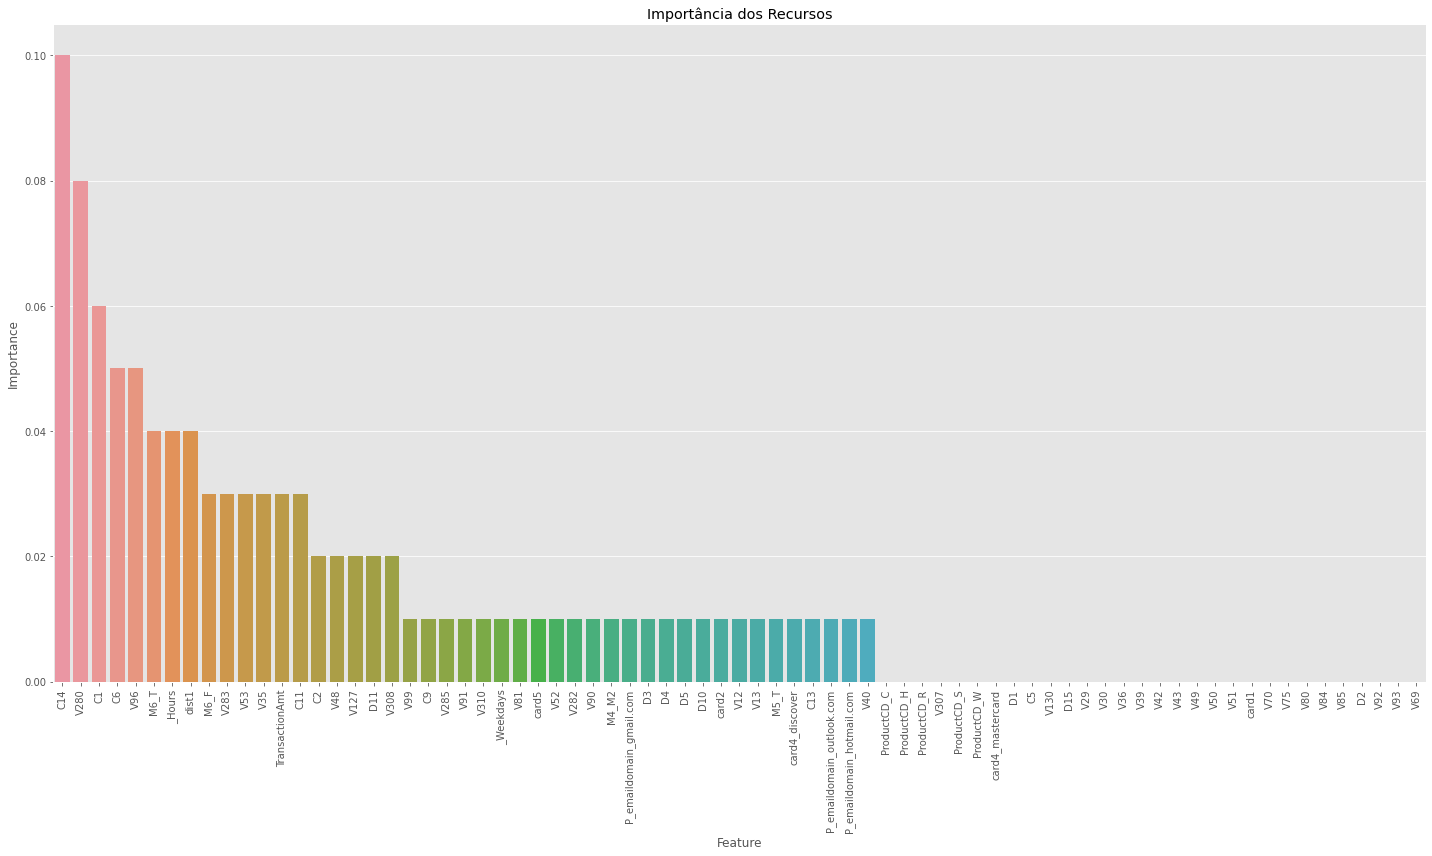

In [274]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3157826982492276
F1-Score Negativo (Teste): 0.9518307050933479
F1-Score Positivo Médio (Validação Cruzada): 0.2578667097451387
F1-Score Positivo Fold 1: 0.25614035087719306
F1-Score Positivo Fold 2: 0.2416812609457093
F1-Score Positivo Fold 3: 0.2601054481546573
F1-Score Positivo Fold 4: 0.2300884955752212
F1-Score Positivo Fold 5: 0.2727272727272727
F1-Score Positivo Fold 6: 0.23569023569023567
F1-Score Positivo Fold 7: 0.27586206896551724
F1-Score Positivo Fold 8: 0.2384341637010676
F1-Score Positivo Fold 9: 0.2773972602739726
F1-Score Positivo Fold 10: 0.2905405405405405
F1-Score Negativo Médio (Validação Cruzada): 0.981458528208704
F1-Score Negativo Fold 1: 0.9816068020128406
F1-Score Negativo Fold 2: 0.9812155654852284
F1-Score Negativo Fold 3: 0.9817377347850605
F1-Score Negativo Fold 4: 0.981133712104784
F1-Score Negativo Fold 5: 0.9819522776572669
F1-Score Negativo Fold 6: 0.9802848705923225
F1-Score Negativo Fold 7: 0.9817724155889246
F1-Score Nega

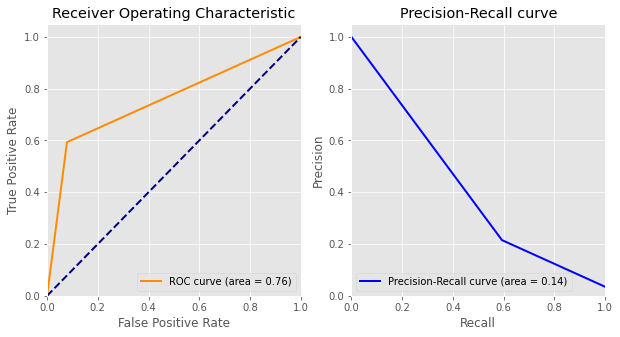

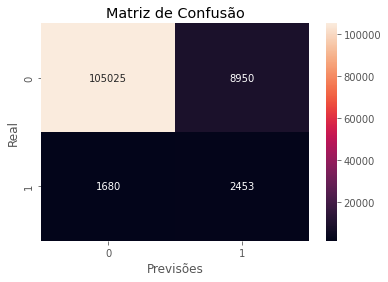

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 22min 18s, sys: 660 ms, total: 22min 19s
Wall time: 1min 59s


In [275]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [276]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 4h 40min 2s, sys: 1.1 s, total: 4h 40min 3s
Wall time: 23min 36s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.315782698249228  0.951830705093348
Threshold: 0.05  0.264088772592916   0.92955250743347
Threshold: 0.1   0.264088772592916   0.92955250743347
Threshold: 0.15  0.264088772592916   0.92955250743347
Threshold: 0.2   0.264088772592916   0.92955250743347
Threshold: 0.25  0.264088772592916   0.92955250743347
Threshold: 0.3   0.264088772592916   0.92955250743347
Threshold: 0.35  0.315782698249228  0.951830705093348
Threshold: 0.4   0.315782698249228  0.951830705093348
Threshold: 0.45  0.315782698249228  0.951830705093348
Threshold: 0.5   0.315782698249228  0.951830705093348
Threshold: 0.55  0.315782698249228  0.951830705093348
Threshold: 0.6   0.315782698249228  0.951830705093348
Threshold: 0.65  0.315782698249228  0.951830705093348
Threshold: 0.7   0.388248847926267  0.971780336581045
Threshold: 0.75  0.388248847926267  0.971780336581045

### Todas as colunas

In [277]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6752778612195856
F1-Score Negativo (Teste): 0.9905819008703683
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Nega

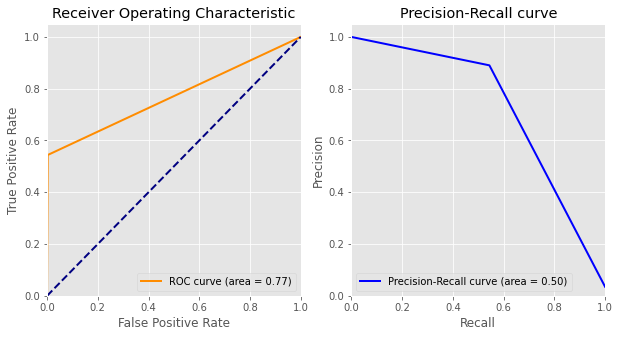

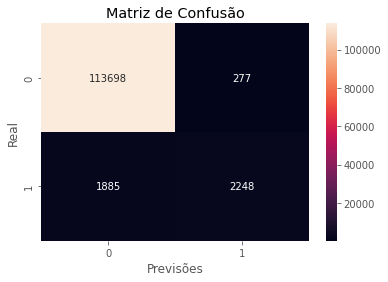

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 9s, sys: 340 ms, total: 8min 9s
Wall time: 8min 9s


In [278]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [279]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.5 s, sys: 2 µs, total: 53.5 s
Wall time: 53.5 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675277861219586  0.990581900870368
Threshold: 0.05  0.273720999405116  0.906678769348366
Threshold: 0.1   0.443788121990369   0.96073712501303
Threshold: 0.15   0.56411140812279  0.977495225248087
Threshold: 0.2   0.639122411318434   0.98445655341735
Threshold: 0.25  0.683488881207512  0.987927238207412
Threshold: 0.3   0.705487956295009  0.989603877946371
Threshold: 0.35  0.713930022277552  0.990449942034692
Threshold: 0.4   0.707029104887425  0.990678454737651
Threshold: 0.45  0.698571428571429  0.990794708920843
Threshold: 0.5   0.681263032469467  0.990675462523202
Threshold: 0.55  0.654714064914992  0.990276218084319
Threshold: 0.6   0.627720870678617  0.989885549293815
Threshold: 0.65  0.596153846153846  0.989417161922636
Threshold: 0.7   0.565336062777209  0.988938763815692
Threshold: 0.75  0.522924411400248  0.988311423577528

In [280]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
101         P_emaildomain_gmail.com  0.061373466013409
155                            M6_F  0.033780610407601
154                            M5_T  0.027954321150912
152                           M4_M2  0.027032489054489
76                      ProductCD_C  0.025270907322449
156                            M6_T  0.023545813549987
138         P_emaildomain_yahoo.com  0.022081462922752
153                            M5_F  0.019474963684690
77                      ProductCD_H  0.018057021972004
159                            M8_F  0.015919417356963
104       P_emaildomain_hotmail.com  0.015059314799080
0                    TransactionAmt  0.014670269526090
78                      ProductCD_R  0.014640104331348
80                      ProductCD_W  0.013927998521011
150                           M4_M0  0.013843241389660
13                              C14  0.013354424894597
83                 card4_mastercard  0.013299862687833
73                        _Weekdays  0.013036312659679
2                             card2  0.012474544009480
84                       card4_visa  0.012263391764626
6                                C1  0.012258937451480
1                             card1  0.012122069681198
148                            M3_F  0.011915144046101
45                              V50  0.011832299519039
74                           _Hours  0.011781240402330
160                            M8_T  0.011744303959437
15                               D2  0.011457285289213
68                             V283  0.011396633735065
7                                C2  0.011113699543205
12                              C13  0.011039868271762
149                            M3_T  0.010779402482428
50                              V69  0.010775405998877
75                            _Days  0.010673649061207
67                             V282  0.010340482818872
46                              V51  0.010217982468513
11                              C11  0.009629657055588
48                              V53  0.009589164623307
14                               D1  0.009420320549629
43                              V48  0.009391508016108
3                             card5  0.009195577863708
35                              V29  0.008753245110339
59                              V91  0.008695317125240
58                              V90  0.008247183307817
86      P_emaildomain_anonymous.com  0.008225648794025
51                              V70  0.008203432088793
44                              V49  0.008105593636487
9                                C6  0.007940928832027
4                             addr1  0.007711722906425
60                              V92  0.007456690883064
61                              V93  0.007135849666916
49                              V54  0.007068212646277
22                               V1  0.007044381833059
151                           M4_M1  0.007002945166726
52                              V75  0.006950236760273
146                            M2_F  0.006857547299999
41                              V42  0.006831867068574
33                              V12  0.006751083596848
47                              V52  0.006721055492591
19                              D10  0.006672936146259
66                             V280  0.006669976450936
37                              V35  0.006267668024965
39                              V39  0.006216194302593
71                             V308  0.006179947571833
42                              V43  0.006162986793062
31                              V10  0.006035377145191
34                              V13  0.006021531454597
36                              V30  0.005935864165969
158                            M7_T  0.005808235786004
40                              V40  0.005796589949142
62                              V96  0.005681875650474
53                              V76  0.005679764858327
17                               D4  0.005663791104045
56           

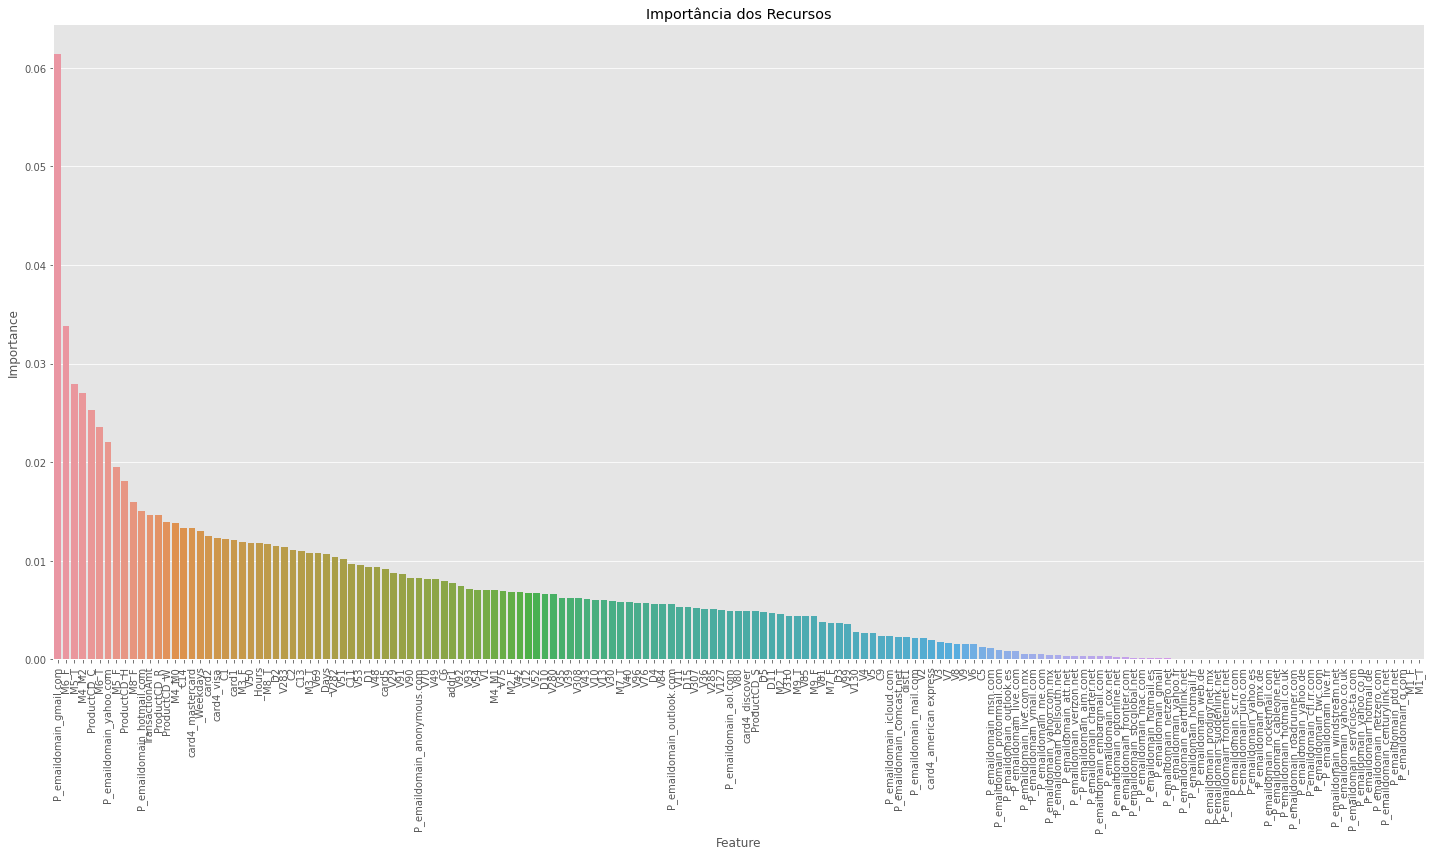

In [281]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4993472584856396
F1-Score Negativo (Teste): 0.9797290154344915
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score 

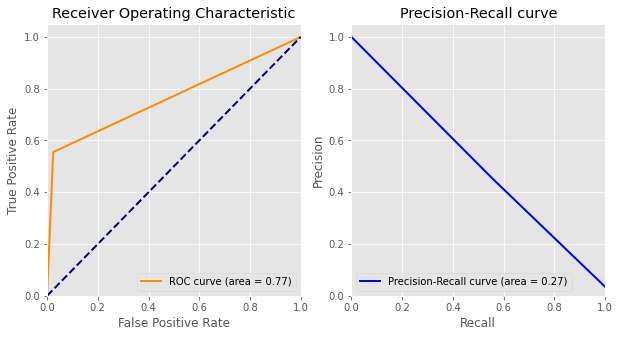

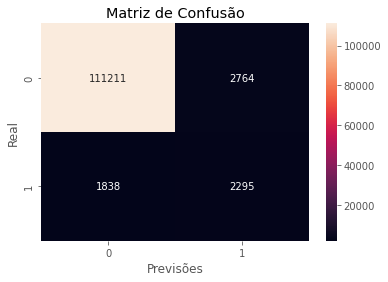

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.45      0.56      0.50      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.77      0.74    118108
weighted avg       0.97      0.96      0.96    118108

CPU times: user 1min 49s, sys: 328 ms, total: 1min 49s
Wall time: 1min 49s


In [282]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [283]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.24 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.49934725848564  0.979729015434492
Threshold: 0.05  0.499292940280648  0.979724521304009
Threshold: 0.1   0.499292940280648  0.979724521304009
Threshold: 0.15  0.499292940280648  0.979724521304009
Threshold: 0.2   0.499292940280648  0.979724521304009
Threshold: 0.25  0.499292940280648  0.979724521304009
Threshold: 0.3   0.499292940280648  0.979724521304009
Threshold: 0.35  0.499292940280648  0.979724521304009
Threshold: 0.4   0.499292940280648  0.979724521304009
Threshold: 0.45  0.499292940280648  0.979724521304009
Threshold: 0.5   0.499292940280648  0.979724521304009
Threshold: 0.55   0.49934725848564  0.979729015434492
Threshold: 0.6    0.49934725848564  0.979729015434492
Threshold: 0.65   0.49934725848564  0.979729015434492
Threshold: 0.7    0.49934725848564  0.979729015434492
Threshold: 0.75   0.49934725848564  0.979729015434492

In [284]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
55                              V81  0.195750715762792
6                                C1  0.131220157265995
68                             V283  0.112024372033176
13                              C14  0.079667161426486
153                            M5_F  0.048809978968156
66                             V280  0.046447850447222
50                              V69  0.029747369906790
58                              V90  0.023539650725647
154                            M5_T  0.022673997467155
12                              C13  0.016948630571422
0                    TransactionAmt  0.016873887103150
101         P_emaildomain_gmail.com  0.015700956019431
150                           M4_M0  0.015552578026563
1                             card1  0.015374631645688
4                             addr1  0.010630069789978
2                             card2  0.010245779566491
54                              V80  0.008988795610400
152                           M4_M2  0.007593826322933
3                             card5  0.006211991654791
47                              V52  0.005841024438230
75                            _Days  0.005821919341789
104       P_emaildomain_hotmail.com  0.005726586747069
69                             V285  0.005467118676791
74                           _Hours  0.004897223612412
7                                C2  0.004803225537383
5                             dist1  0.004799635834159
11                              C11  0.004656989117684
159                            M8_F  0.004515280280662
9                                C6  0.004393862634308
71                             V308  0.004304375103616
138         P_emaildomain_yahoo.com  0.004220046169644
16                               D3  0.004160870371448
63                              V99  0.003930673844746
67                             V282  0.003895521075231
15                               D2  0.003832430051912
21                              D15  0.003807199846260
156                            M6_T  0.003763196689240
73                        _Weekdays  0.003380780719685
72                             V310  0.003245031053769
48                              V53  0.003107390543509
19                              D10  0.002962050195065
10                               C9  0.002947737083233
17                               D4  0.002896010135301
162                            M9_T  0.002838006188513
18                               D5  0.002795418053269
14                               D1  0.002722963363050
70                             V307  0.002596955060261
78                      ProductCD_R  0.002554393045217
82                   card4_discover  0.002403498971325
77                      ProductCD_H  0.002400141356364
59                              V91  0.002286894480026
46                              V51  0.002274464194612
86      P_emaildomain_anonymous.com  0.002256239835475
24                               V3  0.002175150660763
160                            M8_T  0.001978562476366
83                 card4_mastercard  0.001777886171472
33                              V12  0.001754333782859
49                              V54  0.001711038938463
62                              V96  0.001707146162855
148                            M3_F  0.001612253893279
147                            M2_T  0.001598791171325
120       P_emaildomain_outlook.com  0.001565835223561
84                       card4_visa  0.001541941888890
20                              D11  0.001516801560082
65                             V130  0.001425652220394
146                            M2_F  0.001401622823938
64                             V127  0.001396388611509
34                              V13  0.001345128088418
38                              V36  0.001284110424122
151                           M4_M1  0.001264621428180
26                               V5  0.001228305247422
45                              V50  0.001201014198528
114          

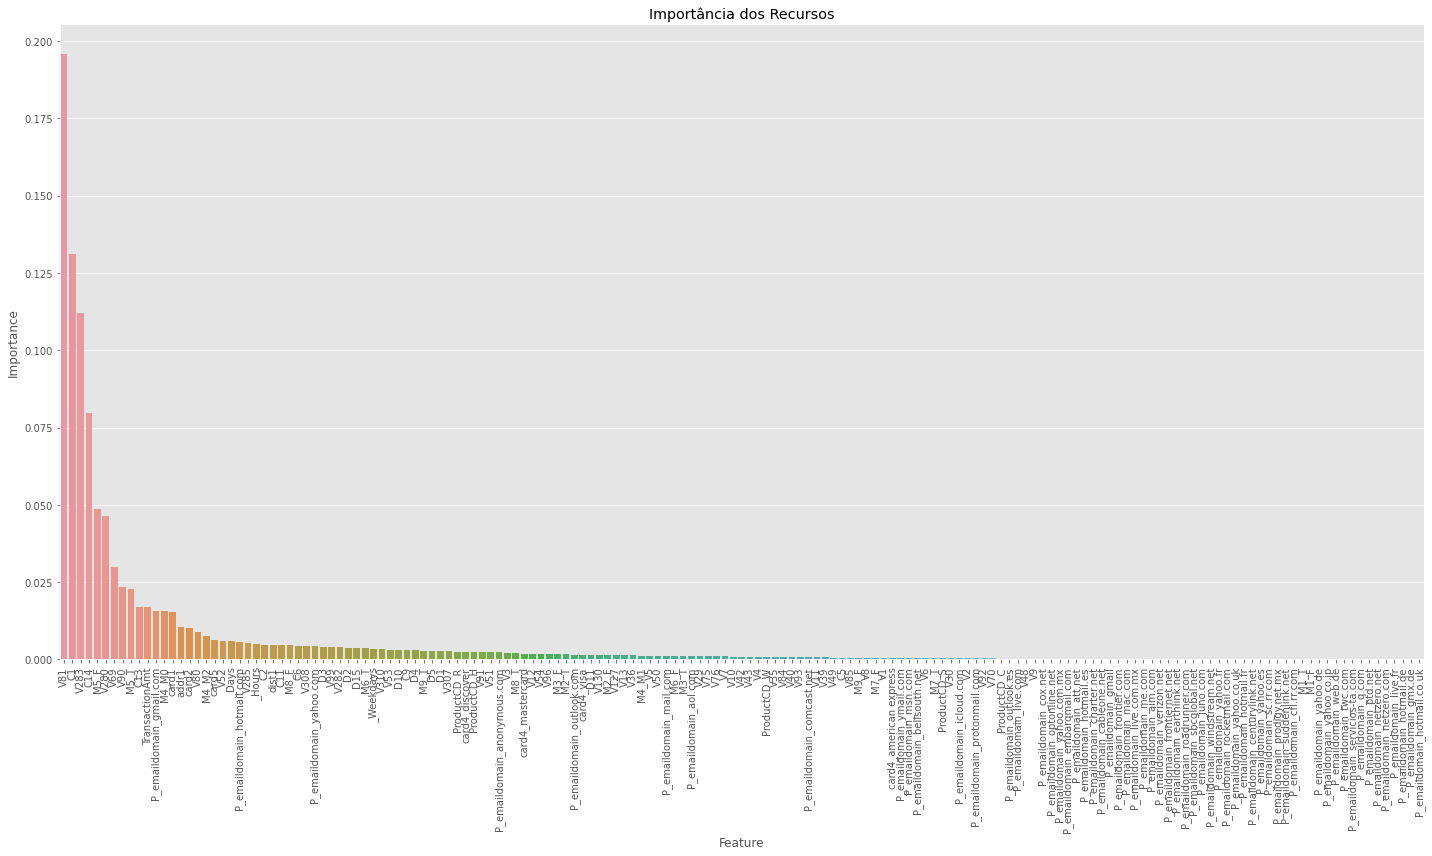

In [285]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6025149	total: 78.9ms	remaining: 316ms
1:	learn: 0.5482334	total: 155ms	remaining: 233ms
2:	learn: 0.4968516	total: 236ms	remaining: 157ms
3:	learn: 0.4575837	total: 316ms	remaining: 78.9ms
4:	learn: 0.4239796	total: 393ms	remaining: 0us
0:	learn: 0.5336608	total: 11.9ms	remaining: 47.4ms
1:	learn: 0.4271318	total: 23.1ms	remaining: 34.6ms
2:	learn: 0.3416706	total: 32.4ms	remaining: 21.6ms
3:	learn: 0.2888256	total: 40.2ms	remaining: 10ms
4:	learn: 0.2438958	total: 48.6ms	remaining: 0us
0:	learn: 0.5331992	total: 13.4ms	remaining: 53.6ms
1:	learn: 0.4266171	total: 23.6ms	remaining: 35.4ms
2:	learn: 0.3413103	total: 32.2ms	remaining: 21.5ms
3:	learn: 0.2883925	total: 39.9ms	remaining: 9.97ms
4:	learn: 0.2434156	total: 48.4ms	remaining: 0us
0:	learn: 0.5334749	total: 7.78ms	remaining: 31.1ms
1:	learn: 0.4268605	total: 16.4ms	remaining: 24.7ms
2:	learn: 0.3408881	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.2880311	total: 32.5ms	remaining: 8.12ms
4:	learn: 0.2431527	total: 41.

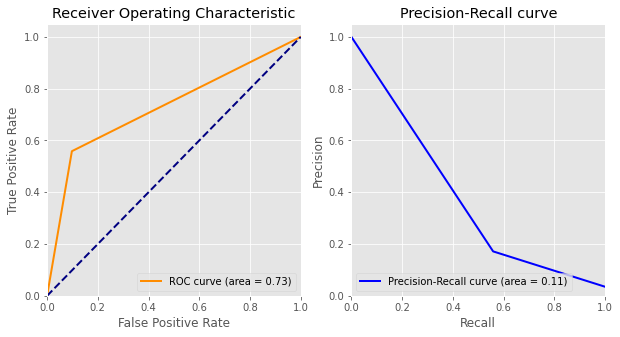

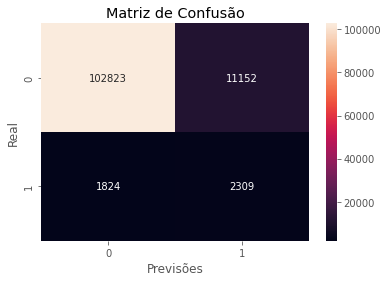

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    113975
           1       0.17      0.56      0.26      4133

    accuracy                           0.89    118108
   macro avg       0.58      0.73      0.60    118108
weighted avg       0.95      0.89      0.92    118108

CPU times: user 1min 56s, sys: 776 ms, total: 1min 57s
Wall time: 1min 32s


In [286]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [287]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 44.3 s, sys: 20 ms, total: 44.3 s
Wall time: 43.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.26247584403774  0.940646412529389
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.070031492041876  0.079712952512508
Threshold: 0.3   0.085700757575758  0.407040366255374
Threshold: 0.35  0.120854384473013  0.700839182265395
Threshold: 0.4   0.174770321818084  0.845620382933816
Threshold: 0.45  0.223176661264182  0.909367672642009
Threshold: 0.5    0.26247584403774  0.940646412529389
Threshold: 0.55  0.313802595359811  0.960962143346115
Threshold: 0.6   0.357247132429614  0.972801002532807
Threshold: 0.65  0.348618281202551   0.98131777206811
Threshold: 0.7   0.249951484572094  0.983272960188347
Threshold: 0.75  0.195830701200253  0.983500887815542

In [288]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
154                            M5_T  16.975071622690329
66                             V280  13.322627464227899
153                            M5_F  10.374930653604338
138         P_emaildomain_yahoo.com   8.627837413945434
13                              C14   7.608008160123626
52                              V75   7.151955197464452
101         P_emaildomain_gmail.com   6.812638217827763
6                                C1   5.986469582910053
43                              V48   5.489122220360383
50                              V69   4.196593558691774
57                              V85   4.081197078687019
47                              V52   2.813283307380719
9                                C6   1.794550191870690
68                             V283   1.665416680211216
55                              V81   1.281651016551745
44                              V49   0.969895694735794
7                                C2   0.848751938716753
98       P_emaildomain_frontier.com   0.000000000000000
99    P_emaildomain_frontiernet.net   0.000000000000000
90       P_emaildomain_cableone.net   0.000000000000000
120       P_emaildomain_outlook.com   0.000000000000000
91    P_emaildomain_centurylink.net   0.000000000000000
92         P_emaildomain_cfl.rr.com   0.000000000000000
119     P_emaildomain_optonline.net   0.000000000000000
118       P_emaildomain_netzero.net   0.000000000000000
93        P_emaildomain_charter.net   0.000000000000000
117       P_emaildomain_netzero.com   0.000000000000000
116           P_emaildomain_msn.com   0.000000000000000
115            P_emaildomain_me.com   0.000000000000000
114          P_emaildomain_mail.com   0.000000000000000
113           P_emaildomain_mac.com   0.000000000000000
112           P_emaildomain_live.fr   0.000000000000000
111       P_emaildomain_live.com.mx   0.000000000000000
110          P_emaildomain_live.com   0.000000000000000
109          P_emaildomain_juno.com   0.000000000000000
94        P_emaildomain_comcast.net   0.000000000000000
95            P_emaildomain_cox.net   0.000000000000000
108        P_emaildomain_icloud.com   0.000000000000000
96      P_emaildomain_earthlink.net   0.000000000000000
107        P_emaildomain_hotmail.fr   0.000000000000000
121        P_emaildomain_outlook.es   0.000000000000000
105        P_emaildomain_hotmail.de   0.000000000000000
104       P_emaildomain_hotmail.com   0.000000000000000
103     P_emaildomain_hotmail.co.uk   0.000000000000000
102            P_emaildomain_gmx.de   0.000000000000000
97     P_emaildomain_embarqmail.com   0.000000000000000
100             P_emaildomain_gmail   0.000000000000000
106        P_emaildomain_hotmail.es   0.000000000000000
0                    TransactionAmt   0.000000000000000
122    P_emaildomain_prodigy.net.mx   0.000000000000000
151                           M4_M1   0.000000000000000
144                            M1_F   0.000000000000000
145                            M1_T   0.000000000000000
146                            M2_F   0.000000000000000
147                            M2_T   0.000000000000000
148                            M3_F   0.000000000000000
149                            M3_T   0.000000000000000
150                           M4_M0   0.000000000000000
152                           M4_M2   0.000000000000000
142          P_emaildomain_yahoo.fr   0.000000000000000
155                            M6_F   0.000000000000000
156                            M6_T   0.000000000000000
157                            M7_F   0.000000000000000
158                            M7_T   0.000000000000000
159                            M8_F   0.000000000000000
160                            M8_T   0.000000000000000
161                            M9_F   0.000000000000000
143         P_emaildomain_ymail.com   0.000000000000000
141          P_emaildomain_yahoo.es   0.000000000000000
123    P_emaildomain_protonmail.com   0.000000000000000
130  P_emaildomain_servicios-ta.com   0.000000000000

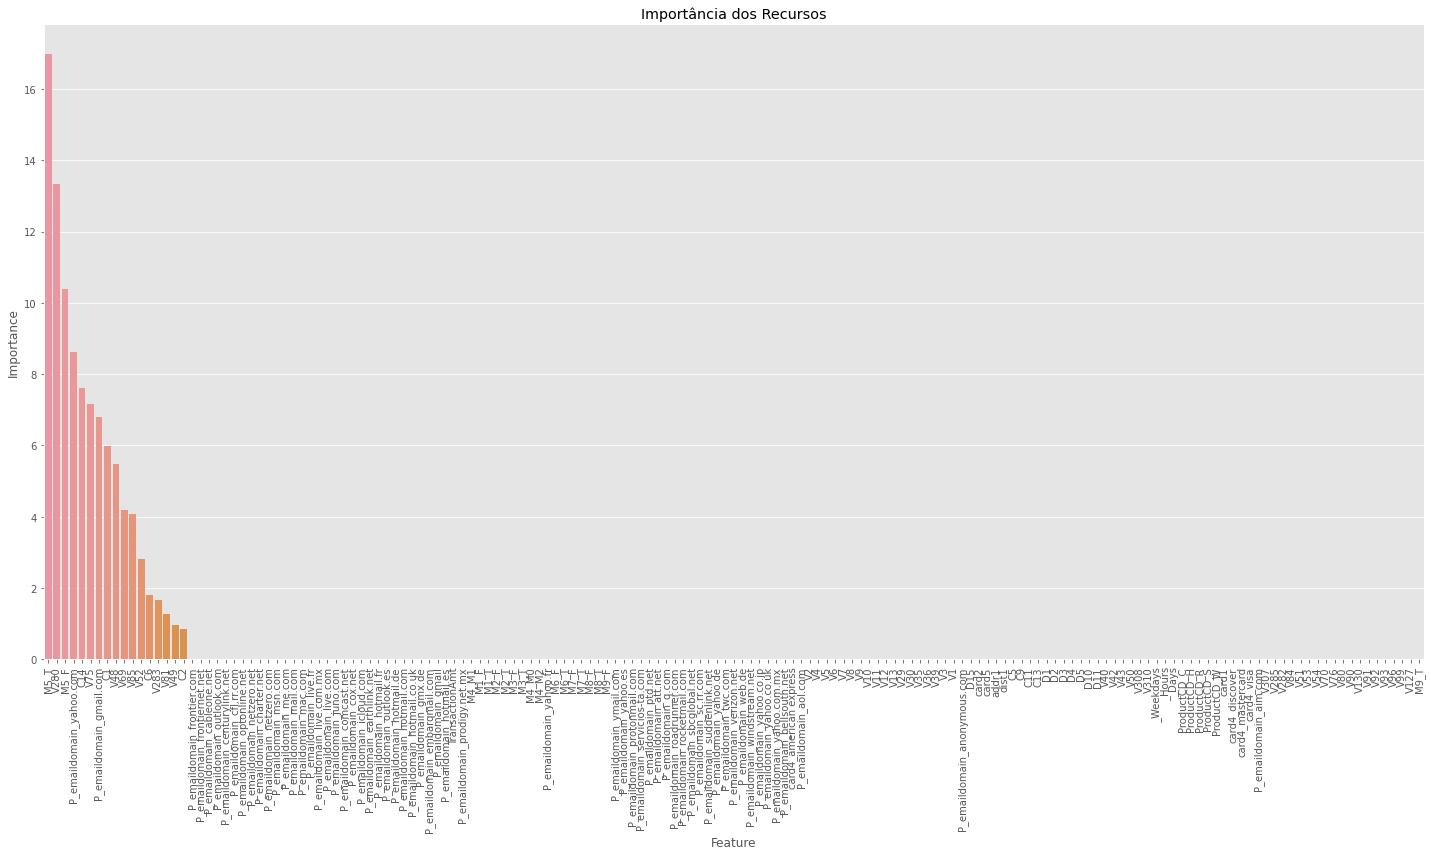

In [289]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3673193787981094
F1-Score Negativo (Teste): 0.9709584722535853
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

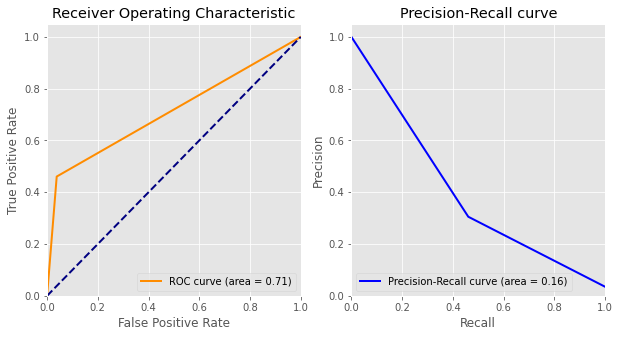

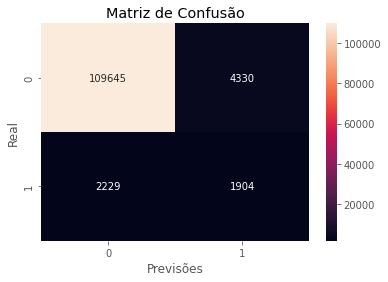

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.31      0.46      0.37      4133

    accuracy                           0.94    118108
   macro avg       0.64      0.71      0.67    118108
weighted avg       0.96      0.94      0.95    118108

CPU times: user 8min 43s, sys: 316 ms, total: 8min 43s
Wall time: 8min 43s


In [290]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [291]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.73 s, sys: 4 ms, total: 2.74 s
Wall time: 2.74 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.367319378798109  0.970958472253585
Threshold: 0.05  0.100378363413444  0.574471667404576
Threshold: 0.1   0.135615023291169  0.760157699192576
Threshold: 0.15  0.169397744200894  0.842798453359111
Threshold: 0.2   0.202463326875173  0.888805278999768
Threshold: 0.25  0.234704891844048  0.916805519701485
Threshold: 0.3   0.268355494823146  0.935903752031641
Threshold: 0.35  0.295133046675391  0.948625828340956
Threshold: 0.4   0.322136845956824  0.958378079631186
Threshold: 0.45  0.346248410343366  0.965640470365964
Threshold: 0.5   0.367319378798109  0.970958472253585
Threshold: 0.55  0.385004397537379  0.975369848538218
Threshold: 0.6   0.394843462246777  0.978388308903806
Threshold: 0.65  0.394967177242888  0.980673120609513
Threshold: 0.7   0.386569872958258  0.982334802529573
Threshold: 0.75  0.366881507188894  0.983355418938588

In [292]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
55                              V81  0.266204858429120
13                              C14  0.109992599833290
71                             V308  0.100762958700911
101         P_emaildomain_gmail.com  0.067409151146798
43                              V48  0.065155217666319
11                              C11  0.050059709308730
67                             V282  0.035165337781440
138         P_emaildomain_yahoo.com  0.023827511185462
154                            M5_T  0.023489386529633
66                             V280  0.022990459136168
9                                C6  0.021700428069935
16                               D3  0.021574442007487
153                            M5_F  0.020133505002800
6                                C1  0.019291261710176
0                    TransactionAmt  0.018456007898977
73                        _Weekdays  0.012150428286096
149                            M3_T  0.011704294412024
74                           _Hours  0.010081233061512
62                              V96  0.009887442439890
104       P_emaildomain_hotmail.com  0.008882917974945
148                            M3_F  0.008398438618831
29                               V8  0.007728008947211
24                               V3  0.007335640470419
12                              C13  0.006559373743675
159                            M8_F  0.005236502522641
47                              V52  0.004468635755685
120       P_emaildomain_outlook.com  0.004222152091665
87            P_emaildomain_aol.com  0.004039516844716
160                            M8_T  0.003923920099909
94        P_emaildomain_comcast.net  0.003588737849356
64                             V127  0.002671761904901
84                       card4_visa  0.002280444254873
19                              D10  0.001903191547572
86      P_emaildomain_anonymous.com  0.001861753830469
152                           M4_M2  0.001834086731895
65                             V130  0.001442917382433
83                 card4_mastercard  0.001412485334637
35                              V29  0.001250790570508
150                           M4_M0  0.001132857324314
30                               V9  0.001094016108507
82                   card4_discover  0.001018359712146
114          P_emaildomain_mail.com  0.000891985299043
49                              V54  0.000872930350009
56                              V84  0.000862197947981
75                            _Days  0.000815429964044
48                              V53  0.000790767914106
108        P_emaildomain_icloud.com  0.000763516181047
18                               D5  0.000753004851036
2                             card2  0.000733854661307
37                              V35  0.000602967999292
1                             card1  0.000590602604059
161                            M9_F  0.000000000000000
117       P_emaildomain_netzero.com  0.000000000000000
109          P_emaildomain_juno.com  0.000000000000000
102            P_emaildomain_gmx.de  0.000000000000000
110          P_emaildomain_live.com  0.000000000000000
119     P_emaildomain_optonline.net  0.000000000000000
118       P_emaildomain_netzero.net  0.000000000000000
103     P_emaildomain_hotmail.co.uk  0.000000000000000
106        P_emaildomain_hotmail.es  0.000000000000000
105        P_emaildomain_hotmail.de  0.000000000000000
116           P_emaildomain_msn.com  0.000000000000000
115            P_emaildomain_me.com  0.000000000000000
111       P_emaildomain_live.com.mx  0.000000000000000
113           P_emaildomain_mac.com  0.000000000000000
112           P_emaildomain_live.fr  0.000000000000000
107        P_emaildomain_hotmail.fr  0.000000000000000
155                            M6_F  0.000000000000000
121        P_emaildomain_outlook.es  0.000000000000000
136       P_emaildomain_yahoo.co.jp  0.000000000000000
156                            M6_T  0.000000000000000
151                           M4_M1  0.000000000000000
147          

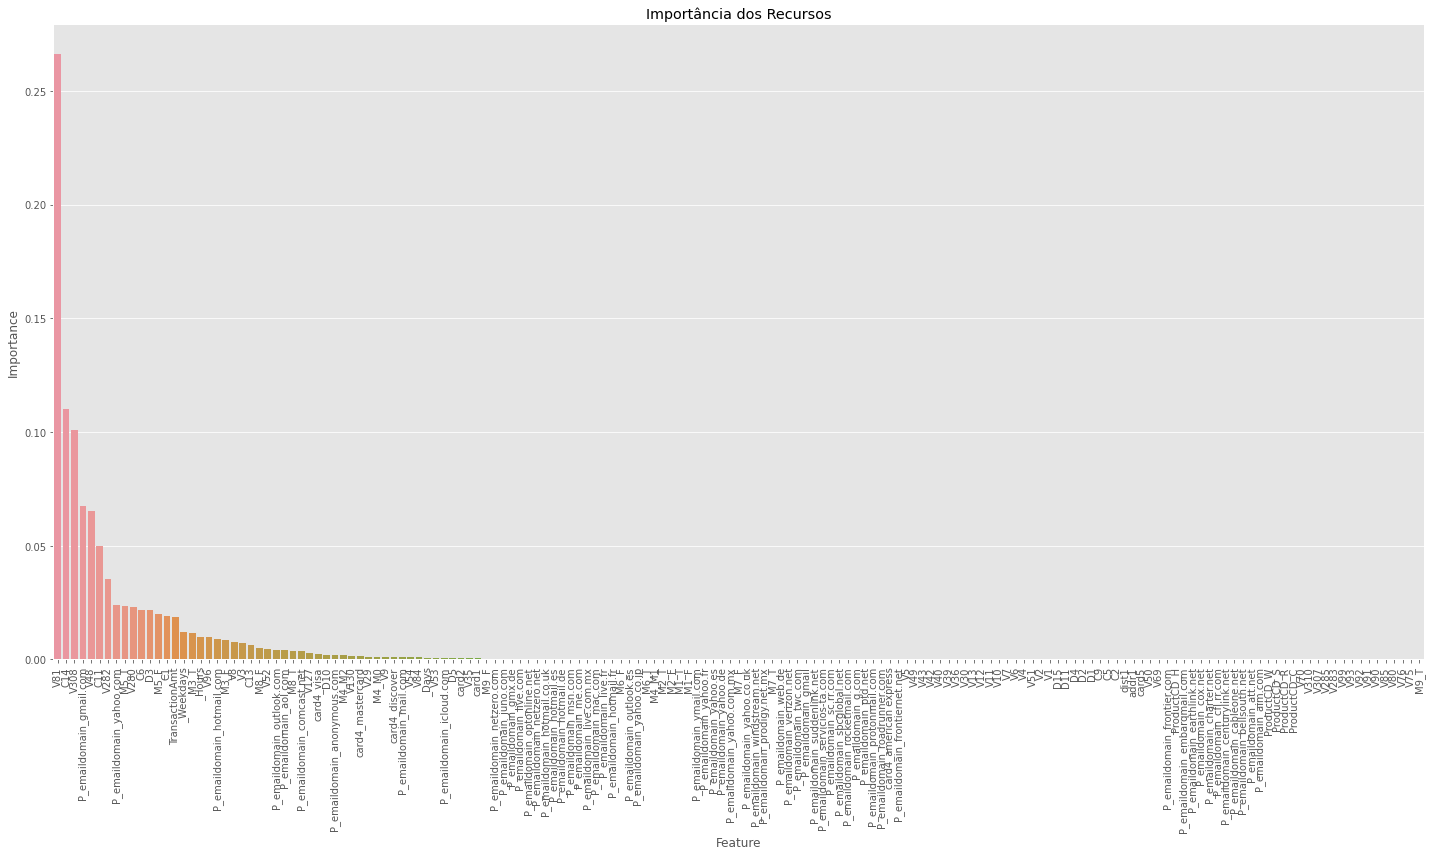

In [293]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3348318348318348
F1-Score Negativo (Teste): 0.964362812438672
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Nega

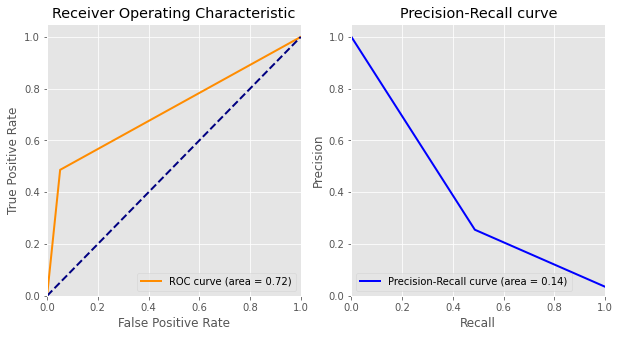

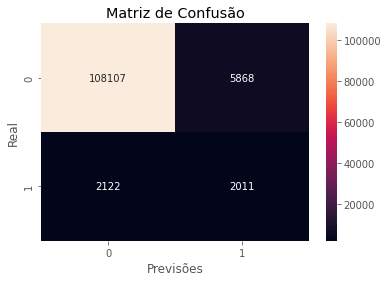

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    113975
           1       0.26      0.49      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 10min 42s, sys: 7.97 s, total: 10min 50s
Wall time: 10min 50s


In [294]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [295]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 34.1 s, sys: 2 µs, total: 34.1 s
Wall time: 34.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334831834831835  0.964362812438672
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.334831834831835  0.964362812438672
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [296]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
13                              C14        0.07
6                                C1        0.06
74                           _Hours        0.04
62                              V96        0.04
64                             V127        0.03
101         P_emaildomain_gmail.com        0.03
84                       card4_visa        0.03
68                             V283        0.03
66                             V280        0.03
9                                C6        0.03
43                              V48        0.02
152                           M4_M2        0.02
29                               V8        0.02
148                            M3_F        0.02
0                    TransactionAmt        0.02
138         P_emaildomain_yahoo.com        0.02
48                              V53        0.02
154                            M5_T        0.02
83                 card4_mastercard        0.02
153                            M5_F        0.02
104       P_emaildomain_hotmail.com        0.02
11                              C11        0.02
12                              C13        0.02
2                             card2        0.01
73                        _Weekdays        0.01
49                              V54        0.01
55                              V81        0.01
58                              V90        0.01
59                              V91        0.01
18                               D5        0.01
10                               C9        0.01
67                             V282        0.01
69                             V285        0.01
71                             V308        0.01
75                            _Days        0.01
108        P_emaildomain_icloud.com        0.01
46                              V51        0.01
1                             card1        0.01
82                   card4_discover        0.01
86      P_emaildomain_anonymous.com        0.01
87            P_emaildomain_aol.com        0.01
116           P_emaildomain_msn.com        0.01
114          P_emaildomain_mail.com        0.01
94        P_emaildomain_comcast.net        0.01
110          P_emaildomain_live.com        0.01
120       P_emaildomain_outlook.com        0.01
19                              D10        0.01
150                           M4_M0        0.01
25                               V4        0.01
149                            M3_T        0.01
40                              V40        0.01
27                               V6        0.01
31                              V10        0.01
16                               D3        0.01
17                               D4        0.01
32                              V11        0.01
24                               V3        0.01
151                           M4_M1        0.01
118       P_emaildomain_netzero.net        0.00
160                            M8_T        0.00
161                            M9_F        0.00
119     P_emaildomain_optonline.net        0.00
117       P_emaildomain_netzero.com        0.00
147                            M2_T        0.00
136       P_emaildomain_yahoo.co.jp        0.00
115            P_emaildomain_me.com        0.00
122    P_emaildomain_prodigy.net.mx        0.00
113           P_emaildomain_mac.com        0.00
112           P_emaildomain_live.fr        0.00
111       P_emaildomain_live.com.mx        0.00
109          P_emaildomain_juno.com        0.00
107        P_emaildomain_hotmail.fr        0.00
106        P_emaildomain_hotmail.es        0.00
105        P_emaildomain_hotmail.de        0.00
121        P_emaildomain_outlook.es        0.00
146                            M2_F        0.00
137       P_emaildomain_yahoo.co.uk        0.00
128     P_emaildomain_sbcglobal.net        0.00
156                            M6_T        0.00
135    P_emaildomain_windstream.net        0.00
103     P_emaildomain_hotmail.co.uk        0.00
133       P_emaildomain_verizon.net        0.00
132           P_emaildomain_twc.com        0

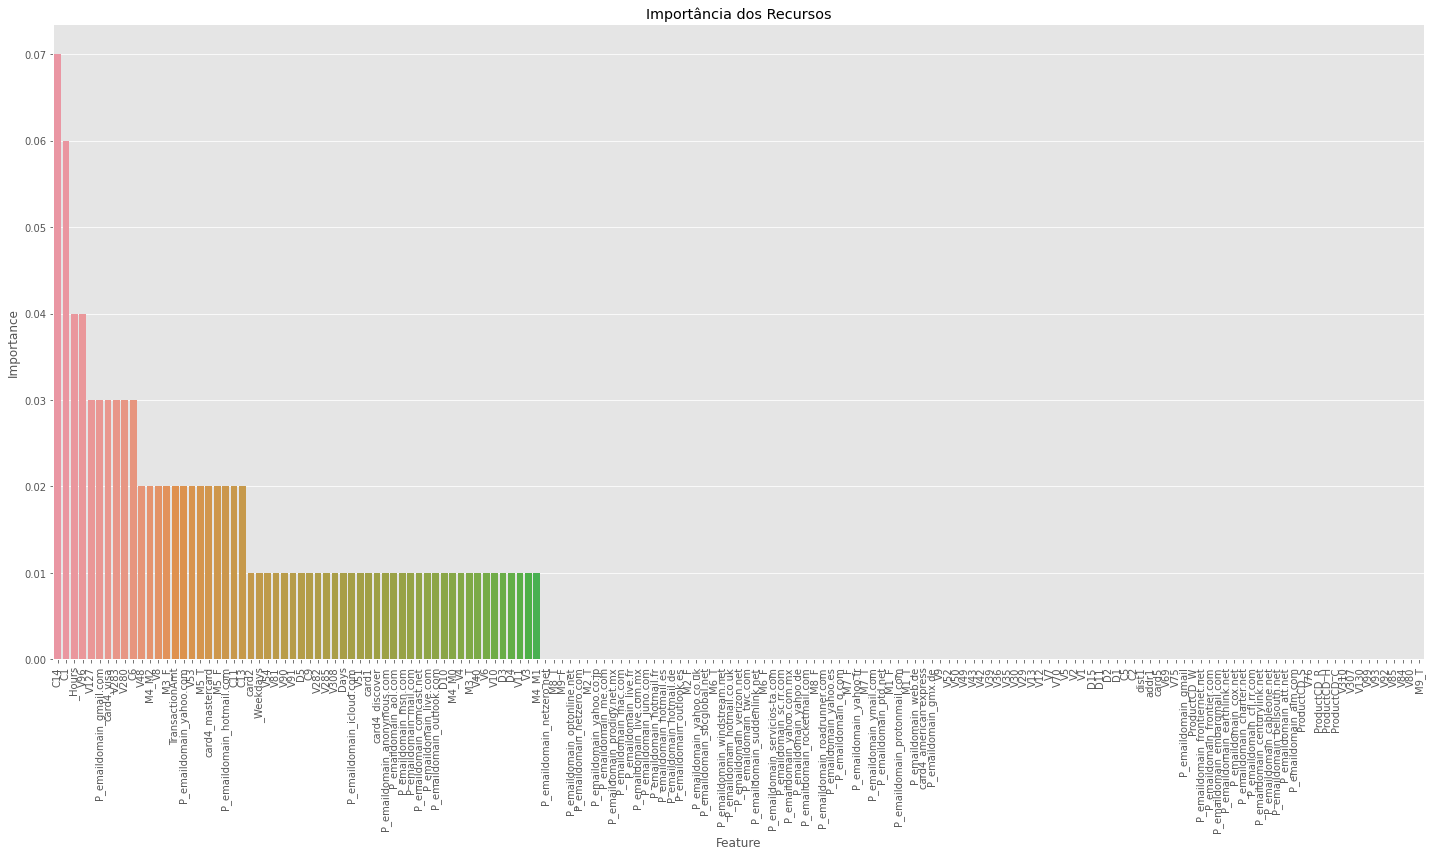

In [297]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3163402028967014
F1-Score Negativo (Teste): 0.9514153702452584
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

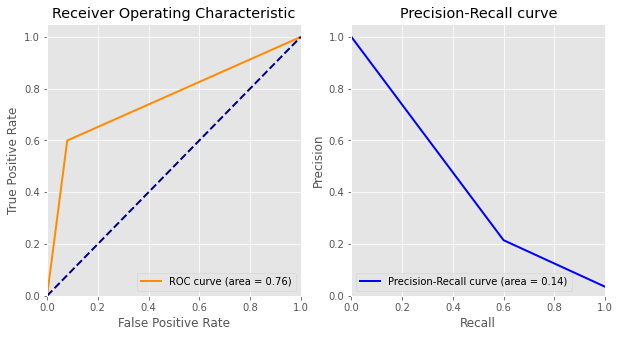

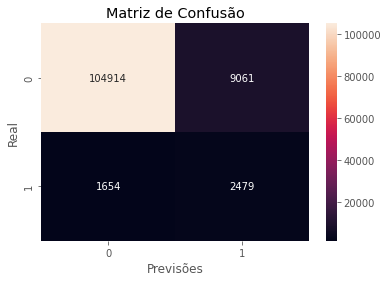

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.21      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 39min 36s, sys: 1.07 s, total: 39min 37s
Wall time: 3min 27s


In [298]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [299]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8h 7min 10s, sys: 1.89 s, total: 8h 7min 12s
Wall time: 41min 3s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.316340202896701  0.951415370245258
Threshold: 0.05  0.264626375748214  0.929308584686775
Threshold: 0.1   0.264626375748214  0.929308584686775
Threshold: 0.15  0.264626375748214  0.929308584686775
Threshold: 0.2   0.264626375748214  0.929308584686775
Threshold: 0.25  0.264626375748214  0.929308584686775
Threshold: 0.3   0.264626375748214  0.929308584686775
Threshold: 0.35  0.316340202896701  0.951415370245258
Threshold: 0.4   0.316340202896701  0.951415370245258
Threshold: 0.45  0.316340202896701  0.951415370245258
Threshold: 0.5   0.316340202896701  0.951415370245258
Threshold: 0.55  0.316340202896701  0.951415370245258
Threshold: 0.6   0.316340202896701  0.951415370245258
Threshold: 0.65  0.316340202896701  0.951415370245258
Threshold: 0.7   0.390726604467062  0.971343720218967
Threshold: 0.75  0.390726604467062  0.971343720218967

# Cálculo tempo total do script

In [300]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.9e+04 s
